In [1]:
import numpy as np
import pandas as pd
import json 

In [2]:
# import utility functions 
from ret import read_data # utility func to load data
from ret import get_id_from_info # utility func to return id by entering song's info
from ret import display_res # utility func to display results 
from ret import get_genre #utility func to get the genres from a list of id´s
from ret import get_genre_from_query #utility func to get the id and genre from the query
from ret import get_genre_from_ids #utility func to get the id and genre from the retrieved results
from ret import generate_cos_sim_matrix

# import the retrieval systems 
from ret import random_baseline # baseline retrieval system that returns random results 
from ret import text_based # modularized text based retrieval system
from ret import audio_based # modularized audio based retrieval system
from ret import video_based # modularized video based retrieval system

# import wrapper function to calculate cosine similarity
from ret import cos_sim 

# import evaluation functions 
from ret import gen_cov_10
from ret import ndcg_score
from ret import gen_div_10
from ret import calculate_precision_at_k
#from ret import calculate_recall_at_k
from ret import plot_precision_recall_curve
from ret import get_avg_recall_at_k
from ret import get_avg_precision_at_k

In [3]:
"""
Please put data files in ""./data/" before use 
"""

info = read_data("information")
genres = read_data("genres")

# text embeddings 
tfidf = read_data("lyrics_tf-idf")
word2vec = read_data("lyrics_word2vec")
bert = read_data("lyrics_bert")

# audio embeddings
blf_correlation = read_data("blf_correlation")
ivec256 = read_data("ivec256")
mfcc_stats = read_data("mfcc_stats")
musicnn = read_data("musicnn")

# video embeddings
vgg19 = read_data("vgg19")
ResNet = read_data("resnet")


In [4]:
song_ids = info['id'].tolist()

In [9]:
#df = pd.merge(df, genres, on='id')
# Erstellen Sie ein leeres Array aus Sets
def get_relevancy_count(genre_query,genre_other_songs):
    array = change_list_to_sets(genre_other_songs)

    #print("Das Array aus Sets ist fertig")
    #print(array)



    # Initialize a counter
    count = 0

    #print("Loop through the list of sets")
    '''Try for better performance# Erstellen Sie eine neue Liste mit 1 für jedes Element, das die Bedingung erfüllt
    newlist = [1 for s in array if genre_query.intersection(s)]

    # Berechnen Sie die Summe der neuen Liste, um den Zähler zu erhalten
    count = sum(newlist)
    '''
    for s in array:
        # Check if the intersection is not empty
        if genre_query.intersection(s):#
        # Increment the counter
            count += 1

     #print("done")
    #print(count) # 1
    return count

In [10]:
def change_list_to_sets(list):
    array = []
    # Iterieren Sie über die Spalte in Ihrem DataF
    ''' probieren für mehr performance def change_list_to_sets(list):
    # Wandeln Sie die Liste von Strings in eine Liste von Sets um
    return [change_to_set(s) for s in list]
    '''
    for s in list:
        s =change_to_set(s)
        # Fügen Sie das Set zum Array hinzu
        array.append(s)
    return array

In [11]:
def change_to_set(s):
    # Wandeln Sie den String in eine Liste von Genres um
    l = s.strip("[]").split(",")
    # Entfernen Sie die Anführungszeichen um jedes Genre
    l = [g.strip("'") for g in l]
    # Wandeln Sie die Liste in ein Set um
    s = set(l)
    return s

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ProcessPoolExecutor

def calc_recall_precision(query, df, k):
    # Sort the other tracks by their similarity scores in descending order and get genres
    ranked_list = df.sort_values(by=query, ascending=False).genre.to_list()

    # Select the top k tracks from the ranked list
    retrieved_list = ranked_list[1:k + 1]

    # Get the genre of the query track
    query_genre = genres[genres['id'] == query]['genre'].iloc[0]
    query_genre = change_to_set(query_genre)

    # Get genres as a set of top k tracks
    top_k_genre = change_list_to_sets(retrieved_list)

    # Get count of all relevant tracks in the dataset
    all_relevant = get_relevancy_count(query_genre, df['genre'])

    # Get count of all relevant tracks in top k
    k_relevant = get_relevancy_count(query_genre, retrieved_list)

    recall = k_relevant / all_relevant
    precision = k_relevant / k

    return precision, recall


In [46]:
cosine_similarity_matrix = generate_cos_sim_matrix(blf_correlation)
cosine_similarity_matrix = pd.merge(cosine_similarity_matrix, genres, on='id')

(10094, 1327)


C:\Users\Sara\Documents\GitHub\MMSR\project_3_team_E\ret.py:594: RuntimeWarning: invalid value encountered in divide
  cos_sim_matrix = np.triu(embedding_matrix.dot(embedding_transpose) / (np.linalg.norm(embedding_matrix, axis=1) * np.linalg.norm(embedding_matrix, axis=1)[:, None]))


In [43]:
def calc_avg_recall_precision(query_ids, df, k_values, sample_size):
    precision_scores = []
    recall_scores = []

    # Sample a subset of queries
    sampled_queries = np.random.choice(query_ids, size=sample_size, replace=False)

    for k in k_values:
        results = []
        for query in sampled_queries:
            precision, recall = calc_recall_precision(query, df, k)
            results.append((precision, recall))
            print(f"Processed query {query} for k={k} - Precision: {precision:.2f}, Recall: {recall:.2f}")

        # Unpack results
        precision_values, recall_values = zip(*results)

        # Calculate the average precision and recall over all sampled query tracks for the current k
        avg_precision = np.mean(precision_values)
        avg_recall = np.mean(recall_values)

        precision_scores.append(avg_precision)
        recall_scores.append(avg_recall)

        print(f"Avg Precision at k={k}: {avg_precision:.2f}, Avg Recall at k={k}: {avg_recall:.2f}\n")

    # Plot the precision-recall curve
    plt.plot(precision_scores, recall_scores, label='Precision-Recall Curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    return precision_scores, recall_scores


In [49]:
# List of embeddings
embeddings_list = [tfidf, word2vec,bert,mfcc_stats,ivec256,blf_correlation, musicnn]  # Add all your embeddings


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def calc_avg_recall_precision(embeddings_list, k_values, sample_size):
    for embedding, embedding_name in zip(embeddings_list, ['tfidf', 'word2vec', 'bert', 'mfcc_stats', 'ivec256', 'blf_correlation', 'musicnn']):
        print(f"Calculating for embedding: {embedding_name}")
        # Generate cosine similarity matrix for the current embedding
        cosine_similarity_matrix = generate_cos_sim_matrix(embedding)
        cosine_similarity_matrix = pd.merge(cosine_similarity_matrix, genres, on='id')

        precision_scores = []
        recall_scores = []

        # Sample a subset of queries
        sampled_queries = np.random.choice(embedding['id'], size=sample_size, replace=False)

        for k in k_values:
            results = []
            for query in sampled_queries:
                precision, recall = calc_recall_precision(query, cosine_similarity_matrix, k)
                results.append((precision, recall))
                print(f"Processed query {query} for k={k} - Precision: {precision:.2f}, Recall: {recall:.2f}")

            # Unpack results
            precision_values, recall_values = zip(*results)

            # Calculate the average precision and recall over all sampled query tracks for the current k
            avg_precision = np.mean(precision_values)
            avg_recall = np.mean(recall_values)

            precision_scores.append(avg_precision)
            recall_scores.append(avg_recall)

            print(f"Avg Precision at k={k}: {avg_precision:.2f}, Avg Recall at k={k}: {avg_recall:.2f}\n")

        # Plot the precision-recall curve for the current embedding
        plt.plot(precision_scores, recall_scores, label=f'Embedding \'{embedding_name}\'')  # Add single quotes around the name

    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    return precision_scores, recall_scores



Calculating for embedding: tfidf
(10095, 1001)
Processed query NLksx5CAOmyGU2Di for k=1 - Precision: 0.00, Recall: 0.00
Processed query JguLUPgU2ccwf1in for k=1 - Precision: 1.00, Recall: 0.00
Processed query XCx5ltUQf47lsPUI for k=1 - Precision: 0.00, Recall: 0.00
Processed query bLEYl9FcvIG5ntFO for k=1 - Precision: 1.00, Recall: 0.00
Processed query dHCsj8wfifAg8BrR for k=1 - Precision: 1.00, Recall: 0.00
Processed query TynRPxT2eYqsE1vD for k=1 - Precision: 0.00, Recall: 0.00
Processed query 4TCdBzAq3mL07FJc for k=1 - Precision: 1.00, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=1 - Precision: 0.00, Recall: 0.00
Processed query bh1AqIHFjN2MIOGf for k=1 - Precision: 0.00, Recall: 0.00
Processed query tCRG5a3BDJPpCyLV for k=1 - Precision: 0.00, Recall: 0.00
Processed query LYot4W32kHWKash7 for k=1 - Precision: 0.00, Recall: 0.00
Processed query Mjr3oobkGOGzKAnz for k=1 - Precision: 1.00, Recall: 0.00
Processed query 74EBsIWNBgsEh4h5 for k=1 - Precision: 1.00, Recall: 0.00
Proc

Processed query Mjr3oobkGOGzKAnz for k=2 - Precision: 1.00, Recall: 0.00
Processed query 74EBsIWNBgsEh4h5 for k=2 - Precision: 1.00, Recall: 0.00
Processed query BWiXjC819DpXAPxy for k=2 - Precision: 0.50, Recall: 0.00
Processed query mYgAsL6tN5RXeoo5 for k=2 - Precision: 0.00, Recall: 0.00
Processed query 7mqpWrwbHvHUb0pi for k=2 - Precision: 1.00, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=2 - Precision: 0.50, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=2 - Precision: 0.50, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k=2 - Precision: 1.00, Recall: 0.00
Processed query ymLNI4ZeNcbWbACI for k=2 - Precision: 0.00, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=2 - Precision: 0.00, Recall: 0.00
Processed query mNXCJCqiwKxrD15w for k=2 - Precision: 0.50, Recall: 0.00
Processed query hHEonm0lia20zcDT for k=2 - Precision: 0.50, Recall: 0.00
Processed query HOAprulYDELOIHOM for k=2 - Precision: 1.00, Recall: 0.00
Processed query V9H0urTfWPRGo9k0 for k=2 - Precisio

Processed query HOAprulYDELOIHOM for k=3 - Precision: 1.00, Recall: 0.00
Processed query V9H0urTfWPRGo9k0 for k=3 - Precision: 0.00, Recall: 0.00
Processed query OH7BeCnl70Kq6bA3 for k=3 - Precision: 0.00, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=3 - Precision: 0.67, Recall: 0.00
Processed query AkeYqvR2u32f0Zfa for k=3 - Precision: 0.00, Recall: 0.00
Processed query XXShp3IW8QBbI6AU for k=3 - Precision: 0.33, Recall: 0.00
Processed query Wb1iIt34MSoFeLrh for k=3 - Precision: 0.00, Recall: 0.00
Processed query tvdTg0KsoJgXbqs2 for k=3 - Precision: 0.67, Recall: 0.00
Processed query xqh7LMW3sxlrBmYN for k=3 - Precision: 0.33, Recall: 0.00
Processed query H2N92KRKLeMAnrya for k=3 - Precision: 0.33, Recall: 0.00
Processed query aJ2Xvb3pKb2E3IBX for k=3 - Precision: 0.00, Recall: 0.00
Processed query 4tE73sPTNQvO0BkP for k=3 - Precision: 0.00, Recall: 0.00
Processed query plt6UtwkgbC1SCOd for k=3 - Precision: 0.00, Recall: 0.00
Processed query odbsrmRnJnr9s13g for k=3 - Precisio

Processed query plt6UtwkgbC1SCOd for k=4 - Precision: 0.00, Recall: 0.00
Processed query odbsrmRnJnr9s13g for k=4 - Precision: 0.25, Recall: 0.00
Processed query IAM3zYGj1mbCBXQn for k=4 - Precision: 0.50, Recall: 0.00
Processed query tLAR3bxOczw7gEMK for k=4 - Precision: 0.25, Recall: 0.00
Processed query Q184jyNN53BUzZh9 for k=4 - Precision: 0.00, Recall: 0.00
Processed query u2wuDqBqj3BhCTAi for k=4 - Precision: 0.50, Recall: 0.00
Processed query dDyJBl7FGVK0IaSE for k=4 - Precision: 0.75, Recall: 0.00
Processed query HjaPVg5wI2XTgs8p for k=4 - Precision: 0.75, Recall: 0.00
Processed query x4LWBTz4hGEailqi for k=4 - Precision: 0.25, Recall: 0.00
Processed query iLRK4vyFeDJ5qM7x for k=4 - Precision: 0.50, Recall: 0.00
Processed query 6e4rSjywM76KUm6d for k=4 - Precision: 0.75, Recall: 0.00
Processed query tmPqB8Gw9PvlSdPI for k=4 - Precision: 1.00, Recall: 0.00
Processed query dpdFc5WvD3qG1PzV for k=4 - Precision: 0.00, Recall: 0.00
Processed query TcjwQSLwWGqWiShQ for k=4 - Precisio

Processed query dpdFc5WvD3qG1PzV for k=5 - Precision: 0.20, Recall: 0.00
Processed query TcjwQSLwWGqWiShQ for k=5 - Precision: 0.80, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=5 - Precision: 0.40, Recall: 0.00
Processed query oWgoCA1NvSYrb4Lu for k=5 - Precision: 0.60, Recall: 0.00
Processed query PoyqdIqwWSc3EKMp for k=5 - Precision: 0.60, Recall: 0.00
Processed query d1ygyzzObXCLpSte for k=5 - Precision: 0.20, Recall: 0.00
Processed query wAYHQE3rVs2sl32W for k=5 - Precision: 0.00, Recall: 0.00
Processed query FkZLYDfhHwgvd6Qx for k=5 - Precision: 0.60, Recall: 0.00
Processed query N4qbjTnbYYPYdZNP for k=5 - Precision: 0.00, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=5 - Precision: 0.20, Recall: 0.00
Processed query pK2EZxyujhM6yp7Z for k=5 - Precision: 0.20, Recall: 0.00
Processed query h0Jaex0Pdbn3aVXv for k=5 - Precision: 0.40, Recall: 0.00
Processed query FfBMBYNu5ZV3NuEm for k=5 - Precision: 0.00, Recall: 0.00
Processed query 4Gj4dxm858ORJmwI for k=5 - Precisio

Processed query FfBMBYNu5ZV3NuEm for k=6 - Precision: 0.00, Recall: 0.00
Processed query 4Gj4dxm858ORJmwI for k=6 - Precision: 0.83, Recall: 0.00
Processed query 9lHZy0tCa0c5BlBG for k=6 - Precision: 0.50, Recall: 0.00
Processed query nlBGDdRdBAy3e1GD for k=6 - Precision: 0.33, Recall: 0.00
Processed query 3fZZUSmTGTIhBQdc for k=6 - Precision: 0.33, Recall: 0.00
Processed query X4Efh4pDdgmR7bis for k=6 - Precision: 0.00, Recall: 0.00
Processed query xxC0nH3PEabt2650 for k=6 - Precision: 0.33, Recall: 0.00
Processed query VYR7MYosA1AMJ4xR for k=6 - Precision: 0.17, Recall: 0.00
Processed query IfVyqTqh9JItSLwn for k=6 - Precision: 0.17, Recall: 0.00
Processed query BIwCSkW7JBFDDOn7 for k=6 - Precision: 0.83, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=6 - Precision: 0.33, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=6 - Precision: 0.00, Recall: 0.00
Processed query jqJmPrE2owlxmfAY for k=6 - Precision: 0.17, Recall: 0.00
Processed query JI4R311zk7EcLKfA for k=6 - Precisio

Processed query jqJmPrE2owlxmfAY for k=7 - Precision: 0.14, Recall: 0.00
Processed query JI4R311zk7EcLKfA for k=7 - Precision: 0.57, Recall: 0.00
Processed query 5TR3c7oT1qg1lCin for k=7 - Precision: 0.57, Recall: 0.00
Processed query YJBNDgD77MYOmKW4 for k=7 - Precision: 0.00, Recall: 0.00
Processed query 0hhgAPscs36TcQI6 for k=7 - Precision: 0.00, Recall: 0.00
Processed query OCM57tsHAvVxlaGM for k=7 - Precision: 0.00, Recall: 0.00
Processed query kZ4ZuSXXANzSc5h8 for k=7 - Precision: 0.14, Recall: 0.00
Processed query VS5BXP0BmlnlCVq8 for k=7 - Precision: 0.00, Recall: 0.00
Processed query h0ZoopqNnr1lDtnz for k=7 - Precision: 0.00, Recall: 0.00
Processed query 8w9f1P09QvOT33ri for k=7 - Precision: 0.86, Recall: 0.00
Processed query Ybs6GIR658H9lZuw for k=7 - Precision: 0.43, Recall: 0.00
Processed query OD6sfVyohxUZAO36 for k=7 - Precision: 0.29, Recall: 0.00
Processed query 4Rq3yuzopV6EOMrp for k=7 - Precision: 0.00, Recall: 0.00
Processed query v0zrIQFMbASFWGMH for k=7 - Precisio

Processed query 4Rq3yuzopV6EOMrp for k=8 - Precision: 0.00, Recall: 0.00
Processed query v0zrIQFMbASFWGMH for k=8 - Precision: 0.12, Recall: 0.00
Processed query Jhppol79SR16qvAY for k=8 - Precision: 0.38, Recall: 0.00
Processed query ENFhYQZ1NLMxTg4N for k=8 - Precision: 0.00, Recall: 0.00
Processed query VHlDw77EpQHbr399 for k=8 - Precision: 0.00, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k=8 - Precision: 0.00, Recall: 0.00
Processed query ISNATR0AI3EGe2a8 for k=8 - Precision: 0.00, Recall: 0.00
Processed query AHNwB8bLWjXJurv5 for k=8 - Precision: 0.50, Recall: 0.00
Processed query B3Yn5xLsbsID5yoE for k=8 - Precision: 0.62, Recall: 0.00
Processed query RqQT6zKgg1drl9Ah for k=8 - Precision: 0.12, Recall: 0.00
Processed query 8uaRSrqxqCIH7pOf for k=8 - Precision: 0.38, Recall: 0.00
Processed query LPD4bFWqgdgDKBIn for k=8 - Precision: 0.75, Recall: 0.00
Processed query jbPhzvhwQYEYiy6F for k=8 - Precision: 0.00, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=8 - Precisio

Processed query jbPhzvhwQYEYiy6F for k=9 - Precision: 0.00, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=9 - Precision: 0.56, Recall: 0.00
Processed query VlRdDbkJxYqiJoCZ for k=9 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k=9 - Precision: 0.00, Recall: 0.00
Processed query FXKnCcrbprLZTwkK for k=9 - Precision: 0.00, Recall: 0.00
Avg Precision at k=9: 0.34, Avg Recall at k=9: 0.00

Processed query NLksx5CAOmyGU2Di for k=10 - Precision: 0.20, Recall: 0.00
Processed query JguLUPgU2ccwf1in for k=10 - Precision: 0.50, Recall: 0.00
Processed query XCx5ltUQf47lsPUI for k=10 - Precision: 0.10, Recall: 0.01
Processed query bLEYl9FcvIG5ntFO for k=10 - Precision: 0.70, Recall: 0.00
Processed query dHCsj8wfifAg8BrR for k=10 - Precision: 0.50, Recall: 0.00
Processed query TynRPxT2eYqsE1vD for k=10 - Precision: 0.00, Recall: 0.00
Processed query 4TCdBzAq3mL07FJc for k=10 - Precision: 0.90, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=10 - Precision: 0.00, Rec

Processed query TynRPxT2eYqsE1vD for k=11 - Precision: 0.00, Recall: 0.00
Processed query 4TCdBzAq3mL07FJc for k=11 - Precision: 0.82, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=11 - Precision: 0.00, Recall: 0.00
Processed query bh1AqIHFjN2MIOGf for k=11 - Precision: 0.45, Recall: 0.00
Processed query tCRG5a3BDJPpCyLV for k=11 - Precision: 0.18, Recall: 0.00
Processed query LYot4W32kHWKash7 for k=11 - Precision: 0.00, Recall: 0.00
Processed query Mjr3oobkGOGzKAnz for k=11 - Precision: 0.82, Recall: 0.00
Processed query 74EBsIWNBgsEh4h5 for k=11 - Precision: 0.73, Recall: 0.00
Processed query BWiXjC819DpXAPxy for k=11 - Precision: 0.45, Recall: 0.00
Processed query mYgAsL6tN5RXeoo5 for k=11 - Precision: 0.00, Recall: 0.00
Processed query 7mqpWrwbHvHUb0pi for k=11 - Precision: 0.27, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=11 - Precision: 0.55, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=11 - Precision: 0.55, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k

Processed query 7mqpWrwbHvHUb0pi for k=12 - Precision: 0.33, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=12 - Precision: 0.58, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=12 - Precision: 0.58, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k=12 - Precision: 0.83, Recall: 0.00
Processed query ymLNI4ZeNcbWbACI for k=12 - Precision: 0.00, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=12 - Precision: 0.08, Recall: 0.00
Processed query mNXCJCqiwKxrD15w for k=12 - Precision: 0.67, Recall: 0.00
Processed query hHEonm0lia20zcDT for k=12 - Precision: 0.42, Recall: 0.00
Processed query HOAprulYDELOIHOM for k=12 - Precision: 0.83, Recall: 0.00
Processed query V9H0urTfWPRGo9k0 for k=12 - Precision: 0.17, Recall: 0.00
Processed query OH7BeCnl70Kq6bA3 for k=12 - Precision: 0.00, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=12 - Precision: 0.67, Recall: 0.00
Processed query AkeYqvR2u32f0Zfa for k=12 - Precision: 0.25, Recall: 0.00
Processed query XXShp3IW8QBbI6AU for k

Processed query OH7BeCnl70Kq6bA3 for k=13 - Precision: 0.00, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=13 - Precision: 0.62, Recall: 0.00
Processed query AkeYqvR2u32f0Zfa for k=13 - Precision: 0.23, Recall: 0.00
Processed query XXShp3IW8QBbI6AU for k=13 - Precision: 0.08, Recall: 0.00
Processed query Wb1iIt34MSoFeLrh for k=13 - Precision: 0.00, Recall: 0.00
Processed query tvdTg0KsoJgXbqs2 for k=13 - Precision: 0.69, Recall: 0.00
Processed query xqh7LMW3sxlrBmYN for k=13 - Precision: 0.46, Recall: 0.00
Processed query H2N92KRKLeMAnrya for k=13 - Precision: 0.15, Recall: 0.00
Processed query aJ2Xvb3pKb2E3IBX for k=13 - Precision: 0.54, Recall: 0.00
Processed query 4tE73sPTNQvO0BkP for k=13 - Precision: 0.00, Recall: 0.00
Processed query plt6UtwkgbC1SCOd for k=13 - Precision: 0.00, Recall: 0.00
Processed query odbsrmRnJnr9s13g for k=13 - Precision: 0.69, Recall: 0.00
Processed query IAM3zYGj1mbCBXQn for k=13 - Precision: 0.38, Recall: 0.00
Processed query tLAR3bxOczw7gEMK for k

Processed query plt6UtwkgbC1SCOd for k=14 - Precision: 0.07, Recall: 0.00
Processed query odbsrmRnJnr9s13g for k=14 - Precision: 0.71, Recall: 0.00
Processed query IAM3zYGj1mbCBXQn for k=14 - Precision: 0.43, Recall: 0.00
Processed query tLAR3bxOczw7gEMK for k=14 - Precision: 0.07, Recall: 0.00
Processed query Q184jyNN53BUzZh9 for k=14 - Precision: 0.00, Recall: 0.00
Processed query u2wuDqBqj3BhCTAi for k=14 - Precision: 0.64, Recall: 0.00
Processed query dDyJBl7FGVK0IaSE for k=14 - Precision: 0.57, Recall: 0.00
Processed query HjaPVg5wI2XTgs8p for k=14 - Precision: 0.64, Recall: 0.00
Processed query x4LWBTz4hGEailqi for k=14 - Precision: 0.57, Recall: 0.00
Processed query iLRK4vyFeDJ5qM7x for k=14 - Precision: 0.57, Recall: 0.00
Processed query 6e4rSjywM76KUm6d for k=14 - Precision: 0.57, Recall: 0.00
Processed query tmPqB8Gw9PvlSdPI for k=14 - Precision: 0.93, Recall: 0.00
Processed query dpdFc5WvD3qG1PzV for k=14 - Precision: 0.21, Recall: 0.00
Processed query TcjwQSLwWGqWiShQ for k

Processed query 6e4rSjywM76KUm6d for k=15 - Precision: 0.60, Recall: 0.00
Processed query tmPqB8Gw9PvlSdPI for k=15 - Precision: 0.93, Recall: 0.00
Processed query dpdFc5WvD3qG1PzV for k=15 - Precision: 0.20, Recall: 0.00
Processed query TcjwQSLwWGqWiShQ for k=15 - Precision: 0.53, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=15 - Precision: 0.47, Recall: 0.00
Processed query oWgoCA1NvSYrb4Lu for k=15 - Precision: 0.40, Recall: 0.00
Processed query PoyqdIqwWSc3EKMp for k=15 - Precision: 0.53, Recall: 0.00
Processed query d1ygyzzObXCLpSte for k=15 - Precision: 0.47, Recall: 0.00
Processed query wAYHQE3rVs2sl32W for k=15 - Precision: 0.07, Recall: 0.00
Processed query FkZLYDfhHwgvd6Qx for k=15 - Precision: 0.33, Recall: 0.00
Processed query N4qbjTnbYYPYdZNP for k=15 - Precision: 0.00, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=15 - Precision: 0.13, Recall: 0.00
Processed query pK2EZxyujhM6yp7Z for k=15 - Precision: 0.20, Recall: 0.00
Processed query h0Jaex0Pdbn3aVXv for k

Processed query N4qbjTnbYYPYdZNP for k=16 - Precision: 0.00, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=16 - Precision: 0.12, Recall: 0.00
Processed query pK2EZxyujhM6yp7Z for k=16 - Precision: 0.19, Recall: 0.00
Processed query h0Jaex0Pdbn3aVXv for k=16 - Precision: 0.50, Recall: 0.00
Processed query FfBMBYNu5ZV3NuEm for k=16 - Precision: 0.06, Recall: 0.00
Processed query 4Gj4dxm858ORJmwI for k=16 - Precision: 0.62, Recall: 0.00
Processed query 9lHZy0tCa0c5BlBG for k=16 - Precision: 0.44, Recall: 0.00
Processed query nlBGDdRdBAy3e1GD for k=16 - Precision: 0.38, Recall: 0.00
Processed query 3fZZUSmTGTIhBQdc for k=16 - Precision: 0.44, Recall: 0.00
Processed query X4Efh4pDdgmR7bis for k=16 - Precision: 0.00, Recall: 0.00
Processed query xxC0nH3PEabt2650 for k=16 - Precision: 0.62, Recall: 0.00
Processed query VYR7MYosA1AMJ4xR for k=16 - Precision: 0.25, Recall: 0.00
Processed query IfVyqTqh9JItSLwn for k=16 - Precision: 0.25, Recall: 0.00
Processed query BIwCSkW7JBFDDOn7 for k

Processed query xxC0nH3PEabt2650 for k=17 - Precision: 0.59, Recall: 0.00
Processed query VYR7MYosA1AMJ4xR for k=17 - Precision: 0.24, Recall: 0.00
Processed query IfVyqTqh9JItSLwn for k=17 - Precision: 0.24, Recall: 0.00
Processed query BIwCSkW7JBFDDOn7 for k=17 - Precision: 0.65, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=17 - Precision: 0.53, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=17 - Precision: 0.00, Recall: 0.00
Processed query jqJmPrE2owlxmfAY for k=17 - Precision: 0.41, Recall: 0.00
Processed query JI4R311zk7EcLKfA for k=17 - Precision: 0.65, Recall: 0.00
Processed query 5TR3c7oT1qg1lCin for k=17 - Precision: 0.71, Recall: 0.00
Processed query YJBNDgD77MYOmKW4 for k=17 - Precision: 0.00, Recall: 0.00
Processed query 0hhgAPscs36TcQI6 for k=17 - Precision: 0.12, Recall: 0.01
Processed query OCM57tsHAvVxlaGM for k=17 - Precision: 0.06, Recall: 0.00
Processed query kZ4ZuSXXANzSc5h8 for k=17 - Precision: 0.24, Recall: 0.00
Processed query VS5BXP0BmlnlCVq8 for k

Processed query 0hhgAPscs36TcQI6 for k=18 - Precision: 0.11, Recall: 0.01
Processed query OCM57tsHAvVxlaGM for k=18 - Precision: 0.06, Recall: 0.00
Processed query kZ4ZuSXXANzSc5h8 for k=18 - Precision: 0.28, Recall: 0.00
Processed query VS5BXP0BmlnlCVq8 for k=18 - Precision: 0.06, Recall: 0.01
Processed query h0ZoopqNnr1lDtnz for k=18 - Precision: 0.00, Recall: 0.00
Processed query 8w9f1P09QvOT33ri for k=18 - Precision: 0.72, Recall: 0.00
Processed query Ybs6GIR658H9lZuw for k=18 - Precision: 0.28, Recall: 0.00
Processed query OD6sfVyohxUZAO36 for k=18 - Precision: 0.17, Recall: 0.01
Processed query 4Rq3yuzopV6EOMrp for k=18 - Precision: 0.00, Recall: 0.00
Processed query v0zrIQFMbASFWGMH for k=18 - Precision: 0.50, Recall: 0.00
Processed query Jhppol79SR16qvAY for k=18 - Precision: 0.50, Recall: 0.00
Processed query ENFhYQZ1NLMxTg4N for k=18 - Precision: 0.00, Recall: 0.00
Processed query VHlDw77EpQHbr399 for k=18 - Precision: 0.06, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k

Processed query Jhppol79SR16qvAY for k=19 - Precision: 0.47, Recall: 0.00
Processed query ENFhYQZ1NLMxTg4N for k=19 - Precision: 0.00, Recall: 0.00
Processed query VHlDw77EpQHbr399 for k=19 - Precision: 0.05, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k=19 - Precision: 0.16, Recall: 0.00
Processed query ISNATR0AI3EGe2a8 for k=19 - Precision: 0.00, Recall: 0.00
Processed query AHNwB8bLWjXJurv5 for k=19 - Precision: 0.58, Recall: 0.00
Processed query B3Yn5xLsbsID5yoE for k=19 - Precision: 0.58, Recall: 0.00
Processed query RqQT6zKgg1drl9Ah for k=19 - Precision: 0.11, Recall: 0.00
Processed query 8uaRSrqxqCIH7pOf for k=19 - Precision: 0.32, Recall: 0.00
Processed query LPD4bFWqgdgDKBIn for k=19 - Precision: 0.63, Recall: 0.00
Processed query jbPhzvhwQYEYiy6F for k=19 - Precision: 0.00, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=19 - Precision: 0.58, Recall: 0.00
Processed query VlRdDbkJxYqiJoCZ for k=19 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k

Processed query jbPhzvhwQYEYiy6F for k=20 - Precision: 0.00, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=20 - Precision: 0.55, Recall: 0.00
Processed query VlRdDbkJxYqiJoCZ for k=20 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k=20 - Precision: 0.10, Recall: 0.00
Processed query FXKnCcrbprLZTwkK for k=20 - Precision: 0.00, Recall: 0.00
Avg Precision at k=20: 0.34, Avg Recall at k=20: 0.00

Processed query NLksx5CAOmyGU2Di for k=21 - Precision: 0.19, Recall: 0.00
Processed query JguLUPgU2ccwf1in for k=21 - Precision: 0.52, Recall: 0.00
Processed query XCx5ltUQf47lsPUI for k=21 - Precision: 0.05, Recall: 0.01
Processed query bLEYl9FcvIG5ntFO for k=21 - Precision: 0.67, Recall: 0.00
Processed query dHCsj8wfifAg8BrR for k=21 - Precision: 0.62, Recall: 0.00
Processed query TynRPxT2eYqsE1vD for k=21 - Precision: 0.05, Recall: 0.00
Processed query 4TCdBzAq3mL07FJc for k=21 - Precision: 0.62, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=21 - Precision: 0.

Processed query TynRPxT2eYqsE1vD for k=22 - Precision: 0.05, Recall: 0.00
Processed query 4TCdBzAq3mL07FJc for k=22 - Precision: 0.59, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=22 - Precision: 0.00, Recall: 0.00
Processed query bh1AqIHFjN2MIOGf for k=22 - Precision: 0.50, Recall: 0.00
Processed query tCRG5a3BDJPpCyLV for k=22 - Precision: 0.18, Recall: 0.00
Processed query LYot4W32kHWKash7 for k=22 - Precision: 0.00, Recall: 0.00
Processed query Mjr3oobkGOGzKAnz for k=22 - Precision: 0.77, Recall: 0.00
Processed query 74EBsIWNBgsEh4h5 for k=22 - Precision: 0.64, Recall: 0.00
Processed query BWiXjC819DpXAPxy for k=22 - Precision: 0.64, Recall: 0.00
Processed query mYgAsL6tN5RXeoo5 for k=22 - Precision: 0.00, Recall: 0.00
Processed query 7mqpWrwbHvHUb0pi for k=22 - Precision: 0.27, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=22 - Precision: 0.64, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=22 - Precision: 0.55, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k

Processed query 7mqpWrwbHvHUb0pi for k=23 - Precision: 0.30, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=23 - Precision: 0.65, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=23 - Precision: 0.52, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k=23 - Precision: 0.83, Recall: 0.00
Processed query ymLNI4ZeNcbWbACI for k=23 - Precision: 0.00, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=23 - Precision: 0.09, Recall: 0.00
Processed query mNXCJCqiwKxrD15w for k=23 - Precision: 0.70, Recall: 0.00
Processed query hHEonm0lia20zcDT for k=23 - Precision: 0.48, Recall: 0.00
Processed query HOAprulYDELOIHOM for k=23 - Precision: 0.70, Recall: 0.00
Processed query V9H0urTfWPRGo9k0 for k=23 - Precision: 0.17, Recall: 0.00
Processed query OH7BeCnl70Kq6bA3 for k=23 - Precision: 0.00, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=23 - Precision: 0.48, Recall: 0.00
Processed query AkeYqvR2u32f0Zfa for k=23 - Precision: 0.26, Recall: 0.00
Processed query XXShp3IW8QBbI6AU for k

Processed query OH7BeCnl70Kq6bA3 for k=24 - Precision: 0.00, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=24 - Precision: 0.46, Recall: 0.00
Processed query AkeYqvR2u32f0Zfa for k=24 - Precision: 0.25, Recall: 0.00
Processed query XXShp3IW8QBbI6AU for k=24 - Precision: 0.08, Recall: 0.00
Processed query Wb1iIt34MSoFeLrh for k=24 - Precision: 0.12, Recall: 0.00
Processed query tvdTg0KsoJgXbqs2 for k=24 - Precision: 0.58, Recall: 0.00
Processed query xqh7LMW3sxlrBmYN for k=24 - Precision: 0.54, Recall: 0.00
Processed query H2N92KRKLeMAnrya for k=24 - Precision: 0.12, Recall: 0.00
Processed query aJ2Xvb3pKb2E3IBX for k=24 - Precision: 0.46, Recall: 0.00
Processed query 4tE73sPTNQvO0BkP for k=24 - Precision: 0.00, Recall: 0.00
Processed query plt6UtwkgbC1SCOd for k=24 - Precision: 0.08, Recall: 0.00
Processed query odbsrmRnJnr9s13g for k=24 - Precision: 0.62, Recall: 0.00
Processed query IAM3zYGj1mbCBXQn for k=24 - Precision: 0.42, Recall: 0.00
Processed query tLAR3bxOczw7gEMK for k

Processed query plt6UtwkgbC1SCOd for k=25 - Precision: 0.08, Recall: 0.00
Processed query odbsrmRnJnr9s13g for k=25 - Precision: 0.60, Recall: 0.00
Processed query IAM3zYGj1mbCBXQn for k=25 - Precision: 0.44, Recall: 0.00
Processed query tLAR3bxOczw7gEMK for k=25 - Precision: 0.12, Recall: 0.00
Processed query Q184jyNN53BUzZh9 for k=25 - Precision: 0.04, Recall: 0.03
Processed query u2wuDqBqj3BhCTAi for k=25 - Precision: 0.60, Recall: 0.00
Processed query dDyJBl7FGVK0IaSE for k=25 - Precision: 0.60, Recall: 0.00
Processed query HjaPVg5wI2XTgs8p for k=25 - Precision: 0.48, Recall: 0.00
Processed query x4LWBTz4hGEailqi for k=25 - Precision: 0.60, Recall: 0.00
Processed query iLRK4vyFeDJ5qM7x for k=25 - Precision: 0.60, Recall: 0.00
Processed query 6e4rSjywM76KUm6d for k=25 - Precision: 0.48, Recall: 0.00
Processed query tmPqB8Gw9PvlSdPI for k=25 - Precision: 0.80, Recall: 0.00
Processed query dpdFc5WvD3qG1PzV for k=25 - Precision: 0.36, Recall: 0.00
Processed query TcjwQSLwWGqWiShQ for k

Processed query 6e4rSjywM76KUm6d for k=26 - Precision: 0.50, Recall: 0.00
Processed query tmPqB8Gw9PvlSdPI for k=26 - Precision: 0.77, Recall: 0.00
Processed query dpdFc5WvD3qG1PzV for k=26 - Precision: 0.38, Recall: 0.00
Processed query TcjwQSLwWGqWiShQ for k=26 - Precision: 0.46, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=26 - Precision: 0.54, Recall: 0.00
Processed query oWgoCA1NvSYrb4Lu for k=26 - Precision: 0.42, Recall: 0.00
Processed query PoyqdIqwWSc3EKMp for k=26 - Precision: 0.54, Recall: 0.00
Processed query d1ygyzzObXCLpSte for k=26 - Precision: 0.46, Recall: 0.00
Processed query wAYHQE3rVs2sl32W for k=26 - Precision: 0.19, Recall: 0.00
Processed query FkZLYDfhHwgvd6Qx for k=26 - Precision: 0.27, Recall: 0.00
Processed query N4qbjTnbYYPYdZNP for k=26 - Precision: 0.08, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=26 - Precision: 0.08, Recall: 0.00
Processed query pK2EZxyujhM6yp7Z for k=26 - Precision: 0.15, Recall: 0.00
Processed query h0Jaex0Pdbn3aVXv for k

Processed query N4qbjTnbYYPYdZNP for k=27 - Precision: 0.11, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=27 - Precision: 0.07, Recall: 0.00
Processed query pK2EZxyujhM6yp7Z for k=27 - Precision: 0.19, Recall: 0.00
Processed query h0Jaex0Pdbn3aVXv for k=27 - Precision: 0.56, Recall: 0.00
Processed query FfBMBYNu5ZV3NuEm for k=27 - Precision: 0.04, Recall: 0.00
Processed query 4Gj4dxm858ORJmwI for k=27 - Precision: 0.56, Recall: 0.00
Processed query 9lHZy0tCa0c5BlBG for k=27 - Precision: 0.52, Recall: 0.00
Processed query nlBGDdRdBAy3e1GD for k=27 - Precision: 0.44, Recall: 0.00
Processed query 3fZZUSmTGTIhBQdc for k=27 - Precision: 0.41, Recall: 0.00
Processed query X4Efh4pDdgmR7bis for k=27 - Precision: 0.00, Recall: 0.00
Processed query xxC0nH3PEabt2650 for k=27 - Precision: 0.52, Recall: 0.00
Processed query VYR7MYosA1AMJ4xR for k=27 - Precision: 0.48, Recall: 0.00
Processed query IfVyqTqh9JItSLwn for k=27 - Precision: 0.26, Recall: 0.00
Processed query BIwCSkW7JBFDDOn7 for k

Processed query xxC0nH3PEabt2650 for k=28 - Precision: 0.54, Recall: 0.00
Processed query VYR7MYosA1AMJ4xR for k=28 - Precision: 0.46, Recall: 0.00
Processed query IfVyqTqh9JItSLwn for k=28 - Precision: 0.25, Recall: 0.00
Processed query BIwCSkW7JBFDDOn7 for k=28 - Precision: 0.57, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=28 - Precision: 0.43, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=28 - Precision: 0.04, Recall: 0.01
Processed query jqJmPrE2owlxmfAY for k=28 - Precision: 0.57, Recall: 0.00
Processed query JI4R311zk7EcLKfA for k=28 - Precision: 0.64, Recall: 0.00
Processed query 5TR3c7oT1qg1lCin for k=28 - Precision: 0.68, Recall: 0.00
Processed query YJBNDgD77MYOmKW4 for k=28 - Precision: 0.00, Recall: 0.00
Processed query 0hhgAPscs36TcQI6 for k=28 - Precision: 0.07, Recall: 0.01
Processed query OCM57tsHAvVxlaGM for k=28 - Precision: 0.11, Recall: 0.00
Processed query kZ4ZuSXXANzSc5h8 for k=28 - Precision: 0.25, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k

Processed query 0hhgAPscs36TcQI6 for k=29 - Precision: 0.07, Recall: 0.01
Processed query OCM57tsHAvVxlaGM for k=29 - Precision: 0.10, Recall: 0.00
Processed query kZ4ZuSXXANzSc5h8 for k=29 - Precision: 0.24, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k=29 - Precision: 0.03, Recall: 0.01
Processed query h0ZoopqNnr1lDtnz for k=29 - Precision: 0.00, Recall: 0.00
Processed query 8w9f1P09QvOT33ri for k=29 - Precision: 0.66, Recall: 0.00
Processed query Ybs6GIR658H9lZuw for k=29 - Precision: 0.48, Recall: 0.00
Processed query OD6sfVyohxUZAO36 for k=29 - Precision: 0.10, Recall: 0.01
Processed query 4Rq3yuzopV6EOMrp for k=29 - Precision: 0.03, Recall: 0.00
Processed query v0zrIQFMbASFWGMH for k=29 - Precision: 0.38, Recall: 0.00
Processed query Jhppol79SR16qvAY for k=29 - Precision: 0.52, Recall: 0.00
Processed query ENFhYQZ1NLMxTg4N for k=29 - Precision: 0.00, Recall: 0.00
Processed query VHlDw77EpQHbr399 for k=29 - Precision: 0.03, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k

Processed query Jhppol79SR16qvAY for k=30 - Precision: 0.50, Recall: 0.00
Processed query ENFhYQZ1NLMxTg4N for k=30 - Precision: 0.00, Recall: 0.00
Processed query VHlDw77EpQHbr399 for k=30 - Precision: 0.03, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k=30 - Precision: 0.17, Recall: 0.00
Processed query ISNATR0AI3EGe2a8 for k=30 - Precision: 0.03, Recall: 0.00
Processed query AHNwB8bLWjXJurv5 for k=30 - Precision: 0.57, Recall: 0.00
Processed query B3Yn5xLsbsID5yoE for k=30 - Precision: 0.60, Recall: 0.00
Processed query RqQT6zKgg1drl9Ah for k=30 - Precision: 0.13, Recall: 0.00
Processed query 8uaRSrqxqCIH7pOf for k=30 - Precision: 0.37, Recall: 0.00
Processed query LPD4bFWqgdgDKBIn for k=30 - Precision: 0.60, Recall: 0.00
Processed query jbPhzvhwQYEYiy6F for k=30 - Precision: 0.03, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=30 - Precision: 0.57, Recall: 0.00
Processed query VlRdDbkJxYqiJoCZ for k=30 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k

Processed query jbPhzvhwQYEYiy6F for k=31 - Precision: 0.03, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=31 - Precision: 0.55, Recall: 0.00
Processed query VlRdDbkJxYqiJoCZ for k=31 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k=31 - Precision: 0.13, Recall: 0.00
Processed query FXKnCcrbprLZTwkK for k=31 - Precision: 0.00, Recall: 0.00
Avg Precision at k=31: 0.34, Avg Recall at k=31: 0.00

Processed query NLksx5CAOmyGU2Di for k=32 - Precision: 0.16, Recall: 0.00
Processed query JguLUPgU2ccwf1in for k=32 - Precision: 0.59, Recall: 0.00
Processed query XCx5ltUQf47lsPUI for k=32 - Precision: 0.03, Recall: 0.01
Processed query bLEYl9FcvIG5ntFO for k=32 - Precision: 0.75, Recall: 0.00
Processed query dHCsj8wfifAg8BrR for k=32 - Precision: 0.66, Recall: 0.00
Processed query TynRPxT2eYqsE1vD for k=32 - Precision: 0.03, Recall: 0.00
Processed query 4TCdBzAq3mL07FJc for k=32 - Precision: 0.56, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=32 - Precision: 0.

Processed query TynRPxT2eYqsE1vD for k=33 - Precision: 0.03, Recall: 0.00
Processed query 4TCdBzAq3mL07FJc for k=33 - Precision: 0.58, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=33 - Precision: 0.00, Recall: 0.00
Processed query bh1AqIHFjN2MIOGf for k=33 - Precision: 0.39, Recall: 0.00
Processed query tCRG5a3BDJPpCyLV for k=33 - Precision: 0.15, Recall: 0.00
Processed query LYot4W32kHWKash7 for k=33 - Precision: 0.00, Recall: 0.00
Processed query Mjr3oobkGOGzKAnz for k=33 - Precision: 0.76, Recall: 0.00
Processed query 74EBsIWNBgsEh4h5 for k=33 - Precision: 0.61, Recall: 0.00
Processed query BWiXjC819DpXAPxy for k=33 - Precision: 0.64, Recall: 0.00
Processed query mYgAsL6tN5RXeoo5 for k=33 - Precision: 0.00, Recall: 0.00
Processed query 7mqpWrwbHvHUb0pi for k=33 - Precision: 0.33, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=33 - Precision: 0.67, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=33 - Precision: 0.48, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k

Processed query 7mqpWrwbHvHUb0pi for k=34 - Precision: 0.32, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=34 - Precision: 0.65, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=34 - Precision: 0.47, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k=34 - Precision: 0.68, Recall: 0.00
Processed query ymLNI4ZeNcbWbACI for k=34 - Precision: 0.00, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=34 - Precision: 0.06, Recall: 0.00
Processed query mNXCJCqiwKxrD15w for k=34 - Precision: 0.62, Recall: 0.00
Processed query hHEonm0lia20zcDT for k=34 - Precision: 0.38, Recall: 0.00
Processed query HOAprulYDELOIHOM for k=34 - Precision: 0.68, Recall: 0.00
Processed query V9H0urTfWPRGo9k0 for k=34 - Precision: 0.18, Recall: 0.00
Processed query OH7BeCnl70Kq6bA3 for k=34 - Precision: 0.00, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=34 - Precision: 0.53, Recall: 0.00
Processed query AkeYqvR2u32f0Zfa for k=34 - Precision: 0.21, Recall: 0.00
Processed query XXShp3IW8QBbI6AU for k

Processed query OH7BeCnl70Kq6bA3 for k=35 - Precision: 0.00, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=35 - Precision: 0.54, Recall: 0.00
Processed query AkeYqvR2u32f0Zfa for k=35 - Precision: 0.23, Recall: 0.00
Processed query XXShp3IW8QBbI6AU for k=35 - Precision: 0.09, Recall: 0.00
Processed query Wb1iIt34MSoFeLrh for k=35 - Precision: 0.09, Recall: 0.00
Processed query tvdTg0KsoJgXbqs2 for k=35 - Precision: 0.51, Recall: 0.00
Processed query xqh7LMW3sxlrBmYN for k=35 - Precision: 0.57, Recall: 0.00
Processed query H2N92KRKLeMAnrya for k=35 - Precision: 0.14, Recall: 0.00
Processed query aJ2Xvb3pKb2E3IBX for k=35 - Precision: 0.43, Recall: 0.00
Processed query 4tE73sPTNQvO0BkP for k=35 - Precision: 0.00, Recall: 0.00
Processed query plt6UtwkgbC1SCOd for k=35 - Precision: 0.11, Recall: 0.00
Processed query odbsrmRnJnr9s13g for k=35 - Precision: 0.63, Recall: 0.00
Processed query IAM3zYGj1mbCBXQn for k=35 - Precision: 0.49, Recall: 0.00
Processed query tLAR3bxOczw7gEMK for k

Processed query plt6UtwkgbC1SCOd for k=36 - Precision: 0.11, Recall: 0.00
Processed query odbsrmRnJnr9s13g for k=36 - Precision: 0.64, Recall: 0.00
Processed query IAM3zYGj1mbCBXQn for k=36 - Precision: 0.50, Recall: 0.00
Processed query tLAR3bxOczw7gEMK for k=36 - Precision: 0.11, Recall: 0.00
Processed query Q184jyNN53BUzZh9 for k=36 - Precision: 0.03, Recall: 0.03
Processed query u2wuDqBqj3BhCTAi for k=36 - Precision: 0.67, Recall: 0.00
Processed query dDyJBl7FGVK0IaSE for k=36 - Precision: 0.64, Recall: 0.00
Processed query HjaPVg5wI2XTgs8p for k=36 - Precision: 0.50, Recall: 0.00
Processed query x4LWBTz4hGEailqi for k=36 - Precision: 0.61, Recall: 0.00
Processed query iLRK4vyFeDJ5qM7x for k=36 - Precision: 0.67, Recall: 0.00
Processed query 6e4rSjywM76KUm6d for k=36 - Precision: 0.56, Recall: 0.00
Processed query tmPqB8Gw9PvlSdPI for k=36 - Precision: 0.78, Recall: 0.00
Processed query dpdFc5WvD3qG1PzV for k=36 - Precision: 0.39, Recall: 0.00
Processed query TcjwQSLwWGqWiShQ for k

Processed query 6e4rSjywM76KUm6d for k=37 - Precision: 0.57, Recall: 0.00
Processed query tmPqB8Gw9PvlSdPI for k=37 - Precision: 0.78, Recall: 0.00
Processed query dpdFc5WvD3qG1PzV for k=37 - Precision: 0.38, Recall: 0.00
Processed query TcjwQSLwWGqWiShQ for k=37 - Precision: 0.41, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=37 - Precision: 0.57, Recall: 0.00
Processed query oWgoCA1NvSYrb4Lu for k=37 - Precision: 0.49, Recall: 0.00
Processed query PoyqdIqwWSc3EKMp for k=37 - Precision: 0.59, Recall: 0.00
Processed query d1ygyzzObXCLpSte for k=37 - Precision: 0.49, Recall: 0.00
Processed query wAYHQE3rVs2sl32W for k=37 - Precision: 0.14, Recall: 0.00
Processed query FkZLYDfhHwgvd6Qx for k=37 - Precision: 0.27, Recall: 0.00
Processed query N4qbjTnbYYPYdZNP for k=37 - Precision: 0.08, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=37 - Precision: 0.08, Recall: 0.00
Processed query pK2EZxyujhM6yp7Z for k=37 - Precision: 0.24, Recall: 0.00
Processed query h0Jaex0Pdbn3aVXv for k

Processed query N4qbjTnbYYPYdZNP for k=38 - Precision: 0.08, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=38 - Precision: 0.08, Recall: 0.00
Processed query pK2EZxyujhM6yp7Z for k=38 - Precision: 0.24, Recall: 0.00
Processed query h0Jaex0Pdbn3aVXv for k=38 - Precision: 0.55, Recall: 0.00
Processed query FfBMBYNu5ZV3NuEm for k=38 - Precision: 0.08, Recall: 0.00
Processed query 4Gj4dxm858ORJmwI for k=38 - Precision: 0.47, Recall: 0.00
Processed query 9lHZy0tCa0c5BlBG for k=38 - Precision: 0.53, Recall: 0.00
Processed query nlBGDdRdBAy3e1GD for k=38 - Precision: 0.47, Recall: 0.00
Processed query 3fZZUSmTGTIhBQdc for k=38 - Precision: 0.42, Recall: 0.00
Processed query X4Efh4pDdgmR7bis for k=38 - Precision: 0.03, Recall: 0.02
Processed query xxC0nH3PEabt2650 for k=38 - Precision: 0.61, Recall: 0.00
Processed query VYR7MYosA1AMJ4xR for k=38 - Precision: 0.50, Recall: 0.00
Processed query IfVyqTqh9JItSLwn for k=38 - Precision: 0.21, Recall: 0.00
Processed query BIwCSkW7JBFDDOn7 for k

Processed query xxC0nH3PEabt2650 for k=39 - Precision: 0.59, Recall: 0.00
Processed query VYR7MYosA1AMJ4xR for k=39 - Precision: 0.49, Recall: 0.00
Processed query IfVyqTqh9JItSLwn for k=39 - Precision: 0.21, Recall: 0.00
Processed query BIwCSkW7JBFDDOn7 for k=39 - Precision: 0.59, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=39 - Precision: 0.41, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=39 - Precision: 0.03, Recall: 0.01
Processed query jqJmPrE2owlxmfAY for k=39 - Precision: 0.59, Recall: 0.00
Processed query JI4R311zk7EcLKfA for k=39 - Precision: 0.59, Recall: 0.00
Processed query 5TR3c7oT1qg1lCin for k=39 - Precision: 0.59, Recall: 0.00
Processed query YJBNDgD77MYOmKW4 for k=39 - Precision: 0.00, Recall: 0.00
Processed query 0hhgAPscs36TcQI6 for k=39 - Precision: 0.08, Recall: 0.01
Processed query OCM57tsHAvVxlaGM for k=39 - Precision: 0.13, Recall: 0.00
Processed query kZ4ZuSXXANzSc5h8 for k=39 - Precision: 0.23, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k

Processed query 0hhgAPscs36TcQI6 for k=40 - Precision: 0.07, Recall: 0.01
Processed query OCM57tsHAvVxlaGM for k=40 - Precision: 0.12, Recall: 0.00
Processed query kZ4ZuSXXANzSc5h8 for k=40 - Precision: 0.23, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k=40 - Precision: 0.03, Recall: 0.01
Processed query h0ZoopqNnr1lDtnz for k=40 - Precision: 0.00, Recall: 0.00
Processed query 8w9f1P09QvOT33ri for k=40 - Precision: 0.62, Recall: 0.00
Processed query Ybs6GIR658H9lZuw for k=40 - Precision: 0.45, Recall: 0.00
Processed query OD6sfVyohxUZAO36 for k=40 - Precision: 0.07, Recall: 0.01
Processed query 4Rq3yuzopV6EOMrp for k=40 - Precision: 0.03, Recall: 0.00
Processed query v0zrIQFMbASFWGMH for k=40 - Precision: 0.42, Recall: 0.00
Processed query Jhppol79SR16qvAY for k=40 - Precision: 0.50, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=40 - Precision: 0.00, Recall: 0.00
Processed query VHlDw77EpQHbr399 for k=40 - Precision: 0.03, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k

Processed query Jhppol79SR16qvAY for k=41 - Precision: 0.51, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=41 - Precision: 0.00, Recall: 0.00
Processed query VHlDw77EpQHbr399 for k=41 - Precision: 0.02, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k=41 - Precision: 0.17, Recall: 0.00
Processed query ISNATR0AI3EGe2a8 for k=41 - Precision: 0.05, Recall: 0.01
Processed query AHNwB8bLWjXJurv5 for k=41 - Precision: 0.59, Recall: 0.00
Processed query B3Yn5xLsbsID5yoE for k=41 - Precision: 0.46, Recall: 0.00
Processed query RqQT6zKgg1drl9Ah for k=41 - Precision: 0.12, Recall: 0.00
Processed query 8uaRSrqxqCIH7pOf for k=41 - Precision: 0.34, Recall: 0.00
Processed query LPD4bFWqgdgDKBIn for k=41 - Precision: 0.49, Recall: 0.00
Processed query jbPhzvhwQYEYiy6F for k=41 - Precision: 0.02, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=41 - Precision: 0.54, Recall: 0.00
Processed query VlRdDbkJxYqiJoCZ for k=41 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k

Processed query jbPhzvhwQYEYiy6F for k=42 - Precision: 0.02, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=42 - Precision: 0.52, Recall: 0.00
Processed query VlRdDbkJxYqiJoCZ for k=42 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k=42 - Precision: 0.17, Recall: 0.00
Processed query FXKnCcrbprLZTwkK for k=42 - Precision: 0.00, Recall: 0.00
Avg Precision at k=42: 0.33, Avg Recall at k=42: 0.00

Processed query NLksx5CAOmyGU2Di for k=43 - Precision: 0.16, Recall: 0.00
Processed query JguLUPgU2ccwf1in for k=43 - Precision: 0.60, Recall: 0.01
Processed query XCx5ltUQf47lsPUI for k=43 - Precision: 0.02, Recall: 0.01
Processed query bLEYl9FcvIG5ntFO for k=43 - Precision: 0.72, Recall: 0.00
Processed query dHCsj8wfifAg8BrR for k=43 - Precision: 0.63, Recall: 0.00
Processed query TynRPxT2eYqsE1vD for k=43 - Precision: 0.05, Recall: 0.00
Processed query 4TCdBzAq3mL07FJc for k=43 - Precision: 0.60, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=43 - Precision: 0.

Processed query TynRPxT2eYqsE1vD for k=44 - Precision: 0.05, Recall: 0.00
Processed query 4TCdBzAq3mL07FJc for k=44 - Precision: 0.59, Recall: 0.00
Processed query UOURAu2AMBQXgHMo for k=44 - Precision: 0.00, Recall: 0.00
Processed query bh1AqIHFjN2MIOGf for k=44 - Precision: 0.30, Recall: 0.00
Processed query tCRG5a3BDJPpCyLV for k=44 - Precision: 0.16, Recall: 0.00
Processed query LYot4W32kHWKash7 for k=44 - Precision: 0.00, Recall: 0.00
Processed query Mjr3oobkGOGzKAnz for k=44 - Precision: 0.75, Recall: 0.01
Processed query 74EBsIWNBgsEh4h5 for k=44 - Precision: 0.59, Recall: 0.00
Processed query BWiXjC819DpXAPxy for k=44 - Precision: 0.66, Recall: 0.01
Processed query mYgAsL6tN5RXeoo5 for k=44 - Precision: 0.00, Recall: 0.00
Processed query 7mqpWrwbHvHUb0pi for k=44 - Precision: 0.32, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=44 - Precision: 0.64, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=44 - Precision: 0.48, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k

Processed query 7mqpWrwbHvHUb0pi for k=45 - Precision: 0.31, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=45 - Precision: 0.64, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=45 - Precision: 0.49, Recall: 0.00
Processed query 0tGyfM8g4zni2Fpw for k=45 - Precision: 0.60, Recall: 0.00
Processed query ymLNI4ZeNcbWbACI for k=45 - Precision: 0.00, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=45 - Precision: 0.09, Recall: 0.01
Processed query mNXCJCqiwKxrD15w for k=45 - Precision: 0.62, Recall: 0.01
Processed query hHEonm0lia20zcDT for k=45 - Precision: 0.40, Recall: 0.00
Processed query HOAprulYDELOIHOM for k=45 - Precision: 0.60, Recall: 0.00
Processed query V9H0urTfWPRGo9k0 for k=45 - Precision: 0.20, Recall: 0.00
Processed query OH7BeCnl70Kq6bA3 for k=45 - Precision: 0.00, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=45 - Precision: 0.49, Recall: 0.00
Processed query AkeYqvR2u32f0Zfa for k=45 - Precision: 0.20, Recall: 0.01
Processed query XXShp3IW8QBbI6AU for k

Processed query OH7BeCnl70Kq6bA3 for k=46 - Precision: 0.02, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=46 - Precision: 0.48, Recall: 0.00
Processed query AkeYqvR2u32f0Zfa for k=46 - Precision: 0.20, Recall: 0.01
Processed query XXShp3IW8QBbI6AU for k=46 - Precision: 0.11, Recall: 0.01
Processed query Wb1iIt34MSoFeLrh for k=46 - Precision: 0.11, Recall: 0.01
Processed query tvdTg0KsoJgXbqs2 for k=46 - Precision: 0.52, Recall: 0.00
Processed query xqh7LMW3sxlrBmYN for k=46 - Precision: 0.57, Recall: 0.01
Processed query H2N92KRKLeMAnrya for k=46 - Precision: 0.13, Recall: 0.00
Processed query aJ2Xvb3pKb2E3IBX for k=46 - Precision: 0.43, Recall: 0.01
Processed query 4tE73sPTNQvO0BkP for k=46 - Precision: 0.00, Recall: 0.00
Processed query plt6UtwkgbC1SCOd for k=46 - Precision: 0.09, Recall: 0.00
Processed query odbsrmRnJnr9s13g for k=46 - Precision: 0.59, Recall: 0.00
Processed query IAM3zYGj1mbCBXQn for k=46 - Precision: 0.52, Recall: 0.00
Processed query tLAR3bxOczw7gEMK for k

Processed query plt6UtwkgbC1SCOd for k=47 - Precision: 0.09, Recall: 0.00
Processed query odbsrmRnJnr9s13g for k=47 - Precision: 0.60, Recall: 0.00
Processed query IAM3zYGj1mbCBXQn for k=47 - Precision: 0.51, Recall: 0.00
Processed query tLAR3bxOczw7gEMK for k=47 - Precision: 0.17, Recall: 0.00
Processed query Q184jyNN53BUzZh9 for k=47 - Precision: 0.02, Recall: 0.03
Processed query u2wuDqBqj3BhCTAi for k=47 - Precision: 0.57, Recall: 0.00
Processed query dDyJBl7FGVK0IaSE for k=47 - Precision: 0.62, Recall: 0.00
Processed query HjaPVg5wI2XTgs8p for k=47 - Precision: 0.49, Recall: 0.00
Processed query x4LWBTz4hGEailqi for k=47 - Precision: 0.57, Recall: 0.00
Processed query iLRK4vyFeDJ5qM7x for k=47 - Precision: 0.64, Recall: 0.00
Processed query 6e4rSjywM76KUm6d for k=47 - Precision: 0.55, Recall: 0.00
Processed query tmPqB8Gw9PvlSdPI for k=47 - Precision: 0.70, Recall: 0.01
Processed query dpdFc5WvD3qG1PzV for k=47 - Precision: 0.38, Recall: 0.00
Processed query TcjwQSLwWGqWiShQ for k

Processed query 6e4rSjywM76KUm6d for k=48 - Precision: 0.56, Recall: 0.00
Processed query tmPqB8Gw9PvlSdPI for k=48 - Precision: 0.69, Recall: 0.01
Processed query dpdFc5WvD3qG1PzV for k=48 - Precision: 0.40, Recall: 0.00
Processed query TcjwQSLwWGqWiShQ for k=48 - Precision: 0.44, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=48 - Precision: 0.48, Recall: 0.00
Processed query oWgoCA1NvSYrb4Lu for k=48 - Precision: 0.50, Recall: 0.00
Processed query PoyqdIqwWSc3EKMp for k=48 - Precision: 0.58, Recall: 0.01
Processed query d1ygyzzObXCLpSte for k=48 - Precision: 0.52, Recall: 0.00
Processed query wAYHQE3rVs2sl32W for k=48 - Precision: 0.10, Recall: 0.00
Processed query FkZLYDfhHwgvd6Qx for k=48 - Precision: 0.25, Recall: 0.01
Processed query N4qbjTnbYYPYdZNP for k=48 - Precision: 0.08, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=48 - Precision: 0.08, Recall: 0.00
Processed query pK2EZxyujhM6yp7Z for k=48 - Precision: 0.27, Recall: 0.00
Processed query h0Jaex0Pdbn3aVXv for k

Processed query N4qbjTnbYYPYdZNP for k=49 - Precision: 0.08, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=49 - Precision: 0.10, Recall: 0.00
Processed query pK2EZxyujhM6yp7Z for k=49 - Precision: 0.29, Recall: 0.00
Processed query h0Jaex0Pdbn3aVXv for k=49 - Precision: 0.55, Recall: 0.00
Processed query FfBMBYNu5ZV3NuEm for k=49 - Precision: 0.08, Recall: 0.00
Processed query 4Gj4dxm858ORJmwI for k=49 - Precision: 0.55, Recall: 0.00
Processed query 9lHZy0tCa0c5BlBG for k=49 - Precision: 0.55, Recall: 0.01
Processed query nlBGDdRdBAy3e1GD for k=49 - Precision: 0.49, Recall: 0.00
Processed query 3fZZUSmTGTIhBQdc for k=49 - Precision: 0.43, Recall: 0.00
Processed query X4Efh4pDdgmR7bis for k=49 - Precision: 0.02, Recall: 0.02
Processed query xxC0nH3PEabt2650 for k=49 - Precision: 0.59, Recall: 0.01
Processed query VYR7MYosA1AMJ4xR for k=49 - Precision: 0.53, Recall: 0.01
Processed query IfVyqTqh9JItSLwn for k=49 - Precision: 0.24, Recall: 0.01
Processed query BIwCSkW7JBFDDOn7 for k

Processed query xxC0nH3PEabt2650 for k=50 - Precision: 0.60, Recall: 0.01
Processed query VYR7MYosA1AMJ4xR for k=50 - Precision: 0.54, Recall: 0.01
Processed query IfVyqTqh9JItSLwn for k=50 - Precision: 0.26, Recall: 0.01
Processed query BIwCSkW7JBFDDOn7 for k=50 - Precision: 0.56, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=50 - Precision: 0.44, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=50 - Precision: 0.02, Recall: 0.01
Processed query jqJmPrE2owlxmfAY for k=50 - Precision: 0.56, Recall: 0.00
Processed query JI4R311zk7EcLKfA for k=50 - Precision: 0.60, Recall: 0.00
Processed query 5TR3c7oT1qg1lCin for k=50 - Precision: 0.58, Recall: 0.01
Processed query YJBNDgD77MYOmKW4 for k=50 - Precision: 0.02, Recall: 0.00
Processed query 0hhgAPscs36TcQI6 for k=50 - Precision: 0.06, Recall: 0.01
Processed query OCM57tsHAvVxlaGM for k=50 - Precision: 0.12, Recall: 0.01
Processed query kZ4ZuSXXANzSc5h8 for k=50 - Precision: 0.18, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k

Processed query 0hhgAPscs36TcQI6 for k=51 - Precision: 0.06, Recall: 0.01
Processed query OCM57tsHAvVxlaGM for k=51 - Precision: 0.12, Recall: 0.01
Processed query kZ4ZuSXXANzSc5h8 for k=51 - Precision: 0.18, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k=51 - Precision: 0.02, Recall: 0.01
Processed query h0ZoopqNnr1lDtnz for k=51 - Precision: 0.00, Recall: 0.00
Processed query 8w9f1P09QvOT33ri for k=51 - Precision: 0.61, Recall: 0.01
Processed query Ybs6GIR658H9lZuw for k=51 - Precision: 0.49, Recall: 0.00
Processed query OD6sfVyohxUZAO36 for k=51 - Precision: 0.06, Recall: 0.01
Processed query 4Rq3yuzopV6EOMrp for k=51 - Precision: 0.02, Recall: 0.00
Processed query v0zrIQFMbASFWGMH for k=51 - Precision: 0.45, Recall: 0.00
Processed query Jhppol79SR16qvAY for k=51 - Precision: 0.47, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=51 - Precision: 0.00, Recall: 0.00
Processed query VHlDw77EpQHbr399 for k=51 - Precision: 0.02, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k

Processed query Jhppol79SR16qvAY for k=52 - Precision: 0.48, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=52 - Precision: 0.00, Recall: 0.00
Processed query VHlDw77EpQHbr399 for k=52 - Precision: 0.02, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k=52 - Precision: 0.15, Recall: 0.01
Processed query ISNATR0AI3EGe2a8 for k=52 - Precision: 0.04, Recall: 0.01
Processed query AHNwB8bLWjXJurv5 for k=52 - Precision: 0.52, Recall: 0.00
Processed query B3Yn5xLsbsID5yoE for k=52 - Precision: 0.52, Recall: 0.01
Processed query RqQT6zKgg1drl9Ah for k=52 - Precision: 0.10, Recall: 0.00
Processed query 8uaRSrqxqCIH7pOf for k=52 - Precision: 0.33, Recall: 0.00
Processed query LPD4bFWqgdgDKBIn for k=52 - Precision: 0.50, Recall: 0.01
Processed query jbPhzvhwQYEYiy6F for k=52 - Precision: 0.02, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=52 - Precision: 0.56, Recall: 0.01
Processed query VlRdDbkJxYqiJoCZ for k=52 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k

Processed query jbPhzvhwQYEYiy6F for k=53 - Precision: 0.02, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=53 - Precision: 0.57, Recall: 0.01
Processed query VlRdDbkJxYqiJoCZ for k=53 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k=53 - Precision: 0.19, Recall: 0.01
Processed query FXKnCcrbprLZTwkK for k=53 - Precision: 0.00, Recall: 0.00
Avg Precision at k=53: 0.33, Avg Recall at k=53: 0.01

Processed query NLksx5CAOmyGU2Di for k=54 - Precision: 0.15, Recall: 0.00
Processed query JguLUPgU2ccwf1in for k=54 - Precision: 0.59, Recall: 0.01
Processed query XCx5ltUQf47lsPUI for k=54 - Precision: 0.02, Recall: 0.01
Processed query bLEYl9FcvIG5ntFO for k=54 - Precision: 0.70, Recall: 0.01
Processed query dHCsj8wfifAg8BrR for k=54 - Precision: 0.63, Recall: 0.01
Processed query TynRPxT2eYqsE1vD for k=54 - Precision: 0.09, Recall: 0.01
Processed query 4TCdBzAq3mL07FJc for k=54 - Precision: 0.59, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=54 - Precision: 0.

Processed query TynRPxT2eYqsE1vD for k=55 - Precision: 0.09, Recall: 0.01
Processed query 4TCdBzAq3mL07FJc for k=55 - Precision: 0.60, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=55 - Precision: 0.00, Recall: 0.00
Processed query bh1AqIHFjN2MIOGf for k=55 - Precision: 0.33, Recall: 0.01
Processed query tCRG5a3BDJPpCyLV for k=55 - Precision: 0.18, Recall: 0.01
Processed query LYot4W32kHWKash7 for k=55 - Precision: 0.00, Recall: 0.00
Processed query Mjr3oobkGOGzKAnz for k=55 - Precision: 0.67, Recall: 0.01
Processed query 74EBsIWNBgsEh4h5 for k=55 - Precision: 0.58, Recall: 0.01
Processed query BWiXjC819DpXAPxy for k=55 - Precision: 0.65, Recall: 0.01
Processed query mYgAsL6tN5RXeoo5 for k=55 - Precision: 0.00, Recall: 0.00
Processed query 7mqpWrwbHvHUb0pi for k=55 - Precision: 0.27, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=55 - Precision: 0.69, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=55 - Precision: 0.44, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k

Processed query 7mqpWrwbHvHUb0pi for k=56 - Precision: 0.27, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=56 - Precision: 0.70, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=56 - Precision: 0.45, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k=56 - Precision: 0.55, Recall: 0.01
Processed query ymLNI4ZeNcbWbACI for k=56 - Precision: 0.00, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=56 - Precision: 0.09, Recall: 0.01
Processed query mNXCJCqiwKxrD15w for k=56 - Precision: 0.64, Recall: 0.01
Processed query hHEonm0lia20zcDT for k=56 - Precision: 0.38, Recall: 0.01
Processed query HOAprulYDELOIHOM for k=56 - Precision: 0.59, Recall: 0.01
Processed query V9H0urTfWPRGo9k0 for k=56 - Precision: 0.23, Recall: 0.00
Processed query OH7BeCnl70Kq6bA3 for k=56 - Precision: 0.02, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=56 - Precision: 0.50, Recall: 0.01
Processed query AkeYqvR2u32f0Zfa for k=56 - Precision: 0.20, Recall: 0.01
Processed query XXShp3IW8QBbI6AU for k

Processed query OH7BeCnl70Kq6bA3 for k=57 - Precision: 0.04, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=57 - Precision: 0.49, Recall: 0.01
Processed query AkeYqvR2u32f0Zfa for k=57 - Precision: 0.19, Recall: 0.01
Processed query XXShp3IW8QBbI6AU for k=57 - Precision: 0.12, Recall: 0.01
Processed query Wb1iIt34MSoFeLrh for k=57 - Precision: 0.11, Recall: 0.01
Processed query tvdTg0KsoJgXbqs2 for k=57 - Precision: 0.53, Recall: 0.01
Processed query xqh7LMW3sxlrBmYN for k=57 - Precision: 0.56, Recall: 0.01
Processed query H2N92KRKLeMAnrya for k=57 - Precision: 0.12, Recall: 0.00
Processed query aJ2Xvb3pKb2E3IBX for k=57 - Precision: 0.39, Recall: 0.01
Processed query 4tE73sPTNQvO0BkP for k=57 - Precision: 0.00, Recall: 0.00
Processed query plt6UtwkgbC1SCOd for k=57 - Precision: 0.11, Recall: 0.01
Processed query odbsrmRnJnr9s13g for k=57 - Precision: 0.54, Recall: 0.01
Processed query IAM3zYGj1mbCBXQn for k=57 - Precision: 0.51, Recall: 0.01
Processed query tLAR3bxOczw7gEMK for k

Processed query plt6UtwkgbC1SCOd for k=58 - Precision: 0.10, Recall: 0.01
Processed query odbsrmRnJnr9s13g for k=58 - Precision: 0.55, Recall: 0.01
Processed query IAM3zYGj1mbCBXQn for k=58 - Precision: 0.52, Recall: 0.01
Processed query tLAR3bxOczw7gEMK for k=58 - Precision: 0.21, Recall: 0.01
Processed query Q184jyNN53BUzZh9 for k=58 - Precision: 0.02, Recall: 0.03
Processed query u2wuDqBqj3BhCTAi for k=58 - Precision: 0.55, Recall: 0.01
Processed query dDyJBl7FGVK0IaSE for k=58 - Precision: 0.60, Recall: 0.01
Processed query HjaPVg5wI2XTgs8p for k=58 - Precision: 0.52, Recall: 0.00
Processed query x4LWBTz4hGEailqi for k=58 - Precision: 0.53, Recall: 0.01
Processed query iLRK4vyFeDJ5qM7x for k=58 - Precision: 0.67, Recall: 0.01
Processed query 6e4rSjywM76KUm6d for k=58 - Precision: 0.52, Recall: 0.01
Processed query tmPqB8Gw9PvlSdPI for k=58 - Precision: 0.71, Recall: 0.01
Processed query dpdFc5WvD3qG1PzV for k=58 - Precision: 0.45, Recall: 0.01
Processed query TcjwQSLwWGqWiShQ for k

Processed query 6e4rSjywM76KUm6d for k=59 - Precision: 0.53, Recall: 0.01
Processed query tmPqB8Gw9PvlSdPI for k=59 - Precision: 0.71, Recall: 0.01
Processed query dpdFc5WvD3qG1PzV for k=59 - Precision: 0.44, Recall: 0.01
Processed query TcjwQSLwWGqWiShQ for k=59 - Precision: 0.44, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=59 - Precision: 0.47, Recall: 0.01
Processed query oWgoCA1NvSYrb4Lu for k=59 - Precision: 0.58, Recall: 0.01
Processed query PoyqdIqwWSc3EKMp for k=59 - Precision: 0.54, Recall: 0.01
Processed query d1ygyzzObXCLpSte for k=59 - Precision: 0.54, Recall: 0.01
Processed query wAYHQE3rVs2sl32W for k=59 - Precision: 0.10, Recall: 0.00
Processed query FkZLYDfhHwgvd6Qx for k=59 - Precision: 0.24, Recall: 0.01
Processed query N4qbjTnbYYPYdZNP for k=59 - Precision: 0.12, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=59 - Precision: 0.10, Recall: 0.00
Processed query pK2EZxyujhM6yp7Z for k=59 - Precision: 0.29, Recall: 0.01
Processed query h0Jaex0Pdbn3aVXv for k

Processed query N4qbjTnbYYPYdZNP for k=60 - Precision: 0.12, Recall: 0.00
Processed query N6ta37QC0nonSybw for k=60 - Precision: 0.12, Recall: 0.00
Processed query pK2EZxyujhM6yp7Z for k=60 - Precision: 0.30, Recall: 0.01
Processed query h0Jaex0Pdbn3aVXv for k=60 - Precision: 0.58, Recall: 0.01
Processed query FfBMBYNu5ZV3NuEm for k=60 - Precision: 0.08, Recall: 0.01
Processed query 4Gj4dxm858ORJmwI for k=60 - Precision: 0.52, Recall: 0.01
Processed query 9lHZy0tCa0c5BlBG for k=60 - Precision: 0.57, Recall: 0.01
Processed query nlBGDdRdBAy3e1GD for k=60 - Precision: 0.47, Recall: 0.01
Processed query 3fZZUSmTGTIhBQdc for k=60 - Precision: 0.42, Recall: 0.01
Processed query X4Efh4pDdgmR7bis for k=60 - Precision: 0.02, Recall: 0.02
Processed query xxC0nH3PEabt2650 for k=60 - Precision: 0.62, Recall: 0.01
Processed query VYR7MYosA1AMJ4xR for k=60 - Precision: 0.53, Recall: 0.01
Processed query IfVyqTqh9JItSLwn for k=60 - Precision: 0.22, Recall: 0.01
Processed query BIwCSkW7JBFDDOn7 for k

Processed query xxC0nH3PEabt2650 for k=61 - Precision: 0.62, Recall: 0.01
Processed query VYR7MYosA1AMJ4xR for k=61 - Precision: 0.52, Recall: 0.01
Processed query IfVyqTqh9JItSLwn for k=61 - Precision: 0.21, Recall: 0.01
Processed query BIwCSkW7JBFDDOn7 for k=61 - Precision: 0.57, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=61 - Precision: 0.46, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=61 - Precision: 0.02, Recall: 0.01
Processed query jqJmPrE2owlxmfAY for k=61 - Precision: 0.59, Recall: 0.01
Processed query JI4R311zk7EcLKfA for k=61 - Precision: 0.57, Recall: 0.01
Processed query 5TR3c7oT1qg1lCin for k=61 - Precision: 0.59, Recall: 0.01
Processed query YJBNDgD77MYOmKW4 for k=61 - Precision: 0.02, Recall: 0.00
Processed query 0hhgAPscs36TcQI6 for k=61 - Precision: 0.08, Recall: 0.02
Processed query OCM57tsHAvVxlaGM for k=61 - Precision: 0.11, Recall: 0.01
Processed query kZ4ZuSXXANzSc5h8 for k=61 - Precision: 0.16, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k

Processed query 0hhgAPscs36TcQI6 for k=62 - Precision: 0.08, Recall: 0.02
Processed query OCM57tsHAvVxlaGM for k=62 - Precision: 0.11, Recall: 0.01
Processed query kZ4ZuSXXANzSc5h8 for k=62 - Precision: 0.16, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k=62 - Precision: 0.02, Recall: 0.01
Processed query h0ZoopqNnr1lDtnz for k=62 - Precision: 0.00, Recall: 0.00
Processed query 8w9f1P09QvOT33ri for k=62 - Precision: 0.60, Recall: 0.01
Processed query Ybs6GIR658H9lZuw for k=62 - Precision: 0.50, Recall: 0.01
Processed query OD6sfVyohxUZAO36 for k=62 - Precision: 0.06, Recall: 0.01
Processed query 4Rq3yuzopV6EOMrp for k=62 - Precision: 0.02, Recall: 0.00
Processed query v0zrIQFMbASFWGMH for k=62 - Precision: 0.45, Recall: 0.01
Processed query Jhppol79SR16qvAY for k=62 - Precision: 0.44, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=62 - Precision: 0.02, Recall: 0.01
Processed query VHlDw77EpQHbr399 for k=62 - Precision: 0.03, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k

Processed query Jhppol79SR16qvAY for k=63 - Precision: 0.43, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=63 - Precision: 0.02, Recall: 0.01
Processed query VHlDw77EpQHbr399 for k=63 - Precision: 0.03, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k=63 - Precision: 0.14, Recall: 0.01
Processed query ISNATR0AI3EGe2a8 for k=63 - Precision: 0.03, Recall: 0.01
Processed query AHNwB8bLWjXJurv5 for k=63 - Precision: 0.54, Recall: 0.01
Processed query B3Yn5xLsbsID5yoE for k=63 - Precision: 0.54, Recall: 0.01
Processed query RqQT6zKgg1drl9Ah for k=63 - Precision: 0.10, Recall: 0.00
Processed query 8uaRSrqxqCIH7pOf for k=63 - Precision: 0.33, Recall: 0.01
Processed query LPD4bFWqgdgDKBIn for k=63 - Precision: 0.48, Recall: 0.01
Processed query jbPhzvhwQYEYiy6F for k=63 - Precision: 0.02, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=63 - Precision: 0.57, Recall: 0.01
Processed query VlRdDbkJxYqiJoCZ for k=63 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k

Processed query jbPhzvhwQYEYiy6F for k=64 - Precision: 0.02, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=64 - Precision: 0.56, Recall: 0.01
Processed query VlRdDbkJxYqiJoCZ for k=64 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k=64 - Precision: 0.17, Recall: 0.01
Processed query FXKnCcrbprLZTwkK for k=64 - Precision: 0.02, Recall: 0.01
Avg Precision at k=64: 0.33, Avg Recall at k=64: 0.01

Processed query NLksx5CAOmyGU2Di for k=65 - Precision: 0.12, Recall: 0.00
Processed query JguLUPgU2ccwf1in for k=65 - Precision: 0.52, Recall: 0.01
Processed query XCx5ltUQf47lsPUI for k=65 - Precision: 0.02, Recall: 0.01
Processed query bLEYl9FcvIG5ntFO for k=65 - Precision: 0.69, Recall: 0.01
Processed query dHCsj8wfifAg8BrR for k=65 - Precision: 0.62, Recall: 0.01
Processed query TynRPxT2eYqsE1vD for k=65 - Precision: 0.09, Recall: 0.01
Processed query 4TCdBzAq3mL07FJc for k=65 - Precision: 0.57, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=65 - Precision: 0.

Processed query TynRPxT2eYqsE1vD for k=66 - Precision: 0.09, Recall: 0.01
Processed query 4TCdBzAq3mL07FJc for k=66 - Precision: 0.58, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=66 - Precision: 0.00, Recall: 0.00
Processed query bh1AqIHFjN2MIOGf for k=66 - Precision: 0.33, Recall: 0.01
Processed query tCRG5a3BDJPpCyLV for k=66 - Precision: 0.15, Recall: 0.01
Processed query LYot4W32kHWKash7 for k=66 - Precision: 0.00, Recall: 0.00
Processed query Mjr3oobkGOGzKAnz for k=66 - Precision: 0.64, Recall: 0.01
Processed query 74EBsIWNBgsEh4h5 for k=66 - Precision: 0.59, Recall: 0.01
Processed query BWiXjC819DpXAPxy for k=66 - Precision: 0.64, Recall: 0.01
Processed query mYgAsL6tN5RXeoo5 for k=66 - Precision: 0.00, Recall: 0.00
Processed query 7mqpWrwbHvHUb0pi for k=66 - Precision: 0.24, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=66 - Precision: 0.71, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=66 - Precision: 0.42, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k

Processed query 7mqpWrwbHvHUb0pi for k=67 - Precision: 0.24, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=67 - Precision: 0.72, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=67 - Precision: 0.43, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k=67 - Precision: 0.52, Recall: 0.01
Processed query ymLNI4ZeNcbWbACI for k=67 - Precision: 0.00, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=67 - Precision: 0.07, Recall: 0.01
Processed query mNXCJCqiwKxrD15w for k=67 - Precision: 0.58, Recall: 0.01
Processed query hHEonm0lia20zcDT for k=67 - Precision: 0.33, Recall: 0.01
Processed query HOAprulYDELOIHOM for k=67 - Precision: 0.58, Recall: 0.01
Processed query V9H0urTfWPRGo9k0 for k=67 - Precision: 0.24, Recall: 0.01
Processed query OH7BeCnl70Kq6bA3 for k=67 - Precision: 0.03, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=67 - Precision: 0.49, Recall: 0.01
Processed query AkeYqvR2u32f0Zfa for k=67 - Precision: 0.16, Recall: 0.01
Processed query XXShp3IW8QBbI6AU for k

Processed query OH7BeCnl70Kq6bA3 for k=68 - Precision: 0.03, Recall: 0.00
Processed query FazIOZxQqINAZlfv for k=68 - Precision: 0.49, Recall: 0.01
Processed query AkeYqvR2u32f0Zfa for k=68 - Precision: 0.16, Recall: 0.01
Processed query XXShp3IW8QBbI6AU for k=68 - Precision: 0.13, Recall: 0.01
Processed query Wb1iIt34MSoFeLrh for k=68 - Precision: 0.10, Recall: 0.01
Processed query tvdTg0KsoJgXbqs2 for k=68 - Precision: 0.49, Recall: 0.01
Processed query xqh7LMW3sxlrBmYN for k=68 - Precision: 0.59, Recall: 0.01
Processed query H2N92KRKLeMAnrya for k=68 - Precision: 0.15, Recall: 0.00
Processed query aJ2Xvb3pKb2E3IBX for k=68 - Precision: 0.37, Recall: 0.01
Processed query 4tE73sPTNQvO0BkP for k=68 - Precision: 0.00, Recall: 0.00
Processed query plt6UtwkgbC1SCOd for k=68 - Precision: 0.09, Recall: 0.01
Processed query odbsrmRnJnr9s13g for k=68 - Precision: 0.54, Recall: 0.01
Processed query IAM3zYGj1mbCBXQn for k=68 - Precision: 0.54, Recall: 0.01
Processed query tLAR3bxOczw7gEMK for k

Processed query plt6UtwkgbC1SCOd for k=69 - Precision: 0.09, Recall: 0.01
Processed query odbsrmRnJnr9s13g for k=69 - Precision: 0.55, Recall: 0.01
Processed query IAM3zYGj1mbCBXQn for k=69 - Precision: 0.55, Recall: 0.01
Processed query tLAR3bxOczw7gEMK for k=69 - Precision: 0.20, Recall: 0.01
Processed query Q184jyNN53BUzZh9 for k=69 - Precision: 0.01, Recall: 0.03
Processed query u2wuDqBqj3BhCTAi for k=69 - Precision: 0.58, Recall: 0.01
Processed query dDyJBl7FGVK0IaSE for k=69 - Precision: 0.61, Recall: 0.01
Processed query HjaPVg5wI2XTgs8p for k=69 - Precision: 0.52, Recall: 0.01
Processed query x4LWBTz4hGEailqi for k=69 - Precision: 0.55, Recall: 0.01
Processed query iLRK4vyFeDJ5qM7x for k=69 - Precision: 0.67, Recall: 0.01
Processed query 6e4rSjywM76KUm6d for k=69 - Precision: 0.54, Recall: 0.01
Processed query tmPqB8Gw9PvlSdPI for k=69 - Precision: 0.67, Recall: 0.01
Processed query dpdFc5WvD3qG1PzV for k=69 - Precision: 0.46, Recall: 0.01
Processed query TcjwQSLwWGqWiShQ for k

Processed query 6e4rSjywM76KUm6d for k=70 - Precision: 0.54, Recall: 0.01
Processed query tmPqB8Gw9PvlSdPI for k=70 - Precision: 0.67, Recall: 0.01
Processed query dpdFc5WvD3qG1PzV for k=70 - Precision: 0.47, Recall: 0.01
Processed query TcjwQSLwWGqWiShQ for k=70 - Precision: 0.44, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=70 - Precision: 0.49, Recall: 0.01
Processed query oWgoCA1NvSYrb4Lu for k=70 - Precision: 0.57, Recall: 0.01
Processed query PoyqdIqwWSc3EKMp for k=70 - Precision: 0.53, Recall: 0.01
Processed query d1ygyzzObXCLpSte for k=70 - Precision: 0.51, Recall: 0.01
Processed query wAYHQE3rVs2sl32W for k=70 - Precision: 0.10, Recall: 0.00
Processed query FkZLYDfhHwgvd6Qx for k=70 - Precision: 0.23, Recall: 0.01
Processed query N4qbjTnbYYPYdZNP for k=70 - Precision: 0.11, Recall: 0.01
Processed query N6ta37QC0nonSybw for k=70 - Precision: 0.13, Recall: 0.01
Processed query pK2EZxyujhM6yp7Z for k=70 - Precision: 0.30, Recall: 0.01
Processed query h0Jaex0Pdbn3aVXv for k

Processed query N4qbjTnbYYPYdZNP for k=71 - Precision: 0.11, Recall: 0.01
Processed query N6ta37QC0nonSybw for k=71 - Precision: 0.13, Recall: 0.01
Processed query pK2EZxyujhM6yp7Z for k=71 - Precision: 0.31, Recall: 0.01
Processed query h0Jaex0Pdbn3aVXv for k=71 - Precision: 0.58, Recall: 0.01
Processed query FfBMBYNu5ZV3NuEm for k=71 - Precision: 0.10, Recall: 0.01
Processed query 4Gj4dxm858ORJmwI for k=71 - Precision: 0.55, Recall: 0.01
Processed query 9lHZy0tCa0c5BlBG for k=71 - Precision: 0.56, Recall: 0.01
Processed query nlBGDdRdBAy3e1GD for k=71 - Precision: 0.49, Recall: 0.01
Processed query 3fZZUSmTGTIhBQdc for k=71 - Precision: 0.41, Recall: 0.01
Processed query X4Efh4pDdgmR7bis for k=71 - Precision: 0.01, Recall: 0.02
Processed query xxC0nH3PEabt2650 for k=71 - Precision: 0.62, Recall: 0.01
Processed query VYR7MYosA1AMJ4xR for k=71 - Precision: 0.52, Recall: 0.01
Processed query IfVyqTqh9JItSLwn for k=71 - Precision: 0.21, Recall: 0.01
Processed query BIwCSkW7JBFDDOn7 for k

Processed query xxC0nH3PEabt2650 for k=72 - Precision: 0.61, Recall: 0.01
Processed query VYR7MYosA1AMJ4xR for k=72 - Precision: 0.53, Recall: 0.01
Processed query IfVyqTqh9JItSLwn for k=72 - Precision: 0.21, Recall: 0.01
Processed query BIwCSkW7JBFDDOn7 for k=72 - Precision: 0.62, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=72 - Precision: 0.44, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=72 - Precision: 0.01, Recall: 0.01
Processed query jqJmPrE2owlxmfAY for k=72 - Precision: 0.60, Recall: 0.01
Processed query JI4R311zk7EcLKfA for k=72 - Precision: 0.57, Recall: 0.01
Processed query 5TR3c7oT1qg1lCin for k=72 - Precision: 0.56, Recall: 0.01
Processed query YJBNDgD77MYOmKW4 for k=72 - Precision: 0.01, Recall: 0.00
Processed query 0hhgAPscs36TcQI6 for k=72 - Precision: 0.07, Recall: 0.02
Processed query OCM57tsHAvVxlaGM for k=72 - Precision: 0.14, Recall: 0.01
Processed query kZ4ZuSXXANzSc5h8 for k=72 - Precision: 0.15, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k

Processed query 0hhgAPscs36TcQI6 for k=73 - Precision: 0.07, Recall: 0.02
Processed query OCM57tsHAvVxlaGM for k=73 - Precision: 0.14, Recall: 0.01
Processed query kZ4ZuSXXANzSc5h8 for k=73 - Precision: 0.15, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k=73 - Precision: 0.01, Recall: 0.01
Processed query h0ZoopqNnr1lDtnz for k=73 - Precision: 0.00, Recall: 0.00
Processed query 8w9f1P09QvOT33ri for k=73 - Precision: 0.58, Recall: 0.01
Processed query Ybs6GIR658H9lZuw for k=73 - Precision: 0.48, Recall: 0.01
Processed query OD6sfVyohxUZAO36 for k=73 - Precision: 0.05, Recall: 0.01
Processed query 4Rq3yuzopV6EOMrp for k=73 - Precision: 0.03, Recall: 0.01
Processed query v0zrIQFMbASFWGMH for k=73 - Precision: 0.45, Recall: 0.01
Processed query Jhppol79SR16qvAY for k=73 - Precision: 0.44, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=73 - Precision: 0.01, Recall: 0.01
Processed query VHlDw77EpQHbr399 for k=73 - Precision: 0.03, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k

Processed query Jhppol79SR16qvAY for k=74 - Precision: 0.43, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=74 - Precision: 0.01, Recall: 0.01
Processed query VHlDw77EpQHbr399 for k=74 - Precision: 0.03, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k=74 - Precision: 0.14, Recall: 0.01
Processed query ISNATR0AI3EGe2a8 for k=74 - Precision: 0.03, Recall: 0.01
Processed query AHNwB8bLWjXJurv5 for k=74 - Precision: 0.55, Recall: 0.01
Processed query B3Yn5xLsbsID5yoE for k=74 - Precision: 0.51, Recall: 0.01
Processed query RqQT6zKgg1drl9Ah for k=74 - Precision: 0.12, Recall: 0.01
Processed query 8uaRSrqxqCIH7pOf for k=74 - Precision: 0.35, Recall: 0.01
Processed query LPD4bFWqgdgDKBIn for k=74 - Precision: 0.50, Recall: 0.01
Processed query jbPhzvhwQYEYiy6F for k=74 - Precision: 0.01, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=74 - Precision: 0.55, Recall: 0.01
Processed query VlRdDbkJxYqiJoCZ for k=74 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k

Processed query jbPhzvhwQYEYiy6F for k=75 - Precision: 0.03, Recall: 0.00
Processed query z6v87WSfjQK8bNKv for k=75 - Precision: 0.56, Recall: 0.01
Processed query VlRdDbkJxYqiJoCZ for k=75 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k=75 - Precision: 0.17, Recall: 0.01
Processed query FXKnCcrbprLZTwkK for k=75 - Precision: 0.01, Recall: 0.01
Avg Precision at k=75: 0.33, Avg Recall at k=75: 0.01

Processed query NLksx5CAOmyGU2Di for k=76 - Precision: 0.20, Recall: 0.01
Processed query JguLUPgU2ccwf1in for k=76 - Precision: 0.51, Recall: 0.01
Processed query XCx5ltUQf47lsPUI for k=76 - Precision: 0.01, Recall: 0.01
Processed query bLEYl9FcvIG5ntFO for k=76 - Precision: 0.66, Recall: 0.01
Processed query dHCsj8wfifAg8BrR for k=76 - Precision: 0.67, Recall: 0.01
Processed query TynRPxT2eYqsE1vD for k=76 - Precision: 0.09, Recall: 0.02
Processed query 4TCdBzAq3mL07FJc for k=76 - Precision: 0.57, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=76 - Precision: 0.

Processed query TynRPxT2eYqsE1vD for k=77 - Precision: 0.09, Recall: 0.02
Processed query 4TCdBzAq3mL07FJc for k=77 - Precision: 0.57, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=77 - Precision: 0.00, Recall: 0.00
Processed query bh1AqIHFjN2MIOGf for k=77 - Precision: 0.34, Recall: 0.01
Processed query tCRG5a3BDJPpCyLV for k=77 - Precision: 0.17, Recall: 0.01
Processed query LYot4W32kHWKash7 for k=77 - Precision: 0.00, Recall: 0.00
Processed query Mjr3oobkGOGzKAnz for k=77 - Precision: 0.65, Recall: 0.01
Processed query 74EBsIWNBgsEh4h5 for k=77 - Precision: 0.55, Recall: 0.01
Processed query BWiXjC819DpXAPxy for k=77 - Precision: 0.60, Recall: 0.01
Processed query mYgAsL6tN5RXeoo5 for k=77 - Precision: 0.00, Recall: 0.00
Processed query 7mqpWrwbHvHUb0pi for k=77 - Precision: 0.22, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=77 - Precision: 0.71, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=77 - Precision: 0.47, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k

Processed query 7mqpWrwbHvHUb0pi for k=78 - Precision: 0.22, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=78 - Precision: 0.71, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=78 - Precision: 0.46, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k=78 - Precision: 0.55, Recall: 0.01
Processed query ymLNI4ZeNcbWbACI for k=78 - Precision: 0.00, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=78 - Precision: 0.06, Recall: 0.01
Processed query mNXCJCqiwKxrD15w for k=78 - Precision: 0.62, Recall: 0.01
Processed query hHEonm0lia20zcDT for k=78 - Precision: 0.37, Recall: 0.01
Processed query HOAprulYDELOIHOM for k=78 - Precision: 0.59, Recall: 0.01
Processed query V9H0urTfWPRGo9k0 for k=78 - Precision: 0.22, Recall: 0.01
Processed query OH7BeCnl70Kq6bA3 for k=78 - Precision: 0.04, Recall: 0.01
Processed query FazIOZxQqINAZlfv for k=78 - Precision: 0.47, Recall: 0.01
Processed query AkeYqvR2u32f0Zfa for k=78 - Precision: 0.18, Recall: 0.01
Processed query XXShp3IW8QBbI6AU for k

Processed query OH7BeCnl70Kq6bA3 for k=79 - Precision: 0.04, Recall: 0.01
Processed query FazIOZxQqINAZlfv for k=79 - Precision: 0.47, Recall: 0.01
Processed query AkeYqvR2u32f0Zfa for k=79 - Precision: 0.18, Recall: 0.01
Processed query XXShp3IW8QBbI6AU for k=79 - Precision: 0.14, Recall: 0.02
Processed query Wb1iIt34MSoFeLrh for k=79 - Precision: 0.09, Recall: 0.01
Processed query tvdTg0KsoJgXbqs2 for k=79 - Precision: 0.49, Recall: 0.01
Processed query xqh7LMW3sxlrBmYN for k=79 - Precision: 0.56, Recall: 0.01
Processed query H2N92KRKLeMAnrya for k=79 - Precision: 0.15, Recall: 0.01
Processed query aJ2Xvb3pKb2E3IBX for k=79 - Precision: 0.39, Recall: 0.01
Processed query 4tE73sPTNQvO0BkP for k=79 - Precision: 0.00, Recall: 0.00
Processed query plt6UtwkgbC1SCOd for k=79 - Precision: 0.10, Recall: 0.01
Processed query odbsrmRnJnr9s13g for k=79 - Precision: 0.54, Recall: 0.01
Processed query IAM3zYGj1mbCBXQn for k=79 - Precision: 0.57, Recall: 0.01
Processed query tLAR3bxOczw7gEMK for k

Processed query plt6UtwkgbC1SCOd for k=80 - Precision: 0.10, Recall: 0.01
Processed query odbsrmRnJnr9s13g for k=80 - Precision: 0.55, Recall: 0.01
Processed query IAM3zYGj1mbCBXQn for k=80 - Precision: 0.57, Recall: 0.01
Processed query tLAR3bxOczw7gEMK for k=80 - Precision: 0.20, Recall: 0.01
Processed query Q184jyNN53BUzZh9 for k=80 - Precision: 0.01, Recall: 0.03
Processed query u2wuDqBqj3BhCTAi for k=80 - Precision: 0.54, Recall: 0.01
Processed query dDyJBl7FGVK0IaSE for k=80 - Precision: 0.62, Recall: 0.01
Processed query HjaPVg5wI2XTgs8p for k=80 - Precision: 0.50, Recall: 0.01
Processed query x4LWBTz4hGEailqi for k=80 - Precision: 0.59, Recall: 0.01
Processed query iLRK4vyFeDJ5qM7x for k=80 - Precision: 0.65, Recall: 0.01
Processed query 6e4rSjywM76KUm6d for k=80 - Precision: 0.53, Recall: 0.01
Processed query tmPqB8Gw9PvlSdPI for k=80 - Precision: 0.66, Recall: 0.01
Processed query dpdFc5WvD3qG1PzV for k=80 - Precision: 0.47, Recall: 0.01
Processed query TcjwQSLwWGqWiShQ for k

Processed query 6e4rSjywM76KUm6d for k=81 - Precision: 0.53, Recall: 0.01
Processed query tmPqB8Gw9PvlSdPI for k=81 - Precision: 0.67, Recall: 0.01
Processed query dpdFc5WvD3qG1PzV for k=81 - Precision: 0.47, Recall: 0.01
Processed query TcjwQSLwWGqWiShQ for k=81 - Precision: 0.48, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=81 - Precision: 0.52, Recall: 0.01
Processed query oWgoCA1NvSYrb4Lu for k=81 - Precision: 0.57, Recall: 0.01
Processed query PoyqdIqwWSc3EKMp for k=81 - Precision: 0.53, Recall: 0.01
Processed query d1ygyzzObXCLpSte for k=81 - Precision: 0.54, Recall: 0.01
Processed query wAYHQE3rVs2sl32W for k=81 - Precision: 0.11, Recall: 0.01
Processed query FkZLYDfhHwgvd6Qx for k=81 - Precision: 0.23, Recall: 0.01
Processed query N4qbjTnbYYPYdZNP for k=81 - Precision: 0.10, Recall: 0.01
Processed query N6ta37QC0nonSybw for k=81 - Precision: 0.11, Recall: 0.01
Processed query pK2EZxyujhM6yp7Z for k=81 - Precision: 0.31, Recall: 0.01
Processed query h0Jaex0Pdbn3aVXv for k

Processed query N4qbjTnbYYPYdZNP for k=82 - Precision: 0.10, Recall: 0.01
Processed query N6ta37QC0nonSybw for k=82 - Precision: 0.12, Recall: 0.01
Processed query pK2EZxyujhM6yp7Z for k=82 - Precision: 0.30, Recall: 0.01
Processed query h0Jaex0Pdbn3aVXv for k=82 - Precision: 0.52, Recall: 0.01
Processed query FfBMBYNu5ZV3NuEm for k=82 - Precision: 0.09, Recall: 0.01
Processed query 4Gj4dxm858ORJmwI for k=82 - Precision: 0.52, Recall: 0.01
Processed query 9lHZy0tCa0c5BlBG for k=82 - Precision: 0.59, Recall: 0.01
Processed query nlBGDdRdBAy3e1GD for k=82 - Precision: 0.48, Recall: 0.01
Processed query 3fZZUSmTGTIhBQdc for k=82 - Precision: 0.39, Recall: 0.01
Processed query X4Efh4pDdgmR7bis for k=82 - Precision: 0.01, Recall: 0.02
Processed query xxC0nH3PEabt2650 for k=82 - Precision: 0.61, Recall: 0.01
Processed query VYR7MYosA1AMJ4xR for k=82 - Precision: 0.49, Recall: 0.01
Processed query IfVyqTqh9JItSLwn for k=82 - Precision: 0.20, Recall: 0.01
Processed query BIwCSkW7JBFDDOn7 for k

Processed query xxC0nH3PEabt2650 for k=83 - Precision: 0.61, Recall: 0.01
Processed query VYR7MYosA1AMJ4xR for k=83 - Precision: 0.49, Recall: 0.01
Processed query IfVyqTqh9JItSLwn for k=83 - Precision: 0.19, Recall: 0.01
Processed query BIwCSkW7JBFDDOn7 for k=83 - Precision: 0.63, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=83 - Precision: 0.47, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=83 - Precision: 0.01, Recall: 0.01
Processed query jqJmPrE2owlxmfAY for k=83 - Precision: 0.60, Recall: 0.01
Processed query JI4R311zk7EcLKfA for k=83 - Precision: 0.60, Recall: 0.01
Processed query 5TR3c7oT1qg1lCin for k=83 - Precision: 0.53, Recall: 0.01
Processed query YJBNDgD77MYOmKW4 for k=83 - Precision: 0.05, Recall: 0.01
Processed query 0hhgAPscs36TcQI6 for k=83 - Precision: 0.06, Recall: 0.02
Processed query OCM57tsHAvVxlaGM for k=83 - Precision: 0.13, Recall: 0.01
Processed query kZ4ZuSXXANzSc5h8 for k=83 - Precision: 0.16, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k

Processed query 0hhgAPscs36TcQI6 for k=84 - Precision: 0.06, Recall: 0.02
Processed query OCM57tsHAvVxlaGM for k=84 - Precision: 0.13, Recall: 0.01
Processed query kZ4ZuSXXANzSc5h8 for k=84 - Precision: 0.15, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k=84 - Precision: 0.01, Recall: 0.01
Processed query h0ZoopqNnr1lDtnz for k=84 - Precision: 0.00, Recall: 0.00
Processed query 8w9f1P09QvOT33ri for k=84 - Precision: 0.57, Recall: 0.01
Processed query Ybs6GIR658H9lZuw for k=84 - Precision: 0.51, Recall: 0.01
Processed query OD6sfVyohxUZAO36 for k=84 - Precision: 0.05, Recall: 0.01
Processed query 4Rq3yuzopV6EOMrp for k=84 - Precision: 0.02, Recall: 0.01
Processed query v0zrIQFMbASFWGMH for k=84 - Precision: 0.43, Recall: 0.01
Processed query Jhppol79SR16qvAY for k=84 - Precision: 0.42, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=84 - Precision: 0.01, Recall: 0.01
Processed query VHlDw77EpQHbr399 for k=84 - Precision: 0.02, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k

Processed query Jhppol79SR16qvAY for k=85 - Precision: 0.41, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=85 - Precision: 0.01, Recall: 0.01
Processed query VHlDw77EpQHbr399 for k=85 - Precision: 0.02, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k=85 - Precision: 0.15, Recall: 0.01
Processed query ISNATR0AI3EGe2a8 for k=85 - Precision: 0.02, Recall: 0.01
Processed query AHNwB8bLWjXJurv5 for k=85 - Precision: 0.59, Recall: 0.01
Processed query B3Yn5xLsbsID5yoE for k=85 - Precision: 0.49, Recall: 0.01
Processed query RqQT6zKgg1drl9Ah for k=85 - Precision: 0.12, Recall: 0.01
Processed query 8uaRSrqxqCIH7pOf for k=85 - Precision: 0.38, Recall: 0.01
Processed query LPD4bFWqgdgDKBIn for k=85 - Precision: 0.47, Recall: 0.01
Processed query jbPhzvhwQYEYiy6F for k=85 - Precision: 0.04, Recall: 0.01
Processed query z6v87WSfjQK8bNKv for k=85 - Precision: 0.56, Recall: 0.01
Processed query VlRdDbkJxYqiJoCZ for k=85 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k

Processed query jbPhzvhwQYEYiy6F for k=86 - Precision: 0.03, Recall: 0.01
Processed query z6v87WSfjQK8bNKv for k=86 - Precision: 0.56, Recall: 0.01
Processed query VlRdDbkJxYqiJoCZ for k=86 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k=86 - Precision: 0.15, Recall: 0.01
Processed query FXKnCcrbprLZTwkK for k=86 - Precision: 0.01, Recall: 0.01
Avg Precision at k=86: 0.33, Avg Recall at k=86: 0.01

Processed query NLksx5CAOmyGU2Di for k=87 - Precision: 0.18, Recall: 0.01
Processed query JguLUPgU2ccwf1in for k=87 - Precision: 0.49, Recall: 0.01
Processed query XCx5ltUQf47lsPUI for k=87 - Precision: 0.02, Recall: 0.02
Processed query bLEYl9FcvIG5ntFO for k=87 - Precision: 0.67, Recall: 0.01
Processed query dHCsj8wfifAg8BrR for k=87 - Precision: 0.67, Recall: 0.01
Processed query TynRPxT2eYqsE1vD for k=87 - Precision: 0.08, Recall: 0.02
Processed query 4TCdBzAq3mL07FJc for k=87 - Precision: 0.57, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=87 - Precision: 0.

Processed query TynRPxT2eYqsE1vD for k=88 - Precision: 0.08, Recall: 0.02
Processed query 4TCdBzAq3mL07FJc for k=88 - Precision: 0.58, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=88 - Precision: 0.00, Recall: 0.00
Processed query bh1AqIHFjN2MIOGf for k=88 - Precision: 0.32, Recall: 0.01
Processed query tCRG5a3BDJPpCyLV for k=88 - Precision: 0.19, Recall: 0.01
Processed query LYot4W32kHWKash7 for k=88 - Precision: 0.00, Recall: 0.00
Processed query Mjr3oobkGOGzKAnz for k=88 - Precision: 0.65, Recall: 0.01
Processed query 74EBsIWNBgsEh4h5 for k=88 - Precision: 0.57, Recall: 0.01
Processed query BWiXjC819DpXAPxy for k=88 - Precision: 0.60, Recall: 0.01
Processed query mYgAsL6tN5RXeoo5 for k=88 - Precision: 0.00, Recall: 0.00
Processed query 7mqpWrwbHvHUb0pi for k=88 - Precision: 0.25, Recall: 0.01
Processed query jW78oqM481fQtAm7 for k=88 - Precision: 0.69, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=88 - Precision: 0.49, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k

Processed query 7mqpWrwbHvHUb0pi for k=89 - Precision: 0.25, Recall: 0.01
Processed query jW78oqM481fQtAm7 for k=89 - Precision: 0.69, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=89 - Precision: 0.48, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k=89 - Precision: 0.55, Recall: 0.01
Processed query ymLNI4ZeNcbWbACI for k=89 - Precision: 0.00, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=89 - Precision: 0.06, Recall: 0.01
Processed query mNXCJCqiwKxrD15w for k=89 - Precision: 0.61, Recall: 0.01
Processed query hHEonm0lia20zcDT for k=89 - Precision: 0.36, Recall: 0.01
Processed query HOAprulYDELOIHOM for k=89 - Precision: 0.61, Recall: 0.01
Processed query V9H0urTfWPRGo9k0 for k=89 - Precision: 0.22, Recall: 0.01
Processed query OH7BeCnl70Kq6bA3 for k=89 - Precision: 0.03, Recall: 0.01
Processed query FazIOZxQqINAZlfv for k=89 - Precision: 0.48, Recall: 0.01
Processed query AkeYqvR2u32f0Zfa for k=89 - Precision: 0.17, Recall: 0.01
Processed query XXShp3IW8QBbI6AU for k

Processed query OH7BeCnl70Kq6bA3 for k=90 - Precision: 0.03, Recall: 0.01
Processed query FazIOZxQqINAZlfv for k=90 - Precision: 0.49, Recall: 0.01
Processed query AkeYqvR2u32f0Zfa for k=90 - Precision: 0.17, Recall: 0.01
Processed query XXShp3IW8QBbI6AU for k=90 - Precision: 0.14, Recall: 0.02
Processed query Wb1iIt34MSoFeLrh for k=90 - Precision: 0.08, Recall: 0.01
Processed query tvdTg0KsoJgXbqs2 for k=90 - Precision: 0.50, Recall: 0.01
Processed query xqh7LMW3sxlrBmYN for k=90 - Precision: 0.54, Recall: 0.01
Processed query H2N92KRKLeMAnrya for k=90 - Precision: 0.16, Recall: 0.01
Processed query aJ2Xvb3pKb2E3IBX for k=90 - Precision: 0.39, Recall: 0.01
Processed query 4tE73sPTNQvO0BkP for k=90 - Precision: 0.01, Recall: 0.01
Processed query plt6UtwkgbC1SCOd for k=90 - Precision: 0.09, Recall: 0.01
Processed query odbsrmRnJnr9s13g for k=90 - Precision: 0.59, Recall: 0.01
Processed query IAM3zYGj1mbCBXQn for k=90 - Precision: 0.59, Recall: 0.01
Processed query tLAR3bxOczw7gEMK for k

Processed query plt6UtwkgbC1SCOd for k=91 - Precision: 0.10, Recall: 0.01
Processed query odbsrmRnJnr9s13g for k=91 - Precision: 0.58, Recall: 0.01
Processed query IAM3zYGj1mbCBXQn for k=91 - Precision: 0.59, Recall: 0.01
Processed query tLAR3bxOczw7gEMK for k=91 - Precision: 0.19, Recall: 0.01
Processed query Q184jyNN53BUzZh9 for k=91 - Precision: 0.01, Recall: 0.03
Processed query u2wuDqBqj3BhCTAi for k=91 - Precision: 0.52, Recall: 0.01
Processed query dDyJBl7FGVK0IaSE for k=91 - Precision: 0.62, Recall: 0.01
Processed query HjaPVg5wI2XTgs8p for k=91 - Precision: 0.49, Recall: 0.01
Processed query x4LWBTz4hGEailqi for k=91 - Precision: 0.56, Recall: 0.01
Processed query iLRK4vyFeDJ5qM7x for k=91 - Precision: 0.63, Recall: 0.01
Processed query 6e4rSjywM76KUm6d for k=91 - Precision: 0.55, Recall: 0.01
Processed query tmPqB8Gw9PvlSdPI for k=91 - Precision: 0.67, Recall: 0.01
Processed query dpdFc5WvD3qG1PzV for k=91 - Precision: 0.48, Recall: 0.01
Processed query TcjwQSLwWGqWiShQ for k

Processed query 6e4rSjywM76KUm6d for k=92 - Precision: 0.55, Recall: 0.01
Processed query tmPqB8Gw9PvlSdPI for k=92 - Precision: 0.66, Recall: 0.01
Processed query dpdFc5WvD3qG1PzV for k=92 - Precision: 0.48, Recall: 0.01
Processed query TcjwQSLwWGqWiShQ for k=92 - Precision: 0.48, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=92 - Precision: 0.50, Recall: 0.01
Processed query oWgoCA1NvSYrb4Lu for k=92 - Precision: 0.54, Recall: 0.01
Processed query PoyqdIqwWSc3EKMp for k=92 - Precision: 0.49, Recall: 0.01
Processed query d1ygyzzObXCLpSte for k=92 - Precision: 0.54, Recall: 0.01
Processed query wAYHQE3rVs2sl32W for k=92 - Precision: 0.11, Recall: 0.01
Processed query FkZLYDfhHwgvd6Qx for k=92 - Precision: 0.23, Recall: 0.01
Processed query N4qbjTnbYYPYdZNP for k=92 - Precision: 0.10, Recall: 0.01
Processed query N6ta37QC0nonSybw for k=92 - Precision: 0.12, Recall: 0.01
Processed query pK2EZxyujhM6yp7Z for k=92 - Precision: 0.32, Recall: 0.01
Processed query h0Jaex0Pdbn3aVXv for k

Processed query N4qbjTnbYYPYdZNP for k=93 - Precision: 0.10, Recall: 0.01
Processed query N6ta37QC0nonSybw for k=93 - Precision: 0.13, Recall: 0.01
Processed query pK2EZxyujhM6yp7Z for k=93 - Precision: 0.31, Recall: 0.01
Processed query h0Jaex0Pdbn3aVXv for k=93 - Precision: 0.54, Recall: 0.01
Processed query FfBMBYNu5ZV3NuEm for k=93 - Precision: 0.09, Recall: 0.01
Processed query 4Gj4dxm858ORJmwI for k=93 - Precision: 0.52, Recall: 0.01
Processed query 9lHZy0tCa0c5BlBG for k=93 - Precision: 0.59, Recall: 0.01
Processed query nlBGDdRdBAy3e1GD for k=93 - Precision: 0.45, Recall: 0.01
Processed query 3fZZUSmTGTIhBQdc for k=93 - Precision: 0.41, Recall: 0.01
Processed query X4Efh4pDdgmR7bis for k=93 - Precision: 0.01, Recall: 0.02
Processed query xxC0nH3PEabt2650 for k=93 - Precision: 0.60, Recall: 0.01
Processed query VYR7MYosA1AMJ4xR for k=93 - Precision: 0.52, Recall: 0.01
Processed query IfVyqTqh9JItSLwn for k=93 - Precision: 0.20, Recall: 0.01
Processed query BIwCSkW7JBFDDOn7 for k

Processed query xxC0nH3PEabt2650 for k=94 - Precision: 0.61, Recall: 0.01
Processed query VYR7MYosA1AMJ4xR for k=94 - Precision: 0.51, Recall: 0.01
Processed query IfVyqTqh9JItSLwn for k=94 - Precision: 0.20, Recall: 0.01
Processed query BIwCSkW7JBFDDOn7 for k=94 - Precision: 0.59, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=94 - Precision: 0.47, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=94 - Precision: 0.01, Recall: 0.01
Processed query jqJmPrE2owlxmfAY for k=94 - Precision: 0.61, Recall: 0.01
Processed query JI4R311zk7EcLKfA for k=94 - Precision: 0.63, Recall: 0.01
Processed query 5TR3c7oT1qg1lCin for k=94 - Precision: 0.52, Recall: 0.01
Processed query YJBNDgD77MYOmKW4 for k=94 - Precision: 0.04, Recall: 0.01
Processed query 0hhgAPscs36TcQI6 for k=94 - Precision: 0.05, Recall: 0.02
Processed query OCM57tsHAvVxlaGM for k=94 - Precision: 0.12, Recall: 0.01
Processed query kZ4ZuSXXANzSc5h8 for k=94 - Precision: 0.16, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k

Processed query 0hhgAPscs36TcQI6 for k=95 - Precision: 0.05, Recall: 0.02
Processed query OCM57tsHAvVxlaGM for k=95 - Precision: 0.12, Recall: 0.01
Processed query kZ4ZuSXXANzSc5h8 for k=95 - Precision: 0.16, Recall: 0.01
Processed query VS5BXP0BmlnlCVq8 for k=95 - Precision: 0.01, Recall: 0.01
Processed query h0ZoopqNnr1lDtnz for k=95 - Precision: 0.00, Recall: 0.00
Processed query 8w9f1P09QvOT33ri for k=95 - Precision: 0.56, Recall: 0.01
Processed query Ybs6GIR658H9lZuw for k=95 - Precision: 0.54, Recall: 0.01
Processed query OD6sfVyohxUZAO36 for k=95 - Precision: 0.04, Recall: 0.01
Processed query 4Rq3yuzopV6EOMrp for k=95 - Precision: 0.02, Recall: 0.01
Processed query v0zrIQFMbASFWGMH for k=95 - Precision: 0.41, Recall: 0.01
Processed query Jhppol79SR16qvAY for k=95 - Precision: 0.41, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=95 - Precision: 0.01, Recall: 0.01
Processed query VHlDw77EpQHbr399 for k=95 - Precision: 0.02, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k

Processed query Jhppol79SR16qvAY for k=96 - Precision: 0.41, Recall: 0.01
Processed query ENFhYQZ1NLMxTg4N for k=96 - Precision: 0.01, Recall: 0.01
Processed query VHlDw77EpQHbr399 for k=96 - Precision: 0.02, Recall: 0.00
Processed query EPqmOSE7NVZ7dHWz for k=96 - Precision: 0.16, Recall: 0.01
Processed query ISNATR0AI3EGe2a8 for k=96 - Precision: 0.02, Recall: 0.01
Processed query AHNwB8bLWjXJurv5 for k=96 - Precision: 0.58, Recall: 0.01
Processed query B3Yn5xLsbsID5yoE for k=96 - Precision: 0.50, Recall: 0.01
Processed query RqQT6zKgg1drl9Ah for k=96 - Precision: 0.12, Recall: 0.01
Processed query 8uaRSrqxqCIH7pOf for k=96 - Precision: 0.38, Recall: 0.01
Processed query LPD4bFWqgdgDKBIn for k=96 - Precision: 0.46, Recall: 0.01
Processed query jbPhzvhwQYEYiy6F for k=96 - Precision: 0.03, Recall: 0.01
Processed query z6v87WSfjQK8bNKv for k=96 - Precision: 0.54, Recall: 0.01
Processed query VlRdDbkJxYqiJoCZ for k=96 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k

Processed query jbPhzvhwQYEYiy6F for k=97 - Precision: 0.03, Recall: 0.01
Processed query z6v87WSfjQK8bNKv for k=97 - Precision: 0.55, Recall: 0.01
Processed query VlRdDbkJxYqiJoCZ for k=97 - Precision: 0.00, Recall: 0.00
Processed query k3fIF5XsWbLhdgcu for k=97 - Precision: 0.15, Recall: 0.01
Processed query FXKnCcrbprLZTwkK for k=97 - Precision: 0.01, Recall: 0.01
Avg Precision at k=97: 0.33, Avg Recall at k=97: 0.01

Processed query NLksx5CAOmyGU2Di for k=98 - Precision: 0.17, Recall: 0.01
Processed query JguLUPgU2ccwf1in for k=98 - Precision: 0.50, Recall: 0.01
Processed query XCx5ltUQf47lsPUI for k=98 - Precision: 0.02, Recall: 0.02
Processed query bLEYl9FcvIG5ntFO for k=98 - Precision: 0.67, Recall: 0.01
Processed query dHCsj8wfifAg8BrR for k=98 - Precision: 0.65, Recall: 0.01
Processed query TynRPxT2eYqsE1vD for k=98 - Precision: 0.07, Recall: 0.02
Processed query 4TCdBzAq3mL07FJc for k=98 - Precision: 0.57, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=98 - Precision: 0.

Processed query TynRPxT2eYqsE1vD for k=99 - Precision: 0.07, Recall: 0.02
Processed query 4TCdBzAq3mL07FJc for k=99 - Precision: 0.58, Recall: 0.01
Processed query UOURAu2AMBQXgHMo for k=99 - Precision: 0.00, Recall: 0.00
Processed query bh1AqIHFjN2MIOGf for k=99 - Precision: 0.32, Recall: 0.01
Processed query tCRG5a3BDJPpCyLV for k=99 - Precision: 0.19, Recall: 0.01
Processed query LYot4W32kHWKash7 for k=99 - Precision: 0.00, Recall: 0.00
Processed query Mjr3oobkGOGzKAnz for k=99 - Precision: 0.64, Recall: 0.01
Processed query 74EBsIWNBgsEh4h5 for k=99 - Precision: 0.60, Recall: 0.01
Processed query BWiXjC819DpXAPxy for k=99 - Precision: 0.61, Recall: 0.01
Processed query mYgAsL6tN5RXeoo5 for k=99 - Precision: 0.01, Recall: 0.00
Processed query 7mqpWrwbHvHUb0pi for k=99 - Precision: 0.24, Recall: 0.01
Processed query jW78oqM481fQtAm7 for k=99 - Precision: 0.69, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=99 - Precision: 0.45, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k

Processed query 7mqpWrwbHvHUb0pi for k=100 - Precision: 0.24, Recall: 0.01
Processed query jW78oqM481fQtAm7 for k=100 - Precision: 0.69, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=100 - Precision: 0.46, Recall: 0.01
Processed query 0tGyfM8g4zni2Fpw for k=100 - Precision: 0.58, Recall: 0.01
Processed query ymLNI4ZeNcbWbACI for k=100 - Precision: 0.00, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=100 - Precision: 0.05, Recall: 0.01
Processed query mNXCJCqiwKxrD15w for k=100 - Precision: 0.62, Recall: 0.01
Processed query hHEonm0lia20zcDT for k=100 - Precision: 0.36, Recall: 0.01
Processed query HOAprulYDELOIHOM for k=100 - Precision: 0.61, Recall: 0.01
Processed query V9H0urTfWPRGo9k0 for k=100 - Precision: 0.23, Recall: 0.01
Processed query OH7BeCnl70Kq6bA3 for k=100 - Precision: 0.03, Recall: 0.01
Processed query FazIOZxQqINAZlfv for k=100 - Precision: 0.49, Recall: 0.01
Processed query AkeYqvR2u32f0Zfa for k=100 - Precision: 0.17, Recall: 0.01
Processed query XXShp3IW8

Processed query e6Htz13iLInQhiFF for k=1 - Precision: 1.00, Recall: 0.00
Processed query hqNYqK8WPzqxi3ZZ for k=1 - Precision: 0.00, Recall: 0.00
Processed query FJTNkUIjO35cHajc for k=1 - Precision: 0.00, Recall: 0.00
Processed query fBsvO0svao8ElGmY for k=1 - Precision: 0.00, Recall: 0.00
Processed query MPj1Ze9trbYM2aM5 for k=1 - Precision: 0.00, Recall: 0.00
Processed query FxHZLR3kIy3tIZ04 for k=1 - Precision: 0.00, Recall: 0.00
Processed query EJBdc9p2QSyFT2Be for k=1 - Precision: 0.00, Recall: 0.00
Processed query nzAmpviZEyTxBY4q for k=1 - Precision: 0.00, Recall: 0.00
Processed query tnEkkF6rJXGe0hmT for k=1 - Precision: 0.00, Recall: 0.00
Processed query P8ocVhSIrHZczAww for k=1 - Precision: 0.00, Recall: 0.00
Processed query AEpItygbz4oS8zKt for k=1 - Precision: 1.00, Recall: 0.00
Processed query YkB0ReVl4rsAawTK for k=1 - Precision: 1.00, Recall: 0.00
Processed query srjYkYyODYIjZzYQ for k=1 - Precision: 0.00, Recall: 0.00
Processed query M4WUwd7i57cfQvZW for k=1 - Precisio

Processed query srjYkYyODYIjZzYQ for k=2 - Precision: 0.50, Recall: 0.00
Processed query M4WUwd7i57cfQvZW for k=2 - Precision: 0.50, Recall: 0.00
Processed query g9V01pFFjJX6BQ2Z for k=2 - Precision: 0.00, Recall: 0.00
Processed query OYFgQeYhTRuJB55z for k=2 - Precision: 0.00, Recall: 0.00
Processed query Ow63moHv90ZZBs9Y for k=2 - Precision: 0.50, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=2 - Precision: 0.00, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=2 - Precision: 0.50, Recall: 0.00
Processed query ecFa2ZTHkfUh48Jt for k=2 - Precision: 0.50, Recall: 0.00
Processed query M0KhThw8q7WnEMcB for k=2 - Precision: 0.00, Recall: 0.00
Processed query eTDBKSYjUKEUOjWX for k=2 - Precision: 0.00, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=2 - Precision: 0.00, Recall: 0.00
Processed query 8GfRswExS7YKBBWg for k=2 - Precision: 0.00, Recall: 0.00
Processed query C9ohq14tDIAJeodr for k=2 - Precision: 1.00, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=2 - Precisio

Processed query C9ohq14tDIAJeodr for k=3 - Precision: 0.67, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=3 - Precision: 0.00, Recall: 0.00
Processed query 9XjcTcNaVjat5i0X for k=3 - Precision: 0.33, Recall: 0.00
Processed query dV9QAVnOrwawFhpy for k=3 - Precision: 0.33, Recall: 0.00
Processed query OWDZdEIH3zJALwGu for k=3 - Precision: 0.33, Recall: 0.00
Processed query m4Fi9M6eUutpi46D for k=3 - Precision: 0.33, Recall: 0.00
Processed query BBVfH7FnPgaQmOtA for k=3 - Precision: 0.00, Recall: 0.00
Processed query hA2fEzP0u5SSKJO1 for k=3 - Precision: 0.00, Recall: 0.00
Processed query VDeLfBD0Jsq9FCVv for k=3 - Precision: 0.67, Recall: 0.00
Processed query qaMGkiQ7Mc4E7szH for k=3 - Precision: 0.33, Recall: 0.00
Processed query AxyPon4qZI6QB21I for k=3 - Precision: 0.67, Recall: 0.00
Processed query RCAtk6WwvFxiBIBP for k=3 - Precision: 0.33, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=3 - Precision: 0.33, Recall: 0.00
Processed query 54n3Y8DpQbW5DLMl for k=3 - Precisio

Processed query pAzEb1oXeG9TYIvM for k=4 - Precision: 0.50, Recall: 0.00
Processed query 54n3Y8DpQbW5DLMl for k=4 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k=4 - Precision: 0.75, Recall: 0.00
Processed query xwJc7oM2dkbh17Sy for k=4 - Precision: 0.75, Recall: 0.00
Processed query 56k5XBzENgtqtGul for k=4 - Precision: 0.50, Recall: 0.00
Processed query fvvJw98y0dEn71ye for k=4 - Precision: 0.00, Recall: 0.00
Processed query i0XN5vff3VKuJQCJ for k=4 - Precision: 0.75, Recall: 0.00
Processed query xsOwdyv3fNkoH778 for k=4 - Precision: 0.75, Recall: 0.00
Processed query 4U5K9CSgnSfUbI99 for k=4 - Precision: 0.50, Recall: 0.00
Processed query 3FXOryzKws5DuzFG for k=4 - Precision: 0.50, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=4 - Precision: 0.25, Recall: 0.00
Processed query lsI7RpydtQbphAhh for k=4 - Precision: 0.00, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k=4 - Precision: 0.00, Recall: 0.00
Processed query sc7c4aIVemcT1ZoS for k=4 - Precisio

Processed query YgAA3RDfYbqnSQtr for k=5 - Precision: 0.00, Recall: 0.00
Processed query sc7c4aIVemcT1ZoS for k=5 - Precision: 0.60, Recall: 0.00
Processed query ZoMiuL8qHxnkT0GN for k=5 - Precision: 0.20, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=5 - Precision: 0.40, Recall: 0.00
Processed query OWCMvdHOCiJbfEti for k=5 - Precision: 0.00, Recall: 0.00
Processed query JZqEL5gvS3LB87bk for k=5 - Precision: 0.40, Recall: 0.00
Processed query QsmOt9k9b7ibVsa9 for k=5 - Precision: 0.20, Recall: 0.00
Processed query YJXadfyRUMKKdAeW for k=5 - Precision: 0.20, Recall: 0.00
Processed query h2ap0A9dSDkFmO8D for k=5 - Precision: 0.80, Recall: 0.00
Processed query 06WySIW5UDIHF2Ri for k=5 - Precision: 0.40, Recall: 0.00
Processed query aX0UYSKe6NkamxVU for k=5 - Precision: 0.20, Recall: 0.00
Processed query Ep4UjG5iIPO6rt5i for k=5 - Precision: 0.00, Recall: 0.00
Processed query OqIe4nimEtENw19r for k=5 - Precision: 0.00, Recall: 0.00
Processed query K3lGspevuT7yxZaa for k=5 - Precisio

Processed query OqIe4nimEtENw19r for k=6 - Precision: 0.00, Recall: 0.00
Processed query K3lGspevuT7yxZaa for k=6 - Precision: 0.50, Recall: 0.00
Processed query ivVVmRalSp0TsI3h for k=6 - Precision: 0.67, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=6 - Precision: 0.00, Recall: 0.00
Processed query saMs7x9ZSf8NqvWA for k=6 - Precision: 0.17, Recall: 0.00
Processed query DLxu4Y8ISmd6NI9c for k=6 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=6 - Precision: 0.33, Recall: 0.00
Processed query xZ4n8lpSrjzbGVTL for k=6 - Precision: 0.00, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k=6 - Precision: 0.00, Recall: 0.00
Processed query 4IyIr6ZdAnPoeUwe for k=6 - Precision: 0.67, Recall: 0.00
Processed query j1tkQXxMQR6vSgeY for k=6 - Precision: 0.50, Recall: 0.00
Processed query 76Y35OYFCO6DKljI for k=6 - Precision: 0.33, Recall: 0.00
Processed query eOZ4XFJRlMCKQIu1 for k=6 - Precision: 0.00, Recall: 0.00
Processed query PMOgmMSMMp0PHMiq for k=6 - Precisio

Processed query eOZ4XFJRlMCKQIu1 for k=7 - Precision: 0.00, Recall: 0.00
Processed query PMOgmMSMMp0PHMiq for k=7 - Precision: 0.00, Recall: 0.00
Processed query NLzUGGa38R584cro for k=7 - Precision: 0.29, Recall: 0.00
Processed query LQKd7z8masEt7dDg for k=7 - Precision: 0.71, Recall: 0.00
Avg Precision at k=7: 0.32, Avg Recall at k=7: 0.00

Processed query svnvH5zbEQTLaACI for k=8 - Precision: 0.62, Recall: 0.00
Processed query 7F7KQ6YgH6uRr8ex for k=8 - Precision: 0.25, Recall: 0.00
Processed query pTkG3mY5PhOmbs5k for k=8 - Precision: 0.00, Recall: 0.00
Processed query AHxlYYF77deeT3AZ for k=8 - Precision: 0.62, Recall: 0.00
Processed query FpJqBqS8PhqARp3V for k=8 - Precision: 0.00, Recall: 0.00
Processed query gfdRzL0b7AEnGbW2 for k=8 - Precision: 0.25, Recall: 0.00
Processed query 3zunVGLsZK0jdx8C for k=8 - Precision: 0.25, Recall: 0.00
Processed query IGIqTBFpMc4MB9nr for k=8 - Precision: 0.00, Recall: 0.00
Processed query 0Tw7xPCFY8Kkznev for k=8 - Precision: 0.25, Recall: 0.0

Processed query IGIqTBFpMc4MB9nr for k=9 - Precision: 0.00, Recall: 0.00
Processed query 0Tw7xPCFY8Kkznev for k=9 - Precision: 0.33, Recall: 0.00
Processed query Bl3OhJrv5SiWoX4u for k=9 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=9 - Precision: 0.89, Recall: 0.00
Processed query 8YLBhXpWoPEpuJ5V for k=9 - Precision: 0.56, Recall: 0.00
Processed query mE8alWfo7xpnUj8a for k=9 - Precision: 0.11, Recall: 0.00
Processed query 7AEO6ySVblr42fGc for k=9 - Precision: 0.00, Recall: 0.00
Processed query 8MGRZuoU8JUBwPVt for k=9 - Precision: 0.11, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=9 - Precision: 0.11, Recall: 0.00
Processed query LYot4W32kHWKash7 for k=9 - Precision: 0.00, Recall: 0.00
Processed query gVJhuTH9OXKYeUk5 for k=9 - Precision: 0.00, Recall: 0.00
Processed query 3SdG6bPltgrwbEQk for k=9 - Precision: 0.56, Recall: 0.00
Processed query ndc4FM63aky0yHVr for k=9 - Precision: 0.33, Recall: 0.00
Processed query KT1e1xNtYIivCVBP for k=9 - Precisio

Processed query ndc4FM63aky0yHVr for k=10 - Precision: 0.30, Recall: 0.00
Processed query KT1e1xNtYIivCVBP for k=10 - Precision: 0.50, Recall: 0.00
Processed query j1MSs9JeAN1DznEd for k=10 - Precision: 0.00, Recall: 0.00
Processed query qjPjQdBaBZpdfuy2 for k=10 - Precision: 0.40, Recall: 0.00
Processed query WwYOybskI0qfmdOU for k=10 - Precision: 0.50, Recall: 0.00
Processed query e6Htz13iLInQhiFF for k=10 - Precision: 0.20, Recall: 0.00
Processed query hqNYqK8WPzqxi3ZZ for k=10 - Precision: 0.50, Recall: 0.00
Processed query FJTNkUIjO35cHajc for k=10 - Precision: 0.50, Recall: 0.00
Processed query fBsvO0svao8ElGmY for k=10 - Precision: 0.10, Recall: 0.00
Processed query MPj1Ze9trbYM2aM5 for k=10 - Precision: 0.60, Recall: 0.00
Processed query FxHZLR3kIy3tIZ04 for k=10 - Precision: 0.10, Recall: 0.00
Processed query EJBdc9p2QSyFT2Be for k=10 - Precision: 0.10, Recall: 0.00
Processed query nzAmpviZEyTxBY4q for k=10 - Precision: 0.80, Recall: 0.00
Processed query tnEkkF6rJXGe0hmT for k

Processed query FxHZLR3kIy3tIZ04 for k=11 - Precision: 0.09, Recall: 0.00
Processed query EJBdc9p2QSyFT2Be for k=11 - Precision: 0.09, Recall: 0.00
Processed query nzAmpviZEyTxBY4q for k=11 - Precision: 0.73, Recall: 0.00
Processed query tnEkkF6rJXGe0hmT for k=11 - Precision: 0.45, Recall: 0.00
Processed query P8ocVhSIrHZczAww for k=11 - Precision: 0.45, Recall: 0.00
Processed query AEpItygbz4oS8zKt for k=11 - Precision: 0.73, Recall: 0.00
Processed query YkB0ReVl4rsAawTK for k=11 - Precision: 0.36, Recall: 0.00
Processed query srjYkYyODYIjZzYQ for k=11 - Precision: 0.09, Recall: 0.00
Processed query M4WUwd7i57cfQvZW for k=11 - Precision: 0.55, Recall: 0.00
Processed query g9V01pFFjJX6BQ2Z for k=11 - Precision: 0.09, Recall: 0.00
Processed query OYFgQeYhTRuJB55z for k=11 - Precision: 0.18, Recall: 0.00
Processed query Ow63moHv90ZZBs9Y for k=11 - Precision: 0.45, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=11 - Precision: 0.18, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k

Processed query OYFgQeYhTRuJB55z for k=12 - Precision: 0.17, Recall: 0.00
Processed query Ow63moHv90ZZBs9Y for k=12 - Precision: 0.50, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=12 - Precision: 0.17, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=12 - Precision: 0.67, Recall: 0.00
Processed query ecFa2ZTHkfUh48Jt for k=12 - Precision: 0.75, Recall: 0.00
Processed query M0KhThw8q7WnEMcB for k=12 - Precision: 0.00, Recall: 0.00
Processed query eTDBKSYjUKEUOjWX for k=12 - Precision: 0.00, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=12 - Precision: 0.00, Recall: 0.00
Processed query 8GfRswExS7YKBBWg for k=12 - Precision: 0.17, Recall: 0.00
Processed query C9ohq14tDIAJeodr for k=12 - Precision: 0.75, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=12 - Precision: 0.50, Recall: 0.00
Processed query 9XjcTcNaVjat5i0X for k=12 - Precision: 0.75, Recall: 0.00
Processed query dV9QAVnOrwawFhpy for k=12 - Precision: 0.25, Recall: 0.00
Processed query OWDZdEIH3zJALwGu for k

Processed query eMT1oMAHd4Koisyx for k=13 - Precision: 0.54, Recall: 0.00
Processed query 9XjcTcNaVjat5i0X for k=13 - Precision: 0.69, Recall: 0.00
Processed query dV9QAVnOrwawFhpy for k=13 - Precision: 0.23, Recall: 0.00
Processed query OWDZdEIH3zJALwGu for k=13 - Precision: 0.38, Recall: 0.00
Processed query m4Fi9M6eUutpi46D for k=13 - Precision: 0.23, Recall: 0.00
Processed query BBVfH7FnPgaQmOtA for k=13 - Precision: 0.15, Recall: 0.00
Processed query hA2fEzP0u5SSKJO1 for k=13 - Precision: 0.00, Recall: 0.00
Processed query VDeLfBD0Jsq9FCVv for k=13 - Precision: 0.38, Recall: 0.00
Processed query qaMGkiQ7Mc4E7szH for k=13 - Precision: 0.38, Recall: 0.00
Processed query AxyPon4qZI6QB21I for k=13 - Precision: 0.62, Recall: 0.00
Processed query RCAtk6WwvFxiBIBP for k=13 - Precision: 0.46, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=13 - Precision: 0.54, Recall: 0.00
Processed query 54n3Y8DpQbW5DLMl for k=13 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k

Processed query RCAtk6WwvFxiBIBP for k=14 - Precision: 0.43, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=14 - Precision: 0.57, Recall: 0.00
Processed query 54n3Y8DpQbW5DLMl for k=14 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k=14 - Precision: 0.36, Recall: 0.00
Processed query xwJc7oM2dkbh17Sy for k=14 - Precision: 0.71, Recall: 0.00
Processed query 56k5XBzENgtqtGul for k=14 - Precision: 0.21, Recall: 0.00
Processed query fvvJw98y0dEn71ye for k=14 - Precision: 0.07, Recall: 0.00
Processed query i0XN5vff3VKuJQCJ for k=14 - Precision: 0.29, Recall: 0.00
Processed query xsOwdyv3fNkoH778 for k=14 - Precision: 0.71, Recall: 0.00
Processed query 4U5K9CSgnSfUbI99 for k=14 - Precision: 0.29, Recall: 0.00
Processed query 3FXOryzKws5DuzFG for k=14 - Precision: 0.36, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=14 - Precision: 0.36, Recall: 0.00
Processed query lsI7RpydtQbphAhh for k=14 - Precision: 0.14, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k

Processed query 3FXOryzKws5DuzFG for k=15 - Precision: 0.40, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=15 - Precision: 0.40, Recall: 0.00
Processed query lsI7RpydtQbphAhh for k=15 - Precision: 0.20, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k=15 - Precision: 0.00, Recall: 0.00
Processed query sc7c4aIVemcT1ZoS for k=15 - Precision: 0.67, Recall: 0.00
Processed query ZoMiuL8qHxnkT0GN for k=15 - Precision: 0.13, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=15 - Precision: 0.27, Recall: 0.00
Processed query OWCMvdHOCiJbfEti for k=15 - Precision: 0.00, Recall: 0.00
Processed query JZqEL5gvS3LB87bk for k=15 - Precision: 0.20, Recall: 0.00
Processed query QsmOt9k9b7ibVsa9 for k=15 - Precision: 0.33, Recall: 0.00
Processed query YJXadfyRUMKKdAeW for k=15 - Precision: 0.40, Recall: 0.00
Processed query h2ap0A9dSDkFmO8D for k=15 - Precision: 0.60, Recall: 0.00
Processed query 06WySIW5UDIHF2Ri for k=15 - Precision: 0.47, Recall: 0.00
Processed query aX0UYSKe6NkamxVU for k

Processed query YJXadfyRUMKKdAeW for k=16 - Precision: 0.38, Recall: 0.00
Processed query h2ap0A9dSDkFmO8D for k=16 - Precision: 0.62, Recall: 0.00
Processed query 06WySIW5UDIHF2Ri for k=16 - Precision: 0.44, Recall: 0.00
Processed query aX0UYSKe6NkamxVU for k=16 - Precision: 0.12, Recall: 0.00
Processed query Ep4UjG5iIPO6rt5i for k=16 - Precision: 0.00, Recall: 0.00
Processed query OqIe4nimEtENw19r for k=16 - Precision: 0.00, Recall: 0.00
Processed query K3lGspevuT7yxZaa for k=16 - Precision: 0.38, Recall: 0.00
Processed query ivVVmRalSp0TsI3h for k=16 - Precision: 0.50, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=16 - Precision: 0.06, Recall: 0.00
Processed query saMs7x9ZSf8NqvWA for k=16 - Precision: 0.31, Recall: 0.00
Processed query DLxu4Y8ISmd6NI9c for k=16 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=16 - Precision: 0.25, Recall: 0.00
Processed query xZ4n8lpSrjzbGVTL for k=16 - Precision: 0.06, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k

Processed query DLxu4Y8ISmd6NI9c for k=17 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=17 - Precision: 0.24, Recall: 0.00
Processed query xZ4n8lpSrjzbGVTL for k=17 - Precision: 0.06, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k=17 - Precision: 0.12, Recall: 0.00
Processed query 4IyIr6ZdAnPoeUwe for k=17 - Precision: 0.65, Recall: 0.00
Processed query j1tkQXxMQR6vSgeY for k=17 - Precision: 0.35, Recall: 0.00
Processed query 76Y35OYFCO6DKljI for k=17 - Precision: 0.35, Recall: 0.00
Processed query eOZ4XFJRlMCKQIu1 for k=17 - Precision: 0.00, Recall: 0.00
Processed query PMOgmMSMMp0PHMiq for k=17 - Precision: 0.06, Recall: 0.00
Processed query NLzUGGa38R584cro for k=17 - Precision: 0.29, Recall: 0.00
Processed query LQKd7z8masEt7dDg for k=17 - Precision: 0.47, Recall: 0.00
Avg Precision at k=17: 0.30, Avg Recall at k=17: 0.00

Processed query svnvH5zbEQTLaACI for k=18 - Precision: 0.67, Recall: 0.00
Processed query 7F7KQ6YgH6uRr8ex for k=18 - Precision: 0.

Processed query LQKd7z8masEt7dDg for k=18 - Precision: 0.44, Recall: 0.00
Avg Precision at k=18: 0.30, Avg Recall at k=18: 0.00

Processed query svnvH5zbEQTLaACI for k=19 - Precision: 0.68, Recall: 0.00
Processed query 7F7KQ6YgH6uRr8ex for k=19 - Precision: 0.37, Recall: 0.00
Processed query pTkG3mY5PhOmbs5k for k=19 - Precision: 0.00, Recall: 0.00
Processed query AHxlYYF77deeT3AZ for k=19 - Precision: 0.53, Recall: 0.00
Processed query FpJqBqS8PhqARp3V for k=19 - Precision: 0.00, Recall: 0.00
Processed query gfdRzL0b7AEnGbW2 for k=19 - Precision: 0.32, Recall: 0.00
Processed query 3zunVGLsZK0jdx8C for k=19 - Precision: 0.16, Recall: 0.00
Processed query IGIqTBFpMc4MB9nr for k=19 - Precision: 0.00, Recall: 0.00
Processed query 0Tw7xPCFY8Kkznev for k=19 - Precision: 0.32, Recall: 0.00
Processed query Bl3OhJrv5SiWoX4u for k=19 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=19 - Precision: 0.74, Recall: 0.00
Processed query 8YLBhXpWoPEpuJ5V for k=19 - Precision: 0.

Processed query Bl3OhJrv5SiWoX4u for k=20 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=20 - Precision: 0.75, Recall: 0.00
Processed query 8YLBhXpWoPEpuJ5V for k=20 - Precision: 0.55, Recall: 0.00
Processed query mE8alWfo7xpnUj8a for k=20 - Precision: 0.30, Recall: 0.00
Processed query 7AEO6ySVblr42fGc for k=20 - Precision: 0.10, Recall: 0.00
Processed query 8MGRZuoU8JUBwPVt for k=20 - Precision: 0.15, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=20 - Precision: 0.15, Recall: 0.00
Processed query LYot4W32kHWKash7 for k=20 - Precision: 0.00, Recall: 0.00
Processed query gVJhuTH9OXKYeUk5 for k=20 - Precision: 0.00, Recall: 0.00
Processed query 3SdG6bPltgrwbEQk for k=20 - Precision: 0.60, Recall: 0.00
Processed query ndc4FM63aky0yHVr for k=20 - Precision: 0.30, Recall: 0.00
Processed query KT1e1xNtYIivCVBP for k=20 - Precision: 0.35, Recall: 0.00
Processed query j1MSs9JeAN1DznEd for k=20 - Precision: 0.00, Recall: 0.00
Processed query qjPjQdBaBZpdfuy2 for k

Processed query ndc4FM63aky0yHVr for k=21 - Precision: 0.29, Recall: 0.00
Processed query KT1e1xNtYIivCVBP for k=21 - Precision: 0.33, Recall: 0.00
Processed query j1MSs9JeAN1DznEd for k=21 - Precision: 0.00, Recall: 0.00
Processed query qjPjQdBaBZpdfuy2 for k=21 - Precision: 0.48, Recall: 0.00
Processed query WwYOybskI0qfmdOU for k=21 - Precision: 0.29, Recall: 0.00
Processed query e6Htz13iLInQhiFF for k=21 - Precision: 0.24, Recall: 0.00
Processed query hqNYqK8WPzqxi3ZZ for k=21 - Precision: 0.48, Recall: 0.00
Processed query FJTNkUIjO35cHajc for k=21 - Precision: 0.52, Recall: 0.00
Processed query fBsvO0svao8ElGmY for k=21 - Precision: 0.14, Recall: 0.00
Processed query MPj1Ze9trbYM2aM5 for k=21 - Precision: 0.67, Recall: 0.00
Processed query FxHZLR3kIy3tIZ04 for k=21 - Precision: 0.10, Recall: 0.00
Processed query EJBdc9p2QSyFT2Be for k=21 - Precision: 0.10, Recall: 0.00
Processed query nzAmpviZEyTxBY4q for k=21 - Precision: 0.76, Recall: 0.00
Processed query tnEkkF6rJXGe0hmT for k

Processed query FxHZLR3kIy3tIZ04 for k=22 - Precision: 0.14, Recall: 0.00
Processed query EJBdc9p2QSyFT2Be for k=22 - Precision: 0.14, Recall: 0.00
Processed query nzAmpviZEyTxBY4q for k=22 - Precision: 0.77, Recall: 0.00
Processed query tnEkkF6rJXGe0hmT for k=22 - Precision: 0.41, Recall: 0.00
Processed query P8ocVhSIrHZczAww for k=22 - Precision: 0.55, Recall: 0.00
Processed query AEpItygbz4oS8zKt for k=22 - Precision: 0.73, Recall: 0.00
Processed query YkB0ReVl4rsAawTK for k=22 - Precision: 0.23, Recall: 0.00
Processed query srjYkYyODYIjZzYQ for k=22 - Precision: 0.09, Recall: 0.00
Processed query M4WUwd7i57cfQvZW for k=22 - Precision: 0.45, Recall: 0.00
Processed query g9V01pFFjJX6BQ2Z for k=22 - Precision: 0.14, Recall: 0.00
Processed query OYFgQeYhTRuJB55z for k=22 - Precision: 0.27, Recall: 0.00
Processed query Ow63moHv90ZZBs9Y for k=22 - Precision: 0.50, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=22 - Precision: 0.09, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k

Processed query OYFgQeYhTRuJB55z for k=23 - Precision: 0.30, Recall: 0.00
Processed query Ow63moHv90ZZBs9Y for k=23 - Precision: 0.52, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=23 - Precision: 0.09, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=23 - Precision: 0.57, Recall: 0.00
Processed query ecFa2ZTHkfUh48Jt for k=23 - Precision: 0.78, Recall: 0.00
Processed query M0KhThw8q7WnEMcB for k=23 - Precision: 0.09, Recall: 0.00
Processed query eTDBKSYjUKEUOjWX for k=23 - Precision: 0.00, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=23 - Precision: 0.00, Recall: 0.00
Processed query 8GfRswExS7YKBBWg for k=23 - Precision: 0.13, Recall: 0.00
Processed query C9ohq14tDIAJeodr for k=23 - Precision: 0.52, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=23 - Precision: 0.57, Recall: 0.00
Processed query 9XjcTcNaVjat5i0X for k=23 - Precision: 0.61, Recall: 0.00
Processed query dV9QAVnOrwawFhpy for k=23 - Precision: 0.22, Recall: 0.00
Processed query OWDZdEIH3zJALwGu for k

Processed query eMT1oMAHd4Koisyx for k=24 - Precision: 0.54, Recall: 0.00
Processed query 9XjcTcNaVjat5i0X for k=24 - Precision: 0.58, Recall: 0.00
Processed query dV9QAVnOrwawFhpy for k=24 - Precision: 0.21, Recall: 0.00
Processed query OWDZdEIH3zJALwGu for k=24 - Precision: 0.38, Recall: 0.00
Processed query m4Fi9M6eUutpi46D for k=24 - Precision: 0.33, Recall: 0.00
Processed query BBVfH7FnPgaQmOtA for k=24 - Precision: 0.25, Recall: 0.00
Processed query hA2fEzP0u5SSKJO1 for k=24 - Precision: 0.12, Recall: 0.00
Processed query VDeLfBD0Jsq9FCVv for k=24 - Precision: 0.42, Recall: 0.00
Processed query qaMGkiQ7Mc4E7szH for k=24 - Precision: 0.42, Recall: 0.00
Processed query AxyPon4qZI6QB21I for k=24 - Precision: 0.58, Recall: 0.00
Processed query RCAtk6WwvFxiBIBP for k=24 - Precision: 0.33, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=24 - Precision: 0.54, Recall: 0.00
Processed query 54n3Y8DpQbW5DLMl for k=24 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k

Processed query RCAtk6WwvFxiBIBP for k=25 - Precision: 0.36, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=25 - Precision: 0.52, Recall: 0.00
Processed query 54n3Y8DpQbW5DLMl for k=25 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k=25 - Precision: 0.32, Recall: 0.00
Processed query xwJc7oM2dkbh17Sy for k=25 - Precision: 0.56, Recall: 0.00
Processed query 56k5XBzENgtqtGul for k=25 - Precision: 0.28, Recall: 0.00
Processed query fvvJw98y0dEn71ye for k=25 - Precision: 0.20, Recall: 0.00
Processed query i0XN5vff3VKuJQCJ for k=25 - Precision: 0.32, Recall: 0.00
Processed query xsOwdyv3fNkoH778 for k=25 - Precision: 0.68, Recall: 0.00
Processed query 4U5K9CSgnSfUbI99 for k=25 - Precision: 0.36, Recall: 0.00
Processed query 3FXOryzKws5DuzFG for k=25 - Precision: 0.44, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=25 - Precision: 0.52, Recall: 0.00
Processed query lsI7RpydtQbphAhh for k=25 - Precision: 0.16, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k

Processed query 3FXOryzKws5DuzFG for k=26 - Precision: 0.46, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=26 - Precision: 0.54, Recall: 0.00
Processed query lsI7RpydtQbphAhh for k=26 - Precision: 0.15, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k=26 - Precision: 0.08, Recall: 0.00
Processed query sc7c4aIVemcT1ZoS for k=26 - Precision: 0.54, Recall: 0.00
Processed query ZoMiuL8qHxnkT0GN for k=26 - Precision: 0.08, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=26 - Precision: 0.27, Recall: 0.00
Processed query OWCMvdHOCiJbfEti for k=26 - Precision: 0.04, Recall: 0.00
Processed query JZqEL5gvS3LB87bk for k=26 - Precision: 0.12, Recall: 0.00
Processed query QsmOt9k9b7ibVsa9 for k=26 - Precision: 0.31, Recall: 0.00
Processed query YJXadfyRUMKKdAeW for k=26 - Precision: 0.42, Recall: 0.00
Processed query h2ap0A9dSDkFmO8D for k=26 - Precision: 0.58, Recall: 0.00
Processed query 06WySIW5UDIHF2Ri for k=26 - Precision: 0.31, Recall: 0.00
Processed query aX0UYSKe6NkamxVU for k

Processed query YJXadfyRUMKKdAeW for k=27 - Precision: 0.41, Recall: 0.00
Processed query h2ap0A9dSDkFmO8D for k=27 - Precision: 0.59, Recall: 0.00
Processed query 06WySIW5UDIHF2Ri for k=27 - Precision: 0.33, Recall: 0.00
Processed query aX0UYSKe6NkamxVU for k=27 - Precision: 0.15, Recall: 0.00
Processed query Ep4UjG5iIPO6rt5i for k=27 - Precision: 0.04, Recall: 0.01
Processed query OqIe4nimEtENw19r for k=27 - Precision: 0.04, Recall: 0.01
Processed query K3lGspevuT7yxZaa for k=27 - Precision: 0.41, Recall: 0.01
Processed query ivVVmRalSp0TsI3h for k=27 - Precision: 0.56, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=27 - Precision: 0.04, Recall: 0.00
Processed query saMs7x9ZSf8NqvWA for k=27 - Precision: 0.37, Recall: 0.00
Processed query DLxu4Y8ISmd6NI9c for k=27 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=27 - Precision: 0.26, Recall: 0.00
Processed query xZ4n8lpSrjzbGVTL for k=27 - Precision: 0.04, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k

Processed query DLxu4Y8ISmd6NI9c for k=28 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=28 - Precision: 0.29, Recall: 0.00
Processed query xZ4n8lpSrjzbGVTL for k=28 - Precision: 0.04, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k=28 - Precision: 0.07, Recall: 0.00
Processed query 4IyIr6ZdAnPoeUwe for k=28 - Precision: 0.61, Recall: 0.00
Processed query j1tkQXxMQR6vSgeY for k=28 - Precision: 0.32, Recall: 0.00
Processed query 76Y35OYFCO6DKljI for k=28 - Precision: 0.43, Recall: 0.00
Processed query eOZ4XFJRlMCKQIu1 for k=28 - Precision: 0.00, Recall: 0.00
Processed query PMOgmMSMMp0PHMiq for k=28 - Precision: 0.14, Recall: 0.00
Processed query NLzUGGa38R584cro for k=28 - Precision: 0.32, Recall: 0.00
Processed query LQKd7z8masEt7dDg for k=28 - Precision: 0.46, Recall: 0.00
Avg Precision at k=28: 0.30, Avg Recall at k=28: 0.00

Processed query svnvH5zbEQTLaACI for k=29 - Precision: 0.59, Recall: 0.00
Processed query 7F7KQ6YgH6uRr8ex for k=29 - Precision: 0.

Processed query LQKd7z8masEt7dDg for k=29 - Precision: 0.45, Recall: 0.00
Avg Precision at k=29: 0.30, Avg Recall at k=29: 0.00

Processed query svnvH5zbEQTLaACI for k=30 - Precision: 0.57, Recall: 0.00
Processed query 7F7KQ6YgH6uRr8ex for k=30 - Precision: 0.27, Recall: 0.00
Processed query pTkG3mY5PhOmbs5k for k=30 - Precision: 0.00, Recall: 0.00
Processed query AHxlYYF77deeT3AZ for k=30 - Precision: 0.53, Recall: 0.00
Processed query FpJqBqS8PhqARp3V for k=30 - Precision: 0.00, Recall: 0.00
Processed query gfdRzL0b7AEnGbW2 for k=30 - Precision: 0.30, Recall: 0.00
Processed query 3zunVGLsZK0jdx8C for k=30 - Precision: 0.17, Recall: 0.00
Processed query IGIqTBFpMc4MB9nr for k=30 - Precision: 0.00, Recall: 0.00
Processed query 0Tw7xPCFY8Kkznev for k=30 - Precision: 0.20, Recall: 0.00
Processed query Bl3OhJrv5SiWoX4u for k=30 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=30 - Precision: 0.63, Recall: 0.00
Processed query 8YLBhXpWoPEpuJ5V for k=30 - Precision: 0.

Processed query Bl3OhJrv5SiWoX4u for k=31 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=31 - Precision: 0.61, Recall: 0.00
Processed query 8YLBhXpWoPEpuJ5V for k=31 - Precision: 0.45, Recall: 0.00
Processed query mE8alWfo7xpnUj8a for k=31 - Precision: 0.23, Recall: 0.00
Processed query 7AEO6ySVblr42fGc for k=31 - Precision: 0.10, Recall: 0.00
Processed query 8MGRZuoU8JUBwPVt for k=31 - Precision: 0.16, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=31 - Precision: 0.10, Recall: 0.00
Processed query LYot4W32kHWKash7 for k=31 - Precision: 0.00, Recall: 0.00
Processed query gVJhuTH9OXKYeUk5 for k=31 - Precision: 0.00, Recall: 0.00
Processed query 3SdG6bPltgrwbEQk for k=31 - Precision: 0.58, Recall: 0.00
Processed query ndc4FM63aky0yHVr for k=31 - Precision: 0.29, Recall: 0.00
Processed query KT1e1xNtYIivCVBP for k=31 - Precision: 0.29, Recall: 0.00
Processed query j1MSs9JeAN1DznEd for k=31 - Precision: 0.00, Recall: 0.00
Processed query qjPjQdBaBZpdfuy2 for k

Processed query ndc4FM63aky0yHVr for k=32 - Precision: 0.28, Recall: 0.00
Processed query KT1e1xNtYIivCVBP for k=32 - Precision: 0.28, Recall: 0.00
Processed query j1MSs9JeAN1DznEd for k=32 - Precision: 0.00, Recall: 0.00
Processed query qjPjQdBaBZpdfuy2 for k=32 - Precision: 0.44, Recall: 0.00
Processed query WwYOybskI0qfmdOU for k=32 - Precision: 0.25, Recall: 0.00
Processed query e6Htz13iLInQhiFF for k=32 - Precision: 0.22, Recall: 0.00
Processed query hqNYqK8WPzqxi3ZZ for k=32 - Precision: 0.44, Recall: 0.00
Processed query FJTNkUIjO35cHajc for k=32 - Precision: 0.53, Recall: 0.00
Processed query fBsvO0svao8ElGmY for k=32 - Precision: 0.16, Recall: 0.00
Processed query MPj1Ze9trbYM2aM5 for k=32 - Precision: 0.59, Recall: 0.00
Processed query FxHZLR3kIy3tIZ04 for k=32 - Precision: 0.12, Recall: 0.00
Processed query EJBdc9p2QSyFT2Be for k=32 - Precision: 0.19, Recall: 0.00
Processed query nzAmpviZEyTxBY4q for k=32 - Precision: 0.69, Recall: 0.00
Processed query tnEkkF6rJXGe0hmT for k

Processed query FxHZLR3kIy3tIZ04 for k=33 - Precision: 0.12, Recall: 0.00
Processed query EJBdc9p2QSyFT2Be for k=33 - Precision: 0.18, Recall: 0.00
Processed query nzAmpviZEyTxBY4q for k=33 - Precision: 0.70, Recall: 0.00
Processed query tnEkkF6rJXGe0hmT for k=33 - Precision: 0.42, Recall: 0.00
Processed query P8ocVhSIrHZczAww for k=33 - Precision: 0.64, Recall: 0.00
Processed query AEpItygbz4oS8zKt for k=33 - Precision: 0.61, Recall: 0.00
Processed query YkB0ReVl4rsAawTK for k=33 - Precision: 0.24, Recall: 0.00
Processed query srjYkYyODYIjZzYQ for k=33 - Precision: 0.12, Recall: 0.00
Processed query M4WUwd7i57cfQvZW for k=33 - Precision: 0.45, Recall: 0.00
Processed query g9V01pFFjJX6BQ2Z for k=33 - Precision: 0.09, Recall: 0.00
Processed query OYFgQeYhTRuJB55z for k=33 - Precision: 0.27, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=33 - Precision: 0.55, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=33 - Precision: 0.09, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k

Processed query OYFgQeYhTRuJB55z for k=34 - Precision: 0.26, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=34 - Precision: 0.56, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=34 - Precision: 0.09, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=34 - Precision: 0.59, Recall: 0.00
Processed query ecFa2ZTHkfUh48Jt for k=34 - Precision: 0.65, Recall: 0.00
Processed query M0KhThw8q7WnEMcB for k=34 - Precision: 0.15, Recall: 0.00
Processed query eTDBKSYjUKEUOjWX for k=34 - Precision: 0.00, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=34 - Precision: 0.00, Recall: 0.00
Processed query 8GfRswExS7YKBBWg for k=34 - Precision: 0.12, Recall: 0.00
Processed query C9ohq14tDIAJeodr for k=34 - Precision: 0.56, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=34 - Precision: 0.59, Recall: 0.00
Processed query 9XjcTcNaVjat5i0X for k=34 - Precision: 0.47, Recall: 0.00
Processed query dV9QAVnOrwawFhpy for k=34 - Precision: 0.18, Recall: 0.00
Processed query OWDZdEIH3zJALwGu for k

Processed query eMT1oMAHd4Koisyx for k=35 - Precision: 0.60, Recall: 0.00
Processed query 9XjcTcNaVjat5i0X for k=35 - Precision: 0.46, Recall: 0.00
Processed query dV9QAVnOrwawFhpy for k=35 - Precision: 0.17, Recall: 0.00
Processed query OWDZdEIH3zJALwGu for k=35 - Precision: 0.31, Recall: 0.00
Processed query m4Fi9M6eUutpi46D for k=35 - Precision: 0.31, Recall: 0.00
Processed query BBVfH7FnPgaQmOtA for k=35 - Precision: 0.23, Recall: 0.00
Processed query hA2fEzP0u5SSKJO1 for k=35 - Precision: 0.09, Recall: 0.00
Processed query VDeLfBD0Jsq9FCVv for k=35 - Precision: 0.37, Recall: 0.00
Processed query qaMGkiQ7Mc4E7szH for k=35 - Precision: 0.43, Recall: 0.00
Processed query AxyPon4qZI6QB21I for k=35 - Precision: 0.60, Recall: 0.00
Processed query RCAtk6WwvFxiBIBP for k=35 - Precision: 0.43, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=35 - Precision: 0.54, Recall: 0.00
Processed query 54n3Y8DpQbW5DLMl for k=35 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k

Processed query RCAtk6WwvFxiBIBP for k=36 - Precision: 0.42, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=36 - Precision: 0.56, Recall: 0.00
Processed query 54n3Y8DpQbW5DLMl for k=36 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k=36 - Precision: 0.33, Recall: 0.00
Processed query xwJc7oM2dkbh17Sy for k=36 - Precision: 0.61, Recall: 0.00
Processed query 56k5XBzENgtqtGul for k=36 - Precision: 0.22, Recall: 0.00
Processed query fvvJw98y0dEn71ye for k=36 - Precision: 0.14, Recall: 0.00
Processed query i0XN5vff3VKuJQCJ for k=36 - Precision: 0.31, Recall: 0.00
Processed query xsOwdyv3fNkoH778 for k=36 - Precision: 0.61, Recall: 0.00
Processed query 4U5K9CSgnSfUbI99 for k=36 - Precision: 0.39, Recall: 0.00
Processed query 3FXOryzKws5DuzFG for k=36 - Precision: 0.39, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=36 - Precision: 0.47, Recall: 0.00
Processed query lsI7RpydtQbphAhh for k=36 - Precision: 0.14, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k

Processed query 3FXOryzKws5DuzFG for k=37 - Precision: 0.38, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=37 - Precision: 0.46, Recall: 0.00
Processed query lsI7RpydtQbphAhh for k=37 - Precision: 0.14, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k=37 - Precision: 0.05, Recall: 0.00
Processed query sc7c4aIVemcT1ZoS for k=37 - Precision: 0.46, Recall: 0.00
Processed query ZoMiuL8qHxnkT0GN for k=37 - Precision: 0.11, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=37 - Precision: 0.27, Recall: 0.00
Processed query OWCMvdHOCiJbfEti for k=37 - Precision: 0.03, Recall: 0.00
Processed query JZqEL5gvS3LB87bk for k=37 - Precision: 0.19, Recall: 0.00
Processed query QsmOt9k9b7ibVsa9 for k=37 - Precision: 0.30, Recall: 0.00
Processed query YJXadfyRUMKKdAeW for k=37 - Precision: 0.43, Recall: 0.00
Processed query h2ap0A9dSDkFmO8D for k=37 - Precision: 0.62, Recall: 0.00
Processed query 06WySIW5UDIHF2Ri for k=37 - Precision: 0.35, Recall: 0.00
Processed query aX0UYSKe6NkamxVU for k

Processed query YJXadfyRUMKKdAeW for k=38 - Precision: 0.45, Recall: 0.00
Processed query h2ap0A9dSDkFmO8D for k=38 - Precision: 0.61, Recall: 0.00
Processed query 06WySIW5UDIHF2Ri for k=38 - Precision: 0.34, Recall: 0.00
Processed query aX0UYSKe6NkamxVU for k=38 - Precision: 0.18, Recall: 0.00
Processed query Ep4UjG5iIPO6rt5i for k=38 - Precision: 0.03, Recall: 0.01
Processed query OqIe4nimEtENw19r for k=38 - Precision: 0.05, Recall: 0.01
Processed query K3lGspevuT7yxZaa for k=38 - Precision: 0.37, Recall: 0.01
Processed query ivVVmRalSp0TsI3h for k=38 - Precision: 0.66, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=38 - Precision: 0.03, Recall: 0.00
Processed query saMs7x9ZSf8NqvWA for k=38 - Precision: 0.45, Recall: 0.00
Processed query DLxu4Y8ISmd6NI9c for k=38 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=38 - Precision: 0.21, Recall: 0.00
Processed query xZ4n8lpSrjzbGVTL for k=38 - Precision: 0.03, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k

Processed query DLxu4Y8ISmd6NI9c for k=39 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=39 - Precision: 0.21, Recall: 0.00
Processed query xZ4n8lpSrjzbGVTL for k=39 - Precision: 0.03, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k=39 - Precision: 0.13, Recall: 0.01
Processed query 4IyIr6ZdAnPoeUwe for k=39 - Precision: 0.59, Recall: 0.00
Processed query j1tkQXxMQR6vSgeY for k=39 - Precision: 0.38, Recall: 0.00
Processed query 76Y35OYFCO6DKljI for k=39 - Precision: 0.44, Recall: 0.00
Processed query eOZ4XFJRlMCKQIu1 for k=39 - Precision: 0.00, Recall: 0.00
Processed query PMOgmMSMMp0PHMiq for k=39 - Precision: 0.10, Recall: 0.00
Processed query NLzUGGa38R584cro for k=39 - Precision: 0.36, Recall: 0.00
Processed query LQKd7z8masEt7dDg for k=39 - Precision: 0.49, Recall: 0.00
Avg Precision at k=39: 0.30, Avg Recall at k=39: 0.00

Processed query svnvH5zbEQTLaACI for k=40 - Precision: 0.57, Recall: 0.00
Processed query 7F7KQ6YgH6uRr8ex for k=40 - Precision: 0.

Processed query LQKd7z8masEt7dDg for k=40 - Precision: 0.50, Recall: 0.00
Avg Precision at k=40: 0.30, Avg Recall at k=40: 0.00

Processed query svnvH5zbEQTLaACI for k=41 - Precision: 0.56, Recall: 0.00
Processed query 7F7KQ6YgH6uRr8ex for k=41 - Precision: 0.39, Recall: 0.00
Processed query pTkG3mY5PhOmbs5k for k=41 - Precision: 0.00, Recall: 0.00
Processed query AHxlYYF77deeT3AZ for k=41 - Precision: 0.46, Recall: 0.00
Processed query FpJqBqS8PhqARp3V for k=41 - Precision: 0.00, Recall: 0.00
Processed query gfdRzL0b7AEnGbW2 for k=41 - Precision: 0.29, Recall: 0.00
Processed query 3zunVGLsZK0jdx8C for k=41 - Precision: 0.12, Recall: 0.00
Processed query IGIqTBFpMc4MB9nr for k=41 - Precision: 0.00, Recall: 0.00
Processed query 0Tw7xPCFY8Kkznev for k=41 - Precision: 0.22, Recall: 0.01
Processed query Bl3OhJrv5SiWoX4u for k=41 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=41 - Precision: 0.61, Recall: 0.00
Processed query 8YLBhXpWoPEpuJ5V for k=41 - Precision: 0.

Processed query Bl3OhJrv5SiWoX4u for k=42 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=42 - Precision: 0.60, Recall: 0.00
Processed query 8YLBhXpWoPEpuJ5V for k=42 - Precision: 0.43, Recall: 0.00
Processed query mE8alWfo7xpnUj8a for k=42 - Precision: 0.26, Recall: 0.00
Processed query 7AEO6ySVblr42fGc for k=42 - Precision: 0.14, Recall: 0.00
Processed query 8MGRZuoU8JUBwPVt for k=42 - Precision: 0.14, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=42 - Precision: 0.10, Recall: 0.00
Processed query LYot4W32kHWKash7 for k=42 - Precision: 0.02, Recall: 0.02
Processed query gVJhuTH9OXKYeUk5 for k=42 - Precision: 0.00, Recall: 0.00
Processed query 3SdG6bPltgrwbEQk for k=42 - Precision: 0.55, Recall: 0.00
Processed query ndc4FM63aky0yHVr for k=42 - Precision: 0.33, Recall: 0.00
Processed query KT1e1xNtYIivCVBP for k=42 - Precision: 0.21, Recall: 0.00
Processed query j1MSs9JeAN1DznEd for k=42 - Precision: 0.00, Recall: 0.00
Processed query qjPjQdBaBZpdfuy2 for k

Processed query ndc4FM63aky0yHVr for k=43 - Precision: 0.35, Recall: 0.00
Processed query KT1e1xNtYIivCVBP for k=43 - Precision: 0.21, Recall: 0.00
Processed query j1MSs9JeAN1DznEd for k=43 - Precision: 0.00, Recall: 0.00
Processed query qjPjQdBaBZpdfuy2 for k=43 - Precision: 0.44, Recall: 0.00
Processed query WwYOybskI0qfmdOU for k=43 - Precision: 0.26, Recall: 0.00
Processed query e6Htz13iLInQhiFF for k=43 - Precision: 0.30, Recall: 0.01
Processed query hqNYqK8WPzqxi3ZZ for k=43 - Precision: 0.49, Recall: 0.01
Processed query FJTNkUIjO35cHajc for k=43 - Precision: 0.51, Recall: 0.00
Processed query fBsvO0svao8ElGmY for k=43 - Precision: 0.16, Recall: 0.00
Processed query MPj1Ze9trbYM2aM5 for k=43 - Precision: 0.58, Recall: 0.01
Processed query FxHZLR3kIy3tIZ04 for k=43 - Precision: 0.14, Recall: 0.00
Processed query EJBdc9p2QSyFT2Be for k=43 - Precision: 0.21, Recall: 0.00
Processed query nzAmpviZEyTxBY4q for k=43 - Precision: 0.72, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k

Processed query FxHZLR3kIy3tIZ04 for k=44 - Precision: 0.14, Recall: 0.00
Processed query EJBdc9p2QSyFT2Be for k=44 - Precision: 0.20, Recall: 0.00
Processed query nzAmpviZEyTxBY4q for k=44 - Precision: 0.70, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k=44 - Precision: 0.41, Recall: 0.00
Processed query P8ocVhSIrHZczAww for k=44 - Precision: 0.59, Recall: 0.00
Processed query AEpItygbz4oS8zKt for k=44 - Precision: 0.61, Recall: 0.00
Processed query YkB0ReVl4rsAawTK for k=44 - Precision: 0.23, Recall: 0.00
Processed query srjYkYyODYIjZzYQ for k=44 - Precision: 0.18, Recall: 0.01
Processed query M4WUwd7i57cfQvZW for k=44 - Precision: 0.50, Recall: 0.01
Processed query g9V01pFFjJX6BQ2Z for k=44 - Precision: 0.09, Recall: 0.00
Processed query OYFgQeYhTRuJB55z for k=44 - Precision: 0.23, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=44 - Precision: 0.55, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=44 - Precision: 0.09, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k

Processed query OYFgQeYhTRuJB55z for k=45 - Precision: 0.24, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=45 - Precision: 0.53, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=45 - Precision: 0.09, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=45 - Precision: 0.56, Recall: 0.00
Processed query ecFa2ZTHkfUh48Jt for k=45 - Precision: 0.64, Recall: 0.00
Processed query M0KhThw8q7WnEMcB for k=45 - Precision: 0.22, Recall: 0.00
Processed query eTDBKSYjUKEUOjWX for k=45 - Precision: 0.00, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=45 - Precision: 0.00, Recall: 0.00
Processed query 8GfRswExS7YKBBWg for k=45 - Precision: 0.13, Recall: 0.00
Processed query C9ohq14tDIAJeodr for k=45 - Precision: 0.60, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=45 - Precision: 0.62, Recall: 0.00
Processed query 9XjcTcNaVjat5i0X for k=45 - Precision: 0.53, Recall: 0.00
Processed query dV9QAVnOrwawFhpy for k=45 - Precision: 0.13, Recall: 0.00
Processed query OWDZdEIH3zJALwGu for k

Processed query eMT1oMAHd4Koisyx for k=46 - Precision: 0.63, Recall: 0.01
Processed query 9XjcTcNaVjat5i0X for k=46 - Precision: 0.52, Recall: 0.00
Processed query dV9QAVnOrwawFhpy for k=46 - Precision: 0.15, Recall: 0.00
Processed query OWDZdEIH3zJALwGu for k=46 - Precision: 0.30, Recall: 0.01
Processed query m4Fi9M6eUutpi46D for k=46 - Precision: 0.28, Recall: 0.00
Processed query BBVfH7FnPgaQmOtA for k=46 - Precision: 0.24, Recall: 0.00
Processed query hA2fEzP0u5SSKJO1 for k=46 - Precision: 0.11, Recall: 0.00
Processed query VDeLfBD0Jsq9FCVv for k=46 - Precision: 0.37, Recall: 0.00
Processed query qaMGkiQ7Mc4E7szH for k=46 - Precision: 0.54, Recall: 0.00
Processed query AxyPon4qZI6QB21I for k=46 - Precision: 0.59, Recall: 0.01
Processed query RCAtk6WwvFxiBIBP for k=46 - Precision: 0.43, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=46 - Precision: 0.57, Recall: 0.01
Processed query 54n3Y8DpQbW5DLMl for k=46 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k

Processed query RCAtk6WwvFxiBIBP for k=47 - Precision: 0.43, Recall: 0.00
Processed query pAzEb1oXeG9TYIvM for k=47 - Precision: 0.55, Recall: 0.01
Processed query 54n3Y8DpQbW5DLMl for k=47 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k=47 - Precision: 0.36, Recall: 0.00
Processed query xwJc7oM2dkbh17Sy for k=47 - Precision: 0.60, Recall: 0.00
Processed query 56k5XBzENgtqtGul for k=47 - Precision: 0.26, Recall: 0.01
Processed query fvvJw98y0dEn71ye for k=47 - Precision: 0.11, Recall: 0.00
Processed query i0XN5vff3VKuJQCJ for k=47 - Precision: 0.30, Recall: 0.00
Processed query xsOwdyv3fNkoH778 for k=47 - Precision: 0.66, Recall: 0.00
Processed query 4U5K9CSgnSfUbI99 for k=47 - Precision: 0.34, Recall: 0.00
Processed query 3FXOryzKws5DuzFG for k=47 - Precision: 0.36, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=47 - Precision: 0.47, Recall: 0.00
Processed query lsI7RpydtQbphAhh for k=47 - Precision: 0.15, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k

Processed query 3FXOryzKws5DuzFG for k=48 - Precision: 0.35, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=48 - Precision: 0.46, Recall: 0.00
Processed query lsI7RpydtQbphAhh for k=48 - Precision: 0.15, Recall: 0.00
Processed query YgAA3RDfYbqnSQtr for k=48 - Precision: 0.04, Recall: 0.00
Processed query sc7c4aIVemcT1ZoS for k=48 - Precision: 0.50, Recall: 0.00
Processed query ZoMiuL8qHxnkT0GN for k=48 - Precision: 0.19, Recall: 0.00
Processed query 15Zipf9NzLs5CoFL for k=48 - Precision: 0.23, Recall: 0.01
Processed query OWCMvdHOCiJbfEti for k=48 - Precision: 0.02, Recall: 0.00
Processed query JZqEL5gvS3LB87bk for k=48 - Precision: 0.19, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=48 - Precision: 0.35, Recall: 0.01
Processed query YJXadfyRUMKKdAeW for k=48 - Precision: 0.50, Recall: 0.00
Processed query h2ap0A9dSDkFmO8D for k=48 - Precision: 0.65, Recall: 0.00
Processed query 06WySIW5UDIHF2Ri for k=48 - Precision: 0.35, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k

Processed query YJXadfyRUMKKdAeW for k=49 - Precision: 0.51, Recall: 0.00
Processed query h2ap0A9dSDkFmO8D for k=49 - Precision: 0.63, Recall: 0.00
Processed query 06WySIW5UDIHF2Ri for k=49 - Precision: 0.37, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k=49 - Precision: 0.22, Recall: 0.01
Processed query Ep4UjG5iIPO6rt5i for k=49 - Precision: 0.02, Recall: 0.01
Processed query OqIe4nimEtENw19r for k=49 - Precision: 0.06, Recall: 0.02
Processed query K3lGspevuT7yxZaa for k=49 - Precision: 0.33, Recall: 0.01
Processed query ivVVmRalSp0TsI3h for k=49 - Precision: 0.63, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=49 - Precision: 0.02, Recall: 0.00
Processed query saMs7x9ZSf8NqvWA for k=49 - Precision: 0.43, Recall: 0.00
Processed query DLxu4Y8ISmd6NI9c for k=49 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=49 - Precision: 0.20, Recall: 0.00
Processed query xZ4n8lpSrjzbGVTL for k=49 - Precision: 0.02, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k

Processed query DLxu4Y8ISmd6NI9c for k=50 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=50 - Precision: 0.22, Recall: 0.01
Processed query xZ4n8lpSrjzbGVTL for k=50 - Precision: 0.02, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k=50 - Precision: 0.10, Recall: 0.01
Processed query 4IyIr6ZdAnPoeUwe for k=50 - Precision: 0.62, Recall: 0.01
Processed query j1tkQXxMQR6vSgeY for k=50 - Precision: 0.38, Recall: 0.00
Processed query 76Y35OYFCO6DKljI for k=50 - Precision: 0.48, Recall: 0.00
Processed query eOZ4XFJRlMCKQIu1 for k=50 - Precision: 0.00, Recall: 0.00
Processed query PMOgmMSMMp0PHMiq for k=50 - Precision: 0.12, Recall: 0.00
Processed query NLzUGGa38R584cro for k=50 - Precision: 0.42, Recall: 0.00
Processed query LQKd7z8masEt7dDg for k=50 - Precision: 0.50, Recall: 0.01
Avg Precision at k=50: 0.30, Avg Recall at k=50: 0.00

Processed query svnvH5zbEQTLaACI for k=51 - Precision: 0.51, Recall: 0.01
Processed query 7F7KQ6YgH6uRr8ex for k=51 - Precision: 0.

Processed query LQKd7z8masEt7dDg for k=51 - Precision: 0.49, Recall: 0.01
Avg Precision at k=51: 0.30, Avg Recall at k=51: 0.00

Processed query svnvH5zbEQTLaACI for k=52 - Precision: 0.50, Recall: 0.01
Processed query 7F7KQ6YgH6uRr8ex for k=52 - Precision: 0.37, Recall: 0.00
Processed query pTkG3mY5PhOmbs5k for k=52 - Precision: 0.00, Recall: 0.00
Processed query AHxlYYF77deeT3AZ for k=52 - Precision: 0.46, Recall: 0.00
Processed query FpJqBqS8PhqARp3V for k=52 - Precision: 0.00, Recall: 0.00
Processed query gfdRzL0b7AEnGbW2 for k=52 - Precision: 0.35, Recall: 0.00
Processed query 3zunVGLsZK0jdx8C for k=52 - Precision: 0.13, Recall: 0.00
Processed query IGIqTBFpMc4MB9nr for k=52 - Precision: 0.00, Recall: 0.00
Processed query 0Tw7xPCFY8Kkznev for k=52 - Precision: 0.19, Recall: 0.01
Processed query Bl3OhJrv5SiWoX4u for k=52 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=52 - Precision: 0.60, Recall: 0.01
Processed query 8YLBhXpWoPEpuJ5V for k=52 - Precision: 0.

Processed query Bl3OhJrv5SiWoX4u for k=53 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=53 - Precision: 0.58, Recall: 0.01
Processed query 8YLBhXpWoPEpuJ5V for k=53 - Precision: 0.47, Recall: 0.00
Processed query mE8alWfo7xpnUj8a for k=53 - Precision: 0.26, Recall: 0.00
Processed query 7AEO6ySVblr42fGc for k=53 - Precision: 0.17, Recall: 0.01
Processed query 8MGRZuoU8JUBwPVt for k=53 - Precision: 0.15, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=53 - Precision: 0.09, Recall: 0.01
Processed query LYot4W32kHWKash7 for k=53 - Precision: 0.02, Recall: 0.02
Processed query gVJhuTH9OXKYeUk5 for k=53 - Precision: 0.00, Recall: 0.00
Processed query 3SdG6bPltgrwbEQk for k=53 - Precision: 0.51, Recall: 0.00
Processed query ndc4FM63aky0yHVr for k=53 - Precision: 0.40, Recall: 0.00
Processed query KT1e1xNtYIivCVBP for k=53 - Precision: 0.21, Recall: 0.00
Processed query j1MSs9JeAN1DznEd for k=53 - Precision: 0.02, Recall: 0.01
Processed query qjPjQdBaBZpdfuy2 for k

Processed query ndc4FM63aky0yHVr for k=54 - Precision: 0.41, Recall: 0.01
Processed query KT1e1xNtYIivCVBP for k=54 - Precision: 0.22, Recall: 0.00
Processed query j1MSs9JeAN1DznEd for k=54 - Precision: 0.02, Recall: 0.01
Processed query qjPjQdBaBZpdfuy2 for k=54 - Precision: 0.44, Recall: 0.01
Processed query WwYOybskI0qfmdOU for k=54 - Precision: 0.30, Recall: 0.01
Processed query e6Htz13iLInQhiFF for k=54 - Precision: 0.26, Recall: 0.01
Processed query hqNYqK8WPzqxi3ZZ for k=54 - Precision: 0.44, Recall: 0.01
Processed query FJTNkUIjO35cHajc for k=54 - Precision: 0.56, Recall: 0.00
Processed query fBsvO0svao8ElGmY for k=54 - Precision: 0.15, Recall: 0.00
Processed query MPj1Ze9trbYM2aM5 for k=54 - Precision: 0.61, Recall: 0.01
Processed query FxHZLR3kIy3tIZ04 for k=54 - Precision: 0.11, Recall: 0.00
Processed query EJBdc9p2QSyFT2Be for k=54 - Precision: 0.19, Recall: 0.00
Processed query nzAmpviZEyTxBY4q for k=54 - Precision: 0.63, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k

Processed query FxHZLR3kIy3tIZ04 for k=55 - Precision: 0.13, Recall: 0.00
Processed query EJBdc9p2QSyFT2Be for k=55 - Precision: 0.18, Recall: 0.00
Processed query nzAmpviZEyTxBY4q for k=55 - Precision: 0.62, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k=55 - Precision: 0.42, Recall: 0.01
Processed query P8ocVhSIrHZczAww for k=55 - Precision: 0.60, Recall: 0.01
Processed query AEpItygbz4oS8zKt for k=55 - Precision: 0.62, Recall: 0.01
Processed query YkB0ReVl4rsAawTK for k=55 - Precision: 0.22, Recall: 0.00
Processed query srjYkYyODYIjZzYQ for k=55 - Precision: 0.18, Recall: 0.01
Processed query M4WUwd7i57cfQvZW for k=55 - Precision: 0.45, Recall: 0.01
Processed query g9V01pFFjJX6BQ2Z for k=55 - Precision: 0.09, Recall: 0.00
Processed query OYFgQeYhTRuJB55z for k=55 - Precision: 0.27, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=55 - Precision: 0.51, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=55 - Precision: 0.07, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k

Processed query OYFgQeYhTRuJB55z for k=56 - Precision: 0.27, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=56 - Precision: 0.50, Recall: 0.00
Processed query MmuqV3Gg8xJYLkGF for k=56 - Precision: 0.07, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=56 - Precision: 0.55, Recall: 0.01
Processed query ecFa2ZTHkfUh48Jt for k=56 - Precision: 0.59, Recall: 0.01
Processed query M0KhThw8q7WnEMcB for k=56 - Precision: 0.27, Recall: 0.01
Processed query eTDBKSYjUKEUOjWX for k=56 - Precision: 0.00, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=56 - Precision: 0.00, Recall: 0.00
Processed query 8GfRswExS7YKBBWg for k=56 - Precision: 0.16, Recall: 0.01
Processed query C9ohq14tDIAJeodr for k=56 - Precision: 0.57, Recall: 0.01
Processed query eMT1oMAHd4Koisyx for k=56 - Precision: 0.66, Recall: 0.01
Processed query 9XjcTcNaVjat5i0X for k=56 - Precision: 0.54, Recall: 0.01
Processed query dV9QAVnOrwawFhpy for k=56 - Precision: 0.12, Recall: 0.00
Processed query OWDZdEIH3zJALwGu for k

Processed query eMT1oMAHd4Koisyx for k=57 - Precision: 0.67, Recall: 0.01
Processed query 9XjcTcNaVjat5i0X for k=57 - Precision: 0.53, Recall: 0.01
Processed query dV9QAVnOrwawFhpy for k=57 - Precision: 0.12, Recall: 0.00
Processed query OWDZdEIH3zJALwGu for k=57 - Precision: 0.28, Recall: 0.01
Processed query m4Fi9M6eUutpi46D for k=57 - Precision: 0.28, Recall: 0.01
Processed query BBVfH7FnPgaQmOtA for k=57 - Precision: 0.26, Recall: 0.00
Processed query hA2fEzP0u5SSKJO1 for k=57 - Precision: 0.11, Recall: 0.00
Processed query VDeLfBD0Jsq9FCVv for k=57 - Precision: 0.33, Recall: 0.01
Processed query qaMGkiQ7Mc4E7szH for k=57 - Precision: 0.58, Recall: 0.01
Processed query AxyPon4qZI6QB21I for k=57 - Precision: 0.56, Recall: 0.01
Processed query RCAtk6WwvFxiBIBP for k=57 - Precision: 0.44, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=57 - Precision: 0.56, Recall: 0.01
Processed query 54n3Y8DpQbW5DLMl for k=57 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k

Processed query RCAtk6WwvFxiBIBP for k=58 - Precision: 0.43, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=58 - Precision: 0.55, Recall: 0.01
Processed query 54n3Y8DpQbW5DLMl for k=58 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k=58 - Precision: 0.40, Recall: 0.00
Processed query xwJc7oM2dkbh17Sy for k=58 - Precision: 0.64, Recall: 0.01
Processed query 56k5XBzENgtqtGul for k=58 - Precision: 0.29, Recall: 0.01
Processed query fvvJw98y0dEn71ye for k=58 - Precision: 0.14, Recall: 0.01
Processed query i0XN5vff3VKuJQCJ for k=58 - Precision: 0.31, Recall: 0.00
Processed query xsOwdyv3fNkoH778 for k=58 - Precision: 0.66, Recall: 0.01
Processed query 4U5K9CSgnSfUbI99 for k=58 - Precision: 0.36, Recall: 0.01
Processed query 3FXOryzKws5DuzFG for k=58 - Precision: 0.34, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=58 - Precision: 0.45, Recall: 0.01
Processed query lsI7RpydtQbphAhh for k=58 - Precision: 0.16, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k

Processed query 3FXOryzKws5DuzFG for k=59 - Precision: 0.34, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=59 - Precision: 0.44, Recall: 0.01
Processed query lsI7RpydtQbphAhh for k=59 - Precision: 0.15, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k=59 - Precision: 0.03, Recall: 0.00
Processed query sc7c4aIVemcT1ZoS for k=59 - Precision: 0.47, Recall: 0.01
Processed query ZoMiuL8qHxnkT0GN for k=59 - Precision: 0.22, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=59 - Precision: 0.20, Recall: 0.01
Processed query OWCMvdHOCiJbfEti for k=59 - Precision: 0.02, Recall: 0.00
Processed query JZqEL5gvS3LB87bk for k=59 - Precision: 0.22, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=59 - Precision: 0.34, Recall: 0.01
Processed query YJXadfyRUMKKdAeW for k=59 - Precision: 0.53, Recall: 0.01
Processed query h2ap0A9dSDkFmO8D for k=59 - Precision: 0.63, Recall: 0.01
Processed query 06WySIW5UDIHF2Ri for k=59 - Precision: 0.34, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k

Processed query YJXadfyRUMKKdAeW for k=60 - Precision: 0.53, Recall: 0.01
Processed query h2ap0A9dSDkFmO8D for k=60 - Precision: 0.62, Recall: 0.01
Processed query 06WySIW5UDIHF2Ri for k=60 - Precision: 0.33, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k=60 - Precision: 0.20, Recall: 0.01
Processed query Ep4UjG5iIPO6rt5i for k=60 - Precision: 0.03, Recall: 0.01
Processed query OqIe4nimEtENw19r for k=60 - Precision: 0.05, Recall: 0.02
Processed query K3lGspevuT7yxZaa for k=60 - Precision: 0.28, Recall: 0.01
Processed query ivVVmRalSp0TsI3h for k=60 - Precision: 0.65, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=60 - Precision: 0.02, Recall: 0.00
Processed query saMs7x9ZSf8NqvWA for k=60 - Precision: 0.45, Recall: 0.01
Processed query DLxu4Y8ISmd6NI9c for k=60 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=60 - Precision: 0.18, Recall: 0.01
Processed query xZ4n8lpSrjzbGVTL for k=60 - Precision: 0.03, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k

Processed query DLxu4Y8ISmd6NI9c for k=61 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=61 - Precision: 0.18, Recall: 0.01
Processed query xZ4n8lpSrjzbGVTL for k=61 - Precision: 0.03, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k=61 - Precision: 0.08, Recall: 0.01
Processed query 4IyIr6ZdAnPoeUwe for k=61 - Precision: 0.64, Recall: 0.01
Processed query j1tkQXxMQR6vSgeY for k=61 - Precision: 0.39, Recall: 0.01
Processed query 76Y35OYFCO6DKljI for k=61 - Precision: 0.54, Recall: 0.01
Processed query eOZ4XFJRlMCKQIu1 for k=61 - Precision: 0.00, Recall: 0.00
Processed query PMOgmMSMMp0PHMiq for k=61 - Precision: 0.10, Recall: 0.00
Processed query NLzUGGa38R584cro for k=61 - Precision: 0.39, Recall: 0.01
Processed query LQKd7z8masEt7dDg for k=61 - Precision: 0.51, Recall: 0.01
Avg Precision at k=61: 0.30, Avg Recall at k=61: 0.01

Processed query svnvH5zbEQTLaACI for k=62 - Precision: 0.50, Recall: 0.01
Processed query 7F7KQ6YgH6uRr8ex for k=62 - Precision: 0.

Processed query LQKd7z8masEt7dDg for k=62 - Precision: 0.50, Recall: 0.01
Avg Precision at k=62: 0.30, Avg Recall at k=62: 0.01

Processed query svnvH5zbEQTLaACI for k=63 - Precision: 0.51, Recall: 0.01
Processed query 7F7KQ6YgH6uRr8ex for k=63 - Precision: 0.35, Recall: 0.01
Processed query pTkG3mY5PhOmbs5k for k=63 - Precision: 0.00, Recall: 0.00
Processed query AHxlYYF77deeT3AZ for k=63 - Precision: 0.49, Recall: 0.01
Processed query FpJqBqS8PhqARp3V for k=63 - Precision: 0.00, Recall: 0.00
Processed query gfdRzL0b7AEnGbW2 for k=63 - Precision: 0.33, Recall: 0.01
Processed query 3zunVGLsZK0jdx8C for k=63 - Precision: 0.13, Recall: 0.01
Processed query IGIqTBFpMc4MB9nr for k=63 - Precision: 0.02, Recall: 0.01
Processed query 0Tw7xPCFY8Kkznev for k=63 - Precision: 0.19, Recall: 0.01
Processed query Bl3OhJrv5SiWoX4u for k=63 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=63 - Precision: 0.52, Recall: 0.01
Processed query 8YLBhXpWoPEpuJ5V for k=63 - Precision: 0.

Processed query Bl3OhJrv5SiWoX4u for k=64 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=64 - Precision: 0.52, Recall: 0.01
Processed query 8YLBhXpWoPEpuJ5V for k=64 - Precision: 0.48, Recall: 0.01
Processed query mE8alWfo7xpnUj8a for k=64 - Precision: 0.23, Recall: 0.01
Processed query 7AEO6ySVblr42fGc for k=64 - Precision: 0.17, Recall: 0.01
Processed query 8MGRZuoU8JUBwPVt for k=64 - Precision: 0.12, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=64 - Precision: 0.09, Recall: 0.01
Processed query LYot4W32kHWKash7 for k=64 - Precision: 0.02, Recall: 0.02
Processed query gVJhuTH9OXKYeUk5 for k=64 - Precision: 0.00, Recall: 0.00
Processed query 3SdG6bPltgrwbEQk for k=64 - Precision: 0.50, Recall: 0.01
Processed query ndc4FM63aky0yHVr for k=64 - Precision: 0.45, Recall: 0.01
Processed query KT1e1xNtYIivCVBP for k=64 - Precision: 0.22, Recall: 0.00
Processed query j1MSs9JeAN1DznEd for k=64 - Precision: 0.02, Recall: 0.01
Processed query qjPjQdBaBZpdfuy2 for k

Processed query ndc4FM63aky0yHVr for k=65 - Precision: 0.46, Recall: 0.01
Processed query KT1e1xNtYIivCVBP for k=65 - Precision: 0.22, Recall: 0.00
Processed query j1MSs9JeAN1DznEd for k=65 - Precision: 0.02, Recall: 0.01
Processed query qjPjQdBaBZpdfuy2 for k=65 - Precision: 0.38, Recall: 0.01
Processed query WwYOybskI0qfmdOU for k=65 - Precision: 0.29, Recall: 0.01
Processed query e6Htz13iLInQhiFF for k=65 - Precision: 0.26, Recall: 0.01
Processed query hqNYqK8WPzqxi3ZZ for k=65 - Precision: 0.43, Recall: 0.01
Processed query FJTNkUIjO35cHajc for k=65 - Precision: 0.57, Recall: 0.01
Processed query fBsvO0svao8ElGmY for k=65 - Precision: 0.12, Recall: 0.00
Processed query MPj1Ze9trbYM2aM5 for k=65 - Precision: 0.60, Recall: 0.01
Processed query FxHZLR3kIy3tIZ04 for k=65 - Precision: 0.12, Recall: 0.01
Processed query EJBdc9p2QSyFT2Be for k=65 - Precision: 0.23, Recall: 0.01
Processed query nzAmpviZEyTxBY4q for k=65 - Precision: 0.65, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k

Processed query FxHZLR3kIy3tIZ04 for k=66 - Precision: 0.14, Recall: 0.01
Processed query EJBdc9p2QSyFT2Be for k=66 - Precision: 0.24, Recall: 0.01
Processed query nzAmpviZEyTxBY4q for k=66 - Precision: 0.65, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k=66 - Precision: 0.44, Recall: 0.01
Processed query P8ocVhSIrHZczAww for k=66 - Precision: 0.62, Recall: 0.01
Processed query AEpItygbz4oS8zKt for k=66 - Precision: 0.59, Recall: 0.01
Processed query YkB0ReVl4rsAawTK for k=66 - Precision: 0.20, Recall: 0.00
Processed query srjYkYyODYIjZzYQ for k=66 - Precision: 0.18, Recall: 0.01
Processed query M4WUwd7i57cfQvZW for k=66 - Precision: 0.41, Recall: 0.01
Processed query g9V01pFFjJX6BQ2Z for k=66 - Precision: 0.11, Recall: 0.00
Processed query OYFgQeYhTRuJB55z for k=66 - Precision: 0.24, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=66 - Precision: 0.53, Recall: 0.01
Processed query MmuqV3Gg8xJYLkGF for k=66 - Precision: 0.09, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k

Processed query OYFgQeYhTRuJB55z for k=67 - Precision: 0.24, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=67 - Precision: 0.54, Recall: 0.01
Processed query MmuqV3Gg8xJYLkGF for k=67 - Precision: 0.09, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=67 - Precision: 0.58, Recall: 0.01
Processed query ecFa2ZTHkfUh48Jt for k=67 - Precision: 0.57, Recall: 0.01
Processed query M0KhThw8q7WnEMcB for k=67 - Precision: 0.25, Recall: 0.01
Processed query eTDBKSYjUKEUOjWX for k=67 - Precision: 0.00, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=67 - Precision: 0.00, Recall: 0.00
Processed query 8GfRswExS7YKBBWg for k=67 - Precision: 0.16, Recall: 0.01
Processed query C9ohq14tDIAJeodr for k=67 - Precision: 0.57, Recall: 0.01
Processed query eMT1oMAHd4Koisyx for k=67 - Precision: 0.66, Recall: 0.01
Processed query 9XjcTcNaVjat5i0X for k=67 - Precision: 0.54, Recall: 0.01
Processed query dV9QAVnOrwawFhpy for k=67 - Precision: 0.15, Recall: 0.01
Processed query OWDZdEIH3zJALwGu for k

Processed query eMT1oMAHd4Koisyx for k=68 - Precision: 0.65, Recall: 0.01
Processed query 9XjcTcNaVjat5i0X for k=68 - Precision: 0.54, Recall: 0.01
Processed query dV9QAVnOrwawFhpy for k=68 - Precision: 0.15, Recall: 0.01
Processed query OWDZdEIH3zJALwGu for k=68 - Precision: 0.26, Recall: 0.01
Processed query m4Fi9M6eUutpi46D for k=68 - Precision: 0.29, Recall: 0.01
Processed query BBVfH7FnPgaQmOtA for k=68 - Precision: 0.26, Recall: 0.01
Processed query hA2fEzP0u5SSKJO1 for k=68 - Precision: 0.10, Recall: 0.00
Processed query VDeLfBD0Jsq9FCVv for k=68 - Precision: 0.34, Recall: 0.01
Processed query qaMGkiQ7Mc4E7szH for k=68 - Precision: 0.54, Recall: 0.01
Processed query AxyPon4qZI6QB21I for k=68 - Precision: 0.57, Recall: 0.01
Processed query RCAtk6WwvFxiBIBP for k=68 - Precision: 0.47, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=68 - Precision: 0.60, Recall: 0.01
Processed query 54n3Y8DpQbW5DLMl for k=68 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k

Processed query RCAtk6WwvFxiBIBP for k=69 - Precision: 0.46, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=69 - Precision: 0.59, Recall: 0.01
Processed query 54n3Y8DpQbW5DLMl for k=69 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k=69 - Precision: 0.45, Recall: 0.01
Processed query xwJc7oM2dkbh17Sy for k=69 - Precision: 0.64, Recall: 0.01
Processed query 56k5XBzENgtqtGul for k=69 - Precision: 0.29, Recall: 0.01
Processed query fvvJw98y0dEn71ye for k=69 - Precision: 0.12, Recall: 0.01
Processed query i0XN5vff3VKuJQCJ for k=69 - Precision: 0.32, Recall: 0.01
Processed query xsOwdyv3fNkoH778 for k=69 - Precision: 0.70, Recall: 0.01
Processed query 4U5K9CSgnSfUbI99 for k=69 - Precision: 0.35, Recall: 0.01
Processed query 3FXOryzKws5DuzFG for k=69 - Precision: 0.33, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=69 - Precision: 0.42, Recall: 0.01
Processed query lsI7RpydtQbphAhh for k=69 - Precision: 0.13, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k

Processed query 3FXOryzKws5DuzFG for k=70 - Precision: 0.34, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=70 - Precision: 0.41, Recall: 0.01
Processed query lsI7RpydtQbphAhh for k=70 - Precision: 0.13, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k=70 - Precision: 0.03, Recall: 0.00
Processed query sc7c4aIVemcT1ZoS for k=70 - Precision: 0.47, Recall: 0.01
Processed query ZoMiuL8qHxnkT0GN for k=70 - Precision: 0.20, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=70 - Precision: 0.20, Recall: 0.01
Processed query OWCMvdHOCiJbfEti for k=70 - Precision: 0.01, Recall: 0.00
Processed query JZqEL5gvS3LB87bk for k=70 - Precision: 0.23, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=70 - Precision: 0.36, Recall: 0.01
Processed query YJXadfyRUMKKdAeW for k=70 - Precision: 0.56, Recall: 0.01
Processed query h2ap0A9dSDkFmO8D for k=70 - Precision: 0.63, Recall: 0.01
Processed query 06WySIW5UDIHF2Ri for k=70 - Precision: 0.33, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k

Processed query YJXadfyRUMKKdAeW for k=71 - Precision: 0.56, Recall: 0.01
Processed query h2ap0A9dSDkFmO8D for k=71 - Precision: 0.63, Recall: 0.01
Processed query 06WySIW5UDIHF2Ri for k=71 - Precision: 0.34, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k=71 - Precision: 0.18, Recall: 0.01
Processed query Ep4UjG5iIPO6rt5i for k=71 - Precision: 0.03, Recall: 0.01
Processed query OqIe4nimEtENw19r for k=71 - Precision: 0.04, Recall: 0.02
Processed query K3lGspevuT7yxZaa for k=71 - Precision: 0.27, Recall: 0.01
Processed query ivVVmRalSp0TsI3h for k=71 - Precision: 0.59, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=71 - Precision: 0.01, Recall: 0.00
Processed query saMs7x9ZSf8NqvWA for k=71 - Precision: 0.45, Recall: 0.01
Processed query DLxu4Y8ISmd6NI9c for k=71 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=71 - Precision: 0.17, Recall: 0.01
Processed query xZ4n8lpSrjzbGVTL for k=71 - Precision: 0.03, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k

Processed query DLxu4Y8ISmd6NI9c for k=72 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=72 - Precision: 0.17, Recall: 0.01
Processed query xZ4n8lpSrjzbGVTL for k=72 - Precision: 0.03, Recall: 0.00
Processed query Wj1HwQE0rS5e3MRS for k=72 - Precision: 0.08, Recall: 0.01
Processed query 4IyIr6ZdAnPoeUwe for k=72 - Precision: 0.64, Recall: 0.01
Processed query j1tkQXxMQR6vSgeY for k=72 - Precision: 0.40, Recall: 0.01
Processed query 76Y35OYFCO6DKljI for k=72 - Precision: 0.53, Recall: 0.01
Processed query eOZ4XFJRlMCKQIu1 for k=72 - Precision: 0.01, Recall: 0.00
Processed query PMOgmMSMMp0PHMiq for k=72 - Precision: 0.11, Recall: 0.01
Processed query NLzUGGa38R584cro for k=72 - Precision: 0.39, Recall: 0.01
Processed query LQKd7z8masEt7dDg for k=72 - Precision: 0.46, Recall: 0.01
Avg Precision at k=72: 0.30, Avg Recall at k=72: 0.01

Processed query svnvH5zbEQTLaACI for k=73 - Precision: 0.52, Recall: 0.01
Processed query 7F7KQ6YgH6uRr8ex for k=73 - Precision: 0.

Processed query LQKd7z8masEt7dDg for k=73 - Precision: 0.47, Recall: 0.01
Avg Precision at k=73: 0.30, Avg Recall at k=73: 0.01

Processed query svnvH5zbEQTLaACI for k=74 - Precision: 0.53, Recall: 0.01
Processed query 7F7KQ6YgH6uRr8ex for k=74 - Precision: 0.36, Recall: 0.01
Processed query pTkG3mY5PhOmbs5k for k=74 - Precision: 0.00, Recall: 0.00
Processed query AHxlYYF77deeT3AZ for k=74 - Precision: 0.47, Recall: 0.01
Processed query FpJqBqS8PhqARp3V for k=74 - Precision: 0.00, Recall: 0.00
Processed query gfdRzL0b7AEnGbW2 for k=74 - Precision: 0.36, Recall: 0.01
Processed query 3zunVGLsZK0jdx8C for k=74 - Precision: 0.18, Recall: 0.01
Processed query IGIqTBFpMc4MB9nr for k=74 - Precision: 0.01, Recall: 0.01
Processed query 0Tw7xPCFY8Kkznev for k=74 - Precision: 0.16, Recall: 0.01
Processed query Bl3OhJrv5SiWoX4u for k=74 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=74 - Precision: 0.50, Recall: 0.01
Processed query 8YLBhXpWoPEpuJ5V for k=74 - Precision: 0.

Processed query Bl3OhJrv5SiWoX4u for k=75 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=75 - Precision: 0.51, Recall: 0.01
Processed query 8YLBhXpWoPEpuJ5V for k=75 - Precision: 0.52, Recall: 0.01
Processed query mE8alWfo7xpnUj8a for k=75 - Precision: 0.23, Recall: 0.01
Processed query 7AEO6ySVblr42fGc for k=75 - Precision: 0.17, Recall: 0.01
Processed query 8MGRZuoU8JUBwPVt for k=75 - Precision: 0.12, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=75 - Precision: 0.09, Recall: 0.01
Processed query LYot4W32kHWKash7 for k=75 - Precision: 0.01, Recall: 0.02
Processed query gVJhuTH9OXKYeUk5 for k=75 - Precision: 0.00, Recall: 0.00
Processed query 3SdG6bPltgrwbEQk for k=75 - Precision: 0.52, Recall: 0.01
Processed query ndc4FM63aky0yHVr for k=75 - Precision: 0.45, Recall: 0.01
Processed query KT1e1xNtYIivCVBP for k=75 - Precision: 0.23, Recall: 0.01
Processed query j1MSs9JeAN1DznEd for k=75 - Precision: 0.01, Recall: 0.01
Processed query qjPjQdBaBZpdfuy2 for k

Processed query ndc4FM63aky0yHVr for k=76 - Precision: 0.46, Recall: 0.01
Processed query KT1e1xNtYIivCVBP for k=76 - Precision: 0.22, Recall: 0.01
Processed query j1MSs9JeAN1DznEd for k=76 - Precision: 0.01, Recall: 0.01
Processed query qjPjQdBaBZpdfuy2 for k=76 - Precision: 0.42, Recall: 0.01
Processed query WwYOybskI0qfmdOU for k=76 - Precision: 0.25, Recall: 0.01
Processed query e6Htz13iLInQhiFF for k=76 - Precision: 0.25, Recall: 0.01
Processed query hqNYqK8WPzqxi3ZZ for k=76 - Precision: 0.42, Recall: 0.01
Processed query FJTNkUIjO35cHajc for k=76 - Precision: 0.62, Recall: 0.01
Processed query fBsvO0svao8ElGmY for k=76 - Precision: 0.16, Recall: 0.01
Processed query MPj1Ze9trbYM2aM5 for k=76 - Precision: 0.62, Recall: 0.01
Processed query FxHZLR3kIy3tIZ04 for k=76 - Precision: 0.14, Recall: 0.01
Processed query EJBdc9p2QSyFT2Be for k=76 - Precision: 0.25, Recall: 0.01
Processed query nzAmpviZEyTxBY4q for k=76 - Precision: 0.63, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k

Processed query FxHZLR3kIy3tIZ04 for k=77 - Precision: 0.16, Recall: 0.01
Processed query EJBdc9p2QSyFT2Be for k=77 - Precision: 0.25, Recall: 0.01
Processed query nzAmpviZEyTxBY4q for k=77 - Precision: 0.62, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k=77 - Precision: 0.44, Recall: 0.01
Processed query P8ocVhSIrHZczAww for k=77 - Precision: 0.64, Recall: 0.01
Processed query AEpItygbz4oS8zKt for k=77 - Precision: 0.53, Recall: 0.01
Processed query YkB0ReVl4rsAawTK for k=77 - Precision: 0.22, Recall: 0.01
Processed query srjYkYyODYIjZzYQ for k=77 - Precision: 0.18, Recall: 0.01
Processed query M4WUwd7i57cfQvZW for k=77 - Precision: 0.40, Recall: 0.01
Processed query g9V01pFFjJX6BQ2Z for k=77 - Precision: 0.10, Recall: 0.01
Processed query OYFgQeYhTRuJB55z for k=77 - Precision: 0.25, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=77 - Precision: 0.52, Recall: 0.01
Processed query MmuqV3Gg8xJYLkGF for k=77 - Precision: 0.10, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k

Processed query OYFgQeYhTRuJB55z for k=78 - Precision: 0.24, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=78 - Precision: 0.53, Recall: 0.01
Processed query MmuqV3Gg8xJYLkGF for k=78 - Precision: 0.12, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=78 - Precision: 0.56, Recall: 0.01
Processed query ecFa2ZTHkfUh48Jt for k=78 - Precision: 0.58, Recall: 0.01
Processed query M0KhThw8q7WnEMcB for k=78 - Precision: 0.24, Recall: 0.01
Processed query eTDBKSYjUKEUOjWX for k=78 - Precision: 0.00, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=78 - Precision: 0.00, Recall: 0.00
Processed query 8GfRswExS7YKBBWg for k=78 - Precision: 0.19, Recall: 0.01
Processed query C9ohq14tDIAJeodr for k=78 - Precision: 0.54, Recall: 0.01
Processed query eMT1oMAHd4Koisyx for k=78 - Precision: 0.65, Recall: 0.01
Processed query 9XjcTcNaVjat5i0X for k=78 - Precision: 0.55, Recall: 0.01
Processed query dV9QAVnOrwawFhpy for k=78 - Precision: 0.14, Recall: 0.01
Processed query OWDZdEIH3zJALwGu for k

Processed query eMT1oMAHd4Koisyx for k=79 - Precision: 0.66, Recall: 0.01
Processed query 9XjcTcNaVjat5i0X for k=79 - Precision: 0.56, Recall: 0.01
Processed query dV9QAVnOrwawFhpy for k=79 - Precision: 0.14, Recall: 0.01
Processed query OWDZdEIH3zJALwGu for k=79 - Precision: 0.25, Recall: 0.01
Processed query m4Fi9M6eUutpi46D for k=79 - Precision: 0.30, Recall: 0.01
Processed query BBVfH7FnPgaQmOtA for k=79 - Precision: 0.29, Recall: 0.01
Processed query hA2fEzP0u5SSKJO1 for k=79 - Precision: 0.13, Recall: 0.01
Processed query VDeLfBD0Jsq9FCVv for k=79 - Precision: 0.38, Recall: 0.01
Processed query qaMGkiQ7Mc4E7szH for k=79 - Precision: 0.57, Recall: 0.01
Processed query AxyPon4qZI6QB21I for k=79 - Precision: 0.56, Recall: 0.01
Processed query RCAtk6WwvFxiBIBP for k=79 - Precision: 0.44, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=79 - Precision: 0.61, Recall: 0.01
Processed query 54n3Y8DpQbW5DLMl for k=79 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k

Processed query RCAtk6WwvFxiBIBP for k=80 - Precision: 0.45, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=80 - Precision: 0.60, Recall: 0.01
Processed query 54n3Y8DpQbW5DLMl for k=80 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k=80 - Precision: 0.46, Recall: 0.01
Processed query xwJc7oM2dkbh17Sy for k=80 - Precision: 0.65, Recall: 0.01
Processed query 56k5XBzENgtqtGul for k=80 - Precision: 0.28, Recall: 0.01
Processed query fvvJw98y0dEn71ye for k=80 - Precision: 0.14, Recall: 0.01
Processed query i0XN5vff3VKuJQCJ for k=80 - Precision: 0.34, Recall: 0.01
Processed query xsOwdyv3fNkoH778 for k=80 - Precision: 0.66, Recall: 0.01
Processed query 4U5K9CSgnSfUbI99 for k=80 - Precision: 0.38, Recall: 0.01
Processed query 3FXOryzKws5DuzFG for k=80 - Precision: 0.39, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=80 - Precision: 0.40, Recall: 0.01
Processed query lsI7RpydtQbphAhh for k=80 - Precision: 0.12, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k

Processed query 3FXOryzKws5DuzFG for k=81 - Precision: 0.40, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=81 - Precision: 0.40, Recall: 0.01
Processed query lsI7RpydtQbphAhh for k=81 - Precision: 0.14, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k=81 - Precision: 0.04, Recall: 0.01
Processed query sc7c4aIVemcT1ZoS for k=81 - Precision: 0.42, Recall: 0.01
Processed query ZoMiuL8qHxnkT0GN for k=81 - Precision: 0.19, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=81 - Precision: 0.20, Recall: 0.01
Processed query OWCMvdHOCiJbfEti for k=81 - Precision: 0.01, Recall: 0.00
Processed query JZqEL5gvS3LB87bk for k=81 - Precision: 0.20, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=81 - Precision: 0.36, Recall: 0.01
Processed query YJXadfyRUMKKdAeW for k=81 - Precision: 0.58, Recall: 0.01
Processed query h2ap0A9dSDkFmO8D for k=81 - Precision: 0.64, Recall: 0.01
Processed query 06WySIW5UDIHF2Ri for k=81 - Precision: 0.37, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k

Processed query YJXadfyRUMKKdAeW for k=82 - Precision: 0.57, Recall: 0.01
Processed query h2ap0A9dSDkFmO8D for k=82 - Precision: 0.65, Recall: 0.01
Processed query 06WySIW5UDIHF2Ri for k=82 - Precision: 0.37, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k=82 - Precision: 0.17, Recall: 0.01
Processed query Ep4UjG5iIPO6rt5i for k=82 - Precision: 0.02, Recall: 0.01
Processed query OqIe4nimEtENw19r for k=82 - Precision: 0.04, Recall: 0.02
Processed query K3lGspevuT7yxZaa for k=82 - Precision: 0.26, Recall: 0.01
Processed query ivVVmRalSp0TsI3h for k=82 - Precision: 0.60, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=82 - Precision: 0.02, Recall: 0.00
Processed query saMs7x9ZSf8NqvWA for k=82 - Precision: 0.46, Recall: 0.01
Processed query DLxu4Y8ISmd6NI9c for k=82 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=82 - Precision: 0.17, Recall: 0.01
Processed query xZ4n8lpSrjzbGVTL for k=82 - Precision: 0.04, Recall: 0.01
Processed query Wj1HwQE0rS5e3MRS for k

Processed query DLxu4Y8ISmd6NI9c for k=83 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=83 - Precision: 0.18, Recall: 0.01
Processed query xZ4n8lpSrjzbGVTL for k=83 - Precision: 0.04, Recall: 0.01
Processed query Wj1HwQE0rS5e3MRS for k=83 - Precision: 0.08, Recall: 0.01
Processed query 4IyIr6ZdAnPoeUwe for k=83 - Precision: 0.64, Recall: 0.01
Processed query j1tkQXxMQR6vSgeY for k=83 - Precision: 0.37, Recall: 0.01
Processed query 76Y35OYFCO6DKljI for k=83 - Precision: 0.52, Recall: 0.01
Processed query eOZ4XFJRlMCKQIu1 for k=83 - Precision: 0.01, Recall: 0.00
Processed query PMOgmMSMMp0PHMiq for k=83 - Precision: 0.10, Recall: 0.01
Processed query NLzUGGa38R584cro for k=83 - Precision: 0.42, Recall: 0.01
Processed query LQKd7z8masEt7dDg for k=83 - Precision: 0.47, Recall: 0.01
Avg Precision at k=83: 0.30, Avg Recall at k=83: 0.01

Processed query svnvH5zbEQTLaACI for k=84 - Precision: 0.51, Recall: 0.01
Processed query 7F7KQ6YgH6uRr8ex for k=84 - Precision: 0.

Processed query LQKd7z8masEt7dDg for k=84 - Precision: 0.46, Recall: 0.01
Avg Precision at k=84: 0.30, Avg Recall at k=84: 0.01

Processed query svnvH5zbEQTLaACI for k=85 - Precision: 0.51, Recall: 0.01
Processed query 7F7KQ6YgH6uRr8ex for k=85 - Precision: 0.36, Recall: 0.01
Processed query pTkG3mY5PhOmbs5k for k=85 - Precision: 0.00, Recall: 0.00
Processed query AHxlYYF77deeT3AZ for k=85 - Precision: 0.48, Recall: 0.01
Processed query FpJqBqS8PhqARp3V for k=85 - Precision: 0.00, Recall: 0.00
Processed query gfdRzL0b7AEnGbW2 for k=85 - Precision: 0.39, Recall: 0.01
Processed query 3zunVGLsZK0jdx8C for k=85 - Precision: 0.15, Recall: 0.01
Processed query IGIqTBFpMc4MB9nr for k=85 - Precision: 0.01, Recall: 0.01
Processed query 0Tw7xPCFY8Kkznev for k=85 - Precision: 0.18, Recall: 0.01
Processed query Bl3OhJrv5SiWoX4u for k=85 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=85 - Precision: 0.51, Recall: 0.01
Processed query 8YLBhXpWoPEpuJ5V for k=85 - Precision: 0.

Processed query Bl3OhJrv5SiWoX4u for k=86 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=86 - Precision: 0.50, Recall: 0.01
Processed query 8YLBhXpWoPEpuJ5V for k=86 - Precision: 0.56, Recall: 0.01
Processed query mE8alWfo7xpnUj8a for k=86 - Precision: 0.20, Recall: 0.01
Processed query 7AEO6ySVblr42fGc for k=86 - Precision: 0.19, Recall: 0.01
Processed query 8MGRZuoU8JUBwPVt for k=86 - Precision: 0.12, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=86 - Precision: 0.09, Recall: 0.01
Processed query LYot4W32kHWKash7 for k=86 - Precision: 0.01, Recall: 0.02
Processed query gVJhuTH9OXKYeUk5 for k=86 - Precision: 0.00, Recall: 0.00
Processed query 3SdG6bPltgrwbEQk for k=86 - Precision: 0.51, Recall: 0.01
Processed query ndc4FM63aky0yHVr for k=86 - Precision: 0.49, Recall: 0.01
Processed query KT1e1xNtYIivCVBP for k=86 - Precision: 0.24, Recall: 0.01
Processed query j1MSs9JeAN1DznEd for k=86 - Precision: 0.01, Recall: 0.01
Processed query qjPjQdBaBZpdfuy2 for k

Processed query ndc4FM63aky0yHVr for k=87 - Precision: 0.49, Recall: 0.01
Processed query KT1e1xNtYIivCVBP for k=87 - Precision: 0.24, Recall: 0.01
Processed query j1MSs9JeAN1DznEd for k=87 - Precision: 0.01, Recall: 0.01
Processed query qjPjQdBaBZpdfuy2 for k=87 - Precision: 0.43, Recall: 0.01
Processed query WwYOybskI0qfmdOU for k=87 - Precision: 0.28, Recall: 0.01
Processed query e6Htz13iLInQhiFF for k=87 - Precision: 0.25, Recall: 0.01
Processed query hqNYqK8WPzqxi3ZZ for k=87 - Precision: 0.43, Recall: 0.01
Processed query FJTNkUIjO35cHajc for k=87 - Precision: 0.63, Recall: 0.01
Processed query fBsvO0svao8ElGmY for k=87 - Precision: 0.15, Recall: 0.01
Processed query MPj1Ze9trbYM2aM5 for k=87 - Precision: 0.61, Recall: 0.01
Processed query FxHZLR3kIy3tIZ04 for k=87 - Precision: 0.15, Recall: 0.01
Processed query EJBdc9p2QSyFT2Be for k=87 - Precision: 0.25, Recall: 0.01
Processed query nzAmpviZEyTxBY4q for k=87 - Precision: 0.60, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k

Processed query FxHZLR3kIy3tIZ04 for k=88 - Precision: 0.15, Recall: 0.01
Processed query EJBdc9p2QSyFT2Be for k=88 - Precision: 0.25, Recall: 0.01
Processed query nzAmpviZEyTxBY4q for k=88 - Precision: 0.60, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k=88 - Precision: 0.40, Recall: 0.01
Processed query P8ocVhSIrHZczAww for k=88 - Precision: 0.65, Recall: 0.01
Processed query AEpItygbz4oS8zKt for k=88 - Precision: 0.51, Recall: 0.01
Processed query YkB0ReVl4rsAawTK for k=88 - Precision: 0.25, Recall: 0.01
Processed query srjYkYyODYIjZzYQ for k=88 - Precision: 0.20, Recall: 0.01
Processed query M4WUwd7i57cfQvZW for k=88 - Precision: 0.41, Recall: 0.01
Processed query g9V01pFFjJX6BQ2Z for k=88 - Precision: 0.12, Recall: 0.01
Processed query OYFgQeYhTRuJB55z for k=88 - Precision: 0.24, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=88 - Precision: 0.50, Recall: 0.01
Processed query MmuqV3Gg8xJYLkGF for k=88 - Precision: 0.12, Recall: 0.01
Processed query k6ZHC64Sv3ZF5BDJ for k

Processed query OYFgQeYhTRuJB55z for k=89 - Precision: 0.24, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=89 - Precision: 0.49, Recall: 0.01
Processed query MmuqV3Gg8xJYLkGF for k=89 - Precision: 0.12, Recall: 0.01
Processed query k6ZHC64Sv3ZF5BDJ for k=89 - Precision: 0.60, Recall: 0.01
Processed query ecFa2ZTHkfUh48Jt for k=89 - Precision: 0.61, Recall: 0.01
Processed query M0KhThw8q7WnEMcB for k=89 - Precision: 0.24, Recall: 0.01
Processed query eTDBKSYjUKEUOjWX for k=89 - Precision: 0.00, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=89 - Precision: 0.00, Recall: 0.00
Processed query 8GfRswExS7YKBBWg for k=89 - Precision: 0.18, Recall: 0.01
Processed query C9ohq14tDIAJeodr for k=89 - Precision: 0.52, Recall: 0.01
Processed query eMT1oMAHd4Koisyx for k=89 - Precision: 0.64, Recall: 0.01
Processed query 9XjcTcNaVjat5i0X for k=89 - Precision: 0.56, Recall: 0.01
Processed query dV9QAVnOrwawFhpy for k=89 - Precision: 0.13, Recall: 0.01
Processed query OWDZdEIH3zJALwGu for k

Processed query eMT1oMAHd4Koisyx for k=90 - Precision: 0.63, Recall: 0.01
Processed query 9XjcTcNaVjat5i0X for k=90 - Precision: 0.57, Recall: 0.01
Processed query dV9QAVnOrwawFhpy for k=90 - Precision: 0.13, Recall: 0.01
Processed query OWDZdEIH3zJALwGu for k=90 - Precision: 0.24, Recall: 0.01
Processed query m4Fi9M6eUutpi46D for k=90 - Precision: 0.30, Recall: 0.01
Processed query BBVfH7FnPgaQmOtA for k=90 - Precision: 0.31, Recall: 0.01
Processed query hA2fEzP0u5SSKJO1 for k=90 - Precision: 0.14, Recall: 0.01
Processed query VDeLfBD0Jsq9FCVv for k=90 - Precision: 0.38, Recall: 0.01
Processed query qaMGkiQ7Mc4E7szH for k=90 - Precision: 0.58, Recall: 0.01
Processed query AxyPon4qZI6QB21I for k=90 - Precision: 0.57, Recall: 0.01
Processed query RCAtk6WwvFxiBIBP for k=90 - Precision: 0.43, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=90 - Precision: 0.58, Recall: 0.01
Processed query 54n3Y8DpQbW5DLMl for k=90 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k

Processed query RCAtk6WwvFxiBIBP for k=91 - Precision: 0.44, Recall: 0.01
Processed query pAzEb1oXeG9TYIvM for k=91 - Precision: 0.57, Recall: 0.01
Processed query 54n3Y8DpQbW5DLMl for k=91 - Precision: 0.00, Recall: 0.00
Processed query ELY2iJ98YMasAAW1 for k=91 - Precision: 0.47, Recall: 0.01
Processed query xwJc7oM2dkbh17Sy for k=91 - Precision: 0.65, Recall: 0.01
Processed query 56k5XBzENgtqtGul for k=91 - Precision: 0.26, Recall: 0.01
Processed query fvvJw98y0dEn71ye for k=91 - Precision: 0.12, Recall: 0.01
Processed query i0XN5vff3VKuJQCJ for k=91 - Precision: 0.32, Recall: 0.01
Processed query xsOwdyv3fNkoH778 for k=91 - Precision: 0.66, Recall: 0.01
Processed query 4U5K9CSgnSfUbI99 for k=91 - Precision: 0.37, Recall: 0.01
Processed query 3FXOryzKws5DuzFG for k=91 - Precision: 0.41, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=91 - Precision: 0.40, Recall: 0.01
Processed query lsI7RpydtQbphAhh for k=91 - Precision: 0.13, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k

Processed query 3FXOryzKws5DuzFG for k=92 - Precision: 0.40, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=92 - Precision: 0.39, Recall: 0.01
Processed query lsI7RpydtQbphAhh for k=92 - Precision: 0.13, Recall: 0.01
Processed query YgAA3RDfYbqnSQtr for k=92 - Precision: 0.04, Recall: 0.01
Processed query sc7c4aIVemcT1ZoS for k=92 - Precision: 0.45, Recall: 0.01
Processed query ZoMiuL8qHxnkT0GN for k=92 - Precision: 0.18, Recall: 0.01
Processed query 15Zipf9NzLs5CoFL for k=92 - Precision: 0.20, Recall: 0.01
Processed query OWCMvdHOCiJbfEti for k=92 - Precision: 0.01, Recall: 0.00
Processed query JZqEL5gvS3LB87bk for k=92 - Precision: 0.18, Recall: 0.01
Processed query QsmOt9k9b7ibVsa9 for k=92 - Precision: 0.36, Recall: 0.01
Processed query YJXadfyRUMKKdAeW for k=92 - Precision: 0.59, Recall: 0.01
Processed query h2ap0A9dSDkFmO8D for k=92 - Precision: 0.63, Recall: 0.01
Processed query 06WySIW5UDIHF2Ri for k=92 - Precision: 0.35, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k

Processed query YJXadfyRUMKKdAeW for k=93 - Precision: 0.58, Recall: 0.01
Processed query h2ap0A9dSDkFmO8D for k=93 - Precision: 0.63, Recall: 0.01
Processed query 06WySIW5UDIHF2Ri for k=93 - Precision: 0.35, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k=93 - Precision: 0.16, Recall: 0.01
Processed query Ep4UjG5iIPO6rt5i for k=93 - Precision: 0.02, Recall: 0.01
Processed query OqIe4nimEtENw19r for k=93 - Precision: 0.04, Recall: 0.02
Processed query K3lGspevuT7yxZaa for k=93 - Precision: 0.25, Recall: 0.01
Processed query ivVVmRalSp0TsI3h for k=93 - Precision: 0.60, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=93 - Precision: 0.03, Recall: 0.00
Processed query saMs7x9ZSf8NqvWA for k=93 - Precision: 0.45, Recall: 0.01
Processed query DLxu4Y8ISmd6NI9c for k=93 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=93 - Precision: 0.20, Recall: 0.01
Processed query xZ4n8lpSrjzbGVTL for k=93 - Precision: 0.03, Recall: 0.01
Processed query Wj1HwQE0rS5e3MRS for k

Processed query DLxu4Y8ISmd6NI9c for k=94 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=94 - Precision: 0.21, Recall: 0.01
Processed query xZ4n8lpSrjzbGVTL for k=94 - Precision: 0.03, Recall: 0.01
Processed query Wj1HwQE0rS5e3MRS for k=94 - Precision: 0.09, Recall: 0.01
Processed query 4IyIr6ZdAnPoeUwe for k=94 - Precision: 0.62, Recall: 0.01
Processed query j1tkQXxMQR6vSgeY for k=94 - Precision: 0.35, Recall: 0.01
Processed query 76Y35OYFCO6DKljI for k=94 - Precision: 0.52, Recall: 0.01
Processed query eOZ4XFJRlMCKQIu1 for k=94 - Precision: 0.01, Recall: 0.00
Processed query PMOgmMSMMp0PHMiq for k=94 - Precision: 0.10, Recall: 0.01
Processed query NLzUGGa38R584cro for k=94 - Precision: 0.41, Recall: 0.01
Processed query LQKd7z8masEt7dDg for k=94 - Precision: 0.44, Recall: 0.01
Avg Precision at k=94: 0.30, Avg Recall at k=94: 0.01

Processed query svnvH5zbEQTLaACI for k=95 - Precision: 0.49, Recall: 0.01
Processed query 7F7KQ6YgH6uRr8ex for k=95 - Precision: 0.

Processed query LQKd7z8masEt7dDg for k=95 - Precision: 0.44, Recall: 0.01
Avg Precision at k=95: 0.30, Avg Recall at k=95: 0.01

Processed query svnvH5zbEQTLaACI for k=96 - Precision: 0.50, Recall: 0.01
Processed query 7F7KQ6YgH6uRr8ex for k=96 - Precision: 0.40, Recall: 0.01
Processed query pTkG3mY5PhOmbs5k for k=96 - Precision: 0.00, Recall: 0.00
Processed query AHxlYYF77deeT3AZ for k=96 - Precision: 0.48, Recall: 0.01
Processed query FpJqBqS8PhqARp3V for k=96 - Precision: 0.00, Recall: 0.00
Processed query gfdRzL0b7AEnGbW2 for k=96 - Precision: 0.39, Recall: 0.01
Processed query 3zunVGLsZK0jdx8C for k=96 - Precision: 0.15, Recall: 0.01
Processed query IGIqTBFpMc4MB9nr for k=96 - Precision: 0.01, Recall: 0.01
Processed query 0Tw7xPCFY8Kkznev for k=96 - Precision: 0.18, Recall: 0.01
Processed query Bl3OhJrv5SiWoX4u for k=96 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=96 - Precision: 0.50, Recall: 0.01
Processed query 8YLBhXpWoPEpuJ5V for k=96 - Precision: 0.

Processed query Bl3OhJrv5SiWoX4u for k=97 - Precision: 0.00, Recall: 0.00
Processed query 0rmouv9XbAHY2XBZ for k=97 - Precision: 0.51, Recall: 0.01
Processed query 8YLBhXpWoPEpuJ5V for k=97 - Precision: 0.55, Recall: 0.01
Processed query mE8alWfo7xpnUj8a for k=97 - Precision: 0.22, Recall: 0.01
Processed query 7AEO6ySVblr42fGc for k=97 - Precision: 0.18, Recall: 0.01
Processed query 8MGRZuoU8JUBwPVt for k=97 - Precision: 0.11, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=97 - Precision: 0.11, Recall: 0.01
Processed query LYot4W32kHWKash7 for k=97 - Precision: 0.01, Recall: 0.02
Processed query gVJhuTH9OXKYeUk5 for k=97 - Precision: 0.00, Recall: 0.00
Processed query 3SdG6bPltgrwbEQk for k=97 - Precision: 0.54, Recall: 0.01
Processed query ndc4FM63aky0yHVr for k=97 - Precision: 0.51, Recall: 0.01
Processed query KT1e1xNtYIivCVBP for k=97 - Precision: 0.27, Recall: 0.01
Processed query j1MSs9JeAN1DznEd for k=97 - Precision: 0.01, Recall: 0.01
Processed query qjPjQdBaBZpdfuy2 for k

Processed query ndc4FM63aky0yHVr for k=98 - Precision: 0.50, Recall: 0.01
Processed query KT1e1xNtYIivCVBP for k=98 - Precision: 0.27, Recall: 0.01
Processed query j1MSs9JeAN1DznEd for k=98 - Precision: 0.02, Recall: 0.02
Processed query qjPjQdBaBZpdfuy2 for k=98 - Precision: 0.43, Recall: 0.01
Processed query WwYOybskI0qfmdOU for k=98 - Precision: 0.27, Recall: 0.01
Processed query e6Htz13iLInQhiFF for k=98 - Precision: 0.23, Recall: 0.01
Processed query hqNYqK8WPzqxi3ZZ for k=98 - Precision: 0.41, Recall: 0.01
Processed query FJTNkUIjO35cHajc for k=98 - Precision: 0.65, Recall: 0.01
Processed query fBsvO0svao8ElGmY for k=98 - Precision: 0.16, Recall: 0.01
Processed query MPj1Ze9trbYM2aM5 for k=98 - Precision: 0.55, Recall: 0.01
Processed query FxHZLR3kIy3tIZ04 for k=98 - Precision: 0.14, Recall: 0.01
Processed query EJBdc9p2QSyFT2Be for k=98 - Precision: 0.24, Recall: 0.01
Processed query nzAmpviZEyTxBY4q for k=98 - Precision: 0.58, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k

Processed query FxHZLR3kIy3tIZ04 for k=99 - Precision: 0.15, Recall: 0.01
Processed query EJBdc9p2QSyFT2Be for k=99 - Precision: 0.24, Recall: 0.01
Processed query nzAmpviZEyTxBY4q for k=99 - Precision: 0.58, Recall: 0.01
Processed query tnEkkF6rJXGe0hmT for k=99 - Precision: 0.42, Recall: 0.01
Processed query P8ocVhSIrHZczAww for k=99 - Precision: 0.64, Recall: 0.01
Processed query AEpItygbz4oS8zKt for k=99 - Precision: 0.54, Recall: 0.01
Processed query YkB0ReVl4rsAawTK for k=99 - Precision: 0.23, Recall: 0.01
Processed query srjYkYyODYIjZzYQ for k=99 - Precision: 0.19, Recall: 0.01
Processed query M4WUwd7i57cfQvZW for k=99 - Precision: 0.39, Recall: 0.01
Processed query g9V01pFFjJX6BQ2Z for k=99 - Precision: 0.12, Recall: 0.01
Processed query OYFgQeYhTRuJB55z for k=99 - Precision: 0.22, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=99 - Precision: 0.53, Recall: 0.01
Processed query MmuqV3Gg8xJYLkGF for k=99 - Precision: 0.13, Recall: 0.01
Processed query k6ZHC64Sv3ZF5BDJ for k

Processed query OYFgQeYhTRuJB55z for k=100 - Precision: 0.22, Recall: 0.01
Processed query Ow63moHv90ZZBs9Y for k=100 - Precision: 0.52, Recall: 0.01
Processed query MmuqV3Gg8xJYLkGF for k=100 - Precision: 0.13, Recall: 0.01
Processed query k6ZHC64Sv3ZF5BDJ for k=100 - Precision: 0.58, Recall: 0.01
Processed query ecFa2ZTHkfUh48Jt for k=100 - Precision: 0.60, Recall: 0.01
Processed query M0KhThw8q7WnEMcB for k=100 - Precision: 0.25, Recall: 0.01
Processed query eTDBKSYjUKEUOjWX for k=100 - Precision: 0.00, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=100 - Precision: 0.00, Recall: 0.00
Processed query 8GfRswExS7YKBBWg for k=100 - Precision: 0.18, Recall: 0.01
Processed query C9ohq14tDIAJeodr for k=100 - Precision: 0.52, Recall: 0.01
Processed query eMT1oMAHd4Koisyx for k=100 - Precision: 0.63, Recall: 0.01
Processed query 9XjcTcNaVjat5i0X for k=100 - Precision: 0.56, Recall: 0.01
Processed query dV9QAVnOrwawFhpy for k=100 - Precision: 0.13, Recall: 0.01
Processed query OWDZdEIH3

Processed query Qbus1NSW0A9vhkuM for k=1 - Precision: 0.00, Recall: 0.00
Processed query Ka7rOUXRQHdupmMD for k=1 - Precision: 0.00, Recall: 0.00
Processed query Xhlj1OVrv5reghaz for k=1 - Precision: 0.00, Recall: 0.00
Processed query LGKdGv28t3VPzK5l for k=1 - Precision: 1.00, Recall: 0.00
Processed query ncK30BhwMefdYQR4 for k=1 - Precision: 0.00, Recall: 0.00
Processed query XAxQ9YlhGJ18fIzn for k=1 - Precision: 0.00, Recall: 0.00
Processed query OuqvqcBNCj9nk5uE for k=1 - Precision: 0.00, Recall: 0.00
Processed query DYKfD1gxKXIa9wto for k=1 - Precision: 1.00, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=1 - Precision: 0.00, Recall: 0.00
Processed query ABGjSkgtZx2RnuH4 for k=1 - Precision: 1.00, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=1 - Precision: 1.00, Recall: 0.00
Processed query 6XQhNPbfKgCCGpqI for k=1 - Precision: 0.00, Recall: 0.00
Processed query jWoPLkSAzoccD2TE for k=1 - Precision: 0.00, Recall: 0.00
Processed query 4OQKWOGO3FfWXvHs for k=1 - Precisio

Processed query jWoPLkSAzoccD2TE for k=2 - Precision: 0.50, Recall: 0.00
Processed query 4OQKWOGO3FfWXvHs for k=2 - Precision: 0.00, Recall: 0.00
Processed query fE0Tp5OYiYNSCgkH for k=2 - Precision: 0.00, Recall: 0.00
Processed query vptqUoc2OQDmrxMK for k=2 - Precision: 0.50, Recall: 0.00
Processed query ESnfcK91JipoO4vM for k=2 - Precision: 0.50, Recall: 0.00
Processed query S2KZSv5xwYwHFm3S for k=2 - Precision: 0.50, Recall: 0.00
Processed query Wftx6te9I9o8NZb0 for k=2 - Precision: 0.50, Recall: 0.00
Processed query 1fDah5r1pTHBacmr for k=2 - Precision: 0.00, Recall: 0.00
Processed query tdmfD6IeBd8iCCfE for k=2 - Precision: 0.00, Recall: 0.00
Processed query DKxQNHrmTPllOC5b for k=2 - Precision: 0.50, Recall: 0.00
Processed query 56qzeV9QsO7DN6zH for k=2 - Precision: 0.50, Recall: 0.00
Processed query m8oqnIEeRk8v9eL9 for k=2 - Precision: 1.00, Recall: 0.00
Processed query A6UmXegGlN0DPnFr for k=2 - Precision: 0.00, Recall: 0.00
Processed query o3Z55a2wdvE3s8ms for k=2 - Precisio

Processed query A6UmXegGlN0DPnFr for k=3 - Precision: 0.33, Recall: 0.00
Processed query o3Z55a2wdvE3s8ms for k=3 - Precision: 0.33, Recall: 0.00
Processed query wtqwiHAqjxnFfUXu for k=3 - Precision: 0.33, Recall: 0.00
Processed query iVwDrh7EnYnXFd1A for k=3 - Precision: 0.00, Recall: 0.00
Processed query NaEHDTETpuaTUoyZ for k=3 - Precision: 0.33, Recall: 0.00
Processed query H9d8vL3SJKvo8bcX for k=3 - Precision: 0.00, Recall: 0.00
Processed query 0xCI5sqw92OJBREC for k=3 - Precision: 0.67, Recall: 0.00
Processed query sWmNFRNMpNbFB1kV for k=3 - Precision: 0.00, Recall: 0.00
Processed query nGRtBUsvadslsohm for k=3 - Precision: 0.67, Recall: 0.00
Processed query hI4CFNNJK4QJ9OT8 for k=3 - Precision: 1.00, Recall: 0.00
Processed query Kc2LpewwVWSoeEfk for k=3 - Precision: 0.33, Recall: 0.00
Processed query qdKTAYlxuC51S9gc for k=3 - Precision: 1.00, Recall: 0.00
Processed query MHdSjLq1iwsbeEIc for k=3 - Precision: 1.00, Recall: 0.00
Processed query iOU49VUoztE92nPT for k=3 - Precisio

Processed query MHdSjLq1iwsbeEIc for k=4 - Precision: 1.00, Recall: 0.00
Processed query iOU49VUoztE92nPT for k=4 - Precision: 0.00, Recall: 0.00
Processed query lCm9twsvtm2udSLn for k=4 - Precision: 0.25, Recall: 0.00
Processed query H2YvsQ7to0xyZDDL for k=4 - Precision: 0.75, Recall: 0.00
Processed query QvYZirxrdhrWaEOq for k=4 - Precision: 0.00, Recall: 0.00
Processed query VtzemETQNnq7SvrZ for k=4 - Precision: 0.00, Recall: 0.00
Processed query JCYADEbn7MkX75jk for k=4 - Precision: 0.25, Recall: 0.00
Processed query G6qpt88wQAxSUBXw for k=4 - Precision: 0.50, Recall: 0.00
Processed query ShmVa17OUlFjJVoN for k=4 - Precision: 0.75, Recall: 0.00
Processed query j63Pu2SUnO4OASD9 for k=4 - Precision: 0.00, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=4 - Precision: 0.00, Recall: 0.00
Processed query IWFOSAt5uDtoXWen for k=4 - Precision: 0.50, Recall: 0.00
Processed query JvRBtijQDQO6nhEG for k=4 - Precision: 0.25, Recall: 0.00
Processed query J0hEEq8t5gQBE1Qq for k=4 - Precisio

Processed query JvRBtijQDQO6nhEG for k=5 - Precision: 0.20, Recall: 0.00
Processed query J0hEEq8t5gQBE1Qq for k=5 - Precision: 0.20, Recall: 0.00
Processed query 7RYXpBeJE0jgKoIw for k=5 - Precision: 0.00, Recall: 0.00
Avg Precision at k=5: 0.34, Avg Recall at k=5: 0.00

Processed query WawGnPjLVgiOy0kv for k=6 - Precision: 0.00, Recall: 0.00
Processed query meMXtRJMnRgPV4Gt for k=6 - Precision: 0.33, Recall: 0.00
Processed query TLpDN7xC23A2TknW for k=6 - Precision: 0.33, Recall: 0.00
Processed query oVx0ciCVQaPblNEg for k=6 - Precision: 0.00, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=6 - Precision: 0.17, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=6 - Precision: 0.50, Recall: 0.00
Processed query fs640kJd58UgtiG7 for k=6 - Precision: 0.00, Recall: 0.00
Processed query KCU1zZZul3weEjsQ for k=6 - Precision: 0.50, Recall: 0.00
Processed query vSltIKOgEiJRMp0k for k=6 - Precision: 0.33, Recall: 0.00
Processed query inL3Q1H10dT7oWT1 for k=6 - Precision: 0.17, Recall: 0.0

Processed query vSltIKOgEiJRMp0k for k=7 - Precision: 0.43, Recall: 0.00
Processed query inL3Q1H10dT7oWT1 for k=7 - Precision: 0.14, Recall: 0.00
Processed query Q837q2LPqffyecBB for k=7 - Precision: 0.00, Recall: 0.00
Processed query cUCbF1ok6GgZD7Ru for k=7 - Precision: 0.43, Recall: 0.00
Processed query bT75PhG3NdF7PZ1W for k=7 - Precision: 0.00, Recall: 0.00
Processed query HHmFXqd7NtysJVVA for k=7 - Precision: 0.86, Recall: 0.00
Processed query jL6s2F3IzVDtutwl for k=7 - Precision: 0.29, Recall: 0.00
Processed query ZtXQAF1r6OPFLBX4 for k=7 - Precision: 0.43, Recall: 0.00
Processed query SgBvRaxOi7XaDEmU for k=7 - Precision: 0.29, Recall: 0.00
Processed query FTUtgkJDUsylFz1S for k=7 - Precision: 0.29, Recall: 0.00
Processed query fs5bNUNfRbgx3DTZ for k=7 - Precision: 0.43, Recall: 0.00
Processed query s3Q02ICm2s8aF44b for k=7 - Precision: 0.57, Recall: 0.00
Processed query ZBzWlry94rD4HGtP for k=7 - Precision: 0.57, Recall: 0.00
Processed query kmYheGIWdIJk8idW for k=7 - Precisio

Processed query ZBzWlry94rD4HGtP for k=8 - Precision: 0.50, Recall: 0.00
Processed query kmYheGIWdIJk8idW for k=8 - Precision: 0.75, Recall: 0.00
Processed query k9Ht9RHlzTTYZ8RK for k=8 - Precision: 0.25, Recall: 0.00
Processed query IW78SR7pLUMxhLwo for k=8 - Precision: 0.25, Recall: 0.00
Processed query 1HJwHtefKWOKO7Fo for k=8 - Precision: 0.38, Recall: 0.00
Processed query YBNZAq6OhygImQqQ for k=8 - Precision: 0.50, Recall: 0.00
Processed query biU6R3o9lfQ26lk2 for k=8 - Precision: 0.12, Recall: 0.00
Processed query SIUt6qAiXGKxVFEc for k=8 - Precision: 0.00, Recall: 0.00
Processed query ydLADICszvB61OtR for k=8 - Precision: 0.25, Recall: 0.00
Processed query CHwd2DzLo4Y0QbDP for k=8 - Precision: 0.00, Recall: 0.00
Processed query cFffK4BKOwdMqbfP for k=8 - Precision: 0.50, Recall: 0.00
Processed query 5abUF4BhtlYweJfe for k=8 - Precision: 0.62, Recall: 0.00
Processed query j8qrlsfqWAPqzqD9 for k=8 - Precision: 0.50, Recall: 0.00
Processed query uxFe375xX9J0tyVk for k=8 - Precisio

Processed query j8qrlsfqWAPqzqD9 for k=9 - Precision: 0.44, Recall: 0.00
Processed query uxFe375xX9J0tyVk for k=9 - Precision: 0.67, Recall: 0.00
Processed query y6aVO39FYblrUx6o for k=9 - Precision: 0.33, Recall: 0.00
Processed query 6BQYCogjOSubvOed for k=9 - Precision: 0.33, Recall: 0.00
Processed query Z5yrJADQDjO0s1ft for k=9 - Precision: 0.33, Recall: 0.00
Processed query djYJlMcu3YA4udLk for k=9 - Precision: 0.44, Recall: 0.00
Processed query xlcJoxKyEyvhIYTi for k=9 - Precision: 0.00, Recall: 0.00
Processed query ocGM4mOP4fZNZlZA for k=9 - Precision: 0.67, Recall: 0.00
Processed query vPORGaXlxYgvNzHe for k=9 - Precision: 0.00, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=9 - Precision: 0.33, Recall: 0.00
Processed query NZIwsBC6l5MxEbjD for k=9 - Precision: 0.11, Recall: 0.00
Processed query ipqVXbpJlqaYCvVl for k=9 - Precision: 0.56, Recall: 0.00
Processed query pKSjPjKxJC4JMnhG for k=9 - Precision: 0.22, Recall: 0.00
Processed query uwAY4UvnqAuZV582 for k=9 - Precisio

Processed query ipqVXbpJlqaYCvVl for k=10 - Precision: 0.60, Recall: 0.00
Processed query pKSjPjKxJC4JMnhG for k=10 - Precision: 0.20, Recall: 0.00
Processed query uwAY4UvnqAuZV582 for k=10 - Precision: 0.50, Recall: 0.00
Processed query YzfpVoUPlOhBoRGx for k=10 - Precision: 0.40, Recall: 0.00
Processed query hbE1l46mtXoB2Lac for k=10 - Precision: 0.40, Recall: 0.00
Processed query u6ebIaF9QwvyS411 for k=10 - Precision: 0.30, Recall: 0.00
Processed query Qbus1NSW0A9vhkuM for k=10 - Precision: 0.00, Recall: 0.00
Processed query Ka7rOUXRQHdupmMD for k=10 - Precision: 0.10, Recall: 0.00
Processed query Xhlj1OVrv5reghaz for k=10 - Precision: 0.00, Recall: 0.00
Processed query LGKdGv28t3VPzK5l for k=10 - Precision: 0.30, Recall: 0.00
Processed query ncK30BhwMefdYQR4 for k=10 - Precision: 0.20, Recall: 0.00
Processed query XAxQ9YlhGJ18fIzn for k=10 - Precision: 0.20, Recall: 0.00
Processed query OuqvqcBNCj9nk5uE for k=10 - Precision: 0.10, Recall: 0.00
Processed query DYKfD1gxKXIa9wto for k

Processed query ncK30BhwMefdYQR4 for k=11 - Precision: 0.27, Recall: 0.00
Processed query XAxQ9YlhGJ18fIzn for k=11 - Precision: 0.27, Recall: 0.00
Processed query OuqvqcBNCj9nk5uE for k=11 - Precision: 0.09, Recall: 0.00
Processed query DYKfD1gxKXIa9wto for k=11 - Precision: 0.73, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=11 - Precision: 0.00, Recall: 0.00
Processed query ABGjSkgtZx2RnuH4 for k=11 - Precision: 0.18, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=11 - Precision: 0.73, Recall: 0.00
Processed query 6XQhNPbfKgCCGpqI for k=11 - Precision: 0.09, Recall: 0.00
Processed query jWoPLkSAzoccD2TE for k=11 - Precision: 0.36, Recall: 0.00
Processed query 4OQKWOGO3FfWXvHs for k=11 - Precision: 0.18, Recall: 0.00
Processed query fE0Tp5OYiYNSCgkH for k=11 - Precision: 0.36, Recall: 0.00
Processed query vptqUoc2OQDmrxMK for k=11 - Precision: 0.27, Recall: 0.00
Processed query ESnfcK91JipoO4vM for k=11 - Precision: 0.27, Recall: 0.00
Processed query S2KZSv5xwYwHFm3S for k

Processed query fE0Tp5OYiYNSCgkH for k=12 - Precision: 0.33, Recall: 0.00
Processed query vptqUoc2OQDmrxMK for k=12 - Precision: 0.33, Recall: 0.00
Processed query ESnfcK91JipoO4vM for k=12 - Precision: 0.33, Recall: 0.00
Processed query S2KZSv5xwYwHFm3S for k=12 - Precision: 0.58, Recall: 0.00
Processed query Wftx6te9I9o8NZb0 for k=12 - Precision: 0.08, Recall: 0.00
Processed query 1fDah5r1pTHBacmr for k=12 - Precision: 0.00, Recall: 0.00
Processed query tdmfD6IeBd8iCCfE for k=12 - Precision: 0.17, Recall: 0.00
Processed query DKxQNHrmTPllOC5b for k=12 - Precision: 0.42, Recall: 0.00
Processed query 56qzeV9QsO7DN6zH for k=12 - Precision: 0.67, Recall: 0.00
Processed query m8oqnIEeRk8v9eL9 for k=12 - Precision: 0.75, Recall: 0.00
Processed query A6UmXegGlN0DPnFr for k=12 - Precision: 0.50, Recall: 0.00
Processed query o3Z55a2wdvE3s8ms for k=12 - Precision: 0.50, Recall: 0.00
Processed query wtqwiHAqjxnFfUXu for k=12 - Precision: 0.25, Recall: 0.00
Processed query iVwDrh7EnYnXFd1A for k

Processed query A6UmXegGlN0DPnFr for k=13 - Precision: 0.46, Recall: 0.00
Processed query o3Z55a2wdvE3s8ms for k=13 - Precision: 0.54, Recall: 0.00
Processed query wtqwiHAqjxnFfUXu for k=13 - Precision: 0.23, Recall: 0.00
Processed query iVwDrh7EnYnXFd1A for k=13 - Precision: 0.00, Recall: 0.00
Processed query NaEHDTETpuaTUoyZ for k=13 - Precision: 0.15, Recall: 0.00
Processed query H9d8vL3SJKvo8bcX for k=13 - Precision: 0.00, Recall: 0.00
Processed query 0xCI5sqw92OJBREC for k=13 - Precision: 0.38, Recall: 0.00
Processed query sWmNFRNMpNbFB1kV for k=13 - Precision: 0.08, Recall: 0.01
Processed query nGRtBUsvadslsohm for k=13 - Precision: 0.54, Recall: 0.00
Processed query hI4CFNNJK4QJ9OT8 for k=13 - Precision: 0.92, Recall: 0.00
Processed query Kc2LpewwVWSoeEfk for k=13 - Precision: 0.38, Recall: 0.00
Processed query qdKTAYlxuC51S9gc for k=13 - Precision: 0.77, Recall: 0.00
Processed query MHdSjLq1iwsbeEIc for k=13 - Precision: 0.69, Recall: 0.00
Processed query iOU49VUoztE92nPT for k

Processed query Kc2LpewwVWSoeEfk for k=14 - Precision: 0.43, Recall: 0.00
Processed query qdKTAYlxuC51S9gc for k=14 - Precision: 0.79, Recall: 0.00
Processed query MHdSjLq1iwsbeEIc for k=14 - Precision: 0.71, Recall: 0.00
Processed query iOU49VUoztE92nPT for k=14 - Precision: 0.00, Recall: 0.00
Processed query lCm9twsvtm2udSLn for k=14 - Precision: 0.43, Recall: 0.00
Processed query H2YvsQ7to0xyZDDL for k=14 - Precision: 0.57, Recall: 0.00
Processed query QvYZirxrdhrWaEOq for k=14 - Precision: 0.50, Recall: 0.00
Processed query VtzemETQNnq7SvrZ for k=14 - Precision: 0.00, Recall: 0.00
Processed query JCYADEbn7MkX75jk for k=14 - Precision: 0.21, Recall: 0.00
Processed query G6qpt88wQAxSUBXw for k=14 - Precision: 0.36, Recall: 0.00
Processed query ShmVa17OUlFjJVoN for k=14 - Precision: 0.71, Recall: 0.00
Processed query j63Pu2SUnO4OASD9 for k=14 - Precision: 0.00, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=14 - Precision: 0.29, Recall: 0.00
Processed query IWFOSAt5uDtoXWen for k

Processed query ShmVa17OUlFjJVoN for k=15 - Precision: 0.73, Recall: 0.00
Processed query j63Pu2SUnO4OASD9 for k=15 - Precision: 0.00, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=15 - Precision: 0.27, Recall: 0.00
Processed query IWFOSAt5uDtoXWen for k=15 - Precision: 0.27, Recall: 0.00
Processed query JvRBtijQDQO6nhEG for k=15 - Precision: 0.47, Recall: 0.00
Processed query J0hEEq8t5gQBE1Qq for k=15 - Precision: 0.33, Recall: 0.00
Processed query 7RYXpBeJE0jgKoIw for k=15 - Precision: 0.00, Recall: 0.00
Avg Precision at k=15: 0.33, Avg Recall at k=15: 0.00

Processed query WawGnPjLVgiOy0kv for k=16 - Precision: 0.06, Recall: 0.00
Processed query meMXtRJMnRgPV4Gt for k=16 - Precision: 0.44, Recall: 0.00
Processed query TLpDN7xC23A2TknW for k=16 - Precision: 0.38, Recall: 0.00
Processed query oVx0ciCVQaPblNEg for k=16 - Precision: 0.06, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=16 - Precision: 0.06, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=16 - Precision: 0.

Processed query oVx0ciCVQaPblNEg for k=17 - Precision: 0.12, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=17 - Precision: 0.06, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=17 - Precision: 0.59, Recall: 0.00
Processed query fs640kJd58UgtiG7 for k=17 - Precision: 0.06, Recall: 0.00
Processed query KCU1zZZul3weEjsQ for k=17 - Precision: 0.71, Recall: 0.00
Processed query vSltIKOgEiJRMp0k for k=17 - Precision: 0.47, Recall: 0.00
Processed query inL3Q1H10dT7oWT1 for k=17 - Precision: 0.18, Recall: 0.00
Processed query Q837q2LPqffyecBB for k=17 - Precision: 0.06, Recall: 0.00
Processed query cUCbF1ok6GgZD7Ru for k=17 - Precision: 0.35, Recall: 0.00
Processed query bT75PhG3NdF7PZ1W for k=17 - Precision: 0.06, Recall: 0.00
Processed query HHmFXqd7NtysJVVA for k=17 - Precision: 0.76, Recall: 0.00
Processed query jL6s2F3IzVDtutwl for k=17 - Precision: 0.47, Recall: 0.00
Processed query ZtXQAF1r6OPFLBX4 for k=17 - Precision: 0.29, Recall: 0.00
Processed query SgBvRaxOi7XaDEmU for k

Processed query HHmFXqd7NtysJVVA for k=18 - Precision: 0.72, Recall: 0.00
Processed query jL6s2F3IzVDtutwl for k=18 - Precision: 0.50, Recall: 0.00
Processed query ZtXQAF1r6OPFLBX4 for k=18 - Precision: 0.28, Recall: 0.00
Processed query SgBvRaxOi7XaDEmU for k=18 - Precision: 0.39, Recall: 0.00
Processed query FTUtgkJDUsylFz1S for k=18 - Precision: 0.22, Recall: 0.00
Processed query fs5bNUNfRbgx3DTZ for k=18 - Precision: 0.44, Recall: 0.00
Processed query s3Q02ICm2s8aF44b for k=18 - Precision: 0.67, Recall: 0.00
Processed query ZBzWlry94rD4HGtP for k=18 - Precision: 0.39, Recall: 0.00
Processed query kmYheGIWdIJk8idW for k=18 - Precision: 0.83, Recall: 0.00
Processed query k9Ht9RHlzTTYZ8RK for k=18 - Precision: 0.11, Recall: 0.00
Processed query IW78SR7pLUMxhLwo for k=18 - Precision: 0.11, Recall: 0.00
Processed query 1HJwHtefKWOKO7Fo for k=18 - Precision: 0.50, Recall: 0.00
Processed query YBNZAq6OhygImQqQ for k=18 - Precision: 0.28, Recall: 0.00
Processed query biU6R3o9lfQ26lk2 for k

Processed query IW78SR7pLUMxhLwo for k=19 - Precision: 0.11, Recall: 0.00
Processed query 1HJwHtefKWOKO7Fo for k=19 - Precision: 0.47, Recall: 0.00
Processed query YBNZAq6OhygImQqQ for k=19 - Precision: 0.26, Recall: 0.00
Processed query biU6R3o9lfQ26lk2 for k=19 - Precision: 0.26, Recall: 0.00
Processed query SIUt6qAiXGKxVFEc for k=19 - Precision: 0.00, Recall: 0.00
Processed query ydLADICszvB61OtR for k=19 - Precision: 0.53, Recall: 0.00
Processed query CHwd2DzLo4Y0QbDP for k=19 - Precision: 0.16, Recall: 0.00
Processed query cFffK4BKOwdMqbfP for k=19 - Precision: 0.42, Recall: 0.00
Processed query 5abUF4BhtlYweJfe for k=19 - Precision: 0.63, Recall: 0.00
Processed query j8qrlsfqWAPqzqD9 for k=19 - Precision: 0.53, Recall: 0.00
Processed query uxFe375xX9J0tyVk for k=19 - Precision: 0.68, Recall: 0.00
Processed query y6aVO39FYblrUx6o for k=19 - Precision: 0.21, Recall: 0.00
Processed query 6BQYCogjOSubvOed for k=19 - Precision: 0.37, Recall: 0.00
Processed query Z5yrJADQDjO0s1ft for k

Processed query uxFe375xX9J0tyVk for k=20 - Precision: 0.70, Recall: 0.00
Processed query y6aVO39FYblrUx6o for k=20 - Precision: 0.20, Recall: 0.00
Processed query 6BQYCogjOSubvOed for k=20 - Precision: 0.35, Recall: 0.00
Processed query Z5yrJADQDjO0s1ft for k=20 - Precision: 0.50, Recall: 0.00
Processed query djYJlMcu3YA4udLk for k=20 - Precision: 0.45, Recall: 0.00
Processed query xlcJoxKyEyvhIYTi for k=20 - Precision: 0.00, Recall: 0.00
Processed query ocGM4mOP4fZNZlZA for k=20 - Precision: 0.55, Recall: 0.00
Processed query vPORGaXlxYgvNzHe for k=20 - Precision: 0.05, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=20 - Precision: 0.30, Recall: 0.00
Processed query NZIwsBC6l5MxEbjD for k=20 - Precision: 0.10, Recall: 0.00
Processed query ipqVXbpJlqaYCvVl for k=20 - Precision: 0.60, Recall: 0.00
Processed query pKSjPjKxJC4JMnhG for k=20 - Precision: 0.20, Recall: 0.00
Processed query uwAY4UvnqAuZV582 for k=20 - Precision: 0.45, Recall: 0.00
Processed query YzfpVoUPlOhBoRGx for k

Processed query ipqVXbpJlqaYCvVl for k=21 - Precision: 0.57, Recall: 0.00
Processed query pKSjPjKxJC4JMnhG for k=21 - Precision: 0.19, Recall: 0.00
Processed query uwAY4UvnqAuZV582 for k=21 - Precision: 0.43, Recall: 0.00
Processed query YzfpVoUPlOhBoRGx for k=21 - Precision: 0.43, Recall: 0.00
Processed query hbE1l46mtXoB2Lac for k=21 - Precision: 0.48, Recall: 0.00
Processed query u6ebIaF9QwvyS411 for k=21 - Precision: 0.48, Recall: 0.00
Processed query Qbus1NSW0A9vhkuM for k=21 - Precision: 0.00, Recall: 0.00
Processed query Ka7rOUXRQHdupmMD for k=21 - Precision: 0.14, Recall: 0.00
Processed query Xhlj1OVrv5reghaz for k=21 - Precision: 0.00, Recall: 0.00
Processed query LGKdGv28t3VPzK5l for k=21 - Precision: 0.52, Recall: 0.00
Processed query ncK30BhwMefdYQR4 for k=21 - Precision: 0.48, Recall: 0.00
Processed query XAxQ9YlhGJ18fIzn for k=21 - Precision: 0.24, Recall: 0.00
Processed query OuqvqcBNCj9nk5uE for k=21 - Precision: 0.24, Recall: 0.00
Processed query DYKfD1gxKXIa9wto for k

Processed query ncK30BhwMefdYQR4 for k=22 - Precision: 0.50, Recall: 0.00
Processed query XAxQ9YlhGJ18fIzn for k=22 - Precision: 0.27, Recall: 0.00
Processed query OuqvqcBNCj9nk5uE for k=22 - Precision: 0.23, Recall: 0.00
Processed query DYKfD1gxKXIa9wto for k=22 - Precision: 0.73, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=22 - Precision: 0.00, Recall: 0.00
Processed query ABGjSkgtZx2RnuH4 for k=22 - Precision: 0.36, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=22 - Precision: 0.55, Recall: 0.00
Processed query 6XQhNPbfKgCCGpqI for k=22 - Precision: 0.05, Recall: 0.00
Processed query jWoPLkSAzoccD2TE for k=22 - Precision: 0.36, Recall: 0.00
Processed query 4OQKWOGO3FfWXvHs for k=22 - Precision: 0.09, Recall: 0.00
Processed query fE0Tp5OYiYNSCgkH for k=22 - Precision: 0.45, Recall: 0.00
Processed query vptqUoc2OQDmrxMK for k=22 - Precision: 0.23, Recall: 0.00
Processed query ESnfcK91JipoO4vM for k=22 - Precision: 0.41, Recall: 0.00
Processed query S2KZSv5xwYwHFm3S for k

Processed query fE0Tp5OYiYNSCgkH for k=23 - Precision: 0.43, Recall: 0.00
Processed query vptqUoc2OQDmrxMK for k=23 - Precision: 0.22, Recall: 0.00
Processed query ESnfcK91JipoO4vM for k=23 - Precision: 0.43, Recall: 0.00
Processed query S2KZSv5xwYwHFm3S for k=23 - Precision: 0.65, Recall: 0.00
Processed query Wftx6te9I9o8NZb0 for k=23 - Precision: 0.04, Recall: 0.00
Processed query 1fDah5r1pTHBacmr for k=23 - Precision: 0.00, Recall: 0.00
Processed query tdmfD6IeBd8iCCfE for k=23 - Precision: 0.22, Recall: 0.00
Processed query DKxQNHrmTPllOC5b for k=23 - Precision: 0.39, Recall: 0.00
Processed query 56qzeV9QsO7DN6zH for k=23 - Precision: 0.70, Recall: 0.00
Processed query m8oqnIEeRk8v9eL9 for k=23 - Precision: 0.78, Recall: 0.00
Processed query A6UmXegGlN0DPnFr for k=23 - Precision: 0.43, Recall: 0.00
Processed query o3Z55a2wdvE3s8ms for k=23 - Precision: 0.48, Recall: 0.00
Processed query wtqwiHAqjxnFfUXu for k=23 - Precision: 0.30, Recall: 0.00
Processed query iVwDrh7EnYnXFd1A for k

Processed query A6UmXegGlN0DPnFr for k=24 - Precision: 0.42, Recall: 0.00
Processed query o3Z55a2wdvE3s8ms for k=24 - Precision: 0.46, Recall: 0.00
Processed query wtqwiHAqjxnFfUXu for k=24 - Precision: 0.29, Recall: 0.00
Processed query iVwDrh7EnYnXFd1A for k=24 - Precision: 0.04, Recall: 0.02
Processed query NaEHDTETpuaTUoyZ for k=24 - Precision: 0.08, Recall: 0.00
Processed query H9d8vL3SJKvo8bcX for k=24 - Precision: 0.00, Recall: 0.00
Processed query 0xCI5sqw92OJBREC for k=24 - Precision: 0.33, Recall: 0.00
Processed query sWmNFRNMpNbFB1kV for k=24 - Precision: 0.04, Recall: 0.01
Processed query nGRtBUsvadslsohm for k=24 - Precision: 0.46, Recall: 0.00
Processed query hI4CFNNJK4QJ9OT8 for k=24 - Precision: 0.83, Recall: 0.00
Processed query Kc2LpewwVWSoeEfk for k=24 - Precision: 0.42, Recall: 0.00
Processed query qdKTAYlxuC51S9gc for k=24 - Precision: 0.62, Recall: 0.00
Processed query MHdSjLq1iwsbeEIc for k=24 - Precision: 0.75, Recall: 0.00
Processed query iOU49VUoztE92nPT for k

Processed query Kc2LpewwVWSoeEfk for k=25 - Precision: 0.44, Recall: 0.00
Processed query qdKTAYlxuC51S9gc for k=25 - Precision: 0.64, Recall: 0.00
Processed query MHdSjLq1iwsbeEIc for k=25 - Precision: 0.76, Recall: 0.00
Processed query iOU49VUoztE92nPT for k=25 - Precision: 0.00, Recall: 0.00
Processed query lCm9twsvtm2udSLn for k=25 - Precision: 0.36, Recall: 0.00
Processed query H2YvsQ7to0xyZDDL for k=25 - Precision: 0.44, Recall: 0.00
Processed query QvYZirxrdhrWaEOq for k=25 - Precision: 0.44, Recall: 0.00
Processed query VtzemETQNnq7SvrZ for k=25 - Precision: 0.04, Recall: 0.01
Processed query JCYADEbn7MkX75jk for k=25 - Precision: 0.16, Recall: 0.00
Processed query G6qpt88wQAxSUBXw for k=25 - Precision: 0.52, Recall: 0.00
Processed query ShmVa17OUlFjJVoN for k=25 - Precision: 0.60, Recall: 0.00
Processed query j63Pu2SUnO4OASD9 for k=25 - Precision: 0.00, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=25 - Precision: 0.24, Recall: 0.00
Processed query IWFOSAt5uDtoXWen for k

Processed query ShmVa17OUlFjJVoN for k=26 - Precision: 0.62, Recall: 0.00
Processed query j63Pu2SUnO4OASD9 for k=26 - Precision: 0.00, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=26 - Precision: 0.23, Recall: 0.00
Processed query IWFOSAt5uDtoXWen for k=26 - Precision: 0.23, Recall: 0.00
Processed query JvRBtijQDQO6nhEG for k=26 - Precision: 0.42, Recall: 0.00
Processed query J0hEEq8t5gQBE1Qq for k=26 - Precision: 0.54, Recall: 0.00
Processed query 7RYXpBeJE0jgKoIw for k=26 - Precision: 0.00, Recall: 0.00
Avg Precision at k=26: 0.34, Avg Recall at k=26: 0.00

Processed query WawGnPjLVgiOy0kv for k=27 - Precision: 0.04, Recall: 0.00
Processed query meMXtRJMnRgPV4Gt for k=27 - Precision: 0.37, Recall: 0.00
Processed query TLpDN7xC23A2TknW for k=27 - Precision: 0.52, Recall: 0.00
Processed query oVx0ciCVQaPblNEg for k=27 - Precision: 0.11, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=27 - Precision: 0.19, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=27 - Precision: 0.

Processed query oVx0ciCVQaPblNEg for k=28 - Precision: 0.11, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=28 - Precision: 0.21, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=28 - Precision: 0.50, Recall: 0.00
Processed query fs640kJd58UgtiG7 for k=28 - Precision: 0.04, Recall: 0.00
Processed query KCU1zZZul3weEjsQ for k=28 - Precision: 0.75, Recall: 0.00
Processed query vSltIKOgEiJRMp0k for k=28 - Precision: 0.50, Recall: 0.00
Processed query inL3Q1H10dT7oWT1 for k=28 - Precision: 0.14, Recall: 0.00
Processed query Q837q2LPqffyecBB for k=28 - Precision: 0.07, Recall: 0.00
Processed query cUCbF1ok6GgZD7Ru for k=28 - Precision: 0.43, Recall: 0.00
Processed query bT75PhG3NdF7PZ1W for k=28 - Precision: 0.14, Recall: 0.00
Processed query HHmFXqd7NtysJVVA for k=28 - Precision: 0.64, Recall: 0.00
Processed query jL6s2F3IzVDtutwl for k=28 - Precision: 0.46, Recall: 0.00
Processed query ZtXQAF1r6OPFLBX4 for k=28 - Precision: 0.21, Recall: 0.00
Processed query SgBvRaxOi7XaDEmU for k

Processed query HHmFXqd7NtysJVVA for k=29 - Precision: 0.66, Recall: 0.00
Processed query jL6s2F3IzVDtutwl for k=29 - Precision: 0.48, Recall: 0.00
Processed query ZtXQAF1r6OPFLBX4 for k=29 - Precision: 0.21, Recall: 0.00
Processed query SgBvRaxOi7XaDEmU for k=29 - Precision: 0.31, Recall: 0.00
Processed query FTUtgkJDUsylFz1S for k=29 - Precision: 0.21, Recall: 0.00
Processed query fs5bNUNfRbgx3DTZ for k=29 - Precision: 0.52, Recall: 0.00
Processed query s3Q02ICm2s8aF44b for k=29 - Precision: 0.66, Recall: 0.00
Processed query ZBzWlry94rD4HGtP for k=29 - Precision: 0.41, Recall: 0.00
Processed query kmYheGIWdIJk8idW for k=29 - Precision: 0.76, Recall: 0.00
Processed query k9Ht9RHlzTTYZ8RK for k=29 - Precision: 0.24, Recall: 0.00
Processed query IW78SR7pLUMxhLwo for k=29 - Precision: 0.07, Recall: 0.00
Processed query 1HJwHtefKWOKO7Fo for k=29 - Precision: 0.41, Recall: 0.00
Processed query YBNZAq6OhygImQqQ for k=29 - Precision: 0.17, Recall: 0.00
Processed query biU6R3o9lfQ26lk2 for k

Processed query IW78SR7pLUMxhLwo for k=30 - Precision: 0.07, Recall: 0.00
Processed query 1HJwHtefKWOKO7Fo for k=30 - Precision: 0.43, Recall: 0.00
Processed query YBNZAq6OhygImQqQ for k=30 - Precision: 0.17, Recall: 0.00
Processed query biU6R3o9lfQ26lk2 for k=30 - Precision: 0.30, Recall: 0.00
Processed query SIUt6qAiXGKxVFEc for k=30 - Precision: 0.00, Recall: 0.00
Processed query ydLADICszvB61OtR for k=30 - Precision: 0.53, Recall: 0.00
Processed query CHwd2DzLo4Y0QbDP for k=30 - Precision: 0.13, Recall: 0.00
Processed query cFffK4BKOwdMqbfP for k=30 - Precision: 0.37, Recall: 0.00
Processed query 5abUF4BhtlYweJfe for k=30 - Precision: 0.73, Recall: 0.00
Processed query j8qrlsfqWAPqzqD9 for k=30 - Precision: 0.60, Recall: 0.00
Processed query uxFe375xX9J0tyVk for k=30 - Precision: 0.67, Recall: 0.00
Processed query y6aVO39FYblrUx6o for k=30 - Precision: 0.13, Recall: 0.00
Processed query 6BQYCogjOSubvOed for k=30 - Precision: 0.53, Recall: 0.00
Processed query Z5yrJADQDjO0s1ft for k

Processed query uxFe375xX9J0tyVk for k=31 - Precision: 0.68, Recall: 0.00
Processed query y6aVO39FYblrUx6o for k=31 - Precision: 0.13, Recall: 0.00
Processed query 6BQYCogjOSubvOed for k=31 - Precision: 0.55, Recall: 0.00
Processed query Z5yrJADQDjO0s1ft for k=31 - Precision: 0.58, Recall: 0.00
Processed query djYJlMcu3YA4udLk for k=31 - Precision: 0.35, Recall: 0.00
Processed query xlcJoxKyEyvhIYTi for k=31 - Precision: 0.00, Recall: 0.00
Processed query ocGM4mOP4fZNZlZA for k=31 - Precision: 0.65, Recall: 0.00
Processed query vPORGaXlxYgvNzHe for k=31 - Precision: 0.03, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=31 - Precision: 0.35, Recall: 0.00
Processed query NZIwsBC6l5MxEbjD for k=31 - Precision: 0.16, Recall: 0.00
Processed query ipqVXbpJlqaYCvVl for k=31 - Precision: 0.55, Recall: 0.00
Processed query pKSjPjKxJC4JMnhG for k=31 - Precision: 0.26, Recall: 0.00
Processed query uwAY4UvnqAuZV582 for k=31 - Precision: 0.45, Recall: 0.00
Processed query YzfpVoUPlOhBoRGx for k

Processed query ipqVXbpJlqaYCvVl for k=32 - Precision: 0.56, Recall: 0.00
Processed query pKSjPjKxJC4JMnhG for k=32 - Precision: 0.25, Recall: 0.00
Processed query uwAY4UvnqAuZV582 for k=32 - Precision: 0.44, Recall: 0.00
Processed query YzfpVoUPlOhBoRGx for k=32 - Precision: 0.50, Recall: 0.00
Processed query hbE1l46mtXoB2Lac for k=32 - Precision: 0.50, Recall: 0.00
Processed query u6ebIaF9QwvyS411 for k=32 - Precision: 0.56, Recall: 0.00
Processed query Qbus1NSW0A9vhkuM for k=32 - Precision: 0.00, Recall: 0.00
Processed query Ka7rOUXRQHdupmMD for k=32 - Precision: 0.16, Recall: 0.00
Processed query Xhlj1OVrv5reghaz for k=32 - Precision: 0.00, Recall: 0.00
Processed query LGKdGv28t3VPzK5l for k=32 - Precision: 0.44, Recall: 0.00
Processed query ncK30BhwMefdYQR4 for k=32 - Precision: 0.47, Recall: 0.00
Processed query XAxQ9YlhGJ18fIzn for k=32 - Precision: 0.28, Recall: 0.00
Processed query OuqvqcBNCj9nk5uE for k=32 - Precision: 0.22, Recall: 0.00
Processed query DYKfD1gxKXIa9wto for k

Processed query ncK30BhwMefdYQR4 for k=33 - Precision: 0.45, Recall: 0.00
Processed query XAxQ9YlhGJ18fIzn for k=33 - Precision: 0.30, Recall: 0.00
Processed query OuqvqcBNCj9nk5uE for k=33 - Precision: 0.21, Recall: 0.00
Processed query DYKfD1gxKXIa9wto for k=33 - Precision: 0.67, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=33 - Precision: 0.00, Recall: 0.00
Processed query ABGjSkgtZx2RnuH4 for k=33 - Precision: 0.48, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=33 - Precision: 0.64, Recall: 0.00
Processed query 6XQhNPbfKgCCGpqI for k=33 - Precision: 0.03, Recall: 0.00
Processed query jWoPLkSAzoccD2TE for k=33 - Precision: 0.30, Recall: 0.00
Processed query 4OQKWOGO3FfWXvHs for k=33 - Precision: 0.09, Recall: 0.00
Processed query fE0Tp5OYiYNSCgkH for k=33 - Precision: 0.48, Recall: 0.00
Processed query vptqUoc2OQDmrxMK for k=33 - Precision: 0.24, Recall: 0.00
Processed query ESnfcK91JipoO4vM for k=33 - Precision: 0.42, Recall: 0.00
Processed query S2KZSv5xwYwHFm3S for k

Processed query fE0Tp5OYiYNSCgkH for k=34 - Precision: 0.47, Recall: 0.00
Processed query vptqUoc2OQDmrxMK for k=34 - Precision: 0.26, Recall: 0.00
Processed query ESnfcK91JipoO4vM for k=34 - Precision: 0.41, Recall: 0.00
Processed query S2KZSv5xwYwHFm3S for k=34 - Precision: 0.65, Recall: 0.00
Processed query Wftx6te9I9o8NZb0 for k=34 - Precision: 0.06, Recall: 0.00
Processed query 1fDah5r1pTHBacmr for k=34 - Precision: 0.00, Recall: 0.00
Processed query tdmfD6IeBd8iCCfE for k=34 - Precision: 0.24, Recall: 0.00
Processed query DKxQNHrmTPllOC5b for k=34 - Precision: 0.47, Recall: 0.00
Processed query 56qzeV9QsO7DN6zH for k=34 - Precision: 0.59, Recall: 0.00
Processed query m8oqnIEeRk8v9eL9 for k=34 - Precision: 0.82, Recall: 0.00
Processed query A6UmXegGlN0DPnFr for k=34 - Precision: 0.53, Recall: 0.00
Processed query o3Z55a2wdvE3s8ms for k=34 - Precision: 0.41, Recall: 0.00
Processed query wtqwiHAqjxnFfUXu for k=34 - Precision: 0.26, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k

Processed query A6UmXegGlN0DPnFr for k=35 - Precision: 0.51, Recall: 0.00
Processed query o3Z55a2wdvE3s8ms for k=35 - Precision: 0.40, Recall: 0.00
Processed query wtqwiHAqjxnFfUXu for k=35 - Precision: 0.26, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k=35 - Precision: 0.03, Recall: 0.02
Processed query NaEHDTETpuaTUoyZ for k=35 - Precision: 0.14, Recall: 0.00
Processed query H9d8vL3SJKvo8bcX for k=35 - Precision: 0.00, Recall: 0.00
Processed query 0xCI5sqw92OJBREC for k=35 - Precision: 0.40, Recall: 0.00
Processed query sWmNFRNMpNbFB1kV for k=35 - Precision: 0.03, Recall: 0.01
Processed query nGRtBUsvadslsohm for k=35 - Precision: 0.46, Recall: 0.00
Processed query hI4CFNNJK4QJ9OT8 for k=35 - Precision: 0.71, Recall: 0.00
Processed query Kc2LpewwVWSoeEfk for k=35 - Precision: 0.43, Recall: 0.00
Processed query qdKTAYlxuC51S9gc for k=35 - Precision: 0.66, Recall: 0.00
Processed query MHdSjLq1iwsbeEIc for k=35 - Precision: 0.69, Recall: 0.00
Processed query iOU49VUoztE92nPT for k

Processed query Kc2LpewwVWSoeEfk for k=36 - Precision: 0.42, Recall: 0.00
Processed query qdKTAYlxuC51S9gc for k=36 - Precision: 0.64, Recall: 0.00
Processed query MHdSjLq1iwsbeEIc for k=36 - Precision: 0.67, Recall: 0.00
Processed query iOU49VUoztE92nPT for k=36 - Precision: 0.00, Recall: 0.00
Processed query lCm9twsvtm2udSLn for k=36 - Precision: 0.42, Recall: 0.00
Processed query H2YvsQ7to0xyZDDL for k=36 - Precision: 0.42, Recall: 0.00
Processed query QvYZirxrdhrWaEOq for k=36 - Precision: 0.42, Recall: 0.00
Processed query VtzemETQNnq7SvrZ for k=36 - Precision: 0.03, Recall: 0.01
Processed query JCYADEbn7MkX75jk for k=36 - Precision: 0.14, Recall: 0.00
Processed query G6qpt88wQAxSUBXw for k=36 - Precision: 0.53, Recall: 0.00
Processed query ShmVa17OUlFjJVoN for k=36 - Precision: 0.64, Recall: 0.00
Processed query j63Pu2SUnO4OASD9 for k=36 - Precision: 0.00, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=36 - Precision: 0.22, Recall: 0.00
Processed query IWFOSAt5uDtoXWen for k

Processed query ShmVa17OUlFjJVoN for k=37 - Precision: 0.65, Recall: 0.00
Processed query j63Pu2SUnO4OASD9 for k=37 - Precision: 0.00, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=37 - Precision: 0.24, Recall: 0.00
Processed query IWFOSAt5uDtoXWen for k=37 - Precision: 0.19, Recall: 0.00
Processed query JvRBtijQDQO6nhEG for k=37 - Precision: 0.51, Recall: 0.00
Processed query J0hEEq8t5gQBE1Qq for k=37 - Precision: 0.54, Recall: 0.00
Processed query 7RYXpBeJE0jgKoIw for k=37 - Precision: 0.00, Recall: 0.00
Avg Precision at k=37: 0.34, Avg Recall at k=37: 0.00

Processed query WawGnPjLVgiOy0kv for k=38 - Precision: 0.03, Recall: 0.00
Processed query meMXtRJMnRgPV4Gt for k=38 - Precision: 0.32, Recall: 0.00
Processed query TLpDN7xC23A2TknW for k=38 - Precision: 0.58, Recall: 0.00
Processed query oVx0ciCVQaPblNEg for k=38 - Precision: 0.08, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=38 - Precision: 0.16, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=38 - Precision: 0.

Processed query oVx0ciCVQaPblNEg for k=39 - Precision: 0.08, Recall: 0.00
Processed query D0XYGdQqbS9LGzJq for k=39 - Precision: 0.15, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=39 - Precision: 0.54, Recall: 0.00
Processed query fs640kJd58UgtiG7 for k=39 - Precision: 0.08, Recall: 0.00
Processed query KCU1zZZul3weEjsQ for k=39 - Precision: 0.67, Recall: 0.00
Processed query vSltIKOgEiJRMp0k for k=39 - Precision: 0.49, Recall: 0.00
Processed query inL3Q1H10dT7oWT1 for k=39 - Precision: 0.18, Recall: 0.01
Processed query Q837q2LPqffyecBB for k=39 - Precision: 0.08, Recall: 0.01
Processed query cUCbF1ok6GgZD7Ru for k=39 - Precision: 0.46, Recall: 0.00
Processed query bT75PhG3NdF7PZ1W for k=39 - Precision: 0.15, Recall: 0.00
Processed query HHmFXqd7NtysJVVA for k=39 - Precision: 0.59, Recall: 0.00
Processed query jL6s2F3IzVDtutwl for k=39 - Precision: 0.54, Recall: 0.00
Processed query ZtXQAF1r6OPFLBX4 for k=39 - Precision: 0.18, Recall: 0.00
Processed query SgBvRaxOi7XaDEmU for k

Processed query HHmFXqd7NtysJVVA for k=40 - Precision: 0.57, Recall: 0.00
Processed query jL6s2F3IzVDtutwl for k=40 - Precision: 0.55, Recall: 0.00
Processed query ZtXQAF1r6OPFLBX4 for k=40 - Precision: 0.17, Recall: 0.00
Processed query SgBvRaxOi7XaDEmU for k=40 - Precision: 0.30, Recall: 0.00
Processed query FTUtgkJDUsylFz1S for k=40 - Precision: 0.28, Recall: 0.00
Processed query fs5bNUNfRbgx3DTZ for k=40 - Precision: 0.57, Recall: 0.00
Processed query s3Q02ICm2s8aF44b for k=40 - Precision: 0.55, Recall: 0.00
Processed query ZBzWlry94rD4HGtP for k=40 - Precision: 0.47, Recall: 0.00
Processed query kmYheGIWdIJk8idW for k=40 - Precision: 0.70, Recall: 0.00
Processed query k9Ht9RHlzTTYZ8RK for k=40 - Precision: 0.20, Recall: 0.01
Processed query IW78SR7pLUMxhLwo for k=40 - Precision: 0.07, Recall: 0.00
Processed query 1HJwHtefKWOKO7Fo for k=40 - Precision: 0.47, Recall: 0.00
Processed query YBNZAq6OhygImQqQ for k=40 - Precision: 0.20, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k

Processed query IW78SR7pLUMxhLwo for k=41 - Precision: 0.10, Recall: 0.00
Processed query 1HJwHtefKWOKO7Fo for k=41 - Precision: 0.49, Recall: 0.00
Processed query YBNZAq6OhygImQqQ for k=41 - Precision: 0.20, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k=41 - Precision: 0.27, Recall: 0.00
Processed query SIUt6qAiXGKxVFEc for k=41 - Precision: 0.00, Recall: 0.00
Processed query ydLADICszvB61OtR for k=41 - Precision: 0.51, Recall: 0.00
Processed query CHwd2DzLo4Y0QbDP for k=41 - Precision: 0.12, Recall: 0.00
Processed query cFffK4BKOwdMqbfP for k=41 - Precision: 0.37, Recall: 0.01
Processed query 5abUF4BhtlYweJfe for k=41 - Precision: 0.78, Recall: 0.00
Processed query j8qrlsfqWAPqzqD9 for k=41 - Precision: 0.66, Recall: 0.00
Processed query uxFe375xX9J0tyVk for k=41 - Precision: 0.63, Recall: 0.00
Processed query y6aVO39FYblrUx6o for k=41 - Precision: 0.17, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=41 - Precision: 0.51, Recall: 0.00
Processed query Z5yrJADQDjO0s1ft for k

Processed query uxFe375xX9J0tyVk for k=42 - Precision: 0.62, Recall: 0.00
Processed query y6aVO39FYblrUx6o for k=42 - Precision: 0.17, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=42 - Precision: 0.50, Recall: 0.00
Processed query Z5yrJADQDjO0s1ft for k=42 - Precision: 0.57, Recall: 0.00
Processed query djYJlMcu3YA4udLk for k=42 - Precision: 0.38, Recall: 0.00
Processed query xlcJoxKyEyvhIYTi for k=42 - Precision: 0.02, Recall: 0.06
Processed query ocGM4mOP4fZNZlZA for k=42 - Precision: 0.62, Recall: 0.00
Processed query vPORGaXlxYgvNzHe for k=42 - Precision: 0.05, Recall: 0.00
Processed query B2Ow0wihFKp7lcvp for k=42 - Precision: 0.40, Recall: 0.00
Processed query NZIwsBC6l5MxEbjD for k=42 - Precision: 0.21, Recall: 0.01
Processed query ipqVXbpJlqaYCvVl for k=42 - Precision: 0.60, Recall: 0.00
Processed query pKSjPjKxJC4JMnhG for k=42 - Precision: 0.29, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=42 - Precision: 0.38, Recall: 0.00
Processed query YzfpVoUPlOhBoRGx for k

Processed query ipqVXbpJlqaYCvVl for k=43 - Precision: 0.60, Recall: 0.00
Processed query pKSjPjKxJC4JMnhG for k=43 - Precision: 0.28, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=43 - Precision: 0.40, Recall: 0.00
Processed query YzfpVoUPlOhBoRGx for k=43 - Precision: 0.49, Recall: 0.00
Processed query hbE1l46mtXoB2Lac for k=43 - Precision: 0.49, Recall: 0.00
Processed query u6ebIaF9QwvyS411 for k=43 - Precision: 0.51, Recall: 0.01
Processed query Qbus1NSW0A9vhkuM for k=43 - Precision: 0.00, Recall: 0.00
Processed query Ka7rOUXRQHdupmMD for k=43 - Precision: 0.26, Recall: 0.00
Processed query Xhlj1OVrv5reghaz for k=43 - Precision: 0.02, Recall: 0.01
Processed query LGKdGv28t3VPzK5l for k=43 - Precision: 0.35, Recall: 0.00
Processed query ncK30BhwMefdYQR4 for k=43 - Precision: 0.42, Recall: 0.00
Processed query XAxQ9YlhGJ18fIzn for k=43 - Precision: 0.28, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=43 - Precision: 0.26, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k

Processed query ncK30BhwMefdYQR4 for k=44 - Precision: 0.41, Recall: 0.00
Processed query XAxQ9YlhGJ18fIzn for k=44 - Precision: 0.27, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=44 - Precision: 0.25, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k=44 - Precision: 0.64, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=44 - Precision: 0.02, Recall: 0.00
Processed query ABGjSkgtZx2RnuH4 for k=44 - Precision: 0.50, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=44 - Precision: 0.64, Recall: 0.00
Processed query 6XQhNPbfKgCCGpqI for k=44 - Precision: 0.02, Recall: 0.00
Processed query jWoPLkSAzoccD2TE for k=44 - Precision: 0.32, Recall: 0.00
Processed query 4OQKWOGO3FfWXvHs for k=44 - Precision: 0.09, Recall: 0.00
Processed query fE0Tp5OYiYNSCgkH for k=44 - Precision: 0.45, Recall: 0.00
Processed query vptqUoc2OQDmrxMK for k=44 - Precision: 0.27, Recall: 0.00
Processed query ESnfcK91JipoO4vM for k=44 - Precision: 0.43, Recall: 0.00
Processed query S2KZSv5xwYwHFm3S for k

Processed query fE0Tp5OYiYNSCgkH for k=45 - Precision: 0.47, Recall: 0.00
Processed query vptqUoc2OQDmrxMK for k=45 - Precision: 0.27, Recall: 0.00
Processed query ESnfcK91JipoO4vM for k=45 - Precision: 0.44, Recall: 0.00
Processed query S2KZSv5xwYwHFm3S for k=45 - Precision: 0.64, Recall: 0.00
Processed query Wftx6te9I9o8NZb0 for k=45 - Precision: 0.09, Recall: 0.00
Processed query 1fDah5r1pTHBacmr for k=45 - Precision: 0.00, Recall: 0.00
Processed query tdmfD6IeBd8iCCfE for k=45 - Precision: 0.20, Recall: 0.00
Processed query DKxQNHrmTPllOC5b for k=45 - Precision: 0.42, Recall: 0.00
Processed query 56qzeV9QsO7DN6zH for k=45 - Precision: 0.62, Recall: 0.00
Processed query m8oqnIEeRk8v9eL9 for k=45 - Precision: 0.78, Recall: 0.01
Processed query A6UmXegGlN0DPnFr for k=45 - Precision: 0.51, Recall: 0.00
Processed query o3Z55a2wdvE3s8ms for k=45 - Precision: 0.40, Recall: 0.00
Processed query wtqwiHAqjxnFfUXu for k=45 - Precision: 0.27, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k

Processed query A6UmXegGlN0DPnFr for k=46 - Precision: 0.52, Recall: 0.01
Processed query o3Z55a2wdvE3s8ms for k=46 - Precision: 0.41, Recall: 0.00
Processed query wtqwiHAqjxnFfUXu for k=46 - Precision: 0.26, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k=46 - Precision: 0.02, Recall: 0.02
Processed query NaEHDTETpuaTUoyZ for k=46 - Precision: 0.13, Recall: 0.00
Processed query H9d8vL3SJKvo8bcX for k=46 - Precision: 0.00, Recall: 0.00
Processed query 0xCI5sqw92OJBREC for k=46 - Precision: 0.37, Recall: 0.00
Processed query sWmNFRNMpNbFB1kV for k=46 - Precision: 0.02, Recall: 0.01
Processed query nGRtBUsvadslsohm for k=46 - Precision: 0.46, Recall: 0.00
Processed query hI4CFNNJK4QJ9OT8 for k=46 - Precision: 0.70, Recall: 0.01
Processed query Kc2LpewwVWSoeEfk for k=46 - Precision: 0.43, Recall: 0.00
Processed query qdKTAYlxuC51S9gc for k=46 - Precision: 0.65, Recall: 0.01
Processed query MHdSjLq1iwsbeEIc for k=46 - Precision: 0.70, Recall: 0.01
Processed query iOU49VUoztE92nPT for k

Processed query Kc2LpewwVWSoeEfk for k=47 - Precision: 0.45, Recall: 0.00
Processed query qdKTAYlxuC51S9gc for k=47 - Precision: 0.64, Recall: 0.01
Processed query MHdSjLq1iwsbeEIc for k=47 - Precision: 0.70, Recall: 0.01
Processed query iOU49VUoztE92nPT for k=47 - Precision: 0.00, Recall: 0.00
Processed query lCm9twsvtm2udSLn for k=47 - Precision: 0.43, Recall: 0.00
Processed query H2YvsQ7to0xyZDDL for k=47 - Precision: 0.36, Recall: 0.01
Processed query QvYZirxrdhrWaEOq for k=47 - Precision: 0.40, Recall: 0.00
Processed query VtzemETQNnq7SvrZ for k=47 - Precision: 0.02, Recall: 0.01
Processed query JCYADEbn7MkX75jk for k=47 - Precision: 0.13, Recall: 0.00
Processed query G6qpt88wQAxSUBXw for k=47 - Precision: 0.45, Recall: 0.00
Processed query ShmVa17OUlFjJVoN for k=47 - Precision: 0.60, Recall: 0.01
Processed query j63Pu2SUnO4OASD9 for k=47 - Precision: 0.02, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=47 - Precision: 0.26, Recall: 0.00
Processed query IWFOSAt5uDtoXWen for k

Processed query ShmVa17OUlFjJVoN for k=48 - Precision: 0.58, Recall: 0.01
Processed query j63Pu2SUnO4OASD9 for k=48 - Precision: 0.02, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=48 - Precision: 0.25, Recall: 0.00
Processed query IWFOSAt5uDtoXWen for k=48 - Precision: 0.17, Recall: 0.01
Processed query JvRBtijQDQO6nhEG for k=48 - Precision: 0.50, Recall: 0.00
Processed query J0hEEq8t5gQBE1Qq for k=48 - Precision: 0.56, Recall: 0.00
Processed query 7RYXpBeJE0jgKoIw for k=48 - Precision: 0.00, Recall: 0.00
Avg Precision at k=48: 0.34, Avg Recall at k=48: 0.01

Processed query WawGnPjLVgiOy0kv for k=49 - Precision: 0.02, Recall: 0.00
Processed query meMXtRJMnRgPV4Gt for k=49 - Precision: 0.35, Recall: 0.01
Processed query TLpDN7xC23A2TknW for k=49 - Precision: 0.57, Recall: 0.01
Processed query oVx0ciCVQaPblNEg for k=49 - Precision: 0.10, Recall: 0.01
Processed query D0XYGdQqbS9LGzJq for k=49 - Precision: 0.12, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=49 - Precision: 0.

Processed query oVx0ciCVQaPblNEg for k=50 - Precision: 0.10, Recall: 0.01
Processed query D0XYGdQqbS9LGzJq for k=50 - Precision: 0.12, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=50 - Precision: 0.54, Recall: 0.00
Processed query fs640kJd58UgtiG7 for k=50 - Precision: 0.14, Recall: 0.00
Processed query KCU1zZZul3weEjsQ for k=50 - Precision: 0.64, Recall: 0.00
Processed query vSltIKOgEiJRMp0k for k=50 - Precision: 0.48, Recall: 0.00
Processed query inL3Q1H10dT7oWT1 for k=50 - Precision: 0.20, Recall: 0.01
Processed query Q837q2LPqffyecBB for k=50 - Precision: 0.06, Recall: 0.01
Processed query cUCbF1ok6GgZD7Ru for k=50 - Precision: 0.42, Recall: 0.00
Processed query bT75PhG3NdF7PZ1W for k=50 - Precision: 0.12, Recall: 0.00
Processed query HHmFXqd7NtysJVVA for k=50 - Precision: 0.58, Recall: 0.01
Processed query jL6s2F3IzVDtutwl for k=50 - Precision: 0.58, Recall: 0.00
Processed query ZtXQAF1r6OPFLBX4 for k=50 - Precision: 0.24, Recall: 0.01
Processed query SgBvRaxOi7XaDEmU for k

Processed query HHmFXqd7NtysJVVA for k=51 - Precision: 0.59, Recall: 0.01
Processed query jL6s2F3IzVDtutwl for k=51 - Precision: 0.59, Recall: 0.00
Processed query ZtXQAF1r6OPFLBX4 for k=51 - Precision: 0.24, Recall: 0.01
Processed query SgBvRaxOi7XaDEmU for k=51 - Precision: 0.33, Recall: 0.01
Processed query FTUtgkJDUsylFz1S for k=51 - Precision: 0.29, Recall: 0.01
Processed query fs5bNUNfRbgx3DTZ for k=51 - Precision: 0.55, Recall: 0.00
Processed query s3Q02ICm2s8aF44b for k=51 - Precision: 0.53, Recall: 0.01
Processed query ZBzWlry94rD4HGtP for k=51 - Precision: 0.43, Recall: 0.00
Processed query kmYheGIWdIJk8idW for k=51 - Precision: 0.73, Recall: 0.01
Processed query k9Ht9RHlzTTYZ8RK for k=51 - Precision: 0.22, Recall: 0.01
Processed query IW78SR7pLUMxhLwo for k=51 - Precision: 0.12, Recall: 0.00
Processed query 1HJwHtefKWOKO7Fo for k=51 - Precision: 0.43, Recall: 0.00
Processed query YBNZAq6OhygImQqQ for k=51 - Precision: 0.16, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k

Processed query IW78SR7pLUMxhLwo for k=52 - Precision: 0.12, Recall: 0.00
Processed query 1HJwHtefKWOKO7Fo for k=52 - Precision: 0.42, Recall: 0.00
Processed query YBNZAq6OhygImQqQ for k=52 - Precision: 0.15, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k=52 - Precision: 0.37, Recall: 0.00
Processed query SIUt6qAiXGKxVFEc for k=52 - Precision: 0.00, Recall: 0.00
Processed query ydLADICszvB61OtR for k=52 - Precision: 0.50, Recall: 0.00
Processed query CHwd2DzLo4Y0QbDP for k=52 - Precision: 0.12, Recall: 0.00
Processed query cFffK4BKOwdMqbfP for k=52 - Precision: 0.35, Recall: 0.01
Processed query 5abUF4BhtlYweJfe for k=52 - Precision: 0.67, Recall: 0.01
Processed query j8qrlsfqWAPqzqD9 for k=52 - Precision: 0.65, Recall: 0.01
Processed query uxFe375xX9J0tyVk for k=52 - Precision: 0.67, Recall: 0.01
Processed query y6aVO39FYblrUx6o for k=52 - Precision: 0.15, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=52 - Precision: 0.52, Recall: 0.01
Processed query Z5yrJADQDjO0s1ft for k

Processed query uxFe375xX9J0tyVk for k=53 - Precision: 0.66, Recall: 0.01
Processed query y6aVO39FYblrUx6o for k=53 - Precision: 0.15, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=53 - Precision: 0.51, Recall: 0.01
Processed query Z5yrJADQDjO0s1ft for k=53 - Precision: 0.57, Recall: 0.01
Processed query djYJlMcu3YA4udLk for k=53 - Precision: 0.36, Recall: 0.01
Processed query xlcJoxKyEyvhIYTi for k=53 - Precision: 0.02, Recall: 0.06
Processed query ocGM4mOP4fZNZlZA for k=53 - Precision: 0.64, Recall: 0.01
Processed query vPORGaXlxYgvNzHe for k=53 - Precision: 0.06, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=53 - Precision: 0.40, Recall: 0.00
Processed query NZIwsBC6l5MxEbjD for k=53 - Precision: 0.25, Recall: 0.01
Processed query ipqVXbpJlqaYCvVl for k=53 - Precision: 0.60, Recall: 0.01
Processed query pKSjPjKxJC4JMnhG for k=53 - Precision: 0.28, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=53 - Precision: 0.43, Recall: 0.00
Processed query YzfpVoUPlOhBoRGx for k

Processed query ipqVXbpJlqaYCvVl for k=54 - Precision: 0.61, Recall: 0.01
Processed query pKSjPjKxJC4JMnhG for k=54 - Precision: 0.30, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=54 - Precision: 0.44, Recall: 0.01
Processed query YzfpVoUPlOhBoRGx for k=54 - Precision: 0.50, Recall: 0.01
Processed query hbE1l46mtXoB2Lac for k=54 - Precision: 0.52, Recall: 0.01
Processed query u6ebIaF9QwvyS411 for k=54 - Precision: 0.46, Recall: 0.01
Processed query Qbus1NSW0A9vhkuM for k=54 - Precision: 0.00, Recall: 0.00
Processed query Ka7rOUXRQHdupmMD for k=54 - Precision: 0.24, Recall: 0.01
Processed query Xhlj1OVrv5reghaz for k=54 - Precision: 0.02, Recall: 0.01
Processed query LGKdGv28t3VPzK5l for k=54 - Precision: 0.43, Recall: 0.00
Processed query ncK30BhwMefdYQR4 for k=54 - Precision: 0.41, Recall: 0.00
Processed query XAxQ9YlhGJ18fIzn for k=54 - Precision: 0.26, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=54 - Precision: 0.24, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k

Processed query ncK30BhwMefdYQR4 for k=55 - Precision: 0.40, Recall: 0.00
Processed query XAxQ9YlhGJ18fIzn for k=55 - Precision: 0.25, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=55 - Precision: 0.24, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k=55 - Precision: 0.62, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=55 - Precision: 0.04, Recall: 0.00
Processed query ABGjSkgtZx2RnuH4 for k=55 - Precision: 0.51, Recall: 0.00
Processed query T7tL80eZh7WOSDPo for k=55 - Precision: 0.64, Recall: 0.01
Processed query 6XQhNPbfKgCCGpqI for k=55 - Precision: 0.04, Recall: 0.00
Processed query jWoPLkSAzoccD2TE for k=55 - Precision: 0.31, Recall: 0.01
Processed query 4OQKWOGO3FfWXvHs for k=55 - Precision: 0.11, Recall: 0.00
Processed query fE0Tp5OYiYNSCgkH for k=55 - Precision: 0.42, Recall: 0.00
Processed query vptqUoc2OQDmrxMK for k=55 - Precision: 0.25, Recall: 0.00
Processed query ESnfcK91JipoO4vM for k=55 - Precision: 0.47, Recall: 0.00
Processed query S2KZSv5xwYwHFm3S for k

Processed query fE0Tp5OYiYNSCgkH for k=56 - Precision: 0.43, Recall: 0.00
Processed query vptqUoc2OQDmrxMK for k=56 - Precision: 0.27, Recall: 0.00
Processed query ESnfcK91JipoO4vM for k=56 - Precision: 0.48, Recall: 0.00
Processed query S2KZSv5xwYwHFm3S for k=56 - Precision: 0.64, Recall: 0.01
Processed query Wftx6te9I9o8NZb0 for k=56 - Precision: 0.09, Recall: 0.01
Processed query 1fDah5r1pTHBacmr for k=56 - Precision: 0.00, Recall: 0.00
Processed query tdmfD6IeBd8iCCfE for k=56 - Precision: 0.18, Recall: 0.00
Processed query DKxQNHrmTPllOC5b for k=56 - Precision: 0.46, Recall: 0.00
Processed query 56qzeV9QsO7DN6zH for k=56 - Precision: 0.64, Recall: 0.01
Processed query m8oqnIEeRk8v9eL9 for k=56 - Precision: 0.75, Recall: 0.01
Processed query A6UmXegGlN0DPnFr for k=56 - Precision: 0.50, Recall: 0.01
Processed query o3Z55a2wdvE3s8ms for k=56 - Precision: 0.46, Recall: 0.01
Processed query wtqwiHAqjxnFfUXu for k=56 - Precision: 0.21, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k

Processed query A6UmXegGlN0DPnFr for k=57 - Precision: 0.49, Recall: 0.01
Processed query o3Z55a2wdvE3s8ms for k=57 - Precision: 0.46, Recall: 0.01
Processed query wtqwiHAqjxnFfUXu for k=57 - Precision: 0.21, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k=57 - Precision: 0.02, Recall: 0.02
Processed query NaEHDTETpuaTUoyZ for k=57 - Precision: 0.14, Recall: 0.00
Processed query H9d8vL3SJKvo8bcX for k=57 - Precision: 0.00, Recall: 0.00
Processed query 0xCI5sqw92OJBREC for k=57 - Precision: 0.44, Recall: 0.01
Processed query sWmNFRNMpNbFB1kV for k=57 - Precision: 0.02, Recall: 0.01
Processed query nGRtBUsvadslsohm for k=57 - Precision: 0.49, Recall: 0.01
Processed query hI4CFNNJK4QJ9OT8 for k=57 - Precision: 0.68, Recall: 0.01
Processed query Kc2LpewwVWSoeEfk for k=57 - Precision: 0.44, Recall: 0.01
Processed query qdKTAYlxuC51S9gc for k=57 - Precision: 0.63, Recall: 0.01
Processed query MHdSjLq1iwsbeEIc for k=57 - Precision: 0.63, Recall: 0.01
Processed query iOU49VUoztE92nPT for k

Processed query Kc2LpewwVWSoeEfk for k=58 - Precision: 0.45, Recall: 0.01
Processed query qdKTAYlxuC51S9gc for k=58 - Precision: 0.62, Recall: 0.01
Processed query MHdSjLq1iwsbeEIc for k=58 - Precision: 0.62, Recall: 0.01
Processed query iOU49VUoztE92nPT for k=58 - Precision: 0.02, Recall: 0.01
Processed query lCm9twsvtm2udSLn for k=58 - Precision: 0.43, Recall: 0.01
Processed query H2YvsQ7to0xyZDDL for k=58 - Precision: 0.36, Recall: 0.01
Processed query QvYZirxrdhrWaEOq for k=58 - Precision: 0.43, Recall: 0.01
Processed query VtzemETQNnq7SvrZ for k=58 - Precision: 0.02, Recall: 0.01
Processed query JCYADEbn7MkX75jk for k=58 - Precision: 0.16, Recall: 0.00
Processed query G6qpt88wQAxSUBXw for k=58 - Precision: 0.47, Recall: 0.01
Processed query ShmVa17OUlFjJVoN for k=58 - Precision: 0.55, Recall: 0.01
Processed query j63Pu2SUnO4OASD9 for k=58 - Precision: 0.03, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=58 - Precision: 0.26, Recall: 0.01
Processed query IWFOSAt5uDtoXWen for k

Processed query ShmVa17OUlFjJVoN for k=59 - Precision: 0.54, Recall: 0.01
Processed query j63Pu2SUnO4OASD9 for k=59 - Precision: 0.03, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=59 - Precision: 0.25, Recall: 0.01
Processed query IWFOSAt5uDtoXWen for k=59 - Precision: 0.17, Recall: 0.01
Processed query JvRBtijQDQO6nhEG for k=59 - Precision: 0.49, Recall: 0.01
Processed query J0hEEq8t5gQBE1Qq for k=59 - Precision: 0.51, Recall: 0.01
Processed query 7RYXpBeJE0jgKoIw for k=59 - Precision: 0.00, Recall: 0.00
Avg Precision at k=59: 0.34, Avg Recall at k=59: 0.01

Processed query WawGnPjLVgiOy0kv for k=60 - Precision: 0.02, Recall: 0.00
Processed query meMXtRJMnRgPV4Gt for k=60 - Precision: 0.30, Recall: 0.01
Processed query TLpDN7xC23A2TknW for k=60 - Precision: 0.53, Recall: 0.01
Processed query oVx0ciCVQaPblNEg for k=60 - Precision: 0.08, Recall: 0.01
Processed query D0XYGdQqbS9LGzJq for k=60 - Precision: 0.13, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=60 - Precision: 0.

Processed query oVx0ciCVQaPblNEg for k=61 - Precision: 0.08, Recall: 0.01
Processed query D0XYGdQqbS9LGzJq for k=61 - Precision: 0.13, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=61 - Precision: 0.56, Recall: 0.01
Processed query fs640kJd58UgtiG7 for k=61 - Precision: 0.11, Recall: 0.00
Processed query KCU1zZZul3weEjsQ for k=61 - Precision: 0.64, Recall: 0.01
Processed query vSltIKOgEiJRMp0k for k=61 - Precision: 0.56, Recall: 0.01
Processed query inL3Q1H10dT7oWT1 for k=61 - Precision: 0.25, Recall: 0.01
Processed query Q837q2LPqffyecBB for k=61 - Precision: 0.08, Recall: 0.01
Processed query cUCbF1ok6GgZD7Ru for k=61 - Precision: 0.44, Recall: 0.01
Processed query bT75PhG3NdF7PZ1W for k=61 - Precision: 0.16, Recall: 0.01
Processed query HHmFXqd7NtysJVVA for k=61 - Precision: 0.61, Recall: 0.01
Processed query jL6s2F3IzVDtutwl for k=61 - Precision: 0.61, Recall: 0.01
Processed query ZtXQAF1r6OPFLBX4 for k=61 - Precision: 0.25, Recall: 0.01
Processed query SgBvRaxOi7XaDEmU for k

Processed query HHmFXqd7NtysJVVA for k=62 - Precision: 0.60, Recall: 0.01
Processed query jL6s2F3IzVDtutwl for k=62 - Precision: 0.60, Recall: 0.01
Processed query ZtXQAF1r6OPFLBX4 for k=62 - Precision: 0.26, Recall: 0.01
Processed query SgBvRaxOi7XaDEmU for k=62 - Precision: 0.37, Recall: 0.01
Processed query FTUtgkJDUsylFz1S for k=62 - Precision: 0.31, Recall: 0.01
Processed query fs5bNUNfRbgx3DTZ for k=62 - Precision: 0.58, Recall: 0.01
Processed query s3Q02ICm2s8aF44b for k=62 - Precision: 0.52, Recall: 0.01
Processed query ZBzWlry94rD4HGtP for k=62 - Precision: 0.44, Recall: 0.01
Processed query kmYheGIWdIJk8idW for k=62 - Precision: 0.73, Recall: 0.01
Processed query k9Ht9RHlzTTYZ8RK for k=62 - Precision: 0.23, Recall: 0.01
Processed query IW78SR7pLUMxhLwo for k=62 - Precision: 0.13, Recall: 0.01
Processed query 1HJwHtefKWOKO7Fo for k=62 - Precision: 0.48, Recall: 0.01
Processed query YBNZAq6OhygImQqQ for k=62 - Precision: 0.15, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k

Processed query IW78SR7pLUMxhLwo for k=63 - Precision: 0.13, Recall: 0.01
Processed query 1HJwHtefKWOKO7Fo for k=63 - Precision: 0.48, Recall: 0.01
Processed query YBNZAq6OhygImQqQ for k=63 - Precision: 0.16, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k=63 - Precision: 0.35, Recall: 0.01
Processed query SIUt6qAiXGKxVFEc for k=63 - Precision: 0.00, Recall: 0.00
Processed query ydLADICszvB61OtR for k=63 - Precision: 0.49, Recall: 0.01
Processed query CHwd2DzLo4Y0QbDP for k=63 - Precision: 0.14, Recall: 0.01
Processed query cFffK4BKOwdMqbfP for k=63 - Precision: 0.33, Recall: 0.01
Processed query 5abUF4BhtlYweJfe for k=63 - Precision: 0.68, Recall: 0.01
Processed query j8qrlsfqWAPqzqD9 for k=63 - Precision: 0.62, Recall: 0.01
Processed query uxFe375xX9J0tyVk for k=63 - Precision: 0.60, Recall: 0.01
Processed query y6aVO39FYblrUx6o for k=63 - Precision: 0.14, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=63 - Precision: 0.54, Recall: 0.01
Processed query Z5yrJADQDjO0s1ft for k

Processed query uxFe375xX9J0tyVk for k=64 - Precision: 0.61, Recall: 0.01
Processed query y6aVO39FYblrUx6o for k=64 - Precision: 0.14, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=64 - Precision: 0.53, Recall: 0.01
Processed query Z5yrJADQDjO0s1ft for k=64 - Precision: 0.52, Recall: 0.01
Processed query djYJlMcu3YA4udLk for k=64 - Precision: 0.34, Recall: 0.01
Processed query xlcJoxKyEyvhIYTi for k=64 - Precision: 0.02, Recall: 0.06
Processed query ocGM4mOP4fZNZlZA for k=64 - Precision: 0.64, Recall: 0.01
Processed query vPORGaXlxYgvNzHe for k=64 - Precision: 0.06, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=64 - Precision: 0.36, Recall: 0.00
Processed query NZIwsBC6l5MxEbjD for k=64 - Precision: 0.23, Recall: 0.01
Processed query ipqVXbpJlqaYCvVl for k=64 - Precision: 0.58, Recall: 0.01
Processed query pKSjPjKxJC4JMnhG for k=64 - Precision: 0.27, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=64 - Precision: 0.47, Recall: 0.01
Processed query YzfpVoUPlOhBoRGx for k

Processed query ipqVXbpJlqaYCvVl for k=65 - Precision: 0.57, Recall: 0.01
Processed query pKSjPjKxJC4JMnhG for k=65 - Precision: 0.26, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=65 - Precision: 0.48, Recall: 0.01
Processed query YzfpVoUPlOhBoRGx for k=65 - Precision: 0.46, Recall: 0.01
Processed query hbE1l46mtXoB2Lac for k=65 - Precision: 0.51, Recall: 0.01
Processed query u6ebIaF9QwvyS411 for k=65 - Precision: 0.48, Recall: 0.01
Processed query Qbus1NSW0A9vhkuM for k=65 - Precision: 0.00, Recall: 0.00
Processed query Ka7rOUXRQHdupmMD for k=65 - Precision: 0.26, Recall: 0.01
Processed query Xhlj1OVrv5reghaz for k=65 - Precision: 0.03, Recall: 0.02
Processed query LGKdGv28t3VPzK5l for k=65 - Precision: 0.46, Recall: 0.01
Processed query ncK30BhwMefdYQR4 for k=65 - Precision: 0.43, Recall: 0.01
Processed query XAxQ9YlhGJ18fIzn for k=65 - Precision: 0.26, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=65 - Precision: 0.20, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k

Processed query ncK30BhwMefdYQR4 for k=66 - Precision: 0.42, Recall: 0.01
Processed query XAxQ9YlhGJ18fIzn for k=66 - Precision: 0.26, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=66 - Precision: 0.20, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k=66 - Precision: 0.59, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=66 - Precision: 0.06, Recall: 0.01
Processed query ABGjSkgtZx2RnuH4 for k=66 - Precision: 0.52, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=66 - Precision: 0.65, Recall: 0.01
Processed query 6XQhNPbfKgCCGpqI for k=66 - Precision: 0.05, Recall: 0.01
Processed query jWoPLkSAzoccD2TE for k=66 - Precision: 0.27, Recall: 0.01
Processed query 4OQKWOGO3FfWXvHs for k=66 - Precision: 0.11, Recall: 0.01
Processed query fE0Tp5OYiYNSCgkH for k=66 - Precision: 0.45, Recall: 0.01
Processed query vptqUoc2OQDmrxMK for k=66 - Precision: 0.24, Recall: 0.01
Processed query ESnfcK91JipoO4vM for k=66 - Precision: 0.55, Recall: 0.01
Processed query S2KZSv5xwYwHFm3S for k

Processed query fE0Tp5OYiYNSCgkH for k=67 - Precision: 0.45, Recall: 0.01
Processed query vptqUoc2OQDmrxMK for k=67 - Precision: 0.24, Recall: 0.01
Processed query ESnfcK91JipoO4vM for k=67 - Precision: 0.55, Recall: 0.01
Processed query S2KZSv5xwYwHFm3S for k=67 - Precision: 0.63, Recall: 0.01
Processed query Wftx6te9I9o8NZb0 for k=67 - Precision: 0.09, Recall: 0.01
Processed query 1fDah5r1pTHBacmr for k=67 - Precision: 0.00, Recall: 0.00
Processed query tdmfD6IeBd8iCCfE for k=67 - Precision: 0.22, Recall: 0.01
Processed query DKxQNHrmTPllOC5b for k=67 - Precision: 0.46, Recall: 0.01
Processed query 56qzeV9QsO7DN6zH for k=67 - Precision: 0.64, Recall: 0.01
Processed query m8oqnIEeRk8v9eL9 for k=67 - Precision: 0.73, Recall: 0.01
Processed query A6UmXegGlN0DPnFr for k=67 - Precision: 0.51, Recall: 0.01
Processed query o3Z55a2wdvE3s8ms for k=67 - Precision: 0.43, Recall: 0.01
Processed query wtqwiHAqjxnFfUXu for k=67 - Precision: 0.22, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k

Processed query A6UmXegGlN0DPnFr for k=68 - Precision: 0.50, Recall: 0.01
Processed query o3Z55a2wdvE3s8ms for k=68 - Precision: 0.43, Recall: 0.01
Processed query wtqwiHAqjxnFfUXu for k=68 - Precision: 0.22, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k=68 - Precision: 0.01, Recall: 0.02
Processed query NaEHDTETpuaTUoyZ for k=68 - Precision: 0.15, Recall: 0.00
Processed query H9d8vL3SJKvo8bcX for k=68 - Precision: 0.00, Recall: 0.00
Processed query 0xCI5sqw92OJBREC for k=68 - Precision: 0.43, Recall: 0.01
Processed query sWmNFRNMpNbFB1kV for k=68 - Precision: 0.01, Recall: 0.01
Processed query nGRtBUsvadslsohm for k=68 - Precision: 0.51, Recall: 0.01
Processed query hI4CFNNJK4QJ9OT8 for k=68 - Precision: 0.71, Recall: 0.01
Processed query Kc2LpewwVWSoeEfk for k=68 - Precision: 0.47, Recall: 0.01
Processed query qdKTAYlxuC51S9gc for k=68 - Precision: 0.59, Recall: 0.01
Processed query MHdSjLq1iwsbeEIc for k=68 - Precision: 0.62, Recall: 0.01
Processed query iOU49VUoztE92nPT for k

Processed query Kc2LpewwVWSoeEfk for k=69 - Precision: 0.48, Recall: 0.01
Processed query qdKTAYlxuC51S9gc for k=69 - Precision: 0.59, Recall: 0.01
Processed query MHdSjLq1iwsbeEIc for k=69 - Precision: 0.62, Recall: 0.01
Processed query iOU49VUoztE92nPT for k=69 - Precision: 0.01, Recall: 0.01
Processed query lCm9twsvtm2udSLn for k=69 - Precision: 0.43, Recall: 0.01
Processed query H2YvsQ7to0xyZDDL for k=69 - Precision: 0.35, Recall: 0.01
Processed query QvYZirxrdhrWaEOq for k=69 - Precision: 0.49, Recall: 0.01
Processed query VtzemETQNnq7SvrZ for k=69 - Precision: 0.01, Recall: 0.01
Processed query JCYADEbn7MkX75jk for k=69 - Precision: 0.17, Recall: 0.01
Processed query G6qpt88wQAxSUBXw for k=69 - Precision: 0.45, Recall: 0.01
Processed query ShmVa17OUlFjJVoN for k=69 - Precision: 0.51, Recall: 0.01
Processed query j63Pu2SUnO4OASD9 for k=69 - Precision: 0.03, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=69 - Precision: 0.26, Recall: 0.01
Processed query IWFOSAt5uDtoXWen for k

Processed query ShmVa17OUlFjJVoN for k=70 - Precision: 0.51, Recall: 0.01
Processed query j63Pu2SUnO4OASD9 for k=70 - Precision: 0.03, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=70 - Precision: 0.26, Recall: 0.01
Processed query IWFOSAt5uDtoXWen for k=70 - Precision: 0.17, Recall: 0.01
Processed query JvRBtijQDQO6nhEG for k=70 - Precision: 0.49, Recall: 0.01
Processed query J0hEEq8t5gQBE1Qq for k=70 - Precision: 0.54, Recall: 0.01
Processed query 7RYXpBeJE0jgKoIw for k=70 - Precision: 0.00, Recall: 0.00
Avg Precision at k=70: 0.34, Avg Recall at k=70: 0.01

Processed query WawGnPjLVgiOy0kv for k=71 - Precision: 0.01, Recall: 0.00
Processed query meMXtRJMnRgPV4Gt for k=71 - Precision: 0.27, Recall: 0.01
Processed query TLpDN7xC23A2TknW for k=71 - Precision: 0.51, Recall: 0.01
Processed query oVx0ciCVQaPblNEg for k=71 - Precision: 0.08, Recall: 0.01
Processed query D0XYGdQqbS9LGzJq for k=71 - Precision: 0.11, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=71 - Precision: 0.

Processed query oVx0ciCVQaPblNEg for k=72 - Precision: 0.08, Recall: 0.01
Processed query D0XYGdQqbS9LGzJq for k=72 - Precision: 0.11, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=72 - Precision: 0.57, Recall: 0.01
Processed query fs640kJd58UgtiG7 for k=72 - Precision: 0.10, Recall: 0.00
Processed query KCU1zZZul3weEjsQ for k=72 - Precision: 0.64, Recall: 0.01
Processed query vSltIKOgEiJRMp0k for k=72 - Precision: 0.56, Recall: 0.01
Processed query inL3Q1H10dT7oWT1 for k=72 - Precision: 0.24, Recall: 0.02
Processed query Q837q2LPqffyecBB for k=72 - Precision: 0.07, Recall: 0.01
Processed query cUCbF1ok6GgZD7Ru for k=72 - Precision: 0.46, Recall: 0.01
Processed query bT75PhG3NdF7PZ1W for k=72 - Precision: 0.15, Recall: 0.01
Processed query HHmFXqd7NtysJVVA for k=72 - Precision: 0.58, Recall: 0.01
Processed query jL6s2F3IzVDtutwl for k=72 - Precision: 0.62, Recall: 0.01
Processed query ZtXQAF1r6OPFLBX4 for k=72 - Precision: 0.25, Recall: 0.01
Processed query SgBvRaxOi7XaDEmU for k

Processed query HHmFXqd7NtysJVVA for k=73 - Precision: 0.58, Recall: 0.01
Processed query jL6s2F3IzVDtutwl for k=73 - Precision: 0.62, Recall: 0.01
Processed query ZtXQAF1r6OPFLBX4 for k=73 - Precision: 0.25, Recall: 0.01
Processed query SgBvRaxOi7XaDEmU for k=73 - Precision: 0.36, Recall: 0.01
Processed query FTUtgkJDUsylFz1S for k=73 - Precision: 0.26, Recall: 0.01
Processed query fs5bNUNfRbgx3DTZ for k=73 - Precision: 0.53, Recall: 0.01
Processed query s3Q02ICm2s8aF44b for k=73 - Precision: 0.49, Recall: 0.01
Processed query ZBzWlry94rD4HGtP for k=73 - Precision: 0.45, Recall: 0.01
Processed query kmYheGIWdIJk8idW for k=73 - Precision: 0.75, Recall: 0.01
Processed query k9Ht9RHlzTTYZ8RK for k=73 - Precision: 0.21, Recall: 0.01
Processed query IW78SR7pLUMxhLwo for k=73 - Precision: 0.14, Recall: 0.01
Processed query 1HJwHtefKWOKO7Fo for k=73 - Precision: 0.49, Recall: 0.01
Processed query YBNZAq6OhygImQqQ for k=73 - Precision: 0.18, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k

Processed query IW78SR7pLUMxhLwo for k=74 - Precision: 0.14, Recall: 0.01
Processed query 1HJwHtefKWOKO7Fo for k=74 - Precision: 0.50, Recall: 0.01
Processed query YBNZAq6OhygImQqQ for k=74 - Precision: 0.18, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k=74 - Precision: 0.35, Recall: 0.01
Processed query SIUt6qAiXGKxVFEc for k=74 - Precision: 0.00, Recall: 0.00
Processed query ydLADICszvB61OtR for k=74 - Precision: 0.54, Recall: 0.01
Processed query CHwd2DzLo4Y0QbDP for k=74 - Precision: 0.15, Recall: 0.01
Processed query cFffK4BKOwdMqbfP for k=74 - Precision: 0.32, Recall: 0.01
Processed query 5abUF4BhtlYweJfe for k=74 - Precision: 0.66, Recall: 0.01
Processed query j8qrlsfqWAPqzqD9 for k=74 - Precision: 0.66, Recall: 0.01
Processed query uxFe375xX9J0tyVk for k=74 - Precision: 0.64, Recall: 0.01
Processed query y6aVO39FYblrUx6o for k=74 - Precision: 0.12, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=74 - Precision: 0.53, Recall: 0.01
Processed query Z5yrJADQDjO0s1ft for k

Processed query uxFe375xX9J0tyVk for k=75 - Precision: 0.64, Recall: 0.01
Processed query y6aVO39FYblrUx6o for k=75 - Precision: 0.12, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=75 - Precision: 0.53, Recall: 0.01
Processed query Z5yrJADQDjO0s1ft for k=75 - Precision: 0.52, Recall: 0.01
Processed query djYJlMcu3YA4udLk for k=75 - Precision: 0.36, Recall: 0.01
Processed query xlcJoxKyEyvhIYTi for k=75 - Precision: 0.01, Recall: 0.06
Processed query ocGM4mOP4fZNZlZA for k=75 - Precision: 0.59, Recall: 0.01
Processed query vPORGaXlxYgvNzHe for k=75 - Precision: 0.05, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=75 - Precision: 0.33, Recall: 0.01
Processed query NZIwsBC6l5MxEbjD for k=75 - Precision: 0.20, Recall: 0.01
Processed query ipqVXbpJlqaYCvVl for k=75 - Precision: 0.57, Recall: 0.01
Processed query pKSjPjKxJC4JMnhG for k=75 - Precision: 0.25, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=75 - Precision: 0.48, Recall: 0.01
Processed query YzfpVoUPlOhBoRGx for k

Processed query ipqVXbpJlqaYCvVl for k=76 - Precision: 0.57, Recall: 0.01
Processed query pKSjPjKxJC4JMnhG for k=76 - Precision: 0.25, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=76 - Precision: 0.47, Recall: 0.01
Processed query YzfpVoUPlOhBoRGx for k=76 - Precision: 0.45, Recall: 0.01
Processed query hbE1l46mtXoB2Lac for k=76 - Precision: 0.47, Recall: 0.01
Processed query u6ebIaF9QwvyS411 for k=76 - Precision: 0.47, Recall: 0.01
Processed query Qbus1NSW0A9vhkuM for k=76 - Precision: 0.00, Recall: 0.00
Processed query Ka7rOUXRQHdupmMD for k=76 - Precision: 0.24, Recall: 0.01
Processed query Xhlj1OVrv5reghaz for k=76 - Precision: 0.03, Recall: 0.02
Processed query LGKdGv28t3VPzK5l for k=76 - Precision: 0.46, Recall: 0.01
Processed query ncK30BhwMefdYQR4 for k=76 - Precision: 0.41, Recall: 0.01
Processed query XAxQ9YlhGJ18fIzn for k=76 - Precision: 0.26, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=76 - Precision: 0.21, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k

Processed query ncK30BhwMefdYQR4 for k=77 - Precision: 0.40, Recall: 0.01
Processed query XAxQ9YlhGJ18fIzn for k=77 - Precision: 0.26, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=77 - Precision: 0.21, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k=77 - Precision: 0.61, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=77 - Precision: 0.06, Recall: 0.01
Processed query ABGjSkgtZx2RnuH4 for k=77 - Precision: 0.52, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=77 - Precision: 0.65, Recall: 0.01
Processed query 6XQhNPbfKgCCGpqI for k=77 - Precision: 0.04, Recall: 0.01
Processed query jWoPLkSAzoccD2TE for k=77 - Precision: 0.30, Recall: 0.01
Processed query 4OQKWOGO3FfWXvHs for k=77 - Precision: 0.12, Recall: 0.01
Processed query fE0Tp5OYiYNSCgkH for k=77 - Precision: 0.43, Recall: 0.01
Processed query vptqUoc2OQDmrxMK for k=77 - Precision: 0.23, Recall: 0.01
Processed query ESnfcK91JipoO4vM for k=77 - Precision: 0.56, Recall: 0.01
Processed query S2KZSv5xwYwHFm3S for k

Processed query fE0Tp5OYiYNSCgkH for k=78 - Precision: 0.42, Recall: 0.01
Processed query vptqUoc2OQDmrxMK for k=78 - Precision: 0.24, Recall: 0.01
Processed query ESnfcK91JipoO4vM for k=78 - Precision: 0.56, Recall: 0.01
Processed query S2KZSv5xwYwHFm3S for k=78 - Precision: 0.63, Recall: 0.01
Processed query Wftx6te9I9o8NZb0 for k=78 - Precision: 0.09, Recall: 0.01
Processed query 1fDah5r1pTHBacmr for k=78 - Precision: 0.00, Recall: 0.00
Processed query tdmfD6IeBd8iCCfE for k=78 - Precision: 0.24, Recall: 0.01
Processed query DKxQNHrmTPllOC5b for k=78 - Precision: 0.45, Recall: 0.01
Processed query 56qzeV9QsO7DN6zH for k=78 - Precision: 0.62, Recall: 0.01
Processed query m8oqnIEeRk8v9eL9 for k=78 - Precision: 0.68, Recall: 0.01
Processed query A6UmXegGlN0DPnFr for k=78 - Precision: 0.50, Recall: 0.01
Processed query o3Z55a2wdvE3s8ms for k=78 - Precision: 0.42, Recall: 0.01
Processed query wtqwiHAqjxnFfUXu for k=78 - Precision: 0.21, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k

Processed query A6UmXegGlN0DPnFr for k=79 - Precision: 0.51, Recall: 0.01
Processed query o3Z55a2wdvE3s8ms for k=79 - Precision: 0.43, Recall: 0.01
Processed query wtqwiHAqjxnFfUXu for k=79 - Precision: 0.22, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k=79 - Precision: 0.01, Recall: 0.02
Processed query NaEHDTETpuaTUoyZ for k=79 - Precision: 0.16, Recall: 0.01
Processed query H9d8vL3SJKvo8bcX for k=79 - Precision: 0.00, Recall: 0.00
Processed query 0xCI5sqw92OJBREC for k=79 - Precision: 0.43, Recall: 0.01
Processed query sWmNFRNMpNbFB1kV for k=79 - Precision: 0.01, Recall: 0.01
Processed query nGRtBUsvadslsohm for k=79 - Precision: 0.52, Recall: 0.01
Processed query hI4CFNNJK4QJ9OT8 for k=79 - Precision: 0.68, Recall: 0.01
Processed query Kc2LpewwVWSoeEfk for k=79 - Precision: 0.51, Recall: 0.01
Processed query qdKTAYlxuC51S9gc for k=79 - Precision: 0.57, Recall: 0.01
Processed query MHdSjLq1iwsbeEIc for k=79 - Precision: 0.63, Recall: 0.01
Processed query iOU49VUoztE92nPT for k

Processed query Kc2LpewwVWSoeEfk for k=80 - Precision: 0.51, Recall: 0.01
Processed query qdKTAYlxuC51S9gc for k=80 - Precision: 0.56, Recall: 0.01
Processed query MHdSjLq1iwsbeEIc for k=80 - Precision: 0.62, Recall: 0.01
Processed query iOU49VUoztE92nPT for k=80 - Precision: 0.01, Recall: 0.01
Processed query lCm9twsvtm2udSLn for k=80 - Precision: 0.49, Recall: 0.01
Processed query H2YvsQ7to0xyZDDL for k=80 - Precision: 0.35, Recall: 0.01
Processed query QvYZirxrdhrWaEOq for k=80 - Precision: 0.50, Recall: 0.01
Processed query VtzemETQNnq7SvrZ for k=80 - Precision: 0.01, Recall: 0.01
Processed query JCYADEbn7MkX75jk for k=80 - Precision: 0.16, Recall: 0.01
Processed query G6qpt88wQAxSUBXw for k=80 - Precision: 0.42, Recall: 0.01
Processed query ShmVa17OUlFjJVoN for k=80 - Precision: 0.54, Recall: 0.01
Processed query j63Pu2SUnO4OASD9 for k=80 - Precision: 0.03, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=80 - Precision: 0.25, Recall: 0.01
Processed query IWFOSAt5uDtoXWen for k

Processed query ShmVa17OUlFjJVoN for k=81 - Precision: 0.54, Recall: 0.01
Processed query j63Pu2SUnO4OASD9 for k=81 - Precision: 0.02, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=81 - Precision: 0.25, Recall: 0.01
Processed query IWFOSAt5uDtoXWen for k=81 - Precision: 0.16, Recall: 0.01
Processed query JvRBtijQDQO6nhEG for k=81 - Precision: 0.49, Recall: 0.01
Processed query J0hEEq8t5gQBE1Qq for k=81 - Precision: 0.56, Recall: 0.01
Processed query 7RYXpBeJE0jgKoIw for k=81 - Precision: 0.00, Recall: 0.00
Avg Precision at k=81: 0.34, Avg Recall at k=81: 0.01

Processed query WawGnPjLVgiOy0kv for k=82 - Precision: 0.01, Recall: 0.00
Processed query meMXtRJMnRgPV4Gt for k=82 - Precision: 0.27, Recall: 0.01
Processed query TLpDN7xC23A2TknW for k=82 - Precision: 0.48, Recall: 0.01
Processed query oVx0ciCVQaPblNEg for k=82 - Precision: 0.07, Recall: 0.01
Processed query D0XYGdQqbS9LGzJq for k=82 - Precision: 0.11, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=82 - Precision: 0.

Processed query oVx0ciCVQaPblNEg for k=83 - Precision: 0.07, Recall: 0.01
Processed query D0XYGdQqbS9LGzJq for k=83 - Precision: 0.11, Recall: 0.00
Processed query r1PxPW8seHeCOY3c for k=83 - Precision: 0.58, Recall: 0.01
Processed query fs640kJd58UgtiG7 for k=83 - Precision: 0.10, Recall: 0.01
Processed query KCU1zZZul3weEjsQ for k=83 - Precision: 0.64, Recall: 0.01
Processed query vSltIKOgEiJRMp0k for k=83 - Precision: 0.55, Recall: 0.01
Processed query inL3Q1H10dT7oWT1 for k=83 - Precision: 0.22, Recall: 0.02
Processed query Q837q2LPqffyecBB for k=83 - Precision: 0.06, Recall: 0.01
Processed query cUCbF1ok6GgZD7Ru for k=83 - Precision: 0.46, Recall: 0.01
Processed query bT75PhG3NdF7PZ1W for k=83 - Precision: 0.16, Recall: 0.01
Processed query HHmFXqd7NtysJVVA for k=83 - Precision: 0.55, Recall: 0.01
Processed query jL6s2F3IzVDtutwl for k=83 - Precision: 0.59, Recall: 0.01
Processed query ZtXQAF1r6OPFLBX4 for k=83 - Precision: 0.23, Recall: 0.01
Processed query SgBvRaxOi7XaDEmU for k

Processed query HHmFXqd7NtysJVVA for k=84 - Precision: 0.55, Recall: 0.01
Processed query jL6s2F3IzVDtutwl for k=84 - Precision: 0.58, Recall: 0.01
Processed query ZtXQAF1r6OPFLBX4 for k=84 - Precision: 0.23, Recall: 0.01
Processed query SgBvRaxOi7XaDEmU for k=84 - Precision: 0.36, Recall: 0.01
Processed query FTUtgkJDUsylFz1S for k=84 - Precision: 0.25, Recall: 0.01
Processed query fs5bNUNfRbgx3DTZ for k=84 - Precision: 0.55, Recall: 0.01
Processed query s3Q02ICm2s8aF44b for k=84 - Precision: 0.50, Recall: 0.01
Processed query ZBzWlry94rD4HGtP for k=84 - Precision: 0.43, Recall: 0.01
Processed query kmYheGIWdIJk8idW for k=84 - Precision: 0.75, Recall: 0.01
Processed query k9Ht9RHlzTTYZ8RK for k=84 - Precision: 0.19, Recall: 0.01
Processed query IW78SR7pLUMxhLwo for k=84 - Precision: 0.14, Recall: 0.01
Processed query 1HJwHtefKWOKO7Fo for k=84 - Precision: 0.51, Recall: 0.01
Processed query YBNZAq6OhygImQqQ for k=84 - Precision: 0.15, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k

Processed query IW78SR7pLUMxhLwo for k=85 - Precision: 0.14, Recall: 0.01
Processed query 1HJwHtefKWOKO7Fo for k=85 - Precision: 0.52, Recall: 0.01
Processed query YBNZAq6OhygImQqQ for k=85 - Precision: 0.15, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k=85 - Precision: 0.38, Recall: 0.01
Processed query SIUt6qAiXGKxVFEc for k=85 - Precision: 0.00, Recall: 0.00
Processed query ydLADICszvB61OtR for k=85 - Precision: 0.56, Recall: 0.01
Processed query CHwd2DzLo4Y0QbDP for k=85 - Precision: 0.15, Recall: 0.01
Processed query cFffK4BKOwdMqbfP for k=85 - Precision: 0.33, Recall: 0.01
Processed query 5abUF4BhtlYweJfe for k=85 - Precision: 0.66, Recall: 0.01
Processed query j8qrlsfqWAPqzqD9 for k=85 - Precision: 0.67, Recall: 0.01
Processed query uxFe375xX9J0tyVk for k=85 - Precision: 0.58, Recall: 0.01
Processed query y6aVO39FYblrUx6o for k=85 - Precision: 0.12, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=85 - Precision: 0.51, Recall: 0.01
Processed query Z5yrJADQDjO0s1ft for k

Processed query uxFe375xX9J0tyVk for k=86 - Precision: 0.57, Recall: 0.01
Processed query y6aVO39FYblrUx6o for k=86 - Precision: 0.12, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=86 - Precision: 0.50, Recall: 0.01
Processed query Z5yrJADQDjO0s1ft for k=86 - Precision: 0.49, Recall: 0.01
Processed query djYJlMcu3YA4udLk for k=86 - Precision: 0.35, Recall: 0.01
Processed query xlcJoxKyEyvhIYTi for k=86 - Precision: 0.01, Recall: 0.06
Processed query ocGM4mOP4fZNZlZA for k=86 - Precision: 0.58, Recall: 0.01
Processed query vPORGaXlxYgvNzHe for k=86 - Precision: 0.05, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=86 - Precision: 0.36, Recall: 0.01
Processed query NZIwsBC6l5MxEbjD for k=86 - Precision: 0.20, Recall: 0.01
Processed query ipqVXbpJlqaYCvVl for k=86 - Precision: 0.58, Recall: 0.01
Processed query pKSjPjKxJC4JMnhG for k=86 - Precision: 0.24, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=86 - Precision: 0.45, Recall: 0.01
Processed query YzfpVoUPlOhBoRGx for k

Processed query ipqVXbpJlqaYCvVl for k=87 - Precision: 0.57, Recall: 0.01
Processed query pKSjPjKxJC4JMnhG for k=87 - Precision: 0.24, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=87 - Precision: 0.46, Recall: 0.01
Processed query YzfpVoUPlOhBoRGx for k=87 - Precision: 0.45, Recall: 0.01
Processed query hbE1l46mtXoB2Lac for k=87 - Precision: 0.46, Recall: 0.01
Processed query u6ebIaF9QwvyS411 for k=87 - Precision: 0.44, Recall: 0.01
Processed query Qbus1NSW0A9vhkuM for k=87 - Precision: 0.00, Recall: 0.00
Processed query Ka7rOUXRQHdupmMD for k=87 - Precision: 0.22, Recall: 0.01
Processed query Xhlj1OVrv5reghaz for k=87 - Precision: 0.02, Recall: 0.02
Processed query LGKdGv28t3VPzK5l for k=87 - Precision: 0.46, Recall: 0.01
Processed query ncK30BhwMefdYQR4 for k=87 - Precision: 0.38, Recall: 0.01
Processed query XAxQ9YlhGJ18fIzn for k=87 - Precision: 0.25, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=87 - Precision: 0.22, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k

Processed query ncK30BhwMefdYQR4 for k=88 - Precision: 0.39, Recall: 0.01
Processed query XAxQ9YlhGJ18fIzn for k=88 - Precision: 0.25, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=88 - Precision: 0.23, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k=88 - Precision: 0.59, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=88 - Precision: 0.06, Recall: 0.01
Processed query ABGjSkgtZx2RnuH4 for k=88 - Precision: 0.52, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=88 - Precision: 0.64, Recall: 0.01
Processed query 6XQhNPbfKgCCGpqI for k=88 - Precision: 0.05, Recall: 0.01
Processed query jWoPLkSAzoccD2TE for k=88 - Precision: 0.31, Recall: 0.01
Processed query 4OQKWOGO3FfWXvHs for k=88 - Precision: 0.12, Recall: 0.01
Processed query fE0Tp5OYiYNSCgkH for k=88 - Precision: 0.44, Recall: 0.01
Processed query vptqUoc2OQDmrxMK for k=88 - Precision: 0.30, Recall: 0.01
Processed query ESnfcK91JipoO4vM for k=88 - Precision: 0.56, Recall: 0.01
Processed query S2KZSv5xwYwHFm3S for k

Processed query fE0Tp5OYiYNSCgkH for k=89 - Precision: 0.45, Recall: 0.01
Processed query vptqUoc2OQDmrxMK for k=89 - Precision: 0.29, Recall: 0.01
Processed query ESnfcK91JipoO4vM for k=89 - Precision: 0.56, Recall: 0.01
Processed query S2KZSv5xwYwHFm3S for k=89 - Precision: 0.64, Recall: 0.01
Processed query Wftx6te9I9o8NZb0 for k=89 - Precision: 0.08, Recall: 0.01
Processed query 1fDah5r1pTHBacmr for k=89 - Precision: 0.00, Recall: 0.00
Processed query tdmfD6IeBd8iCCfE for k=89 - Precision: 0.25, Recall: 0.01
Processed query DKxQNHrmTPllOC5b for k=89 - Precision: 0.45, Recall: 0.01
Processed query 56qzeV9QsO7DN6zH for k=89 - Precision: 0.65, Recall: 0.01
Processed query m8oqnIEeRk8v9eL9 for k=89 - Precision: 0.65, Recall: 0.01
Processed query A6UmXegGlN0DPnFr for k=89 - Precision: 0.53, Recall: 0.01
Processed query o3Z55a2wdvE3s8ms for k=89 - Precision: 0.47, Recall: 0.01
Processed query wtqwiHAqjxnFfUXu for k=89 - Precision: 0.22, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k

Processed query A6UmXegGlN0DPnFr for k=90 - Precision: 0.52, Recall: 0.01
Processed query o3Z55a2wdvE3s8ms for k=90 - Precision: 0.47, Recall: 0.01
Processed query wtqwiHAqjxnFfUXu for k=90 - Precision: 0.22, Recall: 0.01
Processed query iVwDrh7EnYnXFd1A for k=90 - Precision: 0.02, Recall: 0.03
Processed query NaEHDTETpuaTUoyZ for k=90 - Precision: 0.16, Recall: 0.01
Processed query H9d8vL3SJKvo8bcX for k=90 - Precision: 0.00, Recall: 0.00
Processed query 0xCI5sqw92OJBREC for k=90 - Precision: 0.41, Recall: 0.01
Processed query sWmNFRNMpNbFB1kV for k=90 - Precision: 0.01, Recall: 0.01
Processed query nGRtBUsvadslsohm for k=90 - Precision: 0.52, Recall: 0.01
Processed query hI4CFNNJK4QJ9OT8 for k=90 - Precision: 0.67, Recall: 0.01
Processed query Kc2LpewwVWSoeEfk for k=90 - Precision: 0.50, Recall: 0.01
Processed query qdKTAYlxuC51S9gc for k=90 - Precision: 0.57, Recall: 0.01
Processed query MHdSjLq1iwsbeEIc for k=90 - Precision: 0.59, Recall: 0.01
Processed query iOU49VUoztE92nPT for k

Processed query Kc2LpewwVWSoeEfk for k=91 - Precision: 0.51, Recall: 0.01
Processed query qdKTAYlxuC51S9gc for k=91 - Precision: 0.56, Recall: 0.01
Processed query MHdSjLq1iwsbeEIc for k=91 - Precision: 0.58, Recall: 0.01
Processed query iOU49VUoztE92nPT for k=91 - Precision: 0.01, Recall: 0.01
Processed query lCm9twsvtm2udSLn for k=91 - Precision: 0.48, Recall: 0.01
Processed query H2YvsQ7to0xyZDDL for k=91 - Precision: 0.35, Recall: 0.01
Processed query QvYZirxrdhrWaEOq for k=91 - Precision: 0.47, Recall: 0.01
Processed query VtzemETQNnq7SvrZ for k=91 - Precision: 0.01, Recall: 0.01
Processed query JCYADEbn7MkX75jk for k=91 - Precision: 0.15, Recall: 0.01
Processed query G6qpt88wQAxSUBXw for k=91 - Precision: 0.41, Recall: 0.01
Processed query ShmVa17OUlFjJVoN for k=91 - Precision: 0.57, Recall: 0.01
Processed query j63Pu2SUnO4OASD9 for k=91 - Precision: 0.02, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=91 - Precision: 0.25, Recall: 0.01
Processed query IWFOSAt5uDtoXWen for k

Processed query ShmVa17OUlFjJVoN for k=92 - Precision: 0.58, Recall: 0.01
Processed query j63Pu2SUnO4OASD9 for k=92 - Precision: 0.02, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=92 - Precision: 0.26, Recall: 0.01
Processed query IWFOSAt5uDtoXWen for k=92 - Precision: 0.15, Recall: 0.01
Processed query JvRBtijQDQO6nhEG for k=92 - Precision: 0.51, Recall: 0.01
Processed query J0hEEq8t5gQBE1Qq for k=92 - Precision: 0.59, Recall: 0.01
Processed query 7RYXpBeJE0jgKoIw for k=92 - Precision: 0.00, Recall: 0.00
Avg Precision at k=92: 0.34, Avg Recall at k=92: 0.01

Processed query WawGnPjLVgiOy0kv for k=93 - Precision: 0.01, Recall: 0.00
Processed query meMXtRJMnRgPV4Gt for k=93 - Precision: 0.26, Recall: 0.01
Processed query TLpDN7xC23A2TknW for k=93 - Precision: 0.46, Recall: 0.01
Processed query oVx0ciCVQaPblNEg for k=93 - Precision: 0.06, Recall: 0.01
Processed query D0XYGdQqbS9LGzJq for k=93 - Precision: 0.12, Recall: 0.01
Processed query r1PxPW8seHeCOY3c for k=93 - Precision: 0.

Processed query oVx0ciCVQaPblNEg for k=94 - Precision: 0.06, Recall: 0.01
Processed query D0XYGdQqbS9LGzJq for k=94 - Precision: 0.13, Recall: 0.01
Processed query r1PxPW8seHeCOY3c for k=94 - Precision: 0.57, Recall: 0.01
Processed query fs640kJd58UgtiG7 for k=94 - Precision: 0.12, Recall: 0.01
Processed query KCU1zZZul3weEjsQ for k=94 - Precision: 0.65, Recall: 0.01
Processed query vSltIKOgEiJRMp0k for k=94 - Precision: 0.55, Recall: 0.01
Processed query inL3Q1H10dT7oWT1 for k=94 - Precision: 0.21, Recall: 0.02
Processed query Q837q2LPqffyecBB for k=94 - Precision: 0.05, Recall: 0.01
Processed query cUCbF1ok6GgZD7Ru for k=94 - Precision: 0.46, Recall: 0.01
Processed query bT75PhG3NdF7PZ1W for k=94 - Precision: 0.17, Recall: 0.01
Processed query HHmFXqd7NtysJVVA for k=94 - Precision: 0.53, Recall: 0.01
Processed query jL6s2F3IzVDtutwl for k=94 - Precision: 0.60, Recall: 0.01
Processed query ZtXQAF1r6OPFLBX4 for k=94 - Precision: 0.21, Recall: 0.01
Processed query SgBvRaxOi7XaDEmU for k

Processed query HHmFXqd7NtysJVVA for k=95 - Precision: 0.53, Recall: 0.01
Processed query jL6s2F3IzVDtutwl for k=95 - Precision: 0.59, Recall: 0.01
Processed query ZtXQAF1r6OPFLBX4 for k=95 - Precision: 0.22, Recall: 0.01
Processed query SgBvRaxOi7XaDEmU for k=95 - Precision: 0.37, Recall: 0.01
Processed query FTUtgkJDUsylFz1S for k=95 - Precision: 0.26, Recall: 0.01
Processed query fs5bNUNfRbgx3DTZ for k=95 - Precision: 0.55, Recall: 0.01
Processed query s3Q02ICm2s8aF44b for k=95 - Precision: 0.48, Recall: 0.01
Processed query ZBzWlry94rD4HGtP for k=95 - Precision: 0.44, Recall: 0.01
Processed query kmYheGIWdIJk8idW for k=95 - Precision: 0.75, Recall: 0.01
Processed query k9Ht9RHlzTTYZ8RK for k=95 - Precision: 0.20, Recall: 0.01
Processed query IW78SR7pLUMxhLwo for k=95 - Precision: 0.13, Recall: 0.01
Processed query 1HJwHtefKWOKO7Fo for k=95 - Precision: 0.52, Recall: 0.01
Processed query YBNZAq6OhygImQqQ for k=95 - Precision: 0.15, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k

Processed query IW78SR7pLUMxhLwo for k=96 - Precision: 0.14, Recall: 0.01
Processed query 1HJwHtefKWOKO7Fo for k=96 - Precision: 0.52, Recall: 0.01
Processed query YBNZAq6OhygImQqQ for k=96 - Precision: 0.15, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k=96 - Precision: 0.40, Recall: 0.01
Processed query SIUt6qAiXGKxVFEc for k=96 - Precision: 0.00, Recall: 0.00
Processed query ydLADICszvB61OtR for k=96 - Precision: 0.56, Recall: 0.01
Processed query CHwd2DzLo4Y0QbDP for k=96 - Precision: 0.14, Recall: 0.01
Processed query cFffK4BKOwdMqbfP for k=96 - Precision: 0.30, Recall: 0.01
Processed query 5abUF4BhtlYweJfe for k=96 - Precision: 0.67, Recall: 0.01
Processed query j8qrlsfqWAPqzqD9 for k=96 - Precision: 0.66, Recall: 0.01
Processed query uxFe375xX9J0tyVk for k=96 - Precision: 0.56, Recall: 0.01
Processed query y6aVO39FYblrUx6o for k=96 - Precision: 0.12, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=96 - Precision: 0.48, Recall: 0.01
Processed query Z5yrJADQDjO0s1ft for k

Processed query uxFe375xX9J0tyVk for k=97 - Precision: 0.57, Recall: 0.01
Processed query y6aVO39FYblrUx6o for k=97 - Precision: 0.12, Recall: 0.01
Processed query 6BQYCogjOSubvOed for k=97 - Precision: 0.48, Recall: 0.01
Processed query Z5yrJADQDjO0s1ft for k=97 - Precision: 0.51, Recall: 0.01
Processed query djYJlMcu3YA4udLk for k=97 - Precision: 0.34, Recall: 0.01
Processed query xlcJoxKyEyvhIYTi for k=97 - Precision: 0.01, Recall: 0.06
Processed query ocGM4mOP4fZNZlZA for k=97 - Precision: 0.55, Recall: 0.01
Processed query vPORGaXlxYgvNzHe for k=97 - Precision: 0.04, Recall: 0.01
Processed query B2Ow0wihFKp7lcvp for k=97 - Precision: 0.38, Recall: 0.01
Processed query NZIwsBC6l5MxEbjD for k=97 - Precision: 0.21, Recall: 0.01
Processed query ipqVXbpJlqaYCvVl for k=97 - Precision: 0.59, Recall: 0.01
Processed query pKSjPjKxJC4JMnhG for k=97 - Precision: 0.24, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=97 - Precision: 0.49, Recall: 0.01
Processed query YzfpVoUPlOhBoRGx for k

Processed query ipqVXbpJlqaYCvVl for k=98 - Precision: 0.58, Recall: 0.01
Processed query pKSjPjKxJC4JMnhG for k=98 - Precision: 0.23, Recall: 0.01
Processed query uwAY4UvnqAuZV582 for k=98 - Precision: 0.49, Recall: 0.01
Processed query YzfpVoUPlOhBoRGx for k=98 - Precision: 0.46, Recall: 0.01
Processed query hbE1l46mtXoB2Lac for k=98 - Precision: 0.48, Recall: 0.01
Processed query u6ebIaF9QwvyS411 for k=98 - Precision: 0.41, Recall: 0.01
Processed query Qbus1NSW0A9vhkuM for k=98 - Precision: 0.01, Recall: 0.01
Processed query Ka7rOUXRQHdupmMD for k=98 - Precision: 0.24, Recall: 0.01
Processed query Xhlj1OVrv5reghaz for k=98 - Precision: 0.02, Recall: 0.02
Processed query LGKdGv28t3VPzK5l for k=98 - Precision: 0.45, Recall: 0.01
Processed query ncK30BhwMefdYQR4 for k=98 - Precision: 0.38, Recall: 0.01
Processed query XAxQ9YlhGJ18fIzn for k=98 - Precision: 0.23, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=98 - Precision: 0.20, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k

Processed query ncK30BhwMefdYQR4 for k=99 - Precision: 0.37, Recall: 0.01
Processed query XAxQ9YlhGJ18fIzn for k=99 - Precision: 0.23, Recall: 0.01
Processed query OuqvqcBNCj9nk5uE for k=99 - Precision: 0.20, Recall: 0.01
Processed query DYKfD1gxKXIa9wto for k=99 - Precision: 0.61, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=99 - Precision: 0.05, Recall: 0.01
Processed query ABGjSkgtZx2RnuH4 for k=99 - Precision: 0.53, Recall: 0.01
Processed query T7tL80eZh7WOSDPo for k=99 - Precision: 0.63, Recall: 0.01
Processed query 6XQhNPbfKgCCGpqI for k=99 - Precision: 0.04, Recall: 0.01
Processed query jWoPLkSAzoccD2TE for k=99 - Precision: 0.31, Recall: 0.01
Processed query 4OQKWOGO3FfWXvHs for k=99 - Precision: 0.13, Recall: 0.01
Processed query fE0Tp5OYiYNSCgkH for k=99 - Precision: 0.46, Recall: 0.01
Processed query vptqUoc2OQDmrxMK for k=99 - Precision: 0.29, Recall: 0.01
Processed query ESnfcK91JipoO4vM for k=99 - Precision: 0.57, Recall: 0.01
Processed query S2KZSv5xwYwHFm3S for k

Processed query fE0Tp5OYiYNSCgkH for k=100 - Precision: 0.47, Recall: 0.01
Processed query vptqUoc2OQDmrxMK for k=100 - Precision: 0.30, Recall: 0.01
Processed query ESnfcK91JipoO4vM for k=100 - Precision: 0.57, Recall: 0.01
Processed query S2KZSv5xwYwHFm3S for k=100 - Precision: 0.63, Recall: 0.01
Processed query Wftx6te9I9o8NZb0 for k=100 - Precision: 0.08, Recall: 0.01
Processed query 1fDah5r1pTHBacmr for k=100 - Precision: 0.00, Recall: 0.00
Processed query tdmfD6IeBd8iCCfE for k=100 - Precision: 0.27, Recall: 0.01
Processed query DKxQNHrmTPllOC5b for k=100 - Precision: 0.46, Recall: 0.01
Processed query 56qzeV9QsO7DN6zH for k=100 - Precision: 0.65, Recall: 0.01
Processed query m8oqnIEeRk8v9eL9 for k=100 - Precision: 0.64, Recall: 0.01
Processed query A6UmXegGlN0DPnFr for k=100 - Precision: 0.49, Recall: 0.01
Processed query o3Z55a2wdvE3s8ms for k=100 - Precision: 0.48, Recall: 0.01
Processed query wtqwiHAqjxnFfUXu for k=100 - Precision: 0.20, Recall: 0.01
Processed query iVwDrh7En

Processed query pAnvQ69IaxzZAu1F for k=1 - Precision: 1.00, Recall: 0.00
Processed query MJ17RH5xjpGXzj9X for k=1 - Precision: 0.00, Recall: 0.00
Processed query TxGTzoFuVO8T1tJu for k=1 - Precision: 1.00, Recall: 0.00
Processed query jBMYgoEaEs1PeAw8 for k=1 - Precision: 1.00, Recall: 0.00
Processed query he2vktX5wOCvKFdh for k=1 - Precision: 0.00, Recall: 0.00
Processed query yW7HaFbUjGvjhptq for k=1 - Precision: 0.00, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=1 - Precision: 0.00, Recall: 0.00
Processed query 7yqWw3pZPkcCUC2M for k=1 - Precision: 1.00, Recall: 0.00
Processed query Tcz5bRU38XM4KEHV for k=1 - Precision: 0.00, Recall: 0.00
Processed query tOKLROJ6FAswhrTw for k=1 - Precision: 0.00, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=1 - Precision: 1.00, Recall: 0.00
Processed query UcStwQcBEEVS7q7M for k=1 - Precision: 0.00, Recall: 0.00
Processed query SSl9GsGNsv28e6sd for k=1 - Precision: 1.00, Recall: 0.00
Processed query RaI2eyNijVSSoBVa for k=1 - Precisio

Processed query SSl9GsGNsv28e6sd for k=2 - Precision: 0.50, Recall: 0.00
Processed query RaI2eyNijVSSoBVa for k=2 - Precision: 0.00, Recall: 0.00
Processed query 82eAnMvtrod5aGjJ for k=2 - Precision: 0.00, Recall: 0.00
Processed query yW9oy32QEoLLyCyR for k=2 - Precision: 1.00, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=2 - Precision: 0.00, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k=2 - Precision: 0.00, Recall: 0.00
Processed query e2MxPQ7Kd7SjkE94 for k=2 - Precision: 0.50, Recall: 0.01
Processed query y9ffMY2ajzA6ehgR for k=2 - Precision: 0.00, Recall: 0.00
Processed query iiDE169ZjdsoAiiW for k=2 - Precision: 0.00, Recall: 0.00
Processed query r4ysG7AdOFu5GCm9 for k=2 - Precision: 0.00, Recall: 0.00
Processed query b0euY12qmrUsL2Tx for k=2 - Precision: 0.00, Recall: 0.00
Processed query 0zhmog3KHJTjp2BX for k=2 - Precision: 0.00, Recall: 0.00
Processed query 71B6478lDX2d82BZ for k=2 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=2 - Precisio

Processed query 71B6478lDX2d82BZ for k=3 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=3 - Precision: 0.00, Recall: 0.00
Processed query rmPupjl0UzjnWAly for k=3 - Precision: 0.00, Recall: 0.00
Avg Precision at k=3: 0.32, Avg Recall at k=3: 0.00

Processed query vWI2Vp5PVVLgHzIk for k=4 - Precision: 0.25, Recall: 0.00
Processed query U2gPr5fPWSbW12ip for k=4 - Precision: 0.50, Recall: 0.00
Processed query Gc1e3X34WPlgPUNM for k=4 - Precision: 0.75, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=4 - Precision: 1.00, Recall: 0.00
Processed query nO4jbPa9iYohYF1L for k=4 - Precision: 0.25, Recall: 0.00
Processed query h0eaKa2JlobvmPSv for k=4 - Precision: 0.50, Recall: 0.00
Processed query RK4xxzzuWIpgn88M for k=4 - Precision: 0.00, Recall: 0.00
Processed query vYCaDMsS8OI9zo0D for k=4 - Precision: 0.25, Recall: 0.00
Processed query gB4s1l5AhO7gJKQu for k=4 - Precision: 0.75, Recall: 0.00
Processed query sYZ97QHa7yDlfuME for k=4 - Precision: 0.00, Recall: 0.0

Processed query gB4s1l5AhO7gJKQu for k=5 - Precision: 0.80, Recall: 0.00
Processed query sYZ97QHa7yDlfuME for k=5 - Precision: 0.00, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=5 - Precision: 0.60, Recall: 0.00
Processed query 14tPVH5PvwXXbUG2 for k=5 - Precision: 0.20, Recall: 0.00
Processed query txqWKZVHf2RucEeY for k=5 - Precision: 0.20, Recall: 0.00
Processed query AsRYw9Guh2y25Tvn for k=5 - Precision: 0.60, Recall: 0.00
Processed query 5naVyHoq6wP1zcCE for k=5 - Precision: 0.00, Recall: 0.00
Processed query NeGsGaC2AOzmRIVX for k=5 - Precision: 0.40, Recall: 0.00
Processed query MEhMHjtrabP0UwbA for k=5 - Precision: 0.40, Recall: 0.00
Processed query UQnFU0uwJG9xw1qI for k=5 - Precision: 0.60, Recall: 0.00
Processed query eqkSZyCZi7xLPEhx for k=5 - Precision: 0.60, Recall: 0.00
Processed query W8DuZr7vBuW3r8Fw for k=5 - Precision: 0.40, Recall: 0.00
Processed query LEsoWCESdo0w4Jpv for k=5 - Precision: 0.20, Recall: 0.00
Processed query c4DLBBGbRiYTQ66j for k=5 - Precisio

Processed query LEsoWCESdo0w4Jpv for k=6 - Precision: 0.17, Recall: 0.00
Processed query c4DLBBGbRiYTQ66j for k=6 - Precision: 0.50, Recall: 0.00
Processed query M3PTzNkz1GEEqesD for k=6 - Precision: 0.00, Recall: 0.00
Processed query VcVbOWfr1DzQc7vE for k=6 - Precision: 0.50, Recall: 0.00
Processed query 9qimCXKfFS3RqdiI for k=6 - Precision: 0.50, Recall: 0.00
Processed query C5p9Jr8WABOMgdCl for k=6 - Precision: 0.67, Recall: 0.00
Processed query hq6ofGKCsWAX4XUp for k=6 - Precision: 0.33, Recall: 0.00
Processed query uzD0ZdGlEKPm2mQv for k=6 - Precision: 0.00, Recall: 0.00
Processed query 6Ri9mkCoFzrwoMpS for k=6 - Precision: 0.17, Recall: 0.00
Processed query 8S3GpqtssCqRTASA for k=6 - Precision: 0.33, Recall: 0.00
Processed query 9rgJsDDeGxdXkHOz for k=6 - Precision: 0.33, Recall: 0.00
Processed query uSOullp859hpzmeG for k=6 - Precision: 0.50, Recall: 0.00
Processed query sDW48b1hchCUlMc9 for k=6 - Precision: 0.67, Recall: 0.00
Processed query pSOYlgWNzpZWpN9j for k=6 - Precisio

Processed query sDW48b1hchCUlMc9 for k=7 - Precision: 0.71, Recall: 0.00
Processed query pSOYlgWNzpZWpN9j for k=7 - Precision: 0.00, Recall: 0.00
Processed query VARqkkITXROI84jC for k=7 - Precision: 0.00, Recall: 0.00
Processed query pH97idDxXVlnq3xH for k=7 - Precision: 0.71, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=7 - Precision: 0.00, Recall: 0.00
Processed query p2C11NvlN0hm4tjX for k=7 - Precision: 0.00, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=7 - Precision: 0.86, Recall: 0.00
Processed query GoBCDtXE9xxfV4IP for k=7 - Precision: 0.00, Recall: 0.00
Processed query U5OFcQNRZDGWGqfe for k=7 - Precision: 0.43, Recall: 0.00
Processed query pimD3R6PdlVduyxU for k=7 - Precision: 0.00, Recall: 0.00
Processed query TBFYOGS3xn1Y9mjK for k=7 - Precision: 0.43, Recall: 0.00
Processed query QzANJ67QiZWkfokV for k=7 - Precision: 0.29, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k=7 - Precision: 0.43, Recall: 0.00
Processed query rwGmvRXLTpKMB2ph for k=7 - Precisio

Processed query SIMM23TvH5BABTGb for k=8 - Precision: 0.50, Recall: 0.00
Processed query rwGmvRXLTpKMB2ph for k=8 - Precision: 0.75, Recall: 0.00
Processed query NoZw9vCsofY23L62 for k=8 - Precision: 0.38, Recall: 0.00
Processed query SWtKxpxBo87gIcn3 for k=8 - Precision: 0.00, Recall: 0.00
Processed query hEs5nvqUVYHCos28 for k=8 - Precision: 0.25, Recall: 0.00
Processed query HOUdk6g5iprQPEj9 for k=8 - Precision: 0.12, Recall: 0.00
Processed query oljlgSrW9Ds0APTj for k=8 - Precision: 0.50, Recall: 0.00
Processed query lLr42PhCGChOItPt for k=8 - Precision: 0.00, Recall: 0.00
Processed query 80yP7MsRlbJ5lpII for k=8 - Precision: 0.75, Recall: 0.00
Processed query biU6R3o9lfQ26lk2 for k=8 - Precision: 0.12, Recall: 0.00
Processed query 8QjjAqsr5bFKVsaZ for k=8 - Precision: 0.25, Recall: 0.00
Processed query VFRrqNNn3xaTMdrZ for k=8 - Precision: 0.50, Recall: 0.00
Processed query b1HMJHbxChlBDPef for k=8 - Precision: 0.62, Recall: 0.00
Processed query LNxfcBqf3mUJPzu7 for k=8 - Precisio

Processed query b1HMJHbxChlBDPef for k=9 - Precision: 0.56, Recall: 0.00
Processed query LNxfcBqf3mUJPzu7 for k=9 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=9 - Precision: 0.44, Recall: 0.00
Processed query DAKTuH7V3eG1DWrZ for k=9 - Precision: 0.11, Recall: 0.00
Processed query 3vbtwqhpTpQXYKs5 for k=9 - Precision: 0.33, Recall: 0.00
Processed query uFzvP6CNrj2GCQMs for k=9 - Precision: 0.44, Recall: 0.00
Processed query 7jWdVCffEu28450I for k=9 - Precision: 0.67, Recall: 0.00
Processed query orVANz3iqnM4O6iQ for k=9 - Precision: 0.56, Recall: 0.00
Processed query eoJUmlEgtIjtAcYS for k=9 - Precision: 0.44, Recall: 0.00
Processed query We2zJsH9K900AEQw for k=9 - Precision: 0.33, Recall: 0.00
Processed query 2leXj50v1cWMcYVW for k=9 - Precision: 0.44, Recall: 0.00
Processed query MLD39ZeAyX69FYvI for k=9 - Precision: 0.11, Recall: 0.00
Processed query nNo2lrhYStzavkNo for k=9 - Precision: 0.33, Recall: 0.00
Processed query QSDvM1oXOU0Yej4f for k=9 - Precisio

Processed query MLD39ZeAyX69FYvI for k=10 - Precision: 0.10, Recall: 0.00
Processed query nNo2lrhYStzavkNo for k=10 - Precision: 0.30, Recall: 0.00
Processed query QSDvM1oXOU0Yej4f for k=10 - Precision: 0.40, Recall: 0.00
Processed query f1QmRlaMUbnY0Q0p for k=10 - Precision: 0.30, Recall: 0.00
Processed query VBlFbZN2NIEct6EH for k=10 - Precision: 0.40, Recall: 0.00
Processed query QuQN3eyJ1U7Tfb0Q for k=10 - Precision: 0.40, Recall: 0.00
Processed query pAnvQ69IaxzZAu1F for k=10 - Precision: 0.60, Recall: 0.00
Processed query MJ17RH5xjpGXzj9X for k=10 - Precision: 0.00, Recall: 0.00
Processed query TxGTzoFuVO8T1tJu for k=10 - Precision: 0.50, Recall: 0.00
Processed query jBMYgoEaEs1PeAw8 for k=10 - Precision: 0.20, Recall: 0.00
Processed query he2vktX5wOCvKFdh for k=10 - Precision: 0.20, Recall: 0.00
Processed query yW7HaFbUjGvjhptq for k=10 - Precision: 0.20, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=10 - Precision: 0.40, Recall: 0.00
Processed query 7yqWw3pZPkcCUC2M for k

Processed query he2vktX5wOCvKFdh for k=11 - Precision: 0.18, Recall: 0.00
Processed query yW7HaFbUjGvjhptq for k=11 - Precision: 0.18, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=11 - Precision: 0.36, Recall: 0.00
Processed query 7yqWw3pZPkcCUC2M for k=11 - Precision: 0.64, Recall: 0.00
Processed query Tcz5bRU38XM4KEHV for k=11 - Precision: 0.09, Recall: 0.00
Processed query tOKLROJ6FAswhrTw for k=11 - Precision: 0.00, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=11 - Precision: 0.64, Recall: 0.00
Processed query UcStwQcBEEVS7q7M for k=11 - Precision: 0.45, Recall: 0.00
Processed query SSl9GsGNsv28e6sd for k=11 - Precision: 0.55, Recall: 0.00
Processed query RaI2eyNijVSSoBVa for k=11 - Precision: 0.18, Recall: 0.00
Processed query 82eAnMvtrod5aGjJ for k=11 - Precision: 0.00, Recall: 0.00
Processed query yW9oy32QEoLLyCyR for k=11 - Precision: 0.73, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=11 - Precision: 0.64, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k

Processed query 82eAnMvtrod5aGjJ for k=12 - Precision: 0.00, Recall: 0.00
Processed query yW9oy32QEoLLyCyR for k=12 - Precision: 0.67, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=12 - Precision: 0.58, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k=12 - Precision: 0.00, Recall: 0.00
Processed query e2MxPQ7Kd7SjkE94 for k=12 - Precision: 0.08, Recall: 0.01
Processed query y9ffMY2ajzA6ehgR for k=12 - Precision: 0.00, Recall: 0.00
Processed query iiDE169ZjdsoAiiW for k=12 - Precision: 0.00, Recall: 0.00
Processed query r4ysG7AdOFu5GCm9 for k=12 - Precision: 0.17, Recall: 0.00
Processed query b0euY12qmrUsL2Tx for k=12 - Precision: 0.25, Recall: 0.00
Processed query 0zhmog3KHJTjp2BX for k=12 - Precision: 0.17, Recall: 0.00
Processed query 71B6478lDX2d82BZ for k=12 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=12 - Precision: 0.17, Recall: 0.00
Processed query rmPupjl0UzjnWAly for k=12 - Precision: 0.25, Recall: 0.00
Avg Precision at k=12: 0.35, Avg Recal

Processed query 71B6478lDX2d82BZ for k=13 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=13 - Precision: 0.15, Recall: 0.00
Processed query rmPupjl0UzjnWAly for k=13 - Precision: 0.23, Recall: 0.00
Avg Precision at k=13: 0.35, Avg Recall at k=13: 0.00

Processed query vWI2Vp5PVVLgHzIk for k=14 - Precision: 0.43, Recall: 0.00
Processed query U2gPr5fPWSbW12ip for k=14 - Precision: 0.50, Recall: 0.00
Processed query Gc1e3X34WPlgPUNM for k=14 - Precision: 0.64, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=14 - Precision: 0.86, Recall: 0.00
Processed query nO4jbPa9iYohYF1L for k=14 - Precision: 0.43, Recall: 0.00
Processed query h0eaKa2JlobvmPSv for k=14 - Precision: 0.50, Recall: 0.00
Processed query RK4xxzzuWIpgn88M for k=14 - Precision: 0.00, Recall: 0.00
Processed query vYCaDMsS8OI9zo0D for k=14 - Precision: 0.29, Recall: 0.00
Processed query gB4s1l5AhO7gJKQu for k=14 - Precision: 0.79, Recall: 0.00
Processed query sYZ97QHa7yDlfuME for k=14 - Precision: 0.

Processed query vYCaDMsS8OI9zo0D for k=15 - Precision: 0.27, Recall: 0.00
Processed query gB4s1l5AhO7gJKQu for k=15 - Precision: 0.73, Recall: 0.00
Processed query sYZ97QHa7yDlfuME for k=15 - Precision: 0.33, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=15 - Precision: 0.33, Recall: 0.00
Processed query 14tPVH5PvwXXbUG2 for k=15 - Precision: 0.33, Recall: 0.00
Processed query txqWKZVHf2RucEeY for k=15 - Precision: 0.20, Recall: 0.00
Processed query AsRYw9Guh2y25Tvn for k=15 - Precision: 0.60, Recall: 0.00
Processed query 5naVyHoq6wP1zcCE for k=15 - Precision: 0.13, Recall: 0.00
Processed query NeGsGaC2AOzmRIVX for k=15 - Precision: 0.27, Recall: 0.00
Processed query MEhMHjtrabP0UwbA for k=15 - Precision: 0.47, Recall: 0.00
Processed query UQnFU0uwJG9xw1qI for k=15 - Precision: 0.67, Recall: 0.00
Processed query eqkSZyCZi7xLPEhx for k=15 - Precision: 0.47, Recall: 0.00
Processed query W8DuZr7vBuW3r8Fw for k=15 - Precision: 0.60, Recall: 0.00
Processed query LEsoWCESdo0w4Jpv for k

Processed query UQnFU0uwJG9xw1qI for k=16 - Precision: 0.62, Recall: 0.00
Processed query eqkSZyCZi7xLPEhx for k=16 - Precision: 0.50, Recall: 0.00
Processed query W8DuZr7vBuW3r8Fw for k=16 - Precision: 0.56, Recall: 0.00
Processed query LEsoWCESdo0w4Jpv for k=16 - Precision: 0.06, Recall: 0.00
Processed query c4DLBBGbRiYTQ66j for k=16 - Precision: 0.44, Recall: 0.00
Processed query M3PTzNkz1GEEqesD for k=16 - Precision: 0.00, Recall: 0.00
Processed query VcVbOWfr1DzQc7vE for k=16 - Precision: 0.31, Recall: 0.00
Processed query 9qimCXKfFS3RqdiI for k=16 - Precision: 0.50, Recall: 0.00
Processed query C5p9Jr8WABOMgdCl for k=16 - Precision: 0.69, Recall: 0.00
Processed query hq6ofGKCsWAX4XUp for k=16 - Precision: 0.62, Recall: 0.00
Processed query uzD0ZdGlEKPm2mQv for k=16 - Precision: 0.00, Recall: 0.00
Processed query 6Ri9mkCoFzrwoMpS for k=16 - Precision: 0.19, Recall: 0.00
Processed query 8S3GpqtssCqRTASA for k=16 - Precision: 0.38, Recall: 0.00
Processed query 9rgJsDDeGxdXkHOz for k

Processed query uzD0ZdGlEKPm2mQv for k=17 - Precision: 0.00, Recall: 0.00
Processed query 6Ri9mkCoFzrwoMpS for k=17 - Precision: 0.18, Recall: 0.00
Processed query 8S3GpqtssCqRTASA for k=17 - Precision: 0.35, Recall: 0.00
Processed query 9rgJsDDeGxdXkHOz for k=17 - Precision: 0.53, Recall: 0.00
Processed query uSOullp859hpzmeG for k=17 - Precision: 0.47, Recall: 0.00
Processed query sDW48b1hchCUlMc9 for k=17 - Precision: 0.65, Recall: 0.00
Processed query pSOYlgWNzpZWpN9j for k=17 - Precision: 0.00, Recall: 0.00
Processed query VARqkkITXROI84jC for k=17 - Precision: 0.00, Recall: 0.00
Processed query pH97idDxXVlnq3xH for k=17 - Precision: 0.71, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=17 - Precision: 0.06, Recall: 0.00
Processed query p2C11NvlN0hm4tjX for k=17 - Precision: 0.00, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=17 - Precision: 0.82, Recall: 0.00
Processed query GoBCDtXE9xxfV4IP for k=17 - Precision: 0.00, Recall: 0.00
Processed query U5OFcQNRZDGWGqfe for k

Processed query p2C11NvlN0hm4tjX for k=18 - Precision: 0.00, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=18 - Precision: 0.78, Recall: 0.00
Processed query GoBCDtXE9xxfV4IP for k=18 - Precision: 0.00, Recall: 0.00
Processed query U5OFcQNRZDGWGqfe for k=18 - Precision: 0.61, Recall: 0.00
Processed query pimD3R6PdlVduyxU for k=18 - Precision: 0.00, Recall: 0.00
Processed query TBFYOGS3xn1Y9mjK for k=18 - Precision: 0.50, Recall: 0.00
Processed query QzANJ67QiZWkfokV for k=18 - Precision: 0.39, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k=18 - Precision: 0.44, Recall: 0.00
Processed query rwGmvRXLTpKMB2ph for k=18 - Precision: 0.61, Recall: 0.00
Processed query NoZw9vCsofY23L62 for k=18 - Precision: 0.22, Recall: 0.00
Processed query SWtKxpxBo87gIcn3 for k=18 - Precision: 0.06, Recall: 0.00
Processed query hEs5nvqUVYHCos28 for k=18 - Precision: 0.17, Recall: 0.00
Processed query HOUdk6g5iprQPEj9 for k=18 - Precision: 0.17, Recall: 0.00
Processed query oljlgSrW9Ds0APTj for k

Processed query SWtKxpxBo87gIcn3 for k=19 - Precision: 0.05, Recall: 0.00
Processed query hEs5nvqUVYHCos28 for k=19 - Precision: 0.16, Recall: 0.00
Processed query HOUdk6g5iprQPEj9 for k=19 - Precision: 0.21, Recall: 0.00
Processed query oljlgSrW9Ds0APTj for k=19 - Precision: 0.32, Recall: 0.00
Processed query lLr42PhCGChOItPt for k=19 - Precision: 0.05, Recall: 0.01
Processed query 80yP7MsRlbJ5lpII for k=19 - Precision: 0.74, Recall: 0.00
Processed query biU6R3o9lfQ26lk2 for k=19 - Precision: 0.37, Recall: 0.00
Processed query 8QjjAqsr5bFKVsaZ for k=19 - Precision: 0.37, Recall: 0.00
Processed query VFRrqNNn3xaTMdrZ for k=19 - Precision: 0.42, Recall: 0.00
Processed query b1HMJHbxChlBDPef for k=19 - Precision: 0.63, Recall: 0.00
Processed query LNxfcBqf3mUJPzu7 for k=19 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=19 - Precision: 0.53, Recall: 0.00
Processed query DAKTuH7V3eG1DWrZ for k=19 - Precision: 0.11, Recall: 0.00
Processed query 3vbtwqhpTpQXYKs5 for k

Processed query LNxfcBqf3mUJPzu7 for k=20 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=20 - Precision: 0.55, Recall: 0.00
Processed query DAKTuH7V3eG1DWrZ for k=20 - Precision: 0.15, Recall: 0.00
Processed query 3vbtwqhpTpQXYKs5 for k=20 - Precision: 0.55, Recall: 0.00
Processed query uFzvP6CNrj2GCQMs for k=20 - Precision: 0.55, Recall: 0.00
Processed query 7jWdVCffEu28450I for k=20 - Precision: 0.60, Recall: 0.00
Processed query orVANz3iqnM4O6iQ for k=20 - Precision: 0.50, Recall: 0.00
Processed query eoJUmlEgtIjtAcYS for k=20 - Precision: 0.50, Recall: 0.00
Processed query We2zJsH9K900AEQw for k=20 - Precision: 0.25, Recall: 0.00
Processed query 2leXj50v1cWMcYVW for k=20 - Precision: 0.55, Recall: 0.00
Processed query MLD39ZeAyX69FYvI for k=20 - Precision: 0.05, Recall: 0.00
Processed query nNo2lrhYStzavkNo for k=20 - Precision: 0.20, Recall: 0.00
Processed query QSDvM1oXOU0Yej4f for k=20 - Precision: 0.25, Recall: 0.00
Processed query f1QmRlaMUbnY0Q0p for k

Processed query MLD39ZeAyX69FYvI for k=21 - Precision: 0.05, Recall: 0.00
Processed query nNo2lrhYStzavkNo for k=21 - Precision: 0.24, Recall: 0.00
Processed query QSDvM1oXOU0Yej4f for k=21 - Precision: 0.24, Recall: 0.00
Processed query f1QmRlaMUbnY0Q0p for k=21 - Precision: 0.24, Recall: 0.00
Processed query VBlFbZN2NIEct6EH for k=21 - Precision: 0.62, Recall: 0.00
Processed query QuQN3eyJ1U7Tfb0Q for k=21 - Precision: 0.57, Recall: 0.00
Processed query pAnvQ69IaxzZAu1F for k=21 - Precision: 0.52, Recall: 0.00
Processed query MJ17RH5xjpGXzj9X for k=21 - Precision: 0.00, Recall: 0.00
Processed query TxGTzoFuVO8T1tJu for k=21 - Precision: 0.52, Recall: 0.00
Processed query jBMYgoEaEs1PeAw8 for k=21 - Precision: 0.19, Recall: 0.00
Processed query he2vktX5wOCvKFdh for k=21 - Precision: 0.38, Recall: 0.00
Processed query yW7HaFbUjGvjhptq for k=21 - Precision: 0.14, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=21 - Precision: 0.33, Recall: 0.00
Processed query 7yqWw3pZPkcCUC2M for k

Processed query he2vktX5wOCvKFdh for k=22 - Precision: 0.41, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=22 - Precision: 0.14, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=22 - Precision: 0.36, Recall: 0.00
Processed query 7yqWw3pZPkcCUC2M for k=22 - Precision: 0.59, Recall: 0.00
Processed query Tcz5bRU38XM4KEHV for k=22 - Precision: 0.05, Recall: 0.00
Processed query tOKLROJ6FAswhrTw for k=22 - Precision: 0.09, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=22 - Precision: 0.64, Recall: 0.00
Processed query UcStwQcBEEVS7q7M for k=22 - Precision: 0.55, Recall: 0.00
Processed query SSl9GsGNsv28e6sd for k=22 - Precision: 0.55, Recall: 0.00
Processed query RaI2eyNijVSSoBVa for k=22 - Precision: 0.41, Recall: 0.00
Processed query 82eAnMvtrod5aGjJ for k=22 - Precision: 0.23, Recall: 0.00
Processed query yW9oy32QEoLLyCyR for k=22 - Precision: 0.59, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=22 - Precision: 0.59, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k

Processed query 82eAnMvtrod5aGjJ for k=23 - Precision: 0.22, Recall: 0.00
Processed query yW9oy32QEoLLyCyR for k=23 - Precision: 0.57, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=23 - Precision: 0.61, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k=23 - Precision: 0.09, Recall: 0.00
Processed query e2MxPQ7Kd7SjkE94 for k=23 - Precision: 0.04, Recall: 0.01
Processed query y9ffMY2ajzA6ehgR for k=23 - Precision: 0.17, Recall: 0.00
Processed query iiDE169ZjdsoAiiW for k=23 - Precision: 0.00, Recall: 0.00
Processed query r4ysG7AdOFu5GCm9 for k=23 - Precision: 0.17, Recall: 0.00
Processed query b0euY12qmrUsL2Tx for k=23 - Precision: 0.17, Recall: 0.00
Processed query 0zhmog3KHJTjp2BX for k=23 - Precision: 0.17, Recall: 0.00
Processed query 71B6478lDX2d82BZ for k=23 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=23 - Precision: 0.17, Recall: 0.00
Processed query rmPupjl0UzjnWAly for k=23 - Precision: 0.26, Recall: 0.00
Avg Precision at k=23: 0.35, Avg Recal

Processed query 71B6478lDX2d82BZ for k=24 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=24 - Precision: 0.17, Recall: 0.00
Processed query rmPupjl0UzjnWAly for k=24 - Precision: 0.25, Recall: 0.00
Avg Precision at k=24: 0.34, Avg Recall at k=24: 0.00

Processed query vWI2Vp5PVVLgHzIk for k=25 - Precision: 0.48, Recall: 0.00
Processed query U2gPr5fPWSbW12ip for k=25 - Precision: 0.44, Recall: 0.00
Processed query Gc1e3X34WPlgPUNM for k=25 - Precision: 0.68, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=25 - Precision: 0.72, Recall: 0.00
Processed query nO4jbPa9iYohYF1L for k=25 - Precision: 0.24, Recall: 0.00
Processed query h0eaKa2JlobvmPSv for k=25 - Precision: 0.64, Recall: 0.00
Processed query RK4xxzzuWIpgn88M for k=25 - Precision: 0.08, Recall: 0.01
Processed query vYCaDMsS8OI9zo0D for k=25 - Precision: 0.36, Recall: 0.00
Processed query gB4s1l5AhO7gJKQu for k=25 - Precision: 0.72, Recall: 0.00
Processed query sYZ97QHa7yDlfuME for k=25 - Precision: 0.

Processed query vYCaDMsS8OI9zo0D for k=26 - Precision: 0.35, Recall: 0.00
Processed query gB4s1l5AhO7gJKQu for k=26 - Precision: 0.73, Recall: 0.00
Processed query sYZ97QHa7yDlfuME for k=26 - Precision: 0.27, Recall: 0.00
Processed query a5sWXyeoq4wcharZ for k=26 - Precision: 0.31, Recall: 0.00
Processed query 14tPVH5PvwXXbUG2 for k=26 - Precision: 0.19, Recall: 0.00
Processed query txqWKZVHf2RucEeY for k=26 - Precision: 0.15, Recall: 0.00
Processed query AsRYw9Guh2y25Tvn for k=26 - Precision: 0.62, Recall: 0.00
Processed query 5naVyHoq6wP1zcCE for k=26 - Precision: 0.12, Recall: 0.00
Processed query NeGsGaC2AOzmRIVX for k=26 - Precision: 0.27, Recall: 0.00
Processed query MEhMHjtrabP0UwbA for k=26 - Precision: 0.38, Recall: 0.00
Processed query UQnFU0uwJG9xw1qI for k=26 - Precision: 0.62, Recall: 0.00
Processed query eqkSZyCZi7xLPEhx for k=26 - Precision: 0.46, Recall: 0.00
Processed query W8DuZr7vBuW3r8Fw for k=26 - Precision: 0.65, Recall: 0.00
Processed query LEsoWCESdo0w4Jpv for k

Processed query UQnFU0uwJG9xw1qI for k=27 - Precision: 0.63, Recall: 0.00
Processed query eqkSZyCZi7xLPEhx for k=27 - Precision: 0.44, Recall: 0.00
Processed query W8DuZr7vBuW3r8Fw for k=27 - Precision: 0.67, Recall: 0.00
Processed query LEsoWCESdo0w4Jpv for k=27 - Precision: 0.07, Recall: 0.00
Processed query c4DLBBGbRiYTQ66j for k=27 - Precision: 0.41, Recall: 0.00
Processed query M3PTzNkz1GEEqesD for k=27 - Precision: 0.00, Recall: 0.00
Processed query VcVbOWfr1DzQc7vE for k=27 - Precision: 0.33, Recall: 0.00
Processed query 9qimCXKfFS3RqdiI for k=27 - Precision: 0.30, Recall: 0.00
Processed query C5p9Jr8WABOMgdCl for k=27 - Precision: 0.74, Recall: 0.00
Processed query hq6ofGKCsWAX4XUp for k=27 - Precision: 0.63, Recall: 0.00
Processed query uzD0ZdGlEKPm2mQv for k=27 - Precision: 0.00, Recall: 0.00
Processed query 6Ri9mkCoFzrwoMpS for k=27 - Precision: 0.19, Recall: 0.00
Processed query 8S3GpqtssCqRTASA for k=27 - Precision: 0.37, Recall: 0.00
Processed query 9rgJsDDeGxdXkHOz for k

Processed query uzD0ZdGlEKPm2mQv for k=28 - Precision: 0.00, Recall: 0.00
Processed query 6Ri9mkCoFzrwoMpS for k=28 - Precision: 0.18, Recall: 0.00
Processed query 8S3GpqtssCqRTASA for k=28 - Precision: 0.39, Recall: 0.00
Processed query 9rgJsDDeGxdXkHOz for k=28 - Precision: 0.46, Recall: 0.00
Processed query uSOullp859hpzmeG for k=28 - Precision: 0.46, Recall: 0.00
Processed query sDW48b1hchCUlMc9 for k=28 - Precision: 0.61, Recall: 0.00
Processed query pSOYlgWNzpZWpN9j for k=28 - Precision: 0.00, Recall: 0.00
Processed query VARqkkITXROI84jC for k=28 - Precision: 0.04, Recall: 0.01
Processed query pH97idDxXVlnq3xH for k=28 - Precision: 0.75, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=28 - Precision: 0.11, Recall: 0.00
Processed query p2C11NvlN0hm4tjX for k=28 - Precision: 0.00, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=28 - Precision: 0.61, Recall: 0.00
Processed query GoBCDtXE9xxfV4IP for k=28 - Precision: 0.00, Recall: 0.00
Processed query U5OFcQNRZDGWGqfe for k

Processed query p2C11NvlN0hm4tjX for k=29 - Precision: 0.00, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=29 - Precision: 0.62, Recall: 0.00
Processed query GoBCDtXE9xxfV4IP for k=29 - Precision: 0.00, Recall: 0.00
Processed query U5OFcQNRZDGWGqfe for k=29 - Precision: 0.62, Recall: 0.00
Processed query pimD3R6PdlVduyxU for k=29 - Precision: 0.03, Recall: 0.00
Processed query TBFYOGS3xn1Y9mjK for k=29 - Precision: 0.59, Recall: 0.00
Processed query QzANJ67QiZWkfokV for k=29 - Precision: 0.52, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k=29 - Precision: 0.38, Recall: 0.00
Processed query rwGmvRXLTpKMB2ph for k=29 - Precision: 0.62, Recall: 0.00
Processed query NoZw9vCsofY23L62 for k=29 - Precision: 0.31, Recall: 0.00
Processed query SWtKxpxBo87gIcn3 for k=29 - Precision: 0.07, Recall: 0.00
Processed query hEs5nvqUVYHCos28 for k=29 - Precision: 0.10, Recall: 0.00
Processed query HOUdk6g5iprQPEj9 for k=29 - Precision: 0.14, Recall: 0.00
Processed query oljlgSrW9Ds0APTj for k

Processed query SWtKxpxBo87gIcn3 for k=30 - Precision: 0.07, Recall: 0.00
Processed query hEs5nvqUVYHCos28 for k=30 - Precision: 0.10, Recall: 0.00
Processed query HOUdk6g5iprQPEj9 for k=30 - Precision: 0.13, Recall: 0.00
Processed query oljlgSrW9Ds0APTj for k=30 - Precision: 0.30, Recall: 0.00
Processed query lLr42PhCGChOItPt for k=30 - Precision: 0.07, Recall: 0.01
Processed query 80yP7MsRlbJ5lpII for k=30 - Precision: 0.77, Recall: 0.00
Processed query biU6R3o9lfQ26lk2 for k=30 - Precision: 0.33, Recall: 0.00
Processed query 8QjjAqsr5bFKVsaZ for k=30 - Precision: 0.37, Recall: 0.00
Processed query VFRrqNNn3xaTMdrZ for k=30 - Precision: 0.40, Recall: 0.00
Processed query b1HMJHbxChlBDPef for k=30 - Precision: 0.60, Recall: 0.00
Processed query LNxfcBqf3mUJPzu7 for k=30 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=30 - Precision: 0.43, Recall: 0.00
Processed query DAKTuH7V3eG1DWrZ for k=30 - Precision: 0.13, Recall: 0.00
Processed query 3vbtwqhpTpQXYKs5 for k

Processed query LNxfcBqf3mUJPzu7 for k=31 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=31 - Precision: 0.42, Recall: 0.00
Processed query DAKTuH7V3eG1DWrZ for k=31 - Precision: 0.16, Recall: 0.00
Processed query 3vbtwqhpTpQXYKs5 for k=31 - Precision: 0.52, Recall: 0.00
Processed query uFzvP6CNrj2GCQMs for k=31 - Precision: 0.58, Recall: 0.00
Processed query 7jWdVCffEu28450I for k=31 - Precision: 0.68, Recall: 0.00
Processed query orVANz3iqnM4O6iQ for k=31 - Precision: 0.42, Recall: 0.00
Processed query eoJUmlEgtIjtAcYS for k=31 - Precision: 0.58, Recall: 0.00
Processed query We2zJsH9K900AEQw for k=31 - Precision: 0.29, Recall: 0.00
Processed query 2leXj50v1cWMcYVW for k=31 - Precision: 0.55, Recall: 0.00
Processed query MLD39ZeAyX69FYvI for k=31 - Precision: 0.03, Recall: 0.00
Processed query nNo2lrhYStzavkNo for k=31 - Precision: 0.16, Recall: 0.00
Processed query QSDvM1oXOU0Yej4f for k=31 - Precision: 0.29, Recall: 0.00
Processed query f1QmRlaMUbnY0Q0p for k

Processed query MLD39ZeAyX69FYvI for k=32 - Precision: 0.03, Recall: 0.00
Processed query nNo2lrhYStzavkNo for k=32 - Precision: 0.16, Recall: 0.00
Processed query QSDvM1oXOU0Yej4f for k=32 - Precision: 0.28, Recall: 0.00
Processed query f1QmRlaMUbnY0Q0p for k=32 - Precision: 0.31, Recall: 0.00
Processed query VBlFbZN2NIEct6EH for k=32 - Precision: 0.53, Recall: 0.00
Processed query QuQN3eyJ1U7Tfb0Q for k=32 - Precision: 0.53, Recall: 0.00
Processed query pAnvQ69IaxzZAu1F for k=32 - Precision: 0.41, Recall: 0.00
Processed query MJ17RH5xjpGXzj9X for k=32 - Precision: 0.00, Recall: 0.00
Processed query TxGTzoFuVO8T1tJu for k=32 - Precision: 0.47, Recall: 0.00
Processed query jBMYgoEaEs1PeAw8 for k=32 - Precision: 0.16, Recall: 0.00
Processed query he2vktX5wOCvKFdh for k=32 - Precision: 0.31, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=32 - Precision: 0.19, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=32 - Precision: 0.44, Recall: 0.00
Processed query 7yqWw3pZPkcCUC2M for k

Processed query he2vktX5wOCvKFdh for k=33 - Precision: 0.30, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=33 - Precision: 0.18, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=33 - Precision: 0.45, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k=33 - Precision: 0.58, Recall: 0.00
Processed query Tcz5bRU38XM4KEHV for k=33 - Precision: 0.06, Recall: 0.00
Processed query tOKLROJ6FAswhrTw for k=33 - Precision: 0.09, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=33 - Precision: 0.61, Recall: 0.00
Processed query UcStwQcBEEVS7q7M for k=33 - Precision: 0.64, Recall: 0.00
Processed query SSl9GsGNsv28e6sd for k=33 - Precision: 0.55, Recall: 0.00
Processed query RaI2eyNijVSSoBVa for k=33 - Precision: 0.36, Recall: 0.00
Processed query 82eAnMvtrod5aGjJ for k=33 - Precision: 0.27, Recall: 0.00
Processed query yW9oy32QEoLLyCyR for k=33 - Precision: 0.52, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=33 - Precision: 0.58, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k

Processed query 82eAnMvtrod5aGjJ for k=34 - Precision: 0.26, Recall: 0.00
Processed query yW9oy32QEoLLyCyR for k=34 - Precision: 0.53, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=34 - Precision: 0.56, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k=34 - Precision: 0.06, Recall: 0.00
Processed query e2MxPQ7Kd7SjkE94 for k=34 - Precision: 0.03, Recall: 0.01
Processed query y9ffMY2ajzA6ehgR for k=34 - Precision: 0.15, Recall: 0.00
Processed query iiDE169ZjdsoAiiW for k=34 - Precision: 0.00, Recall: 0.00
Processed query r4ysG7AdOFu5GCm9 for k=34 - Precision: 0.15, Recall: 0.00
Processed query b0euY12qmrUsL2Tx for k=34 - Precision: 0.15, Recall: 0.00
Processed query 0zhmog3KHJTjp2BX for k=34 - Precision: 0.15, Recall: 0.00
Processed query 71B6478lDX2d82BZ for k=34 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=34 - Precision: 0.15, Recall: 0.00
Processed query rmPupjl0UzjnWAly for k=34 - Precision: 0.24, Recall: 0.00
Avg Precision at k=34: 0.34, Avg Recal

Processed query 71B6478lDX2d82BZ for k=35 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=35 - Precision: 0.14, Recall: 0.00
Processed query rmPupjl0UzjnWAly for k=35 - Precision: 0.23, Recall: 0.00
Avg Precision at k=35: 0.34, Avg Recall at k=35: 0.00

Processed query vWI2Vp5PVVLgHzIk for k=36 - Precision: 0.47, Recall: 0.00
Processed query U2gPr5fPWSbW12ip for k=36 - Precision: 0.50, Recall: 0.00
Processed query Gc1e3X34WPlgPUNM for k=36 - Precision: 0.61, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=36 - Precision: 0.75, Recall: 0.00
Processed query nO4jbPa9iYohYF1L for k=36 - Precision: 0.33, Recall: 0.00
Processed query h0eaKa2JlobvmPSv for k=36 - Precision: 0.64, Recall: 0.00
Processed query RK4xxzzuWIpgn88M for k=36 - Precision: 0.06, Recall: 0.01
Processed query vYCaDMsS8OI9zo0D for k=36 - Precision: 0.31, Recall: 0.00
Processed query gB4s1l5AhO7gJKQu for k=36 - Precision: 0.58, Recall: 0.00
Processed query sYZ97QHa7yDlfuME for k=36 - Precision: 0.

Processed query vYCaDMsS8OI9zo0D for k=37 - Precision: 0.30, Recall: 0.00
Processed query gB4s1l5AhO7gJKQu for k=37 - Precision: 0.59, Recall: 0.00
Processed query sYZ97QHa7yDlfuME for k=37 - Precision: 0.24, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=37 - Precision: 0.32, Recall: 0.00
Processed query 14tPVH5PvwXXbUG2 for k=37 - Precision: 0.19, Recall: 0.00
Processed query txqWKZVHf2RucEeY for k=37 - Precision: 0.16, Recall: 0.00
Processed query AsRYw9Guh2y25Tvn for k=37 - Precision: 0.65, Recall: 0.00
Processed query 5naVyHoq6wP1zcCE for k=37 - Precision: 0.22, Recall: 0.00
Processed query NeGsGaC2AOzmRIVX for k=37 - Precision: 0.24, Recall: 0.00
Processed query MEhMHjtrabP0UwbA for k=37 - Precision: 0.46, Recall: 0.00
Processed query UQnFU0uwJG9xw1qI for k=37 - Precision: 0.51, Recall: 0.00
Processed query eqkSZyCZi7xLPEhx for k=37 - Precision: 0.46, Recall: 0.00
Processed query W8DuZr7vBuW3r8Fw for k=37 - Precision: 0.73, Recall: 0.00
Processed query LEsoWCESdo0w4Jpv for k

Processed query UQnFU0uwJG9xw1qI for k=38 - Precision: 0.50, Recall: 0.00
Processed query eqkSZyCZi7xLPEhx for k=38 - Precision: 0.45, Recall: 0.00
Processed query W8DuZr7vBuW3r8Fw for k=38 - Precision: 0.74, Recall: 0.00
Processed query LEsoWCESdo0w4Jpv for k=38 - Precision: 0.05, Recall: 0.00
Processed query c4DLBBGbRiYTQ66j for k=38 - Precision: 0.39, Recall: 0.00
Processed query M3PTzNkz1GEEqesD for k=38 - Precision: 0.00, Recall: 0.00
Processed query VcVbOWfr1DzQc7vE for k=38 - Precision: 0.29, Recall: 0.00
Processed query 9qimCXKfFS3RqdiI for k=38 - Precision: 0.32, Recall: 0.01
Processed query C5p9Jr8WABOMgdCl for k=38 - Precision: 0.71, Recall: 0.00
Processed query hq6ofGKCsWAX4XUp for k=38 - Precision: 0.66, Recall: 0.00
Processed query uzD0ZdGlEKPm2mQv for k=38 - Precision: 0.00, Recall: 0.00
Processed query 6Ri9mkCoFzrwoMpS for k=38 - Precision: 0.16, Recall: 0.00
Processed query 8S3GpqtssCqRTASA for k=38 - Precision: 0.39, Recall: 0.00
Processed query 9rgJsDDeGxdXkHOz for k

Processed query uzD0ZdGlEKPm2mQv for k=39 - Precision: 0.00, Recall: 0.00
Processed query 6Ri9mkCoFzrwoMpS for k=39 - Precision: 0.15, Recall: 0.00
Processed query 8S3GpqtssCqRTASA for k=39 - Precision: 0.38, Recall: 0.00
Processed query 9rgJsDDeGxdXkHOz for k=39 - Precision: 0.38, Recall: 0.00
Processed query uSOullp859hpzmeG for k=39 - Precision: 0.54, Recall: 0.00
Processed query sDW48b1hchCUlMc9 for k=39 - Precision: 0.64, Recall: 0.00
Processed query pSOYlgWNzpZWpN9j for k=39 - Precision: 0.00, Recall: 0.00
Processed query VARqkkITXROI84jC for k=39 - Precision: 0.03, Recall: 0.01
Processed query pH97idDxXVlnq3xH for k=39 - Precision: 0.74, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=39 - Precision: 0.10, Recall: 0.00
Processed query p2C11NvlN0hm4tjX for k=39 - Precision: 0.05, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=39 - Precision: 0.62, Recall: 0.00
Processed query GoBCDtXE9xxfV4IP for k=39 - Precision: 0.00, Recall: 0.00
Processed query U5OFcQNRZDGWGqfe for k

Processed query p2C11NvlN0hm4tjX for k=40 - Precision: 0.05, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=40 - Precision: 0.60, Recall: 0.00
Processed query GoBCDtXE9xxfV4IP for k=40 - Precision: 0.00, Recall: 0.00
Processed query U5OFcQNRZDGWGqfe for k=40 - Precision: 0.60, Recall: 0.00
Processed query pimD3R6PdlVduyxU for k=40 - Precision: 0.07, Recall: 0.00
Processed query TBFYOGS3xn1Y9mjK for k=40 - Precision: 0.55, Recall: 0.00
Processed query QzANJ67QiZWkfokV for k=40 - Precision: 0.53, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k=40 - Precision: 0.40, Recall: 0.01
Processed query rwGmvRXLTpKMB2ph for k=40 - Precision: 0.53, Recall: 0.00
Processed query NoZw9vCsofY23L62 for k=40 - Precision: 0.35, Recall: 0.00
Processed query SWtKxpxBo87gIcn3 for k=40 - Precision: 0.10, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=40 - Precision: 0.10, Recall: 0.00
Processed query HOUdk6g5iprQPEj9 for k=40 - Precision: 0.15, Recall: 0.00
Processed query oljlgSrW9Ds0APTj for k

Processed query SWtKxpxBo87gIcn3 for k=41 - Precision: 0.10, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=41 - Precision: 0.10, Recall: 0.00
Processed query HOUdk6g5iprQPEj9 for k=41 - Precision: 0.17, Recall: 0.00
Processed query oljlgSrW9Ds0APTj for k=41 - Precision: 0.27, Recall: 0.00
Processed query lLr42PhCGChOItPt for k=41 - Precision: 0.05, Recall: 0.01
Processed query 80yP7MsRlbJ5lpII for k=41 - Precision: 0.80, Recall: 0.00
Processed query biU6R3o9lfQ26lk2 for k=41 - Precision: 0.34, Recall: 0.00
Processed query 8QjjAqsr5bFKVsaZ for k=41 - Precision: 0.29, Recall: 0.00
Processed query VFRrqNNn3xaTMdrZ for k=41 - Precision: 0.41, Recall: 0.00
Processed query b1HMJHbxChlBDPef for k=41 - Precision: 0.59, Recall: 0.00
Processed query LNxfcBqf3mUJPzu7 for k=41 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=41 - Precision: 0.51, Recall: 0.00
Processed query DAKTuH7V3eG1DWrZ for k=41 - Precision: 0.20, Recall: 0.00
Processed query 3vbtwqhpTpQXYKs5 for k

Processed query LNxfcBqf3mUJPzu7 for k=42 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=42 - Precision: 0.52, Recall: 0.00
Processed query DAKTuH7V3eG1DWrZ for k=42 - Precision: 0.19, Recall: 0.00
Processed query 3vbtwqhpTpQXYKs5 for k=42 - Precision: 0.45, Recall: 0.00
Processed query uFzvP6CNrj2GCQMs for k=42 - Precision: 0.57, Recall: 0.00
Processed query 7jWdVCffEu28450I for k=42 - Precision: 0.60, Recall: 0.00
Processed query orVANz3iqnM4O6iQ for k=42 - Precision: 0.33, Recall: 0.00
Processed query eoJUmlEgtIjtAcYS for k=42 - Precision: 0.60, Recall: 0.00
Processed query We2zJsH9K900AEQw for k=42 - Precision: 0.36, Recall: 0.00
Processed query 2leXj50v1cWMcYVW for k=42 - Precision: 0.52, Recall: 0.00
Processed query MLD39ZeAyX69FYvI for k=42 - Precision: 0.05, Recall: 0.00
Processed query nNo2lrhYStzavkNo for k=42 - Precision: 0.12, Recall: 0.00
Processed query QSDvM1oXOU0Yej4f for k=42 - Precision: 0.24, Recall: 0.00
Processed query f1QmRlaMUbnY0Q0p for k

Processed query MLD39ZeAyX69FYvI for k=43 - Precision: 0.05, Recall: 0.00
Processed query nNo2lrhYStzavkNo for k=43 - Precision: 0.12, Recall: 0.00
Processed query QSDvM1oXOU0Yej4f for k=43 - Precision: 0.23, Recall: 0.00
Processed query f1QmRlaMUbnY0Q0p for k=43 - Precision: 0.30, Recall: 0.00
Processed query VBlFbZN2NIEct6EH for k=43 - Precision: 0.51, Recall: 0.01
Processed query QuQN3eyJ1U7Tfb0Q for k=43 - Precision: 0.49, Recall: 0.01
Processed query pAnvQ69IaxzZAu1F for k=43 - Precision: 0.49, Recall: 0.00
Processed query MJ17RH5xjpGXzj9X for k=43 - Precision: 0.02, Recall: 0.00
Processed query TxGTzoFuVO8T1tJu for k=43 - Precision: 0.47, Recall: 0.00
Processed query jBMYgoEaEs1PeAw8 for k=43 - Precision: 0.16, Recall: 0.00
Processed query he2vktX5wOCvKFdh for k=43 - Precision: 0.28, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=43 - Precision: 0.16, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=43 - Precision: 0.44, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k

Processed query he2vktX5wOCvKFdh for k=44 - Precision: 0.30, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=44 - Precision: 0.16, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=44 - Precision: 0.43, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k=44 - Precision: 0.57, Recall: 0.00
Processed query Tcz5bRU38XM4KEHV for k=44 - Precision: 0.09, Recall: 0.00
Processed query tOKLROJ6FAswhrTw for k=44 - Precision: 0.07, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=44 - Precision: 0.57, Recall: 0.00
Processed query UcStwQcBEEVS7q7M for k=44 - Precision: 0.59, Recall: 0.00
Processed query SSl9GsGNsv28e6sd for k=44 - Precision: 0.64, Recall: 0.00
Processed query RaI2eyNijVSSoBVa for k=44 - Precision: 0.32, Recall: 0.00
Processed query 82eAnMvtrod5aGjJ for k=44 - Precision: 0.27, Recall: 0.00
Processed query yW9oy32QEoLLyCyR for k=44 - Precision: 0.52, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=44 - Precision: 0.52, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k

Processed query 82eAnMvtrod5aGjJ for k=45 - Precision: 0.27, Recall: 0.00
Processed query yW9oy32QEoLLyCyR for k=45 - Precision: 0.51, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=45 - Precision: 0.51, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k=45 - Precision: 0.07, Recall: 0.00
Processed query e2MxPQ7Kd7SjkE94 for k=45 - Precision: 0.04, Recall: 0.01
Processed query y9ffMY2ajzA6ehgR for k=45 - Precision: 0.18, Recall: 0.00
Processed query iiDE169ZjdsoAiiW for k=45 - Precision: 0.00, Recall: 0.00
Processed query r4ysG7AdOFu5GCm9 for k=45 - Precision: 0.20, Recall: 0.00
Processed query b0euY12qmrUsL2Tx for k=45 - Precision: 0.11, Recall: 0.00
Processed query 0zhmog3KHJTjp2BX for k=45 - Precision: 0.22, Recall: 0.01
Processed query 71B6478lDX2d82BZ for k=45 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=45 - Precision: 0.13, Recall: 0.00
Processed query rmPupjl0UzjnWAly for k=45 - Precision: 0.27, Recall: 0.00
Avg Precision at k=45: 0.33, Avg Recal

Processed query 71B6478lDX2d82BZ for k=46 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=46 - Precision: 0.13, Recall: 0.00
Processed query rmPupjl0UzjnWAly for k=46 - Precision: 0.26, Recall: 0.00
Avg Precision at k=46: 0.33, Avg Recall at k=46: 0.00

Processed query vWI2Vp5PVVLgHzIk for k=47 - Precision: 0.51, Recall: 0.01
Processed query U2gPr5fPWSbW12ip for k=47 - Precision: 0.53, Recall: 0.00
Processed query Gc1e3X34WPlgPUNM for k=47 - Precision: 0.57, Recall: 0.00
Processed query Ia23TD3BpitV8EMk for k=47 - Precision: 0.77, Recall: 0.01
Processed query nO4jbPa9iYohYF1L for k=47 - Precision: 0.32, Recall: 0.01
Processed query h0eaKa2JlobvmPSv for k=47 - Precision: 0.66, Recall: 0.01
Processed query RK4xxzzuWIpgn88M for k=47 - Precision: 0.04, Recall: 0.01
Processed query vYCaDMsS8OI9zo0D for k=47 - Precision: 0.36, Recall: 0.00
Processed query gB4s1l5AhO7gJKQu for k=47 - Precision: 0.57, Recall: 0.00
Processed query sYZ97QHa7yDlfuME for k=47 - Precision: 0.

Processed query vYCaDMsS8OI9zo0D for k=48 - Precision: 0.35, Recall: 0.00
Processed query gB4s1l5AhO7gJKQu for k=48 - Precision: 0.58, Recall: 0.00
Processed query sYZ97QHa7yDlfuME for k=48 - Precision: 0.25, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=48 - Precision: 0.29, Recall: 0.01
Processed query 14tPVH5PvwXXbUG2 for k=48 - Precision: 0.27, Recall: 0.01
Processed query txqWKZVHf2RucEeY for k=48 - Precision: 0.15, Recall: 0.00
Processed query AsRYw9Guh2y25Tvn for k=48 - Precision: 0.65, Recall: 0.01
Processed query 5naVyHoq6wP1zcCE for k=48 - Precision: 0.25, Recall: 0.01
Processed query NeGsGaC2AOzmRIVX for k=48 - Precision: 0.23, Recall: 0.00
Processed query MEhMHjtrabP0UwbA for k=48 - Precision: 0.46, Recall: 0.00
Processed query UQnFU0uwJG9xw1qI for k=48 - Precision: 0.48, Recall: 0.00
Processed query eqkSZyCZi7xLPEhx for k=48 - Precision: 0.44, Recall: 0.00
Processed query W8DuZr7vBuW3r8Fw for k=48 - Precision: 0.73, Recall: 0.00
Processed query LEsoWCESdo0w4Jpv for k

Processed query UQnFU0uwJG9xw1qI for k=49 - Precision: 0.49, Recall: 0.00
Processed query eqkSZyCZi7xLPEhx for k=49 - Precision: 0.43, Recall: 0.00
Processed query W8DuZr7vBuW3r8Fw for k=49 - Precision: 0.73, Recall: 0.00
Processed query LEsoWCESdo0w4Jpv for k=49 - Precision: 0.04, Recall: 0.00
Processed query c4DLBBGbRiYTQ66j for k=49 - Precision: 0.37, Recall: 0.00
Processed query M3PTzNkz1GEEqesD for k=49 - Precision: 0.00, Recall: 0.00
Processed query VcVbOWfr1DzQc7vE for k=49 - Precision: 0.33, Recall: 0.01
Processed query 9qimCXKfFS3RqdiI for k=49 - Precision: 0.35, Recall: 0.01
Processed query C5p9Jr8WABOMgdCl for k=49 - Precision: 0.61, Recall: 0.00
Processed query hq6ofGKCsWAX4XUp for k=49 - Precision: 0.65, Recall: 0.01
Processed query uzD0ZdGlEKPm2mQv for k=49 - Precision: 0.02, Recall: 0.01
Processed query 6Ri9mkCoFzrwoMpS for k=49 - Precision: 0.16, Recall: 0.00
Processed query 8S3GpqtssCqRTASA for k=49 - Precision: 0.39, Recall: 0.00
Processed query 9rgJsDDeGxdXkHOz for k

Processed query uzD0ZdGlEKPm2mQv for k=50 - Precision: 0.02, Recall: 0.01
Processed query 6Ri9mkCoFzrwoMpS for k=50 - Precision: 0.16, Recall: 0.00
Processed query 8S3GpqtssCqRTASA for k=50 - Precision: 0.38, Recall: 0.00
Processed query 9rgJsDDeGxdXkHOz for k=50 - Precision: 0.42, Recall: 0.00
Processed query uSOullp859hpzmeG for k=50 - Precision: 0.50, Recall: 0.00
Processed query sDW48b1hchCUlMc9 for k=50 - Precision: 0.64, Recall: 0.01
Processed query pSOYlgWNzpZWpN9j for k=50 - Precision: 0.00, Recall: 0.00
Processed query VARqkkITXROI84jC for k=50 - Precision: 0.02, Recall: 0.01
Processed query pH97idDxXVlnq3xH for k=50 - Precision: 0.72, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=50 - Precision: 0.10, Recall: 0.00
Processed query p2C11NvlN0hm4tjX for k=50 - Precision: 0.06, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=50 - Precision: 0.56, Recall: 0.01
Processed query GoBCDtXE9xxfV4IP for k=50 - Precision: 0.00, Recall: 0.00
Processed query U5OFcQNRZDGWGqfe for k

Processed query p2C11NvlN0hm4tjX for k=51 - Precision: 0.06, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=51 - Precision: 0.57, Recall: 0.01
Processed query GoBCDtXE9xxfV4IP for k=51 - Precision: 0.00, Recall: 0.00
Processed query U5OFcQNRZDGWGqfe for k=51 - Precision: 0.65, Recall: 0.01
Processed query pimD3R6PdlVduyxU for k=51 - Precision: 0.06, Recall: 0.00
Processed query TBFYOGS3xn1Y9mjK for k=51 - Precision: 0.51, Recall: 0.00
Processed query QzANJ67QiZWkfokV for k=51 - Precision: 0.53, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k=51 - Precision: 0.35, Recall: 0.01
Processed query rwGmvRXLTpKMB2ph for k=51 - Precision: 0.47, Recall: 0.00
Processed query NoZw9vCsofY23L62 for k=51 - Precision: 0.37, Recall: 0.00
Processed query SWtKxpxBo87gIcn3 for k=51 - Precision: 0.10, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=51 - Precision: 0.12, Recall: 0.01
Processed query HOUdk6g5iprQPEj9 for k=51 - Precision: 0.18, Recall: 0.00
Processed query oljlgSrW9Ds0APTj for k

Processed query SWtKxpxBo87gIcn3 for k=52 - Precision: 0.10, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=52 - Precision: 0.13, Recall: 0.01
Processed query HOUdk6g5iprQPEj9 for k=52 - Precision: 0.19, Recall: 0.01
Processed query oljlgSrW9Ds0APTj for k=52 - Precision: 0.29, Recall: 0.00
Processed query lLr42PhCGChOItPt for k=52 - Precision: 0.04, Recall: 0.01
Processed query 80yP7MsRlbJ5lpII for k=52 - Precision: 0.79, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k=52 - Precision: 0.35, Recall: 0.00
Processed query 8QjjAqsr5bFKVsaZ for k=52 - Precision: 0.27, Recall: 0.01
Processed query VFRrqNNn3xaTMdrZ for k=52 - Precision: 0.35, Recall: 0.00
Processed query b1HMJHbxChlBDPef for k=52 - Precision: 0.56, Recall: 0.00
Processed query LNxfcBqf3mUJPzu7 for k=52 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=52 - Precision: 0.54, Recall: 0.00
Processed query DAKTuH7V3eG1DWrZ for k=52 - Precision: 0.19, Recall: 0.00
Processed query 3vbtwqhpTpQXYKs5 for k

Processed query LNxfcBqf3mUJPzu7 for k=53 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=53 - Precision: 0.55, Recall: 0.01
Processed query DAKTuH7V3eG1DWrZ for k=53 - Precision: 0.21, Recall: 0.01
Processed query 3vbtwqhpTpQXYKs5 for k=53 - Precision: 0.47, Recall: 0.01
Processed query uFzvP6CNrj2GCQMs for k=53 - Precision: 0.60, Recall: 0.01
Processed query 7jWdVCffEu28450I for k=53 - Precision: 0.51, Recall: 0.01
Processed query orVANz3iqnM4O6iQ for k=53 - Precision: 0.38, Recall: 0.01
Processed query eoJUmlEgtIjtAcYS for k=53 - Precision: 0.62, Recall: 0.01
Processed query We2zJsH9K900AEQw for k=53 - Precision: 0.32, Recall: 0.01
Processed query 2leXj50v1cWMcYVW for k=53 - Precision: 0.55, Recall: 0.00
Processed query MLD39ZeAyX69FYvI for k=53 - Precision: 0.08, Recall: 0.00
Processed query nNo2lrhYStzavkNo for k=53 - Precision: 0.17, Recall: 0.01
Processed query QSDvM1oXOU0Yej4f for k=53 - Precision: 0.23, Recall: 0.01
Processed query f1QmRlaMUbnY0Q0p for k

Processed query MLD39ZeAyX69FYvI for k=54 - Precision: 0.07, Recall: 0.00
Processed query nNo2lrhYStzavkNo for k=54 - Precision: 0.17, Recall: 0.01
Processed query QSDvM1oXOU0Yej4f for k=54 - Precision: 0.22, Recall: 0.01
Processed query f1QmRlaMUbnY0Q0p for k=54 - Precision: 0.26, Recall: 0.00
Processed query VBlFbZN2NIEct6EH for k=54 - Precision: 0.54, Recall: 0.01
Processed query QuQN3eyJ1U7Tfb0Q for k=54 - Precision: 0.43, Recall: 0.01
Processed query pAnvQ69IaxzZAu1F for k=54 - Precision: 0.44, Recall: 0.01
Processed query MJ17RH5xjpGXzj9X for k=54 - Precision: 0.04, Recall: 0.01
Processed query TxGTzoFuVO8T1tJu for k=54 - Precision: 0.48, Recall: 0.01
Processed query jBMYgoEaEs1PeAw8 for k=54 - Precision: 0.15, Recall: 0.01
Processed query he2vktX5wOCvKFdh for k=54 - Precision: 0.30, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=54 - Precision: 0.15, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=54 - Precision: 0.39, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k

Processed query he2vktX5wOCvKFdh for k=55 - Precision: 0.29, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=55 - Precision: 0.15, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=55 - Precision: 0.38, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k=55 - Precision: 0.60, Recall: 0.01
Processed query Tcz5bRU38XM4KEHV for k=55 - Precision: 0.11, Recall: 0.01
Processed query tOKLROJ6FAswhrTw for k=55 - Precision: 0.13, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=55 - Precision: 0.60, Recall: 0.01
Processed query UcStwQcBEEVS7q7M for k=55 - Precision: 0.58, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=55 - Precision: 0.58, Recall: 0.01
Processed query RaI2eyNijVSSoBVa for k=55 - Precision: 0.31, Recall: 0.00
Processed query 82eAnMvtrod5aGjJ for k=55 - Precision: 0.29, Recall: 0.01
Processed query yW9oy32QEoLLyCyR for k=55 - Precision: 0.51, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=55 - Precision: 0.51, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k

Processed query 82eAnMvtrod5aGjJ for k=56 - Precision: 0.29, Recall: 0.01
Processed query yW9oy32QEoLLyCyR for k=56 - Precision: 0.52, Recall: 0.01
Processed query B3b1kht8dULMMLyd for k=56 - Precision: 0.50, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k=56 - Precision: 0.05, Recall: 0.00
Processed query e2MxPQ7Kd7SjkE94 for k=56 - Precision: 0.04, Recall: 0.01
Processed query y9ffMY2ajzA6ehgR for k=56 - Precision: 0.14, Recall: 0.00
Processed query iiDE169ZjdsoAiiW for k=56 - Precision: 0.00, Recall: 0.00
Processed query r4ysG7AdOFu5GCm9 for k=56 - Precision: 0.21, Recall: 0.00
Processed query b0euY12qmrUsL2Tx for k=56 - Precision: 0.11, Recall: 0.00
Processed query 0zhmog3KHJTjp2BX for k=56 - Precision: 0.23, Recall: 0.01
Processed query 71B6478lDX2d82BZ for k=56 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=56 - Precision: 0.14, Recall: 0.01
Processed query rmPupjl0UzjnWAly for k=56 - Precision: 0.30, Recall: 0.01
Avg Precision at k=56: 0.34, Avg Recal

Processed query 71B6478lDX2d82BZ for k=57 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=57 - Precision: 0.14, Recall: 0.01
Processed query rmPupjl0UzjnWAly for k=57 - Precision: 0.30, Recall: 0.01
Avg Precision at k=57: 0.33, Avg Recall at k=57: 0.01

Processed query vWI2Vp5PVVLgHzIk for k=58 - Precision: 0.47, Recall: 0.01
Processed query U2gPr5fPWSbW12ip for k=58 - Precision: 0.50, Recall: 0.01
Processed query Gc1e3X34WPlgPUNM for k=58 - Precision: 0.57, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=58 - Precision: 0.78, Recall: 0.01
Processed query nO4jbPa9iYohYF1L for k=58 - Precision: 0.29, Recall: 0.01
Processed query h0eaKa2JlobvmPSv for k=58 - Precision: 0.66, Recall: 0.01
Processed query RK4xxzzuWIpgn88M for k=58 - Precision: 0.03, Recall: 0.01
Processed query vYCaDMsS8OI9zo0D for k=58 - Precision: 0.40, Recall: 0.01
Processed query gB4s1l5AhO7gJKQu for k=58 - Precision: 0.57, Recall: 0.01
Processed query sYZ97QHa7yDlfuME for k=58 - Precision: 0.

Processed query vYCaDMsS8OI9zo0D for k=59 - Precision: 0.39, Recall: 0.01
Processed query gB4s1l5AhO7gJKQu for k=59 - Precision: 0.56, Recall: 0.01
Processed query sYZ97QHa7yDlfuME for k=59 - Precision: 0.22, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=59 - Precision: 0.29, Recall: 0.01
Processed query 14tPVH5PvwXXbUG2 for k=59 - Precision: 0.25, Recall: 0.01
Processed query txqWKZVHf2RucEeY for k=59 - Precision: 0.17, Recall: 0.01
Processed query AsRYw9Guh2y25Tvn for k=59 - Precision: 0.64, Recall: 0.01
Processed query 5naVyHoq6wP1zcCE for k=59 - Precision: 0.27, Recall: 0.01
Processed query NeGsGaC2AOzmRIVX for k=59 - Precision: 0.24, Recall: 0.01
Processed query MEhMHjtrabP0UwbA for k=59 - Precision: 0.46, Recall: 0.01
Processed query UQnFU0uwJG9xw1qI for k=59 - Precision: 0.49, Recall: 0.01
Processed query eqkSZyCZi7xLPEhx for k=59 - Precision: 0.42, Recall: 0.01
Processed query W8DuZr7vBuW3r8Fw for k=59 - Precision: 0.75, Recall: 0.01
Processed query LEsoWCESdo0w4Jpv for k

Processed query UQnFU0uwJG9xw1qI for k=60 - Precision: 0.48, Recall: 0.01
Processed query eqkSZyCZi7xLPEhx for k=60 - Precision: 0.42, Recall: 0.01
Processed query W8DuZr7vBuW3r8Fw for k=60 - Precision: 0.75, Recall: 0.01
Processed query LEsoWCESdo0w4Jpv for k=60 - Precision: 0.05, Recall: 0.01
Processed query c4DLBBGbRiYTQ66j for k=60 - Precision: 0.37, Recall: 0.01
Processed query M3PTzNkz1GEEqesD for k=60 - Precision: 0.00, Recall: 0.00
Processed query VcVbOWfr1DzQc7vE for k=60 - Precision: 0.32, Recall: 0.01
Processed query 9qimCXKfFS3RqdiI for k=60 - Precision: 0.32, Recall: 0.01
Processed query C5p9Jr8WABOMgdCl for k=60 - Precision: 0.58, Recall: 0.01
Processed query hq6ofGKCsWAX4XUp for k=60 - Precision: 0.60, Recall: 0.01
Processed query uzD0ZdGlEKPm2mQv for k=60 - Precision: 0.02, Recall: 0.01
Processed query 6Ri9mkCoFzrwoMpS for k=60 - Precision: 0.13, Recall: 0.00
Processed query 8S3GpqtssCqRTASA for k=60 - Precision: 0.40, Recall: 0.01
Processed query 9rgJsDDeGxdXkHOz for k

Processed query uzD0ZdGlEKPm2mQv for k=61 - Precision: 0.02, Recall: 0.01
Processed query 6Ri9mkCoFzrwoMpS for k=61 - Precision: 0.13, Recall: 0.00
Processed query 8S3GpqtssCqRTASA for k=61 - Precision: 0.41, Recall: 0.01
Processed query 9rgJsDDeGxdXkHOz for k=61 - Precision: 0.44, Recall: 0.01
Processed query uSOullp859hpzmeG for k=61 - Precision: 0.52, Recall: 0.01
Processed query sDW48b1hchCUlMc9 for k=61 - Precision: 0.67, Recall: 0.01
Processed query pSOYlgWNzpZWpN9j for k=61 - Precision: 0.00, Recall: 0.00
Processed query VARqkkITXROI84jC for k=61 - Precision: 0.02, Recall: 0.01
Processed query pH97idDxXVlnq3xH for k=61 - Precision: 0.72, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=61 - Precision: 0.08, Recall: 0.00
Processed query p2C11NvlN0hm4tjX for k=61 - Precision: 0.07, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=61 - Precision: 0.56, Recall: 0.01
Processed query GoBCDtXE9xxfV4IP for k=61 - Precision: 0.00, Recall: 0.00
Processed query U5OFcQNRZDGWGqfe for k

Processed query p2C11NvlN0hm4tjX for k=62 - Precision: 0.06, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=62 - Precision: 0.55, Recall: 0.01
Processed query GoBCDtXE9xxfV4IP for k=62 - Precision: 0.00, Recall: 0.00
Processed query U5OFcQNRZDGWGqfe for k=62 - Precision: 0.66, Recall: 0.01
Processed query pimD3R6PdlVduyxU for k=62 - Precision: 0.05, Recall: 0.00
Processed query TBFYOGS3xn1Y9mjK for k=62 - Precision: 0.52, Recall: 0.01
Processed query QzANJ67QiZWkfokV for k=62 - Precision: 0.53, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k=62 - Precision: 0.35, Recall: 0.01
Processed query rwGmvRXLTpKMB2ph for k=62 - Precision: 0.50, Recall: 0.01
Processed query NoZw9vCsofY23L62 for k=62 - Precision: 0.39, Recall: 0.00
Processed query SWtKxpxBo87gIcn3 for k=62 - Precision: 0.08, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=62 - Precision: 0.13, Recall: 0.01
Processed query HOUdk6g5iprQPEj9 for k=62 - Precision: 0.18, Recall: 0.01
Processed query oljlgSrW9Ds0APTj for k

Processed query SWtKxpxBo87gIcn3 for k=63 - Precision: 0.08, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=63 - Precision: 0.13, Recall: 0.01
Processed query HOUdk6g5iprQPEj9 for k=63 - Precision: 0.17, Recall: 0.01
Processed query oljlgSrW9Ds0APTj for k=63 - Precision: 0.27, Recall: 0.00
Processed query lLr42PhCGChOItPt for k=63 - Precision: 0.03, Recall: 0.01
Processed query 80yP7MsRlbJ5lpII for k=63 - Precision: 0.83, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k=63 - Precision: 0.35, Recall: 0.01
Processed query 8QjjAqsr5bFKVsaZ for k=63 - Precision: 0.24, Recall: 0.01
Processed query VFRrqNNn3xaTMdrZ for k=63 - Precision: 0.37, Recall: 0.01
Processed query b1HMJHbxChlBDPef for k=63 - Precision: 0.57, Recall: 0.01
Processed query LNxfcBqf3mUJPzu7 for k=63 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=63 - Precision: 0.56, Recall: 0.01
Processed query DAKTuH7V3eG1DWrZ for k=63 - Precision: 0.22, Recall: 0.01
Processed query 3vbtwqhpTpQXYKs5 for k

Processed query LNxfcBqf3mUJPzu7 for k=64 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=64 - Precision: 0.56, Recall: 0.01
Processed query DAKTuH7V3eG1DWrZ for k=64 - Precision: 0.22, Recall: 0.01
Processed query 3vbtwqhpTpQXYKs5 for k=64 - Precision: 0.50, Recall: 0.01
Processed query uFzvP6CNrj2GCQMs for k=64 - Precision: 0.61, Recall: 0.01
Processed query 7jWdVCffEu28450I for k=64 - Precision: 0.53, Recall: 0.01
Processed query orVANz3iqnM4O6iQ for k=64 - Precision: 0.36, Recall: 0.01
Processed query eoJUmlEgtIjtAcYS for k=64 - Precision: 0.59, Recall: 0.01
Processed query We2zJsH9K900AEQw for k=64 - Precision: 0.33, Recall: 0.01
Processed query 2leXj50v1cWMcYVW for k=64 - Precision: 0.56, Recall: 0.01
Processed query MLD39ZeAyX69FYvI for k=64 - Precision: 0.09, Recall: 0.01
Processed query nNo2lrhYStzavkNo for k=64 - Precision: 0.16, Recall: 0.01
Processed query QSDvM1oXOU0Yej4f for k=64 - Precision: 0.22, Recall: 0.01
Processed query f1QmRlaMUbnY0Q0p for k

Processed query MLD39ZeAyX69FYvI for k=65 - Precision: 0.09, Recall: 0.01
Processed query nNo2lrhYStzavkNo for k=65 - Precision: 0.15, Recall: 0.01
Processed query QSDvM1oXOU0Yej4f for k=65 - Precision: 0.22, Recall: 0.01
Processed query f1QmRlaMUbnY0Q0p for k=65 - Precision: 0.29, Recall: 0.01
Processed query VBlFbZN2NIEct6EH for k=65 - Precision: 0.51, Recall: 0.01
Processed query QuQN3eyJ1U7Tfb0Q for k=65 - Precision: 0.43, Recall: 0.01
Processed query pAnvQ69IaxzZAu1F for k=65 - Precision: 0.46, Recall: 0.01
Processed query MJ17RH5xjpGXzj9X for k=65 - Precision: 0.03, Recall: 0.01
Processed query TxGTzoFuVO8T1tJu for k=65 - Precision: 0.51, Recall: 0.01
Processed query jBMYgoEaEs1PeAw8 for k=65 - Precision: 0.17, Recall: 0.01
Processed query he2vktX5wOCvKFdh for k=65 - Precision: 0.28, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=65 - Precision: 0.12, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=65 - Precision: 0.37, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k

Processed query he2vktX5wOCvKFdh for k=66 - Precision: 0.27, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=66 - Precision: 0.14, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=66 - Precision: 0.38, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k=66 - Precision: 0.58, Recall: 0.01
Processed query Tcz5bRU38XM4KEHV for k=66 - Precision: 0.12, Recall: 0.01
Processed query tOKLROJ6FAswhrTw for k=66 - Precision: 0.14, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=66 - Precision: 0.59, Recall: 0.01
Processed query UcStwQcBEEVS7q7M for k=66 - Precision: 0.58, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=66 - Precision: 0.59, Recall: 0.01
Processed query RaI2eyNijVSSoBVa for k=66 - Precision: 0.29, Recall: 0.01
Processed query 82eAnMvtrod5aGjJ for k=66 - Precision: 0.32, Recall: 0.01
Processed query yW9oy32QEoLLyCyR for k=66 - Precision: 0.52, Recall: 0.01
Processed query B3b1kht8dULMMLyd for k=66 - Precision: 0.52, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k

Processed query 82eAnMvtrod5aGjJ for k=67 - Precision: 0.31, Recall: 0.01
Processed query yW9oy32QEoLLyCyR for k=67 - Precision: 0.51, Recall: 0.01
Processed query B3b1kht8dULMMLyd for k=67 - Precision: 0.52, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k=67 - Precision: 0.07, Recall: 0.00
Processed query e2MxPQ7Kd7SjkE94 for k=67 - Precision: 0.03, Recall: 0.01
Processed query y9ffMY2ajzA6ehgR for k=67 - Precision: 0.13, Recall: 0.00
Processed query iiDE169ZjdsoAiiW for k=67 - Precision: 0.00, Recall: 0.00
Processed query r4ysG7AdOFu5GCm9 for k=67 - Precision: 0.24, Recall: 0.01
Processed query b0euY12qmrUsL2Tx for k=67 - Precision: 0.13, Recall: 0.01
Processed query 0zhmog3KHJTjp2BX for k=67 - Precision: 0.22, Recall: 0.01
Processed query 71B6478lDX2d82BZ for k=67 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=67 - Precision: 0.13, Recall: 0.01
Processed query rmPupjl0UzjnWAly for k=67 - Precision: 0.30, Recall: 0.01
Avg Precision at k=67: 0.34, Avg Recal

Processed query 71B6478lDX2d82BZ for k=68 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=68 - Precision: 0.13, Recall: 0.01
Processed query rmPupjl0UzjnWAly for k=68 - Precision: 0.29, Recall: 0.01
Avg Precision at k=68: 0.34, Avg Recall at k=68: 0.01

Processed query vWI2Vp5PVVLgHzIk for k=69 - Precision: 0.46, Recall: 0.01
Processed query U2gPr5fPWSbW12ip for k=69 - Precision: 0.51, Recall: 0.01
Processed query Gc1e3X34WPlgPUNM for k=69 - Precision: 0.55, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=69 - Precision: 0.80, Recall: 0.01
Processed query nO4jbPa9iYohYF1L for k=69 - Precision: 0.33, Recall: 0.01
Processed query h0eaKa2JlobvmPSv for k=69 - Precision: 0.67, Recall: 0.01
Processed query RK4xxzzuWIpgn88M for k=69 - Precision: 0.03, Recall: 0.01
Processed query vYCaDMsS8OI9zo0D for k=69 - Precision: 0.39, Recall: 0.01
Processed query gB4s1l5AhO7gJKQu for k=69 - Precision: 0.61, Recall: 0.01
Processed query sYZ97QHa7yDlfuME for k=69 - Precision: 0.

Processed query vYCaDMsS8OI9zo0D for k=70 - Precision: 0.39, Recall: 0.01
Processed query gB4s1l5AhO7gJKQu for k=70 - Precision: 0.61, Recall: 0.01
Processed query sYZ97QHa7yDlfuME for k=70 - Precision: 0.21, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=70 - Precision: 0.29, Recall: 0.01
Processed query 14tPVH5PvwXXbUG2 for k=70 - Precision: 0.26, Recall: 0.01
Processed query txqWKZVHf2RucEeY for k=70 - Precision: 0.14, Recall: 0.01
Processed query AsRYw9Guh2y25Tvn for k=70 - Precision: 0.63, Recall: 0.01
Processed query 5naVyHoq6wP1zcCE for k=70 - Precision: 0.26, Recall: 0.01
Processed query NeGsGaC2AOzmRIVX for k=70 - Precision: 0.20, Recall: 0.01
Processed query MEhMHjtrabP0UwbA for k=70 - Precision: 0.46, Recall: 0.01
Processed query UQnFU0uwJG9xw1qI for k=70 - Precision: 0.51, Recall: 0.01
Processed query eqkSZyCZi7xLPEhx for k=70 - Precision: 0.41, Recall: 0.01
Processed query W8DuZr7vBuW3r8Fw for k=70 - Precision: 0.73, Recall: 0.01
Processed query LEsoWCESdo0w4Jpv for k

Processed query UQnFU0uwJG9xw1qI for k=71 - Precision: 0.51, Recall: 0.01
Processed query eqkSZyCZi7xLPEhx for k=71 - Precision: 0.41, Recall: 0.01
Processed query W8DuZr7vBuW3r8Fw for k=71 - Precision: 0.73, Recall: 0.01
Processed query LEsoWCESdo0w4Jpv for k=71 - Precision: 0.04, Recall: 0.01
Processed query c4DLBBGbRiYTQ66j for k=71 - Precision: 0.35, Recall: 0.01
Processed query M3PTzNkz1GEEqesD for k=71 - Precision: 0.00, Recall: 0.00
Processed query VcVbOWfr1DzQc7vE for k=71 - Precision: 0.31, Recall: 0.01
Processed query 9qimCXKfFS3RqdiI for k=71 - Precision: 0.30, Recall: 0.01
Processed query C5p9Jr8WABOMgdCl for k=71 - Precision: 0.61, Recall: 0.01
Processed query hq6ofGKCsWAX4XUp for k=71 - Precision: 0.56, Recall: 0.01
Processed query uzD0ZdGlEKPm2mQv for k=71 - Precision: 0.01, Recall: 0.01
Processed query 6Ri9mkCoFzrwoMpS for k=71 - Precision: 0.14, Recall: 0.01
Processed query 8S3GpqtssCqRTASA for k=71 - Precision: 0.41, Recall: 0.01
Processed query 9rgJsDDeGxdXkHOz for k

Processed query uzD0ZdGlEKPm2mQv for k=72 - Precision: 0.01, Recall: 0.01
Processed query 6Ri9mkCoFzrwoMpS for k=72 - Precision: 0.14, Recall: 0.01
Processed query 8S3GpqtssCqRTASA for k=72 - Precision: 0.42, Recall: 0.01
Processed query 9rgJsDDeGxdXkHOz for k=72 - Precision: 0.46, Recall: 0.01
Processed query uSOullp859hpzmeG for k=72 - Precision: 0.54, Recall: 0.01
Processed query sDW48b1hchCUlMc9 for k=72 - Precision: 0.64, Recall: 0.01
Processed query pSOYlgWNzpZWpN9j for k=72 - Precision: 0.00, Recall: 0.00
Processed query VARqkkITXROI84jC for k=72 - Precision: 0.03, Recall: 0.01
Processed query pH97idDxXVlnq3xH for k=72 - Precision: 0.68, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=72 - Precision: 0.10, Recall: 0.01
Processed query p2C11NvlN0hm4tjX for k=72 - Precision: 0.07, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=72 - Precision: 0.51, Recall: 0.01
Processed query GoBCDtXE9xxfV4IP for k=72 - Precision: 0.01, Recall: 0.01
Processed query U5OFcQNRZDGWGqfe for k

Processed query p2C11NvlN0hm4tjX for k=73 - Precision: 0.07, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=73 - Precision: 0.51, Recall: 0.01
Processed query GoBCDtXE9xxfV4IP for k=73 - Precision: 0.03, Recall: 0.01
Processed query U5OFcQNRZDGWGqfe for k=73 - Precision: 0.64, Recall: 0.01
Processed query pimD3R6PdlVduyxU for k=73 - Precision: 0.05, Recall: 0.01
Processed query TBFYOGS3xn1Y9mjK for k=73 - Precision: 0.53, Recall: 0.01
Processed query QzANJ67QiZWkfokV for k=73 - Precision: 0.55, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k=73 - Precision: 0.36, Recall: 0.01
Processed query rwGmvRXLTpKMB2ph for k=73 - Precision: 0.52, Recall: 0.01
Processed query NoZw9vCsofY23L62 for k=73 - Precision: 0.42, Recall: 0.01
Processed query SWtKxpxBo87gIcn3 for k=73 - Precision: 0.08, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=73 - Precision: 0.12, Recall: 0.01
Processed query HOUdk6g5iprQPEj9 for k=73 - Precision: 0.19, Recall: 0.01
Processed query oljlgSrW9Ds0APTj for k

Processed query SWtKxpxBo87gIcn3 for k=74 - Precision: 0.08, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=74 - Precision: 0.12, Recall: 0.01
Processed query HOUdk6g5iprQPEj9 for k=74 - Precision: 0.20, Recall: 0.01
Processed query oljlgSrW9Ds0APTj for k=74 - Precision: 0.32, Recall: 0.01
Processed query lLr42PhCGChOItPt for k=74 - Precision: 0.04, Recall: 0.02
Processed query 80yP7MsRlbJ5lpII for k=74 - Precision: 0.81, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k=74 - Precision: 0.38, Recall: 0.01
Processed query 8QjjAqsr5bFKVsaZ for k=74 - Precision: 0.27, Recall: 0.01
Processed query VFRrqNNn3xaTMdrZ for k=74 - Precision: 0.34, Recall: 0.01
Processed query b1HMJHbxChlBDPef for k=74 - Precision: 0.61, Recall: 0.01
Processed query LNxfcBqf3mUJPzu7 for k=74 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=74 - Precision: 0.57, Recall: 0.01
Processed query DAKTuH7V3eG1DWrZ for k=74 - Precision: 0.23, Recall: 0.01
Processed query 3vbtwqhpTpQXYKs5 for k

Processed query LNxfcBqf3mUJPzu7 for k=75 - Precision: 0.00, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=75 - Precision: 0.57, Recall: 0.01
Processed query DAKTuH7V3eG1DWrZ for k=75 - Precision: 0.23, Recall: 0.01
Processed query 3vbtwqhpTpQXYKs5 for k=75 - Precision: 0.49, Recall: 0.01
Processed query uFzvP6CNrj2GCQMs for k=75 - Precision: 0.59, Recall: 0.01
Processed query 7jWdVCffEu28450I for k=75 - Precision: 0.52, Recall: 0.01
Processed query orVANz3iqnM4O6iQ for k=75 - Precision: 0.35, Recall: 0.01
Processed query eoJUmlEgtIjtAcYS for k=75 - Precision: 0.59, Recall: 0.01
Processed query We2zJsH9K900AEQw for k=75 - Precision: 0.31, Recall: 0.01
Processed query 2leXj50v1cWMcYVW for k=75 - Precision: 0.56, Recall: 0.01
Processed query MLD39ZeAyX69FYvI for k=75 - Precision: 0.08, Recall: 0.01
Processed query nNo2lrhYStzavkNo for k=75 - Precision: 0.13, Recall: 0.01
Processed query QSDvM1oXOU0Yej4f for k=75 - Precision: 0.23, Recall: 0.01
Processed query f1QmRlaMUbnY0Q0p for k

Processed query MLD39ZeAyX69FYvI for k=76 - Precision: 0.08, Recall: 0.01
Processed query nNo2lrhYStzavkNo for k=76 - Precision: 0.13, Recall: 0.01
Processed query QSDvM1oXOU0Yej4f for k=76 - Precision: 0.22, Recall: 0.01
Processed query f1QmRlaMUbnY0Q0p for k=76 - Precision: 0.25, Recall: 0.01
Processed query VBlFbZN2NIEct6EH for k=76 - Precision: 0.49, Recall: 0.01
Processed query QuQN3eyJ1U7Tfb0Q for k=76 - Precision: 0.41, Recall: 0.01
Processed query pAnvQ69IaxzZAu1F for k=76 - Precision: 0.45, Recall: 0.01
Processed query MJ17RH5xjpGXzj9X for k=76 - Precision: 0.03, Recall: 0.01
Processed query TxGTzoFuVO8T1tJu for k=76 - Precision: 0.49, Recall: 0.01
Processed query jBMYgoEaEs1PeAw8 for k=76 - Precision: 0.16, Recall: 0.01
Processed query he2vktX5wOCvKFdh for k=76 - Precision: 0.28, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=76 - Precision: 0.16, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=76 - Precision: 0.41, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k

Processed query he2vktX5wOCvKFdh for k=77 - Precision: 0.27, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=77 - Precision: 0.16, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=77 - Precision: 0.42, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k=77 - Precision: 0.57, Recall: 0.01
Processed query Tcz5bRU38XM4KEHV for k=77 - Precision: 0.12, Recall: 0.01
Processed query tOKLROJ6FAswhrTw for k=77 - Precision: 0.13, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=77 - Precision: 0.58, Recall: 0.01
Processed query UcStwQcBEEVS7q7M for k=77 - Precision: 0.56, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=77 - Precision: 0.58, Recall: 0.01
Processed query RaI2eyNijVSSoBVa for k=77 - Precision: 0.27, Recall: 0.01
Processed query 82eAnMvtrod5aGjJ for k=77 - Precision: 0.32, Recall: 0.01
Processed query yW9oy32QEoLLyCyR for k=77 - Precision: 0.52, Recall: 0.01
Processed query B3b1kht8dULMMLyd for k=77 - Precision: 0.52, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k

Processed query 82eAnMvtrod5aGjJ for k=78 - Precision: 0.32, Recall: 0.01
Processed query yW9oy32QEoLLyCyR for k=78 - Precision: 0.53, Recall: 0.01
Processed query B3b1kht8dULMMLyd for k=78 - Precision: 0.53, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k=78 - Precision: 0.06, Recall: 0.00
Processed query e2MxPQ7Kd7SjkE94 for k=78 - Precision: 0.03, Recall: 0.01
Processed query y9ffMY2ajzA6ehgR for k=78 - Precision: 0.13, Recall: 0.01
Processed query iiDE169ZjdsoAiiW for k=78 - Precision: 0.00, Recall: 0.00
Processed query r4ysG7AdOFu5GCm9 for k=78 - Precision: 0.22, Recall: 0.01
Processed query b0euY12qmrUsL2Tx for k=78 - Precision: 0.13, Recall: 0.01
Processed query 0zhmog3KHJTjp2BX for k=78 - Precision: 0.24, Recall: 0.01
Processed query 71B6478lDX2d82BZ for k=78 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=78 - Precision: 0.13, Recall: 0.01
Processed query rmPupjl0UzjnWAly for k=78 - Precision: 0.31, Recall: 0.01
Avg Precision at k=78: 0.34, Avg Recal

Processed query 71B6478lDX2d82BZ for k=79 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=79 - Precision: 0.13, Recall: 0.01
Processed query rmPupjl0UzjnWAly for k=79 - Precision: 0.30, Recall: 0.01
Avg Precision at k=79: 0.34, Avg Recall at k=79: 0.01

Processed query vWI2Vp5PVVLgHzIk for k=80 - Precision: 0.46, Recall: 0.01
Processed query U2gPr5fPWSbW12ip for k=80 - Precision: 0.53, Recall: 0.01
Processed query Gc1e3X34WPlgPUNM for k=80 - Precision: 0.51, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=80 - Precision: 0.78, Recall: 0.01
Processed query nO4jbPa9iYohYF1L for k=80 - Precision: 0.31, Recall: 0.01
Processed query h0eaKa2JlobvmPSv for k=80 - Precision: 0.69, Recall: 0.01
Processed query RK4xxzzuWIpgn88M for k=80 - Precision: 0.03, Recall: 0.01
Processed query vYCaDMsS8OI9zo0D for k=80 - Precision: 0.38, Recall: 0.01
Processed query gB4s1l5AhO7gJKQu for k=80 - Precision: 0.61, Recall: 0.01
Processed query sYZ97QHa7yDlfuME for k=80 - Precision: 0.

Processed query vYCaDMsS8OI9zo0D for k=81 - Precision: 0.37, Recall: 0.01
Processed query gB4s1l5AhO7gJKQu for k=81 - Precision: 0.60, Recall: 0.01
Processed query sYZ97QHa7yDlfuME for k=81 - Precision: 0.21, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=81 - Precision: 0.26, Recall: 0.01
Processed query 14tPVH5PvwXXbUG2 for k=81 - Precision: 0.25, Recall: 0.01
Processed query txqWKZVHf2RucEeY for k=81 - Precision: 0.12, Recall: 0.01
Processed query AsRYw9Guh2y25Tvn for k=81 - Precision: 0.59, Recall: 0.01
Processed query 5naVyHoq6wP1zcCE for k=81 - Precision: 0.22, Recall: 0.01
Processed query NeGsGaC2AOzmRIVX for k=81 - Precision: 0.21, Recall: 0.01
Processed query MEhMHjtrabP0UwbA for k=81 - Precision: 0.48, Recall: 0.01
Processed query UQnFU0uwJG9xw1qI for k=81 - Precision: 0.51, Recall: 0.01
Processed query eqkSZyCZi7xLPEhx for k=81 - Precision: 0.43, Recall: 0.01
Processed query W8DuZr7vBuW3r8Fw for k=81 - Precision: 0.75, Recall: 0.01
Processed query LEsoWCESdo0w4Jpv for k

Processed query UQnFU0uwJG9xw1qI for k=82 - Precision: 0.50, Recall: 0.01
Processed query eqkSZyCZi7xLPEhx for k=82 - Precision: 0.44, Recall: 0.01
Processed query W8DuZr7vBuW3r8Fw for k=82 - Precision: 0.74, Recall: 0.01
Processed query LEsoWCESdo0w4Jpv for k=82 - Precision: 0.04, Recall: 0.01
Processed query c4DLBBGbRiYTQ66j for k=82 - Precision: 0.34, Recall: 0.01
Processed query M3PTzNkz1GEEqesD for k=82 - Precision: 0.00, Recall: 0.00
Processed query VcVbOWfr1DzQc7vE for k=82 - Precision: 0.30, Recall: 0.01
Processed query 9qimCXKfFS3RqdiI for k=82 - Precision: 0.27, Recall: 0.01
Processed query C5p9Jr8WABOMgdCl for k=82 - Precision: 0.61, Recall: 0.01
Processed query hq6ofGKCsWAX4XUp for k=82 - Precision: 0.56, Recall: 0.01
Processed query uzD0ZdGlEKPm2mQv for k=82 - Precision: 0.02, Recall: 0.01
Processed query 6Ri9mkCoFzrwoMpS for k=82 - Precision: 0.16, Recall: 0.01
Processed query 8S3GpqtssCqRTASA for k=82 - Precision: 0.40, Recall: 0.01
Processed query 9rgJsDDeGxdXkHOz for k

Processed query uzD0ZdGlEKPm2mQv for k=83 - Precision: 0.02, Recall: 0.01
Processed query 6Ri9mkCoFzrwoMpS for k=83 - Precision: 0.16, Recall: 0.01
Processed query 8S3GpqtssCqRTASA for k=83 - Precision: 0.40, Recall: 0.01
Processed query 9rgJsDDeGxdXkHOz for k=83 - Precision: 0.49, Recall: 0.01
Processed query uSOullp859hpzmeG for k=83 - Precision: 0.58, Recall: 0.01
Processed query sDW48b1hchCUlMc9 for k=83 - Precision: 0.61, Recall: 0.01
Processed query pSOYlgWNzpZWpN9j for k=83 - Precision: 0.00, Recall: 0.00
Processed query VARqkkITXROI84jC for k=83 - Precision: 0.02, Recall: 0.01
Processed query pH97idDxXVlnq3xH for k=83 - Precision: 0.67, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=83 - Precision: 0.10, Recall: 0.01
Processed query p2C11NvlN0hm4tjX for k=83 - Precision: 0.06, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=83 - Precision: 0.51, Recall: 0.01
Processed query GoBCDtXE9xxfV4IP for k=83 - Precision: 0.02, Recall: 0.01
Processed query U5OFcQNRZDGWGqfe for k

Processed query p2C11NvlN0hm4tjX for k=84 - Precision: 0.06, Recall: 0.00
Processed query ZhK2fvEMyTR7RLma for k=84 - Precision: 0.51, Recall: 0.01
Processed query GoBCDtXE9xxfV4IP for k=84 - Precision: 0.02, Recall: 0.01
Processed query U5OFcQNRZDGWGqfe for k=84 - Precision: 0.65, Recall: 0.01
Processed query pimD3R6PdlVduyxU for k=84 - Precision: 0.06, Recall: 0.01
Processed query TBFYOGS3xn1Y9mjK for k=84 - Precision: 0.55, Recall: 0.01
Processed query QzANJ67QiZWkfokV for k=84 - Precision: 0.55, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k=84 - Precision: 0.36, Recall: 0.01
Processed query rwGmvRXLTpKMB2ph for k=84 - Precision: 0.55, Recall: 0.01
Processed query NoZw9vCsofY23L62 for k=84 - Precision: 0.42, Recall: 0.01
Processed query SWtKxpxBo87gIcn3 for k=84 - Precision: 0.08, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=84 - Precision: 0.13, Recall: 0.01
Processed query HOUdk6g5iprQPEj9 for k=84 - Precision: 0.21, Recall: 0.01
Processed query oljlgSrW9Ds0APTj for k

Processed query SWtKxpxBo87gIcn3 for k=85 - Precision: 0.08, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=85 - Precision: 0.13, Recall: 0.01
Processed query HOUdk6g5iprQPEj9 for k=85 - Precision: 0.21, Recall: 0.01
Processed query oljlgSrW9Ds0APTj for k=85 - Precision: 0.33, Recall: 0.01
Processed query lLr42PhCGChOItPt for k=85 - Precision: 0.04, Recall: 0.02
Processed query 80yP7MsRlbJ5lpII for k=85 - Precision: 0.81, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k=85 - Precision: 0.35, Recall: 0.01
Processed query 8QjjAqsr5bFKVsaZ for k=85 - Precision: 0.29, Recall: 0.01
Processed query VFRrqNNn3xaTMdrZ for k=85 - Precision: 0.38, Recall: 0.01
Processed query b1HMJHbxChlBDPef for k=85 - Precision: 0.60, Recall: 0.01
Processed query LNxfcBqf3mUJPzu7 for k=85 - Precision: 0.01, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=85 - Precision: 0.56, Recall: 0.01
Processed query DAKTuH7V3eG1DWrZ for k=85 - Precision: 0.21, Recall: 0.01
Processed query 3vbtwqhpTpQXYKs5 for k

Processed query LNxfcBqf3mUJPzu7 for k=86 - Precision: 0.01, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=86 - Precision: 0.56, Recall: 0.01
Processed query DAKTuH7V3eG1DWrZ for k=86 - Precision: 0.21, Recall: 0.01
Processed query 3vbtwqhpTpQXYKs5 for k=86 - Precision: 0.51, Recall: 0.01
Processed query uFzvP6CNrj2GCQMs for k=86 - Precision: 0.55, Recall: 0.01
Processed query 7jWdVCffEu28450I for k=86 - Precision: 0.52, Recall: 0.01
Processed query orVANz3iqnM4O6iQ for k=86 - Precision: 0.34, Recall: 0.01
Processed query eoJUmlEgtIjtAcYS for k=86 - Precision: 0.56, Recall: 0.01
Processed query We2zJsH9K900AEQw for k=86 - Precision: 0.31, Recall: 0.01
Processed query 2leXj50v1cWMcYVW for k=86 - Precision: 0.56, Recall: 0.01
Processed query MLD39ZeAyX69FYvI for k=86 - Precision: 0.09, Recall: 0.01
Processed query nNo2lrhYStzavkNo for k=86 - Precision: 0.15, Recall: 0.01
Processed query QSDvM1oXOU0Yej4f for k=86 - Precision: 0.23, Recall: 0.01
Processed query f1QmRlaMUbnY0Q0p for k

Processed query MLD39ZeAyX69FYvI for k=87 - Precision: 0.09, Recall: 0.01
Processed query nNo2lrhYStzavkNo for k=87 - Precision: 0.15, Recall: 0.01
Processed query QSDvM1oXOU0Yej4f for k=87 - Precision: 0.23, Recall: 0.01
Processed query f1QmRlaMUbnY0Q0p for k=87 - Precision: 0.26, Recall: 0.01
Processed query VBlFbZN2NIEct6EH for k=87 - Precision: 0.48, Recall: 0.01
Processed query QuQN3eyJ1U7Tfb0Q for k=87 - Precision: 0.41, Recall: 0.01
Processed query pAnvQ69IaxzZAu1F for k=87 - Precision: 0.43, Recall: 0.01
Processed query MJ17RH5xjpGXzj9X for k=87 - Precision: 0.02, Recall: 0.01
Processed query TxGTzoFuVO8T1tJu for k=87 - Precision: 0.46, Recall: 0.01
Processed query jBMYgoEaEs1PeAw8 for k=87 - Precision: 0.15, Recall: 0.01
Processed query he2vktX5wOCvKFdh for k=87 - Precision: 0.25, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=87 - Precision: 0.16, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=87 - Precision: 0.41, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k

Processed query he2vktX5wOCvKFdh for k=88 - Precision: 0.25, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=88 - Precision: 0.16, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=88 - Precision: 0.41, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k=88 - Precision: 0.55, Recall: 0.01
Processed query Tcz5bRU38XM4KEHV for k=88 - Precision: 0.12, Recall: 0.01
Processed query tOKLROJ6FAswhrTw for k=88 - Precision: 0.14, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=88 - Precision: 0.59, Recall: 0.01
Processed query UcStwQcBEEVS7q7M for k=88 - Precision: 0.56, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=88 - Precision: 0.61, Recall: 0.01
Processed query RaI2eyNijVSSoBVa for k=88 - Precision: 0.27, Recall: 0.01
Processed query 82eAnMvtrod5aGjJ for k=88 - Precision: 0.30, Recall: 0.01
Processed query yW9oy32QEoLLyCyR for k=88 - Precision: 0.52, Recall: 0.01
Processed query B3b1kht8dULMMLyd for k=88 - Precision: 0.52, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k

Processed query 82eAnMvtrod5aGjJ for k=89 - Precision: 0.29, Recall: 0.01
Processed query yW9oy32QEoLLyCyR for k=89 - Precision: 0.52, Recall: 0.01
Processed query B3b1kht8dULMMLyd for k=89 - Precision: 0.53, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k=89 - Precision: 0.06, Recall: 0.00
Processed query e2MxPQ7Kd7SjkE94 for k=89 - Precision: 0.02, Recall: 0.01
Processed query y9ffMY2ajzA6ehgR for k=89 - Precision: 0.15, Recall: 0.01
Processed query iiDE169ZjdsoAiiW for k=89 - Precision: 0.00, Recall: 0.00
Processed query r4ysG7AdOFu5GCm9 for k=89 - Precision: 0.20, Recall: 0.01
Processed query b0euY12qmrUsL2Tx for k=89 - Precision: 0.11, Recall: 0.01
Processed query 0zhmog3KHJTjp2BX for k=89 - Precision: 0.24, Recall: 0.01
Processed query 71B6478lDX2d82BZ for k=89 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=89 - Precision: 0.13, Recall: 0.01
Processed query rmPupjl0UzjnWAly for k=89 - Precision: 0.31, Recall: 0.01
Avg Precision at k=89: 0.33, Avg Recal

Processed query 71B6478lDX2d82BZ for k=90 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=90 - Precision: 0.13, Recall: 0.01
Processed query rmPupjl0UzjnWAly for k=90 - Precision: 0.31, Recall: 0.01
Avg Precision at k=90: 0.33, Avg Recall at k=90: 0.01

Processed query vWI2Vp5PVVLgHzIk for k=91 - Precision: 0.45, Recall: 0.01
Processed query U2gPr5fPWSbW12ip for k=91 - Precision: 0.53, Recall: 0.01
Processed query Gc1e3X34WPlgPUNM for k=91 - Precision: 0.48, Recall: 0.01
Processed query Ia23TD3BpitV8EMk for k=91 - Precision: 0.76, Recall: 0.01
Processed query nO4jbPa9iYohYF1L for k=91 - Precision: 0.32, Recall: 0.01
Processed query h0eaKa2JlobvmPSv for k=91 - Precision: 0.70, Recall: 0.01
Processed query RK4xxzzuWIpgn88M for k=91 - Precision: 0.02, Recall: 0.01
Processed query vYCaDMsS8OI9zo0D for k=91 - Precision: 0.38, Recall: 0.01
Processed query gB4s1l5AhO7gJKQu for k=91 - Precision: 0.59, Recall: 0.01
Processed query sYZ97QHa7yDlfuME for k=91 - Precision: 0.

Processed query vYCaDMsS8OI9zo0D for k=92 - Precision: 0.38, Recall: 0.01
Processed query gB4s1l5AhO7gJKQu for k=92 - Precision: 0.60, Recall: 0.01
Processed query sYZ97QHa7yDlfuME for k=92 - Precision: 0.21, Recall: 0.01
Processed query a5sWXyeoq4wcharZ for k=92 - Precision: 0.26, Recall: 0.01
Processed query 14tPVH5PvwXXbUG2 for k=92 - Precision: 0.27, Recall: 0.01
Processed query txqWKZVHf2RucEeY for k=92 - Precision: 0.12, Recall: 0.01
Processed query AsRYw9Guh2y25Tvn for k=92 - Precision: 0.59, Recall: 0.01
Processed query 5naVyHoq6wP1zcCE for k=92 - Precision: 0.23, Recall: 0.01
Processed query NeGsGaC2AOzmRIVX for k=92 - Precision: 0.18, Recall: 0.01
Processed query MEhMHjtrabP0UwbA for k=92 - Precision: 0.48, Recall: 0.01
Processed query UQnFU0uwJG9xw1qI for k=92 - Precision: 0.50, Recall: 0.01
Processed query eqkSZyCZi7xLPEhx for k=92 - Precision: 0.43, Recall: 0.01
Processed query W8DuZr7vBuW3r8Fw for k=92 - Precision: 0.73, Recall: 0.01
Processed query LEsoWCESdo0w4Jpv for k

Processed query UQnFU0uwJG9xw1qI for k=93 - Precision: 0.51, Recall: 0.01
Processed query eqkSZyCZi7xLPEhx for k=93 - Precision: 0.43, Recall: 0.01
Processed query W8DuZr7vBuW3r8Fw for k=93 - Precision: 0.73, Recall: 0.01
Processed query LEsoWCESdo0w4Jpv for k=93 - Precision: 0.03, Recall: 0.01
Processed query c4DLBBGbRiYTQ66j for k=93 - Precision: 0.37, Recall: 0.01
Processed query M3PTzNkz1GEEqesD for k=93 - Precision: 0.00, Recall: 0.00
Processed query VcVbOWfr1DzQc7vE for k=93 - Precision: 0.30, Recall: 0.01
Processed query 9qimCXKfFS3RqdiI for k=93 - Precision: 0.27, Recall: 0.01
Processed query C5p9Jr8WABOMgdCl for k=93 - Precision: 0.61, Recall: 0.01
Processed query hq6ofGKCsWAX4XUp for k=93 - Precision: 0.56, Recall: 0.01
Processed query uzD0ZdGlEKPm2mQv for k=93 - Precision: 0.02, Recall: 0.01
Processed query 6Ri9mkCoFzrwoMpS for k=93 - Precision: 0.18, Recall: 0.01
Processed query 8S3GpqtssCqRTASA for k=93 - Precision: 0.41, Recall: 0.01
Processed query 9rgJsDDeGxdXkHOz for k

Processed query uzD0ZdGlEKPm2mQv for k=94 - Precision: 0.02, Recall: 0.01
Processed query 6Ri9mkCoFzrwoMpS for k=94 - Precision: 0.18, Recall: 0.01
Processed query 8S3GpqtssCqRTASA for k=94 - Precision: 0.40, Recall: 0.01
Processed query 9rgJsDDeGxdXkHOz for k=94 - Precision: 0.52, Recall: 0.01
Processed query uSOullp859hpzmeG for k=94 - Precision: 0.59, Recall: 0.01
Processed query sDW48b1hchCUlMc9 for k=94 - Precision: 0.63, Recall: 0.01
Processed query pSOYlgWNzpZWpN9j for k=94 - Precision: 0.00, Recall: 0.00
Processed query VARqkkITXROI84jC for k=94 - Precision: 0.02, Recall: 0.01
Processed query pH97idDxXVlnq3xH for k=94 - Precision: 0.70, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=94 - Precision: 0.11, Recall: 0.01
Processed query p2C11NvlN0hm4tjX for k=94 - Precision: 0.07, Recall: 0.01
Processed query ZhK2fvEMyTR7RLma for k=94 - Precision: 0.53, Recall: 0.01
Processed query GoBCDtXE9xxfV4IP for k=94 - Precision: 0.02, Recall: 0.01
Processed query U5OFcQNRZDGWGqfe for k

Processed query p2C11NvlN0hm4tjX for k=95 - Precision: 0.07, Recall: 0.01
Processed query ZhK2fvEMyTR7RLma for k=95 - Precision: 0.53, Recall: 0.01
Processed query GoBCDtXE9xxfV4IP for k=95 - Precision: 0.02, Recall: 0.01
Processed query U5OFcQNRZDGWGqfe for k=95 - Precision: 0.67, Recall: 0.01
Processed query pimD3R6PdlVduyxU for k=95 - Precision: 0.06, Recall: 0.01
Processed query TBFYOGS3xn1Y9mjK for k=95 - Precision: 0.55, Recall: 0.01
Processed query QzANJ67QiZWkfokV for k=95 - Precision: 0.55, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k=95 - Precision: 0.36, Recall: 0.01
Processed query rwGmvRXLTpKMB2ph for k=95 - Precision: 0.53, Recall: 0.01
Processed query NoZw9vCsofY23L62 for k=95 - Precision: 0.43, Recall: 0.01
Processed query SWtKxpxBo87gIcn3 for k=95 - Precision: 0.07, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=95 - Precision: 0.12, Recall: 0.01
Processed query HOUdk6g5iprQPEj9 for k=95 - Precision: 0.20, Recall: 0.01
Processed query oljlgSrW9Ds0APTj for k

Processed query SWtKxpxBo87gIcn3 for k=96 - Precision: 0.07, Recall: 0.01
Processed query hEs5nvqUVYHCos28 for k=96 - Precision: 0.11, Recall: 0.01
Processed query HOUdk6g5iprQPEj9 for k=96 - Precision: 0.20, Recall: 0.01
Processed query oljlgSrW9Ds0APTj for k=96 - Precision: 0.34, Recall: 0.01
Processed query lLr42PhCGChOItPt for k=96 - Precision: 0.03, Recall: 0.02
Processed query 80yP7MsRlbJ5lpII for k=96 - Precision: 0.78, Recall: 0.01
Processed query biU6R3o9lfQ26lk2 for k=96 - Precision: 0.38, Recall: 0.01
Processed query 8QjjAqsr5bFKVsaZ for k=96 - Precision: 0.31, Recall: 0.01
Processed query VFRrqNNn3xaTMdrZ for k=96 - Precision: 0.35, Recall: 0.01
Processed query b1HMJHbxChlBDPef for k=96 - Precision: 0.58, Recall: 0.01
Processed query LNxfcBqf3mUJPzu7 for k=96 - Precision: 0.01, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=96 - Precision: 0.55, Recall: 0.01
Processed query DAKTuH7V3eG1DWrZ for k=96 - Precision: 0.22, Recall: 0.01
Processed query 3vbtwqhpTpQXYKs5 for k

Processed query LNxfcBqf3mUJPzu7 for k=97 - Precision: 0.01, Recall: 0.00
Processed query y3WWGqthYTQjP7uM for k=97 - Precision: 0.56, Recall: 0.01
Processed query DAKTuH7V3eG1DWrZ for k=97 - Precision: 0.22, Recall: 0.01
Processed query 3vbtwqhpTpQXYKs5 for k=97 - Precision: 0.54, Recall: 0.01
Processed query uFzvP6CNrj2GCQMs for k=97 - Precision: 0.55, Recall: 0.01
Processed query 7jWdVCffEu28450I for k=97 - Precision: 0.51, Recall: 0.01
Processed query orVANz3iqnM4O6iQ for k=97 - Precision: 0.32, Recall: 0.01
Processed query eoJUmlEgtIjtAcYS for k=97 - Precision: 0.54, Recall: 0.01
Processed query We2zJsH9K900AEQw for k=97 - Precision: 0.29, Recall: 0.01
Processed query 2leXj50v1cWMcYVW for k=97 - Precision: 0.57, Recall: 0.01
Processed query MLD39ZeAyX69FYvI for k=97 - Precision: 0.10, Recall: 0.01
Processed query nNo2lrhYStzavkNo for k=97 - Precision: 0.18, Recall: 0.01
Processed query QSDvM1oXOU0Yej4f for k=97 - Precision: 0.23, Recall: 0.01
Processed query f1QmRlaMUbnY0Q0p for k

Processed query MLD39ZeAyX69FYvI for k=98 - Precision: 0.10, Recall: 0.01
Processed query nNo2lrhYStzavkNo for k=98 - Precision: 0.17, Recall: 0.01
Processed query QSDvM1oXOU0Yej4f for k=98 - Precision: 0.23, Recall: 0.01
Processed query f1QmRlaMUbnY0Q0p for k=98 - Precision: 0.26, Recall: 0.01
Processed query VBlFbZN2NIEct6EH for k=98 - Precision: 0.46, Recall: 0.01
Processed query QuQN3eyJ1U7Tfb0Q for k=98 - Precision: 0.42, Recall: 0.01
Processed query pAnvQ69IaxzZAu1F for k=98 - Precision: 0.42, Recall: 0.01
Processed query MJ17RH5xjpGXzj9X for k=98 - Precision: 0.02, Recall: 0.01
Processed query TxGTzoFuVO8T1tJu for k=98 - Precision: 0.47, Recall: 0.01
Processed query jBMYgoEaEs1PeAw8 for k=98 - Precision: 0.16, Recall: 0.01
Processed query he2vktX5wOCvKFdh for k=98 - Precision: 0.24, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=98 - Precision: 0.15, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=98 - Precision: 0.41, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k

Processed query he2vktX5wOCvKFdh for k=99 - Precision: 0.24, Recall: 0.01
Processed query yW7HaFbUjGvjhptq for k=99 - Precision: 0.15, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=99 - Precision: 0.41, Recall: 0.01
Processed query 7yqWw3pZPkcCUC2M for k=99 - Precision: 0.54, Recall: 0.01
Processed query Tcz5bRU38XM4KEHV for k=99 - Precision: 0.12, Recall: 0.01
Processed query tOKLROJ6FAswhrTw for k=99 - Precision: 0.13, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=99 - Precision: 0.58, Recall: 0.01
Processed query UcStwQcBEEVS7q7M for k=99 - Precision: 0.53, Recall: 0.01
Processed query SSl9GsGNsv28e6sd for k=99 - Precision: 0.59, Recall: 0.01
Processed query RaI2eyNijVSSoBVa for k=99 - Precision: 0.29, Recall: 0.01
Processed query 82eAnMvtrod5aGjJ for k=99 - Precision: 0.30, Recall: 0.01
Processed query yW9oy32QEoLLyCyR for k=99 - Precision: 0.55, Recall: 0.01
Processed query B3b1kht8dULMMLyd for k=99 - Precision: 0.52, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k

Processed query RaI2eyNijVSSoBVa for k=100 - Precision: 0.29, Recall: 0.01
Processed query 82eAnMvtrod5aGjJ for k=100 - Precision: 0.30, Recall: 0.01
Processed query yW9oy32QEoLLyCyR for k=100 - Precision: 0.55, Recall: 0.01
Processed query B3b1kht8dULMMLyd for k=100 - Precision: 0.51, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k=100 - Precision: 0.07, Recall: 0.01
Processed query e2MxPQ7Kd7SjkE94 for k=100 - Precision: 0.02, Recall: 0.01
Processed query y9ffMY2ajzA6ehgR for k=100 - Precision: 0.13, Recall: 0.01
Processed query iiDE169ZjdsoAiiW for k=100 - Precision: 0.00, Recall: 0.00
Processed query r4ysG7AdOFu5GCm9 for k=100 - Precision: 0.22, Recall: 0.01
Processed query b0euY12qmrUsL2Tx for k=100 - Precision: 0.12, Recall: 0.01
Processed query 0zhmog3KHJTjp2BX for k=100 - Precision: 0.21, Recall: 0.01
Processed query 71B6478lDX2d82BZ for k=100 - Precision: 0.00, Recall: 0.00
Processed query Rk6tTYqOnu0Slx35 for k=100 - Precision: 0.12, Recall: 0.01
Processed query rmPupjl0U

Processed query Fm6nRqG1LwlDLyi7 for k=1 - Precision: 0.00, Recall: 0.00
Processed query tfBS6iYnc8gh49my for k=1 - Precision: 0.00, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=1 - Precision: 0.00, Recall: 0.00
Avg Precision at k=1: 0.30, Avg Recall at k=1: 0.00

Processed query Dcp0zcMIAkJU174V for k=2 - Precision: 0.50, Recall: 0.00
Processed query C36GeIQoIdB1cEzT for k=2 - Precision: 0.50, Recall: 0.00
Processed query Gt8KiaSXiSiGNLUg for k=2 - Precision: 0.00, Recall: 0.00
Processed query OWU9NmoLj1qU54cs for k=2 - Precision: 0.50, Recall: 0.00
Processed query xoKcHrbwYkD2pyW5 for k=2 - Precision: 0.00, Recall: 0.00
Processed query ExA69XaJqQPpH4Cj for k=2 - Precision: 0.50, Recall: 0.00
Processed query y34j4WfLuWNCehd4 for k=2 - Precision: 0.00, Recall: 0.00
Processed query pl7ONZC7HLZdhIOv for k=2 - Precision: 0.50, Recall: 0.00
Processed query A5qWRiCbAieM7clB for k=2 - Precision: 0.50, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k=2 - Precision: 0.00, Recall: 0.0

Processed query A5qWRiCbAieM7clB for k=3 - Precision: 0.33, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k=3 - Precision: 0.00, Recall: 0.00
Processed query hpLoxs9H8DbKzytn for k=3 - Precision: 0.00, Recall: 0.00
Processed query fh0c75rXXnxjVNYZ for k=3 - Precision: 0.33, Recall: 0.00
Processed query qXI7XVh0dzBMefTG for k=3 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=3 - Precision: 0.67, Recall: 0.00
Processed query 7woX9FySIDxg1IGV for k=3 - Precision: 0.33, Recall: 0.00
Processed query Ui8q06M7hM2i3GfT for k=3 - Precision: 0.33, Recall: 0.00
Processed query tdt9EFaqLekRv6ZV for k=3 - Precision: 0.33, Recall: 0.00
Processed query FQFXHkRRJUX1lpKn for k=3 - Precision: 0.67, Recall: 0.00
Processed query PnHfIYJLZuzqmwRm for k=3 - Precision: 0.67, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=3 - Precision: 0.00, Recall: 0.00
Processed query 5FHNwSlvuGX9nmfK for k=3 - Precision: 0.00, Recall: 0.00
Processed query kzPQoBH35H7hMxwM for k=3 - Precisio

Processed query 5FHNwSlvuGX9nmfK for k=4 - Precision: 0.00, Recall: 0.00
Processed query kzPQoBH35H7hMxwM for k=4 - Precision: 0.75, Recall: 0.00
Processed query srrZn2fLa7OOHDCr for k=4 - Precision: 0.25, Recall: 0.00
Processed query k0LXr345zaBzTPCS for k=4 - Precision: 0.25, Recall: 0.00
Processed query exlcW8MpWMNCU9Vk for k=4 - Precision: 0.00, Recall: 0.00
Processed query VO82cLBoaTVnox1g for k=4 - Precision: 0.00, Recall: 0.00
Processed query ZkfhgDP1AjItvoTw for k=4 - Precision: 0.00, Recall: 0.00
Processed query hUUByGphe8qD2ROr for k=4 - Precision: 0.00, Recall: 0.00
Processed query FSpcaNAOGRexv2nQ for k=4 - Precision: 0.50, Recall: 0.00
Processed query ywbA22jkoOENPrLv for k=4 - Precision: 0.00, Recall: 0.00
Processed query Xxtpr3xWO2fyLaKr for k=4 - Precision: 1.00, Recall: 0.00
Processed query Bl6gZZiBDVg9VA7w for k=4 - Precision: 0.50, Recall: 0.00
Processed query 4ayXSObUs7EHokjA for k=4 - Precision: 0.25, Recall: 0.00
Processed query PZKHDmDUXZdLxKua for k=4 - Precisio

Processed query 4ayXSObUs7EHokjA for k=5 - Precision: 0.20, Recall: 0.00
Processed query PZKHDmDUXZdLxKua for k=5 - Precision: 0.00, Recall: 0.00
Processed query dwtre3PBlQu4B2Nu for k=5 - Precision: 0.20, Recall: 0.00
Processed query GfMGoGOB6cEqnGiy for k=5 - Precision: 0.00, Recall: 0.00
Processed query Y64eyEfzGVX8R8uq for k=5 - Precision: 0.00, Recall: 0.00
Processed query L6DZDtiLx6VgIsgw for k=5 - Precision: 0.00, Recall: 0.00
Processed query VSyjER7b0ZUS1eQQ for k=5 - Precision: 0.00, Recall: 0.00
Processed query 4YXTqCeHYC5L2sCb for k=5 - Precision: 0.00, Recall: 0.00
Processed query vUAG0LTs2Zl2pLpt for k=5 - Precision: 0.20, Recall: 0.00
Processed query t0cmazJZ6UgIkF6s for k=5 - Precision: 0.00, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=5 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=5 - Precision: 0.80, Recall: 0.00
Processed query HSwxznJgmXmkolxt for k=5 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=5 - Precisio

Processed query HSwxznJgmXmkolxt for k=6 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=6 - Precision: 0.17, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=6 - Precision: 0.00, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=6 - Precision: 0.83, Recall: 0.00
Processed query KTWm6hNq8r4vRKkw for k=6 - Precision: 0.17, Recall: 0.00
Processed query fWYHDbscuIQFXTdz for k=6 - Precision: 0.17, Recall: 0.00
Processed query 893k8e6RMnBbgd8f for k=6 - Precision: 0.50, Recall: 0.00
Processed query 4U5K9CSgnSfUbI99 for k=6 - Precision: 0.33, Recall: 0.00
Processed query HIYsWC4lzWHy7o0U for k=6 - Precision: 0.00, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=6 - Precision: 0.00, Recall: 0.00
Processed query 53SKtJ2DO2mLFe4r for k=6 - Precision: 0.00, Recall: 0.00
Processed query 3SdG6bPltgrwbEQk for k=6 - Precision: 0.50, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k=6 - Precision: 0.83, Recall: 0.00
Processed query fF1ZHwJj0fHNLvqy for k=6 - Precisio

Processed query 8M8wojDOrLr38Rhd for k=7 - Precision: 0.86, Recall: 0.00
Processed query fF1ZHwJj0fHNLvqy for k=7 - Precision: 0.57, Recall: 0.00
Processed query RKXwxOZcuKwIApvj for k=7 - Precision: 0.29, Recall: 0.00
Processed query kYjimvGY1hS1Ghgm for k=7 - Precision: 0.29, Recall: 0.00
Processed query tG8SgRb1kZp4LLnr for k=7 - Precision: 0.29, Recall: 0.00
Processed query 4hhx6vWu7kA2raej for k=7 - Precision: 0.71, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=7 - Precision: 0.00, Recall: 0.00
Processed query 9GOfuarjRNKISqXm for k=7 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k=7 - Precision: 0.43, Recall: 0.00
Processed query yMU3HfaRedYQv5Zq for k=7 - Precision: 0.00, Recall: 0.00
Processed query RzXzJEREmADsh0HZ for k=7 - Precision: 0.71, Recall: 0.00
Processed query IBJUGyMsKkARiQju for k=7 - Precision: 0.00, Recall: 0.00
Processed query 5gJNDChPPy56VTcS for k=7 - Precision: 0.57, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=7 - Precisio

Processed query 5gJNDChPPy56VTcS for k=8 - Precision: 0.50, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=8 - Precision: 0.00, Recall: 0.00
Processed query GJXS6HbcFVEv3M2r for k=8 - Precision: 0.50, Recall: 0.00
Processed query ZLN3e0k2wN7RAT8a for k=8 - Precision: 0.75, Recall: 0.00
Processed query 6G3q6YqIzBN1JUjc for k=8 - Precision: 0.12, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=8 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k=8 - Precision: 0.00, Recall: 0.00
Processed query rxxyZJ7dFZ288LHf for k=8 - Precision: 0.62, Recall: 0.00
Processed query JjDd7iPCeks0Ze4B for k=8 - Precision: 0.25, Recall: 0.00
Processed query k6vpOoh2CeE5m4GG for k=8 - Precision: 0.00, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=8 - Precision: 0.50, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=8 - Precision: 0.12, Recall: 0.00
Processed query g3wu8wzwF3KOPF0R for k=8 - Precision: 0.12, Recall: 0.00
Processed query jnE38lP7iZd7pIXX for k=8 - Precisio

Processed query g3wu8wzwF3KOPF0R for k=9 - Precision: 0.22, Recall: 0.00
Processed query jnE38lP7iZd7pIXX for k=9 - Precision: 0.56, Recall: 0.00
Processed query zyxOCKcXX1RmWpm0 for k=9 - Precision: 0.56, Recall: 0.00
Processed query POdgTSLBnoFJaj2x for k=9 - Precision: 0.44, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k=9 - Precision: 0.67, Recall: 0.00
Processed query qFlwLtUfB6jiBi35 for k=9 - Precision: 0.67, Recall: 0.00
Processed query ygu36Bh6uAgZOjFP for k=9 - Precision: 0.11, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=9 - Precision: 0.56, Recall: 0.00
Processed query a5OczTk7N77LtLPB for k=9 - Precision: 0.11, Recall: 0.00
Processed query p2czBnPgwV4RdaAc for k=9 - Precision: 0.33, Recall: 0.00
Processed query rrdk3UXEdIqQA1dP for k=9 - Precision: 0.89, Recall: 0.00
Processed query 4tJX2tH6XLHLmUn9 for k=9 - Precision: 0.00, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=9 - Precision: 0.33, Recall: 0.00
Processed query gQXPC2qGjRj59La4 for k=9 - Precisio

Processed query 4tJX2tH6XLHLmUn9 for k=10 - Precision: 0.00, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=10 - Precision: 0.30, Recall: 0.00
Processed query gQXPC2qGjRj59La4 for k=10 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k=10 - Precision: 0.00, Recall: 0.00
Processed query 01rMxQv6vhyE1oQX for k=10 - Precision: 0.10, Recall: 0.00
Processed query gbm4IbnitbCXQwCb for k=10 - Precision: 0.60, Recall: 0.00
Processed query Fm6nRqG1LwlDLyi7 for k=10 - Precision: 0.00, Recall: 0.00
Processed query tfBS6iYnc8gh49my for k=10 - Precision: 0.10, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=10 - Precision: 0.00, Recall: 0.00
Avg Precision at k=10: 0.30, Avg Recall at k=10: 0.00

Processed query Dcp0zcMIAkJU174V for k=11 - Precision: 0.27, Recall: 0.00
Processed query C36GeIQoIdB1cEzT for k=11 - Precision: 0.45, Recall: 0.00
Processed query Gt8KiaSXiSiGNLUg for k=11 - Precision: 0.00, Recall: 0.00
Processed query OWU9NmoLj1qU54cs for k=11 - Precision: 0.

Processed query C36GeIQoIdB1cEzT for k=12 - Precision: 0.50, Recall: 0.00
Processed query Gt8KiaSXiSiGNLUg for k=12 - Precision: 0.00, Recall: 0.00
Processed query OWU9NmoLj1qU54cs for k=12 - Precision: 0.50, Recall: 0.00
Processed query xoKcHrbwYkD2pyW5 for k=12 - Precision: 0.17, Recall: 0.00
Processed query ExA69XaJqQPpH4Cj for k=12 - Precision: 0.25, Recall: 0.00
Processed query y34j4WfLuWNCehd4 for k=12 - Precision: 0.25, Recall: 0.00
Processed query pl7ONZC7HLZdhIOv for k=12 - Precision: 0.67, Recall: 0.00
Processed query A5qWRiCbAieM7clB for k=12 - Precision: 0.58, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k=12 - Precision: 0.08, Recall: 0.00
Processed query hpLoxs9H8DbKzytn for k=12 - Precision: 0.08, Recall: 0.00
Processed query fh0c75rXXnxjVNYZ for k=12 - Precision: 0.08, Recall: 0.00
Processed query qXI7XVh0dzBMefTG for k=12 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=12 - Precision: 0.42, Recall: 0.00
Processed query 7woX9FySIDxg1IGV for k

Processed query fh0c75rXXnxjVNYZ for k=13 - Precision: 0.15, Recall: 0.00
Processed query qXI7XVh0dzBMefTG for k=13 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=13 - Precision: 0.38, Recall: 0.00
Processed query 7woX9FySIDxg1IGV for k=13 - Precision: 0.46, Recall: 0.00
Processed query Ui8q06M7hM2i3GfT for k=13 - Precision: 0.46, Recall: 0.00
Processed query tdt9EFaqLekRv6ZV for k=13 - Precision: 0.08, Recall: 0.00
Processed query FQFXHkRRJUX1lpKn for k=13 - Precision: 0.69, Recall: 0.00
Processed query PnHfIYJLZuzqmwRm for k=13 - Precision: 0.62, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=13 - Precision: 0.31, Recall: 0.00
Processed query 5FHNwSlvuGX9nmfK for k=13 - Precision: 0.38, Recall: 0.00
Processed query kzPQoBH35H7hMxwM for k=13 - Precision: 0.85, Recall: 0.00
Processed query srrZn2fLa7OOHDCr for k=13 - Precision: 0.23, Recall: 0.00
Processed query k0LXr345zaBzTPCS for k=13 - Precision: 0.38, Recall: 0.00
Processed query exlcW8MpWMNCU9Vk for k

Processed query kzPQoBH35H7hMxwM for k=14 - Precision: 0.79, Recall: 0.00
Processed query srrZn2fLa7OOHDCr for k=14 - Precision: 0.21, Recall: 0.00
Processed query k0LXr345zaBzTPCS for k=14 - Precision: 0.36, Recall: 0.00
Processed query exlcW8MpWMNCU9Vk for k=14 - Precision: 0.00, Recall: 0.00
Processed query VO82cLBoaTVnox1g for k=14 - Precision: 0.07, Recall: 0.00
Processed query ZkfhgDP1AjItvoTw for k=14 - Precision: 0.00, Recall: 0.00
Processed query hUUByGphe8qD2ROr for k=14 - Precision: 0.00, Recall: 0.00
Processed query FSpcaNAOGRexv2nQ for k=14 - Precision: 0.43, Recall: 0.00
Processed query ywbA22jkoOENPrLv for k=14 - Precision: 0.36, Recall: 0.00
Processed query Xxtpr3xWO2fyLaKr for k=14 - Precision: 0.57, Recall: 0.00
Processed query Bl6gZZiBDVg9VA7w for k=14 - Precision: 0.64, Recall: 0.00
Processed query 4ayXSObUs7EHokjA for k=14 - Precision: 0.36, Recall: 0.00
Processed query PZKHDmDUXZdLxKua for k=14 - Precision: 0.29, Recall: 0.00
Processed query dwtre3PBlQu4B2Nu for k

Processed query Bl6gZZiBDVg9VA7w for k=15 - Precision: 0.60, Recall: 0.00
Processed query 4ayXSObUs7EHokjA for k=15 - Precision: 0.33, Recall: 0.00
Processed query PZKHDmDUXZdLxKua for k=15 - Precision: 0.33, Recall: 0.00
Processed query dwtre3PBlQu4B2Nu for k=15 - Precision: 0.27, Recall: 0.00
Processed query GfMGoGOB6cEqnGiy for k=15 - Precision: 0.13, Recall: 0.00
Processed query Y64eyEfzGVX8R8uq for k=15 - Precision: 0.00, Recall: 0.00
Processed query L6DZDtiLx6VgIsgw for k=15 - Precision: 0.00, Recall: 0.00
Processed query VSyjER7b0ZUS1eQQ for k=15 - Precision: 0.00, Recall: 0.00
Processed query 4YXTqCeHYC5L2sCb for k=15 - Precision: 0.00, Recall: 0.00
Processed query vUAG0LTs2Zl2pLpt for k=15 - Precision: 0.20, Recall: 0.00
Processed query t0cmazJZ6UgIkF6s for k=15 - Precision: 0.13, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=15 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=15 - Precision: 0.67, Recall: 0.00
Processed query HSwxznJgmXmkolxt for k

Processed query t0cmazJZ6UgIkF6s for k=16 - Precision: 0.12, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=16 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=16 - Precision: 0.69, Recall: 0.00
Processed query HSwxznJgmXmkolxt for k=16 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=16 - Precision: 0.12, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=16 - Precision: 0.06, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=16 - Precision: 0.62, Recall: 0.00
Processed query KTWm6hNq8r4vRKkw for k=16 - Precision: 0.19, Recall: 0.00
Processed query fWYHDbscuIQFXTdz for k=16 - Precision: 0.06, Recall: 0.00
Processed query 893k8e6RMnBbgd8f for k=16 - Precision: 0.62, Recall: 0.00
Processed query 4U5K9CSgnSfUbI99 for k=16 - Precision: 0.38, Recall: 0.00
Processed query HIYsWC4lzWHy7o0U for k=16 - Precision: 0.00, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=16 - Precision: 0.19, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k

Processed query 4U5K9CSgnSfUbI99 for k=17 - Precision: 0.41, Recall: 0.00
Processed query HIYsWC4lzWHy7o0U for k=17 - Precision: 0.00, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=17 - Precision: 0.18, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k=17 - Precision: 0.12, Recall: 0.01
Processed query 3SdG6bPltgrwbEQk for k=17 - Precision: 0.53, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k=17 - Precision: 0.88, Recall: 0.00
Processed query fF1ZHwJj0fHNLvqy for k=17 - Precision: 0.59, Recall: 0.00
Processed query RKXwxOZcuKwIApvj for k=17 - Precision: 0.41, Recall: 0.00
Processed query kYjimvGY1hS1Ghgm for k=17 - Precision: 0.59, Recall: 0.00
Processed query tG8SgRb1kZp4LLnr for k=17 - Precision: 0.41, Recall: 0.00
Processed query 4hhx6vWu7kA2raej for k=17 - Precision: 0.53, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=17 - Precision: 0.00, Recall: 0.00
Processed query 9GOfuarjRNKISqXm for k=17 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k

Processed query 4hhx6vWu7kA2raej for k=18 - Precision: 0.56, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=18 - Precision: 0.00, Recall: 0.00
Processed query 9GOfuarjRNKISqXm for k=18 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k=18 - Precision: 0.33, Recall: 0.00
Processed query yMU3HfaRedYQv5Zq for k=18 - Precision: 0.06, Recall: 0.00
Processed query RzXzJEREmADsh0HZ for k=18 - Precision: 0.56, Recall: 0.00
Processed query IBJUGyMsKkARiQju for k=18 - Precision: 0.06, Recall: 0.00
Processed query 5gJNDChPPy56VTcS for k=18 - Precision: 0.67, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=18 - Precision: 0.06, Recall: 0.00
Processed query GJXS6HbcFVEv3M2r for k=18 - Precision: 0.39, Recall: 0.00
Processed query ZLN3e0k2wN7RAT8a for k=18 - Precision: 0.61, Recall: 0.00
Processed query 6G3q6YqIzBN1JUjc for k=18 - Precision: 0.22, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=18 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k

Processed query ZLN3e0k2wN7RAT8a for k=19 - Precision: 0.58, Recall: 0.00
Processed query 6G3q6YqIzBN1JUjc for k=19 - Precision: 0.21, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=19 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k=19 - Precision: 0.00, Recall: 0.00
Processed query rxxyZJ7dFZ288LHf for k=19 - Precision: 0.47, Recall: 0.00
Processed query JjDd7iPCeks0Ze4B for k=19 - Precision: 0.21, Recall: 0.00
Processed query k6vpOoh2CeE5m4GG for k=19 - Precision: 0.00, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=19 - Precision: 0.42, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=19 - Precision: 0.16, Recall: 0.00
Processed query g3wu8wzwF3KOPF0R for k=19 - Precision: 0.21, Recall: 0.00
Processed query jnE38lP7iZd7pIXX for k=19 - Precision: 0.68, Recall: 0.00
Processed query zyxOCKcXX1RmWpm0 for k=19 - Precision: 0.63, Recall: 0.00
Processed query POdgTSLBnoFJaj2x for k=19 - Precision: 0.63, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k

Processed query jnE38lP7iZd7pIXX for k=20 - Precision: 0.70, Recall: 0.00
Processed query zyxOCKcXX1RmWpm0 for k=20 - Precision: 0.60, Recall: 0.00
Processed query POdgTSLBnoFJaj2x for k=20 - Precision: 0.60, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k=20 - Precision: 0.70, Recall: 0.00
Processed query qFlwLtUfB6jiBi35 for k=20 - Precision: 0.55, Recall: 0.00
Processed query ygu36Bh6uAgZOjFP for k=20 - Precision: 0.20, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=20 - Precision: 0.50, Recall: 0.00
Processed query a5OczTk7N77LtLPB for k=20 - Precision: 0.05, Recall: 0.00
Processed query p2czBnPgwV4RdaAc for k=20 - Precision: 0.20, Recall: 0.00
Processed query rrdk3UXEdIqQA1dP for k=20 - Precision: 0.70, Recall: 0.00
Processed query 4tJX2tH6XLHLmUn9 for k=20 - Precision: 0.10, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=20 - Precision: 0.50, Recall: 0.00
Processed query gQXPC2qGjRj59La4 for k=20 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k

Processed query 4tJX2tH6XLHLmUn9 for k=21 - Precision: 0.10, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=21 - Precision: 0.48, Recall: 0.00
Processed query gQXPC2qGjRj59La4 for k=21 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k=21 - Precision: 0.00, Recall: 0.00
Processed query 01rMxQv6vhyE1oQX for k=21 - Precision: 0.24, Recall: 0.00
Processed query gbm4IbnitbCXQwCb for k=21 - Precision: 0.71, Recall: 0.00
Processed query Fm6nRqG1LwlDLyi7 for k=21 - Precision: 0.00, Recall: 0.00
Processed query tfBS6iYnc8gh49my for k=21 - Precision: 0.05, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=21 - Precision: 0.00, Recall: 0.00
Avg Precision at k=21: 0.30, Avg Recall at k=21: 0.00

Processed query Dcp0zcMIAkJU174V for k=22 - Precision: 0.36, Recall: 0.00
Processed query C36GeIQoIdB1cEzT for k=22 - Precision: 0.45, Recall: 0.00
Processed query Gt8KiaSXiSiGNLUg for k=22 - Precision: 0.00, Recall: 0.00
Processed query OWU9NmoLj1qU54cs for k=22 - Precision: 0.

Processed query C36GeIQoIdB1cEzT for k=23 - Precision: 0.48, Recall: 0.00
Processed query Gt8KiaSXiSiGNLUg for k=23 - Precision: 0.00, Recall: 0.00
Processed query OWU9NmoLj1qU54cs for k=23 - Precision: 0.57, Recall: 0.00
Processed query xoKcHrbwYkD2pyW5 for k=23 - Precision: 0.09, Recall: 0.00
Processed query ExA69XaJqQPpH4Cj for k=23 - Precision: 0.35, Recall: 0.00
Processed query y34j4WfLuWNCehd4 for k=23 - Precision: 0.35, Recall: 0.01
Processed query pl7ONZC7HLZdhIOv for k=23 - Precision: 0.57, Recall: 0.00
Processed query A5qWRiCbAieM7clB for k=23 - Precision: 0.70, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k=23 - Precision: 0.13, Recall: 0.00
Processed query hpLoxs9H8DbKzytn for k=23 - Precision: 0.04, Recall: 0.00
Processed query fh0c75rXXnxjVNYZ for k=23 - Precision: 0.26, Recall: 0.00
Processed query qXI7XVh0dzBMefTG for k=23 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=23 - Precision: 0.39, Recall: 0.00
Processed query 7woX9FySIDxg1IGV for k

Processed query fh0c75rXXnxjVNYZ for k=24 - Precision: 0.29, Recall: 0.00
Processed query qXI7XVh0dzBMefTG for k=24 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=24 - Precision: 0.42, Recall: 0.00
Processed query 7woX9FySIDxg1IGV for k=24 - Precision: 0.50, Recall: 0.00
Processed query Ui8q06M7hM2i3GfT for k=24 - Precision: 0.50, Recall: 0.00
Processed query tdt9EFaqLekRv6ZV for k=24 - Precision: 0.04, Recall: 0.00
Processed query FQFXHkRRJUX1lpKn for k=24 - Precision: 0.67, Recall: 0.00
Processed query PnHfIYJLZuzqmwRm for k=24 - Precision: 0.46, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=24 - Precision: 0.33, Recall: 0.00
Processed query 5FHNwSlvuGX9nmfK for k=24 - Precision: 0.42, Recall: 0.00
Processed query kzPQoBH35H7hMxwM for k=24 - Precision: 0.67, Recall: 0.00
Processed query srrZn2fLa7OOHDCr for k=24 - Precision: 0.21, Recall: 0.00
Processed query k0LXr345zaBzTPCS for k=24 - Precision: 0.33, Recall: 0.00
Processed query exlcW8MpWMNCU9Vk for k

Processed query kzPQoBH35H7hMxwM for k=25 - Precision: 0.68, Recall: 0.00
Processed query srrZn2fLa7OOHDCr for k=25 - Precision: 0.24, Recall: 0.00
Processed query k0LXr345zaBzTPCS for k=25 - Precision: 0.32, Recall: 0.00
Processed query exlcW8MpWMNCU9Vk for k=25 - Precision: 0.08, Recall: 0.00
Processed query VO82cLBoaTVnox1g for k=25 - Precision: 0.20, Recall: 0.00
Processed query ZkfhgDP1AjItvoTw for k=25 - Precision: 0.00, Recall: 0.00
Processed query hUUByGphe8qD2ROr for k=25 - Precision: 0.00, Recall: 0.00
Processed query FSpcaNAOGRexv2nQ for k=25 - Precision: 0.44, Recall: 0.00
Processed query ywbA22jkoOENPrLv for k=25 - Precision: 0.44, Recall: 0.00
Processed query Xxtpr3xWO2fyLaKr for k=25 - Precision: 0.60, Recall: 0.00
Processed query Bl6gZZiBDVg9VA7w for k=25 - Precision: 0.64, Recall: 0.00
Processed query 4ayXSObUs7EHokjA for k=25 - Precision: 0.40, Recall: 0.00
Processed query PZKHDmDUXZdLxKua for k=25 - Precision: 0.28, Recall: 0.00
Processed query dwtre3PBlQu4B2Nu for k

Processed query Bl6gZZiBDVg9VA7w for k=26 - Precision: 0.65, Recall: 0.00
Processed query 4ayXSObUs7EHokjA for k=26 - Precision: 0.42, Recall: 0.00
Processed query PZKHDmDUXZdLxKua for k=26 - Precision: 0.27, Recall: 0.00
Processed query dwtre3PBlQu4B2Nu for k=26 - Precision: 0.23, Recall: 0.00
Processed query GfMGoGOB6cEqnGiy for k=26 - Precision: 0.08, Recall: 0.00
Processed query Y64eyEfzGVX8R8uq for k=26 - Precision: 0.00, Recall: 0.00
Processed query L6DZDtiLx6VgIsgw for k=26 - Precision: 0.00, Recall: 0.00
Processed query VSyjER7b0ZUS1eQQ for k=26 - Precision: 0.00, Recall: 0.00
Processed query 4YXTqCeHYC5L2sCb for k=26 - Precision: 0.00, Recall: 0.00
Processed query vUAG0LTs2Zl2pLpt for k=26 - Precision: 0.27, Recall: 0.00
Processed query t0cmazJZ6UgIkF6s for k=26 - Precision: 0.15, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=26 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=26 - Precision: 0.58, Recall: 0.00
Processed query HSwxznJgmXmkolxt for k

Processed query t0cmazJZ6UgIkF6s for k=27 - Precision: 0.15, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=27 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=27 - Precision: 0.59, Recall: 0.00
Processed query HSwxznJgmXmkolxt for k=27 - Precision: 0.07, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=27 - Precision: 0.19, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=27 - Precision: 0.04, Recall: 0.00
Processed query jW78oqM481fQtAm7 for k=27 - Precision: 0.67, Recall: 0.00
Processed query KTWm6hNq8r4vRKkw for k=27 - Precision: 0.15, Recall: 0.00
Processed query fWYHDbscuIQFXTdz for k=27 - Precision: 0.15, Recall: 0.00
Processed query 893k8e6RMnBbgd8f for k=27 - Precision: 0.52, Recall: 0.00
Processed query 4U5K9CSgnSfUbI99 for k=27 - Precision: 0.37, Recall: 0.00
Processed query HIYsWC4lzWHy7o0U for k=27 - Precision: 0.00, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=27 - Precision: 0.15, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k

Processed query 4U5K9CSgnSfUbI99 for k=28 - Precision: 0.39, Recall: 0.00
Processed query HIYsWC4lzWHy7o0U for k=28 - Precision: 0.00, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=28 - Precision: 0.18, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k=28 - Precision: 0.07, Recall: 0.01
Processed query 3SdG6bPltgrwbEQk for k=28 - Precision: 0.43, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k=28 - Precision: 0.68, Recall: 0.00
Processed query fF1ZHwJj0fHNLvqy for k=28 - Precision: 0.57, Recall: 0.00
Processed query RKXwxOZcuKwIApvj for k=28 - Precision: 0.39, Recall: 0.00
Processed query kYjimvGY1hS1Ghgm for k=28 - Precision: 0.57, Recall: 0.00
Processed query tG8SgRb1kZp4LLnr for k=28 - Precision: 0.43, Recall: 0.00
Processed query 4hhx6vWu7kA2raej for k=28 - Precision: 0.50, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=28 - Precision: 0.04, Recall: 0.00
Processed query 9GOfuarjRNKISqXm for k=28 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k

Processed query 4hhx6vWu7kA2raej for k=29 - Precision: 0.52, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=29 - Precision: 0.03, Recall: 0.00
Processed query 9GOfuarjRNKISqXm for k=29 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k=29 - Precision: 0.34, Recall: 0.00
Processed query yMU3HfaRedYQv5Zq for k=29 - Precision: 0.03, Recall: 0.00
Processed query RzXzJEREmADsh0HZ for k=29 - Precision: 0.59, Recall: 0.00
Processed query IBJUGyMsKkARiQju for k=29 - Precision: 0.03, Recall: 0.00
Processed query 5gJNDChPPy56VTcS for k=29 - Precision: 0.66, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=29 - Precision: 0.07, Recall: 0.00
Processed query GJXS6HbcFVEv3M2r for k=29 - Precision: 0.45, Recall: 0.00
Processed query ZLN3e0k2wN7RAT8a for k=29 - Precision: 0.59, Recall: 0.00
Processed query 6G3q6YqIzBN1JUjc for k=29 - Precision: 0.21, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=29 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k

Processed query ZLN3e0k2wN7RAT8a for k=30 - Precision: 0.60, Recall: 0.00
Processed query 6G3q6YqIzBN1JUjc for k=30 - Precision: 0.20, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=30 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k=30 - Precision: 0.00, Recall: 0.00
Processed query rxxyZJ7dFZ288LHf for k=30 - Precision: 0.47, Recall: 0.00
Processed query JjDd7iPCeks0Ze4B for k=30 - Precision: 0.37, Recall: 0.01
Processed query k6vpOoh2CeE5m4GG for k=30 - Precision: 0.00, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=30 - Precision: 0.40, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=30 - Precision: 0.10, Recall: 0.00
Processed query g3wu8wzwF3KOPF0R for k=30 - Precision: 0.13, Recall: 0.00
Processed query jnE38lP7iZd7pIXX for k=30 - Precision: 0.70, Recall: 0.00
Processed query zyxOCKcXX1RmWpm0 for k=30 - Precision: 0.60, Recall: 0.00
Processed query POdgTSLBnoFJaj2x for k=30 - Precision: 0.57, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k

Processed query jnE38lP7iZd7pIXX for k=31 - Precision: 0.71, Recall: 0.00
Processed query zyxOCKcXX1RmWpm0 for k=31 - Precision: 0.61, Recall: 0.00
Processed query POdgTSLBnoFJaj2x for k=31 - Precision: 0.58, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k=31 - Precision: 0.68, Recall: 0.00
Processed query qFlwLtUfB6jiBi35 for k=31 - Precision: 0.61, Recall: 0.00
Processed query ygu36Bh6uAgZOjFP for k=31 - Precision: 0.19, Recall: 0.00
Processed query p8xpqol0rOxjL2Dz for k=31 - Precision: 0.61, Recall: 0.00
Processed query a5OczTk7N77LtLPB for k=31 - Precision: 0.06, Recall: 0.00
Processed query p2czBnPgwV4RdaAc for k=31 - Precision: 0.13, Recall: 0.00
Processed query rrdk3UXEdIqQA1dP for k=31 - Precision: 0.71, Recall: 0.00
Processed query 4tJX2tH6XLHLmUn9 for k=31 - Precision: 0.06, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=31 - Precision: 0.48, Recall: 0.00
Processed query gQXPC2qGjRj59La4 for k=31 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k

Processed query 4tJX2tH6XLHLmUn9 for k=32 - Precision: 0.06, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=32 - Precision: 0.47, Recall: 0.00
Processed query gQXPC2qGjRj59La4 for k=32 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k=32 - Precision: 0.00, Recall: 0.00
Processed query 01rMxQv6vhyE1oQX for k=32 - Precision: 0.19, Recall: 0.00
Processed query gbm4IbnitbCXQwCb for k=32 - Precision: 0.78, Recall: 0.00
Processed query Fm6nRqG1LwlDLyi7 for k=32 - Precision: 0.00, Recall: 0.00
Processed query tfBS6iYnc8gh49my for k=32 - Precision: 0.03, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=32 - Precision: 0.00, Recall: 0.00
Avg Precision at k=32: 0.30, Avg Recall at k=32: 0.00

Processed query Dcp0zcMIAkJU174V for k=33 - Precision: 0.45, Recall: 0.00
Processed query C36GeIQoIdB1cEzT for k=33 - Precision: 0.39, Recall: 0.00
Processed query Gt8KiaSXiSiGNLUg for k=33 - Precision: 0.00, Recall: 0.00
Processed query OWU9NmoLj1qU54cs for k=33 - Precision: 0.

Processed query C36GeIQoIdB1cEzT for k=34 - Precision: 0.38, Recall: 0.00
Processed query Gt8KiaSXiSiGNLUg for k=34 - Precision: 0.03, Recall: 0.00
Processed query OWU9NmoLj1qU54cs for k=34 - Precision: 0.56, Recall: 0.00
Processed query xoKcHrbwYkD2pyW5 for k=34 - Precision: 0.06, Recall: 0.00
Processed query ExA69XaJqQPpH4Cj for k=34 - Precision: 0.35, Recall: 0.00
Processed query y34j4WfLuWNCehd4 for k=34 - Precision: 0.35, Recall: 0.01
Processed query pl7ONZC7HLZdhIOv for k=34 - Precision: 0.53, Recall: 0.00
Processed query A5qWRiCbAieM7clB for k=34 - Precision: 0.62, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k=34 - Precision: 0.15, Recall: 0.00
Processed query hpLoxs9H8DbKzytn for k=34 - Precision: 0.03, Recall: 0.00
Processed query fh0c75rXXnxjVNYZ for k=34 - Precision: 0.29, Recall: 0.00
Processed query qXI7XVh0dzBMefTG for k=34 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=34 - Precision: 0.41, Recall: 0.00
Processed query 7woX9FySIDxg1IGV for k

Processed query fh0c75rXXnxjVNYZ for k=35 - Precision: 0.29, Recall: 0.00
Processed query qXI7XVh0dzBMefTG for k=35 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=35 - Precision: 0.40, Recall: 0.00
Processed query 7woX9FySIDxg1IGV for k=35 - Precision: 0.51, Recall: 0.00
Processed query Ui8q06M7hM2i3GfT for k=35 - Precision: 0.60, Recall: 0.00
Processed query tdt9EFaqLekRv6ZV for k=35 - Precision: 0.03, Recall: 0.00
Processed query FQFXHkRRJUX1lpKn for k=35 - Precision: 0.63, Recall: 0.00
Processed query PnHfIYJLZuzqmwRm for k=35 - Precision: 0.49, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=35 - Precision: 0.26, Recall: 0.00
Processed query 5FHNwSlvuGX9nmfK for k=35 - Precision: 0.46, Recall: 0.00
Processed query kzPQoBH35H7hMxwM for k=35 - Precision: 0.74, Recall: 0.00
Processed query srrZn2fLa7OOHDCr for k=35 - Precision: 0.23, Recall: 0.00
Processed query k0LXr345zaBzTPCS for k=35 - Precision: 0.23, Recall: 0.00
Processed query exlcW8MpWMNCU9Vk for k

Processed query kzPQoBH35H7hMxwM for k=36 - Precision: 0.75, Recall: 0.00
Processed query srrZn2fLa7OOHDCr for k=36 - Precision: 0.25, Recall: 0.00
Processed query k0LXr345zaBzTPCS for k=36 - Precision: 0.22, Recall: 0.00
Processed query exlcW8MpWMNCU9Vk for k=36 - Precision: 0.14, Recall: 0.00
Processed query VO82cLBoaTVnox1g for k=36 - Precision: 0.25, Recall: 0.00
Processed query ZkfhgDP1AjItvoTw for k=36 - Precision: 0.00, Recall: 0.00
Processed query hUUByGphe8qD2ROr for k=36 - Precision: 0.00, Recall: 0.00
Processed query FSpcaNAOGRexv2nQ for k=36 - Precision: 0.39, Recall: 0.00
Processed query ywbA22jkoOENPrLv for k=36 - Precision: 0.50, Recall: 0.00
Processed query Xxtpr3xWO2fyLaKr for k=36 - Precision: 0.61, Recall: 0.00
Processed query Bl6gZZiBDVg9VA7w for k=36 - Precision: 0.64, Recall: 0.00
Processed query 4ayXSObUs7EHokjA for k=36 - Precision: 0.47, Recall: 0.00
Processed query PZKHDmDUXZdLxKua for k=36 - Precision: 0.28, Recall: 0.00
Processed query dwtre3PBlQu4B2Nu for k

Processed query Bl6gZZiBDVg9VA7w for k=37 - Precision: 0.65, Recall: 0.00
Processed query 4ayXSObUs7EHokjA for k=37 - Precision: 0.49, Recall: 0.00
Processed query PZKHDmDUXZdLxKua for k=37 - Precision: 0.27, Recall: 0.00
Processed query dwtre3PBlQu4B2Nu for k=37 - Precision: 0.22, Recall: 0.00
Processed query GfMGoGOB6cEqnGiy for k=37 - Precision: 0.08, Recall: 0.00
Processed query Y64eyEfzGVX8R8uq for k=37 - Precision: 0.00, Recall: 0.00
Processed query L6DZDtiLx6VgIsgw for k=37 - Precision: 0.00, Recall: 0.00
Processed query VSyjER7b0ZUS1eQQ for k=37 - Precision: 0.00, Recall: 0.00
Processed query 4YXTqCeHYC5L2sCb for k=37 - Precision: 0.03, Recall: 0.00
Processed query vUAG0LTs2Zl2pLpt for k=37 - Precision: 0.22, Recall: 0.00
Processed query t0cmazJZ6UgIkF6s for k=37 - Precision: 0.16, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=37 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=37 - Precision: 0.51, Recall: 0.00
Processed query HSwxznJgmXmkolxt for k

Processed query t0cmazJZ6UgIkF6s for k=38 - Precision: 0.16, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=38 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=38 - Precision: 0.50, Recall: 0.00
Processed query HSwxznJgmXmkolxt for k=38 - Precision: 0.05, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=38 - Precision: 0.21, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=38 - Precision: 0.08, Recall: 0.01
Processed query jW78oqM481fQtAm7 for k=38 - Precision: 0.66, Recall: 0.00
Processed query KTWm6hNq8r4vRKkw for k=38 - Precision: 0.11, Recall: 0.00
Processed query fWYHDbscuIQFXTdz for k=38 - Precision: 0.11, Recall: 0.00
Processed query 893k8e6RMnBbgd8f for k=38 - Precision: 0.53, Recall: 0.00
Processed query 4U5K9CSgnSfUbI99 for k=38 - Precision: 0.45, Recall: 0.00
Processed query HIYsWC4lzWHy7o0U for k=38 - Precision: 0.00, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=38 - Precision: 0.13, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k

Processed query 4U5K9CSgnSfUbI99 for k=39 - Precision: 0.44, Recall: 0.00
Processed query HIYsWC4lzWHy7o0U for k=39 - Precision: 0.00, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=39 - Precision: 0.13, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k=39 - Precision: 0.05, Recall: 0.01
Processed query 3SdG6bPltgrwbEQk for k=39 - Precision: 0.49, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k=39 - Precision: 0.64, Recall: 0.00
Processed query fF1ZHwJj0fHNLvqy for k=39 - Precision: 0.62, Recall: 0.00
Processed query RKXwxOZcuKwIApvj for k=39 - Precision: 0.46, Recall: 0.00
Processed query kYjimvGY1hS1Ghgm for k=39 - Precision: 0.51, Recall: 0.01
Processed query tG8SgRb1kZp4LLnr for k=39 - Precision: 0.51, Recall: 0.00
Processed query 4hhx6vWu7kA2raej for k=39 - Precision: 0.51, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=39 - Precision: 0.05, Recall: 0.00
Processed query 9GOfuarjRNKISqXm for k=39 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k

Processed query 4hhx6vWu7kA2raej for k=40 - Precision: 0.50, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=40 - Precision: 0.05, Recall: 0.00
Processed query 9GOfuarjRNKISqXm for k=40 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k=40 - Precision: 0.42, Recall: 0.00
Processed query yMU3HfaRedYQv5Zq for k=40 - Precision: 0.05, Recall: 0.00
Processed query RzXzJEREmADsh0HZ for k=40 - Precision: 0.68, Recall: 0.00
Processed query IBJUGyMsKkARiQju for k=40 - Precision: 0.07, Recall: 0.00
Processed query 5gJNDChPPy56VTcS for k=40 - Precision: 0.68, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=40 - Precision: 0.05, Recall: 0.00
Processed query GJXS6HbcFVEv3M2r for k=40 - Precision: 0.53, Recall: 0.00
Processed query ZLN3e0k2wN7RAT8a for k=40 - Precision: 0.57, Recall: 0.00
Processed query 6G3q6YqIzBN1JUjc for k=40 - Precision: 0.20, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=40 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k

Processed query ZLN3e0k2wN7RAT8a for k=41 - Precision: 0.56, Recall: 0.00
Processed query 6G3q6YqIzBN1JUjc for k=41 - Precision: 0.20, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=41 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k=41 - Precision: 0.00, Recall: 0.00
Processed query rxxyZJ7dFZ288LHf for k=41 - Precision: 0.44, Recall: 0.00
Processed query JjDd7iPCeks0Ze4B for k=41 - Precision: 0.39, Recall: 0.01
Processed query k6vpOoh2CeE5m4GG for k=41 - Precision: 0.00, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=41 - Precision: 0.44, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=41 - Precision: 0.15, Recall: 0.00
Processed query g3wu8wzwF3KOPF0R for k=41 - Precision: 0.22, Recall: 0.01
Processed query jnE38lP7iZd7pIXX for k=41 - Precision: 0.76, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=41 - Precision: 0.63, Recall: 0.00
Processed query POdgTSLBnoFJaj2x for k=41 - Precision: 0.63, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k

Processed query jnE38lP7iZd7pIXX for k=42 - Precision: 0.76, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=42 - Precision: 0.64, Recall: 0.00
Processed query POdgTSLBnoFJaj2x for k=42 - Precision: 0.64, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k=42 - Precision: 0.71, Recall: 0.00
Processed query qFlwLtUfB6jiBi35 for k=42 - Precision: 0.62, Recall: 0.01
Processed query ygu36Bh6uAgZOjFP for k=42 - Precision: 0.19, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=42 - Precision: 0.60, Recall: 0.00
Processed query a5OczTk7N77LtLPB for k=42 - Precision: 0.07, Recall: 0.00
Processed query p2czBnPgwV4RdaAc for k=42 - Precision: 0.14, Recall: 0.00
Processed query rrdk3UXEdIqQA1dP for k=42 - Precision: 0.64, Recall: 0.00
Processed query 4tJX2tH6XLHLmUn9 for k=42 - Precision: 0.07, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=42 - Precision: 0.50, Recall: 0.00
Processed query gQXPC2qGjRj59La4 for k=42 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k

Processed query 4tJX2tH6XLHLmUn9 for k=43 - Precision: 0.07, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=43 - Precision: 0.49, Recall: 0.00
Processed query gQXPC2qGjRj59La4 for k=43 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k=43 - Precision: 0.00, Recall: 0.00
Processed query 01rMxQv6vhyE1oQX for k=43 - Precision: 0.16, Recall: 0.01
Processed query gbm4IbnitbCXQwCb for k=43 - Precision: 0.74, Recall: 0.01
Processed query Fm6nRqG1LwlDLyi7 for k=43 - Precision: 0.00, Recall: 0.00
Processed query tfBS6iYnc8gh49my for k=43 - Precision: 0.02, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=43 - Precision: 0.00, Recall: 0.00
Avg Precision at k=43: 0.31, Avg Recall at k=43: 0.00

Processed query Dcp0zcMIAkJU174V for k=44 - Precision: 0.55, Recall: 0.00
Processed query C36GeIQoIdB1cEzT for k=44 - Precision: 0.36, Recall: 0.00
Processed query Gt8KiaSXiSiGNLUg for k=44 - Precision: 0.02, Recall: 0.00
Processed query OWU9NmoLj1qU54cs for k=44 - Precision: 0.

Processed query C36GeIQoIdB1cEzT for k=45 - Precision: 0.38, Recall: 0.00
Processed query Gt8KiaSXiSiGNLUg for k=45 - Precision: 0.02, Recall: 0.00
Processed query OWU9NmoLj1qU54cs for k=45 - Precision: 0.53, Recall: 0.00
Processed query xoKcHrbwYkD2pyW5 for k=45 - Precision: 0.04, Recall: 0.00
Processed query ExA69XaJqQPpH4Cj for k=45 - Precision: 0.38, Recall: 0.00
Processed query y34j4WfLuWNCehd4 for k=45 - Precision: 0.31, Recall: 0.01
Processed query pl7ONZC7HLZdhIOv for k=45 - Precision: 0.51, Recall: 0.00
Processed query A5qWRiCbAieM7clB for k=45 - Precision: 0.67, Recall: 0.00
Processed query yKuwmeHOpd3f5d2F for k=45 - Precision: 0.16, Recall: 0.00
Processed query hpLoxs9H8DbKzytn for k=45 - Precision: 0.04, Recall: 0.01
Processed query fh0c75rXXnxjVNYZ for k=45 - Precision: 0.31, Recall: 0.00
Processed query qXI7XVh0dzBMefTG for k=45 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=45 - Precision: 0.44, Recall: 0.00
Processed query 7woX9FySIDxg1IGV for k

Processed query fh0c75rXXnxjVNYZ for k=46 - Precision: 0.33, Recall: 0.00
Processed query qXI7XVh0dzBMefTG for k=46 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=46 - Precision: 0.46, Recall: 0.00
Processed query 7woX9FySIDxg1IGV for k=46 - Precision: 0.54, Recall: 0.01
Processed query Ui8q06M7hM2i3GfT for k=46 - Precision: 0.65, Recall: 0.00
Processed query tdt9EFaqLekRv6ZV for k=46 - Precision: 0.04, Recall: 0.01
Processed query FQFXHkRRJUX1lpKn for k=46 - Precision: 0.67, Recall: 0.00
Processed query PnHfIYJLZuzqmwRm for k=46 - Precision: 0.41, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=46 - Precision: 0.22, Recall: 0.00
Processed query 5FHNwSlvuGX9nmfK for k=46 - Precision: 0.41, Recall: 0.00
Processed query kzPQoBH35H7hMxwM for k=46 - Precision: 0.78, Recall: 0.01
Processed query srrZn2fLa7OOHDCr for k=46 - Precision: 0.24, Recall: 0.01
Processed query k0LXr345zaBzTPCS for k=46 - Precision: 0.28, Recall: 0.00
Processed query exlcW8MpWMNCU9Vk for k

Processed query kzPQoBH35H7hMxwM for k=47 - Precision: 0.77, Recall: 0.01
Processed query srrZn2fLa7OOHDCr for k=47 - Precision: 0.23, Recall: 0.01
Processed query k0LXr345zaBzTPCS for k=47 - Precision: 0.30, Recall: 0.01
Processed query exlcW8MpWMNCU9Vk for k=47 - Precision: 0.13, Recall: 0.00
Processed query VO82cLBoaTVnox1g for k=47 - Precision: 0.23, Recall: 0.01
Processed query ZkfhgDP1AjItvoTw for k=47 - Precision: 0.00, Recall: 0.00
Processed query hUUByGphe8qD2ROr for k=47 - Precision: 0.00, Recall: 0.00
Processed query FSpcaNAOGRexv2nQ for k=47 - Precision: 0.40, Recall: 0.01
Processed query ywbA22jkoOENPrLv for k=47 - Precision: 0.51, Recall: 0.00
Processed query Xxtpr3xWO2fyLaKr for k=47 - Precision: 0.62, Recall: 0.01
Processed query Bl6gZZiBDVg9VA7w for k=47 - Precision: 0.62, Recall: 0.00
Processed query 4ayXSObUs7EHokjA for k=47 - Precision: 0.53, Recall: 0.00
Processed query PZKHDmDUXZdLxKua for k=47 - Precision: 0.32, Recall: 0.01
Processed query dwtre3PBlQu4B2Nu for k

Processed query Bl6gZZiBDVg9VA7w for k=48 - Precision: 0.60, Recall: 0.00
Processed query 4ayXSObUs7EHokjA for k=48 - Precision: 0.54, Recall: 0.00
Processed query PZKHDmDUXZdLxKua for k=48 - Precision: 0.33, Recall: 0.01
Processed query dwtre3PBlQu4B2Nu for k=48 - Precision: 0.21, Recall: 0.00
Processed query GfMGoGOB6cEqnGiy for k=48 - Precision: 0.10, Recall: 0.00
Processed query Y64eyEfzGVX8R8uq for k=48 - Precision: 0.00, Recall: 0.00
Processed query L6DZDtiLx6VgIsgw for k=48 - Precision: 0.00, Recall: 0.00
Processed query VSyjER7b0ZUS1eQQ for k=48 - Precision: 0.00, Recall: 0.00
Processed query 4YXTqCeHYC5L2sCb for k=48 - Precision: 0.02, Recall: 0.00
Processed query vUAG0LTs2Zl2pLpt for k=48 - Precision: 0.23, Recall: 0.01
Processed query t0cmazJZ6UgIkF6s for k=48 - Precision: 0.12, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=48 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=48 - Precision: 0.54, Recall: 0.00
Processed query HSwxznJgmXmkolxt for k

Processed query t0cmazJZ6UgIkF6s for k=49 - Precision: 0.12, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=49 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=49 - Precision: 0.55, Recall: 0.01
Processed query HSwxznJgmXmkolxt for k=49 - Precision: 0.08, Recall: 0.01
Processed query M0F3KC6cbbM3wsUA for k=49 - Precision: 0.18, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=49 - Precision: 0.08, Recall: 0.01
Processed query jW78oqM481fQtAm7 for k=49 - Precision: 0.61, Recall: 0.01
Processed query KTWm6hNq8r4vRKkw for k=49 - Precision: 0.08, Recall: 0.00
Processed query fWYHDbscuIQFXTdz for k=49 - Precision: 0.14, Recall: 0.00
Processed query 893k8e6RMnBbgd8f for k=49 - Precision: 0.57, Recall: 0.00
Processed query 4U5K9CSgnSfUbI99 for k=49 - Precision: 0.45, Recall: 0.01
Processed query HIYsWC4lzWHy7o0U for k=49 - Precision: 0.02, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=49 - Precision: 0.10, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k

Processed query 4U5K9CSgnSfUbI99 for k=50 - Precision: 0.44, Recall: 0.01
Processed query HIYsWC4lzWHy7o0U for k=50 - Precision: 0.02, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=50 - Precision: 0.10, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k=50 - Precision: 0.06, Recall: 0.02
Processed query 3SdG6bPltgrwbEQk for k=50 - Precision: 0.56, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k=50 - Precision: 0.68, Recall: 0.01
Processed query fF1ZHwJj0fHNLvqy for k=50 - Precision: 0.64, Recall: 0.00
Processed query RKXwxOZcuKwIApvj for k=50 - Precision: 0.44, Recall: 0.00
Processed query kYjimvGY1hS1Ghgm for k=50 - Precision: 0.46, Recall: 0.01
Processed query tG8SgRb1kZp4LLnr for k=50 - Precision: 0.50, Recall: 0.00
Processed query 4hhx6vWu7kA2raej for k=50 - Precision: 0.50, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=50 - Precision: 0.06, Recall: 0.00
Processed query 9GOfuarjRNKISqXm for k=50 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k

Processed query 4hhx6vWu7kA2raej for k=51 - Precision: 0.49, Recall: 0.00
Processed query 4JkQTlgqgwZGFboH for k=51 - Precision: 0.06, Recall: 0.00
Processed query 9GOfuarjRNKISqXm for k=51 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k=51 - Precision: 0.47, Recall: 0.00
Processed query yMU3HfaRedYQv5Zq for k=51 - Precision: 0.06, Recall: 0.01
Processed query RzXzJEREmADsh0HZ for k=51 - Precision: 0.71, Recall: 0.01
Processed query IBJUGyMsKkARiQju for k=51 - Precision: 0.08, Recall: 0.01
Processed query 5gJNDChPPy56VTcS for k=51 - Precision: 0.69, Recall: 0.01
Processed query N6W1jqCJaPO4eSpP for k=51 - Precision: 0.04, Recall: 0.00
Processed query GJXS6HbcFVEv3M2r for k=51 - Precision: 0.51, Recall: 0.00
Processed query ZLN3e0k2wN7RAT8a for k=51 - Precision: 0.55, Recall: 0.00
Processed query 6G3q6YqIzBN1JUjc for k=51 - Precision: 0.16, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=51 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k

Processed query ZLN3e0k2wN7RAT8a for k=52 - Precision: 0.56, Recall: 0.00
Processed query 6G3q6YqIzBN1JUjc for k=52 - Precision: 0.15, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=52 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k=52 - Precision: 0.02, Recall: 0.01
Processed query rxxyZJ7dFZ288LHf for k=52 - Precision: 0.50, Recall: 0.01
Processed query JjDd7iPCeks0Ze4B for k=52 - Precision: 0.33, Recall: 0.01
Processed query k6vpOoh2CeE5m4GG for k=52 - Precision: 0.00, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=52 - Precision: 0.40, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=52 - Precision: 0.17, Recall: 0.00
Processed query g3wu8wzwF3KOPF0R for k=52 - Precision: 0.19, Recall: 0.01
Processed query jnE38lP7iZd7pIXX for k=52 - Precision: 0.71, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=52 - Precision: 0.63, Recall: 0.01
Processed query POdgTSLBnoFJaj2x for k=52 - Precision: 0.65, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k

Processed query jnE38lP7iZd7pIXX for k=53 - Precision: 0.70, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=53 - Precision: 0.62, Recall: 0.01
Processed query POdgTSLBnoFJaj2x for k=53 - Precision: 0.66, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k=53 - Precision: 0.70, Recall: 0.01
Processed query qFlwLtUfB6jiBi35 for k=53 - Precision: 0.57, Recall: 0.01
Processed query ygu36Bh6uAgZOjFP for k=53 - Precision: 0.17, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=53 - Precision: 0.58, Recall: 0.01
Processed query a5OczTk7N77LtLPB for k=53 - Precision: 0.09, Recall: 0.00
Processed query p2czBnPgwV4RdaAc for k=53 - Precision: 0.17, Recall: 0.01
Processed query rrdk3UXEdIqQA1dP for k=53 - Precision: 0.57, Recall: 0.00
Processed query 4tJX2tH6XLHLmUn9 for k=53 - Precision: 0.06, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=53 - Precision: 0.47, Recall: 0.01
Processed query gQXPC2qGjRj59La4 for k=53 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k

Processed query 4tJX2tH6XLHLmUn9 for k=54 - Precision: 0.06, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=54 - Precision: 0.46, Recall: 0.01
Processed query gQXPC2qGjRj59La4 for k=54 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k=54 - Precision: 0.00, Recall: 0.00
Processed query 01rMxQv6vhyE1oQX for k=54 - Precision: 0.13, Recall: 0.01
Processed query gbm4IbnitbCXQwCb for k=54 - Precision: 0.74, Recall: 0.01
Processed query Fm6nRqG1LwlDLyi7 for k=54 - Precision: 0.00, Recall: 0.00
Processed query tfBS6iYnc8gh49my for k=54 - Precision: 0.02, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=54 - Precision: 0.00, Recall: 0.00
Avg Precision at k=54: 0.30, Avg Recall at k=54: 0.00

Processed query Dcp0zcMIAkJU174V for k=55 - Precision: 0.60, Recall: 0.01
Processed query C36GeIQoIdB1cEzT for k=55 - Precision: 0.38, Recall: 0.01
Processed query Gt8KiaSXiSiGNLUg for k=55 - Precision: 0.04, Recall: 0.00
Processed query OWU9NmoLj1qU54cs for k=55 - Precision: 0.

Processed query C36GeIQoIdB1cEzT for k=56 - Precision: 0.39, Recall: 0.01
Processed query Gt8KiaSXiSiGNLUg for k=56 - Precision: 0.04, Recall: 0.00
Processed query OWU9NmoLj1qU54cs for k=56 - Precision: 0.52, Recall: 0.01
Processed query xoKcHrbwYkD2pyW5 for k=56 - Precision: 0.05, Recall: 0.01
Processed query ExA69XaJqQPpH4Cj for k=56 - Precision: 0.32, Recall: 0.00
Processed query y34j4WfLuWNCehd4 for k=56 - Precision: 0.30, Recall: 0.01
Processed query pl7ONZC7HLZdhIOv for k=56 - Precision: 0.54, Recall: 0.00
Processed query A5qWRiCbAieM7clB for k=56 - Precision: 0.62, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k=56 - Precision: 0.16, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=56 - Precision: 0.04, Recall: 0.01
Processed query fh0c75rXXnxjVNYZ for k=56 - Precision: 0.29, Recall: 0.00
Processed query qXI7XVh0dzBMefTG for k=56 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=56 - Precision: 0.48, Recall: 0.01
Processed query 7woX9FySIDxg1IGV for k

Processed query fh0c75rXXnxjVNYZ for k=57 - Precision: 0.30, Recall: 0.01
Processed query qXI7XVh0dzBMefTG for k=57 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=57 - Precision: 0.47, Recall: 0.01
Processed query 7woX9FySIDxg1IGV for k=57 - Precision: 0.53, Recall: 0.01
Processed query Ui8q06M7hM2i3GfT for k=57 - Precision: 0.60, Recall: 0.01
Processed query tdt9EFaqLekRv6ZV for k=57 - Precision: 0.04, Recall: 0.01
Processed query FQFXHkRRJUX1lpKn for k=57 - Precision: 0.65, Recall: 0.01
Processed query PnHfIYJLZuzqmwRm for k=57 - Precision: 0.44, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=57 - Precision: 0.25, Recall: 0.00
Processed query 5FHNwSlvuGX9nmfK for k=57 - Precision: 0.39, Recall: 0.01
Processed query kzPQoBH35H7hMxwM for k=57 - Precision: 0.75, Recall: 0.01
Processed query srrZn2fLa7OOHDCr for k=57 - Precision: 0.21, Recall: 0.01
Processed query k0LXr345zaBzTPCS for k=57 - Precision: 0.33, Recall: 0.01
Processed query exlcW8MpWMNCU9Vk for k

Processed query kzPQoBH35H7hMxwM for k=58 - Precision: 0.76, Recall: 0.01
Processed query srrZn2fLa7OOHDCr for k=58 - Precision: 0.21, Recall: 0.01
Processed query k0LXr345zaBzTPCS for k=58 - Precision: 0.33, Recall: 0.01
Processed query exlcW8MpWMNCU9Vk for k=58 - Precision: 0.14, Recall: 0.00
Processed query VO82cLBoaTVnox1g for k=58 - Precision: 0.22, Recall: 0.01
Processed query ZkfhgDP1AjItvoTw for k=58 - Precision: 0.00, Recall: 0.00
Processed query hUUByGphe8qD2ROr for k=58 - Precision: 0.02, Recall: 0.00
Processed query FSpcaNAOGRexv2nQ for k=58 - Precision: 0.43, Recall: 0.01
Processed query ywbA22jkoOENPrLv for k=58 - Precision: 0.48, Recall: 0.00
Processed query Xxtpr3xWO2fyLaKr for k=58 - Precision: 0.60, Recall: 0.01
Processed query Bl6gZZiBDVg9VA7w for k=58 - Precision: 0.59, Recall: 0.01
Processed query 4ayXSObUs7EHokjA for k=58 - Precision: 0.53, Recall: 0.01
Processed query PZKHDmDUXZdLxKua for k=58 - Precision: 0.31, Recall: 0.01
Processed query dwtre3PBlQu4B2Nu for k

Processed query Bl6gZZiBDVg9VA7w for k=59 - Precision: 0.59, Recall: 0.01
Processed query 4ayXSObUs7EHokjA for k=59 - Precision: 0.54, Recall: 0.01
Processed query PZKHDmDUXZdLxKua for k=59 - Precision: 0.31, Recall: 0.01
Processed query dwtre3PBlQu4B2Nu for k=59 - Precision: 0.20, Recall: 0.00
Processed query GfMGoGOB6cEqnGiy for k=59 - Precision: 0.15, Recall: 0.01
Processed query Y64eyEfzGVX8R8uq for k=59 - Precision: 0.00, Recall: 0.00
Processed query L6DZDtiLx6VgIsgw for k=59 - Precision: 0.00, Recall: 0.00
Processed query VSyjER7b0ZUS1eQQ for k=59 - Precision: 0.00, Recall: 0.00
Processed query 4YXTqCeHYC5L2sCb for k=59 - Precision: 0.02, Recall: 0.00
Processed query vUAG0LTs2Zl2pLpt for k=59 - Precision: 0.24, Recall: 0.01
Processed query t0cmazJZ6UgIkF6s for k=59 - Precision: 0.14, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=59 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=59 - Precision: 0.58, Recall: 0.01
Processed query HSwxznJgmXmkolxt for k

Processed query t0cmazJZ6UgIkF6s for k=60 - Precision: 0.13, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=60 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=60 - Precision: 0.58, Recall: 0.01
Processed query HSwxznJgmXmkolxt for k=60 - Precision: 0.07, Recall: 0.01
Processed query M0F3KC6cbbM3wsUA for k=60 - Precision: 0.18, Recall: 0.01
Processed query X2UxGx6A93bzmomB for k=60 - Precision: 0.07, Recall: 0.01
Processed query jW78oqM481fQtAm7 for k=60 - Precision: 0.60, Recall: 0.01
Processed query KTWm6hNq8r4vRKkw for k=60 - Precision: 0.10, Recall: 0.01
Processed query fWYHDbscuIQFXTdz for k=60 - Precision: 0.20, Recall: 0.01
Processed query 893k8e6RMnBbgd8f for k=60 - Precision: 0.58, Recall: 0.01
Processed query 4U5K9CSgnSfUbI99 for k=60 - Precision: 0.47, Recall: 0.01
Processed query HIYsWC4lzWHy7o0U for k=60 - Precision: 0.02, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=60 - Precision: 0.08, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k

Processed query 4U5K9CSgnSfUbI99 for k=61 - Precision: 0.46, Recall: 0.01
Processed query HIYsWC4lzWHy7o0U for k=61 - Precision: 0.02, Recall: 0.00
Processed query cW6IIwQ70Uef6ZWJ for k=61 - Precision: 0.08, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k=61 - Precision: 0.05, Recall: 0.02
Processed query 3SdG6bPltgrwbEQk for k=61 - Precision: 0.54, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k=61 - Precision: 0.64, Recall: 0.01
Processed query fF1ZHwJj0fHNLvqy for k=61 - Precision: 0.64, Recall: 0.01
Processed query RKXwxOZcuKwIApvj for k=61 - Precision: 0.41, Recall: 0.00
Processed query kYjimvGY1hS1Ghgm for k=61 - Precision: 0.49, Recall: 0.01
Processed query tG8SgRb1kZp4LLnr for k=61 - Precision: 0.49, Recall: 0.01
Processed query 4hhx6vWu7kA2raej for k=61 - Precision: 0.46, Recall: 0.01
Processed query 4JkQTlgqgwZGFboH for k=61 - Precision: 0.05, Recall: 0.00
Processed query 9GOfuarjRNKISqXm for k=61 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k

Processed query 4hhx6vWu7kA2raej for k=62 - Precision: 0.47, Recall: 0.01
Processed query 4JkQTlgqgwZGFboH for k=62 - Precision: 0.05, Recall: 0.00
Processed query 9GOfuarjRNKISqXm for k=62 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k=62 - Precision: 0.52, Recall: 0.01
Processed query yMU3HfaRedYQv5Zq for k=62 - Precision: 0.05, Recall: 0.01
Processed query RzXzJEREmADsh0HZ for k=62 - Precision: 0.68, Recall: 0.01
Processed query IBJUGyMsKkARiQju for k=62 - Precision: 0.06, Recall: 0.01
Processed query 5gJNDChPPy56VTcS for k=62 - Precision: 0.66, Recall: 0.01
Processed query N6W1jqCJaPO4eSpP for k=62 - Precision: 0.03, Recall: 0.00
Processed query GJXS6HbcFVEv3M2r for k=62 - Precision: 0.53, Recall: 0.00
Processed query ZLN3e0k2wN7RAT8a for k=62 - Precision: 0.56, Recall: 0.01
Processed query 6G3q6YqIzBN1JUjc for k=62 - Precision: 0.13, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=62 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k

Processed query ZLN3e0k2wN7RAT8a for k=63 - Precision: 0.56, Recall: 0.01
Processed query 6G3q6YqIzBN1JUjc for k=63 - Precision: 0.14, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=63 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k=63 - Precision: 0.02, Recall: 0.01
Processed query rxxyZJ7dFZ288LHf for k=63 - Precision: 0.49, Recall: 0.01
Processed query JjDd7iPCeks0Ze4B for k=63 - Precision: 0.27, Recall: 0.01
Processed query k6vpOoh2CeE5m4GG for k=63 - Precision: 0.00, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=63 - Precision: 0.40, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=63 - Precision: 0.17, Recall: 0.01
Processed query g3wu8wzwF3KOPF0R for k=63 - Precision: 0.22, Recall: 0.01
Processed query jnE38lP7iZd7pIXX for k=63 - Precision: 0.63, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=63 - Precision: 0.62, Recall: 0.01
Processed query POdgTSLBnoFJaj2x for k=63 - Precision: 0.67, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k

Processed query jnE38lP7iZd7pIXX for k=64 - Precision: 0.64, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=64 - Precision: 0.62, Recall: 0.01
Processed query POdgTSLBnoFJaj2x for k=64 - Precision: 0.67, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k=64 - Precision: 0.72, Recall: 0.01
Processed query qFlwLtUfB6jiBi35 for k=64 - Precision: 0.55, Recall: 0.01
Processed query ygu36Bh6uAgZOjFP for k=64 - Precision: 0.19, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=64 - Precision: 0.59, Recall: 0.01
Processed query a5OczTk7N77LtLPB for k=64 - Precision: 0.11, Recall: 0.01
Processed query p2czBnPgwV4RdaAc for k=64 - Precision: 0.14, Recall: 0.01
Processed query rrdk3UXEdIqQA1dP for k=64 - Precision: 0.59, Recall: 0.01
Processed query 4tJX2tH6XLHLmUn9 for k=64 - Precision: 0.06, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=64 - Precision: 0.47, Recall: 0.01
Processed query gQXPC2qGjRj59La4 for k=64 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k

Processed query 4tJX2tH6XLHLmUn9 for k=65 - Precision: 0.06, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=65 - Precision: 0.46, Recall: 0.01
Processed query gQXPC2qGjRj59La4 for k=65 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k=65 - Precision: 0.00, Recall: 0.00
Processed query 01rMxQv6vhyE1oQX for k=65 - Precision: 0.12, Recall: 0.01
Processed query gbm4IbnitbCXQwCb for k=65 - Precision: 0.72, Recall: 0.01
Processed query Fm6nRqG1LwlDLyi7 for k=65 - Precision: 0.00, Recall: 0.00
Processed query tfBS6iYnc8gh49my for k=65 - Precision: 0.02, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=65 - Precision: 0.00, Recall: 0.00
Avg Precision at k=65: 0.30, Avg Recall at k=65: 0.01

Processed query Dcp0zcMIAkJU174V for k=66 - Precision: 0.58, Recall: 0.01
Processed query C36GeIQoIdB1cEzT for k=66 - Precision: 0.38, Recall: 0.01
Processed query Gt8KiaSXiSiGNLUg for k=66 - Precision: 0.05, Recall: 0.01
Processed query OWU9NmoLj1qU54cs for k=66 - Precision: 0.

Processed query C36GeIQoIdB1cEzT for k=67 - Precision: 0.37, Recall: 0.01
Processed query Gt8KiaSXiSiGNLUg for k=67 - Precision: 0.04, Recall: 0.01
Processed query OWU9NmoLj1qU54cs for k=67 - Precision: 0.52, Recall: 0.01
Processed query xoKcHrbwYkD2pyW5 for k=67 - Precision: 0.06, Recall: 0.01
Processed query ExA69XaJqQPpH4Cj for k=67 - Precision: 0.33, Recall: 0.00
Processed query y34j4WfLuWNCehd4 for k=67 - Precision: 0.27, Recall: 0.01
Processed query pl7ONZC7HLZdhIOv for k=67 - Precision: 0.55, Recall: 0.01
Processed query A5qWRiCbAieM7clB for k=67 - Precision: 0.61, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k=67 - Precision: 0.16, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=67 - Precision: 0.03, Recall: 0.01
Processed query fh0c75rXXnxjVNYZ for k=67 - Precision: 0.33, Recall: 0.01
Processed query qXI7XVh0dzBMefTG for k=67 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=67 - Precision: 0.46, Recall: 0.01
Processed query 7woX9FySIDxg1IGV for k

Processed query fh0c75rXXnxjVNYZ for k=68 - Precision: 0.34, Recall: 0.01
Processed query qXI7XVh0dzBMefTG for k=68 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=68 - Precision: 0.47, Recall: 0.01
Processed query 7woX9FySIDxg1IGV for k=68 - Precision: 0.53, Recall: 0.01
Processed query Ui8q06M7hM2i3GfT for k=68 - Precision: 0.60, Recall: 0.01
Processed query tdt9EFaqLekRv6ZV for k=68 - Precision: 0.03, Recall: 0.01
Processed query FQFXHkRRJUX1lpKn for k=68 - Precision: 0.62, Recall: 0.01
Processed query PnHfIYJLZuzqmwRm for k=68 - Precision: 0.44, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=68 - Precision: 0.21, Recall: 0.00
Processed query 5FHNwSlvuGX9nmfK for k=68 - Precision: 0.43, Recall: 0.01
Processed query kzPQoBH35H7hMxwM for k=68 - Precision: 0.72, Recall: 0.01
Processed query srrZn2fLa7OOHDCr for k=68 - Precision: 0.19, Recall: 0.01
Processed query k0LXr345zaBzTPCS for k=68 - Precision: 0.31, Recall: 0.01
Processed query exlcW8MpWMNCU9Vk for k

Processed query kzPQoBH35H7hMxwM for k=69 - Precision: 0.71, Recall: 0.01
Processed query srrZn2fLa7OOHDCr for k=69 - Precision: 0.19, Recall: 0.01
Processed query k0LXr345zaBzTPCS for k=69 - Precision: 0.30, Recall: 0.01
Processed query exlcW8MpWMNCU9Vk for k=69 - Precision: 0.13, Recall: 0.01
Processed query VO82cLBoaTVnox1g for k=69 - Precision: 0.25, Recall: 0.01
Processed query ZkfhgDP1AjItvoTw for k=69 - Precision: 0.00, Recall: 0.00
Processed query hUUByGphe8qD2ROr for k=69 - Precision: 0.01, Recall: 0.00
Processed query FSpcaNAOGRexv2nQ for k=69 - Precision: 0.45, Recall: 0.01
Processed query ywbA22jkoOENPrLv for k=69 - Precision: 0.51, Recall: 0.01
Processed query Xxtpr3xWO2fyLaKr for k=69 - Precision: 0.62, Recall: 0.01
Processed query Bl6gZZiBDVg9VA7w for k=69 - Precision: 0.58, Recall: 0.01
Processed query 4ayXSObUs7EHokjA for k=69 - Precision: 0.55, Recall: 0.01
Processed query PZKHDmDUXZdLxKua for k=69 - Precision: 0.29, Recall: 0.01
Processed query dwtre3PBlQu4B2Nu for k

Processed query Bl6gZZiBDVg9VA7w for k=70 - Precision: 0.59, Recall: 0.01
Processed query 4ayXSObUs7EHokjA for k=70 - Precision: 0.56, Recall: 0.01
Processed query PZKHDmDUXZdLxKua for k=70 - Precision: 0.29, Recall: 0.01
Processed query dwtre3PBlQu4B2Nu for k=70 - Precision: 0.21, Recall: 0.00
Processed query GfMGoGOB6cEqnGiy for k=70 - Precision: 0.17, Recall: 0.01
Processed query Y64eyEfzGVX8R8uq for k=70 - Precision: 0.00, Recall: 0.00
Processed query L6DZDtiLx6VgIsgw for k=70 - Precision: 0.00, Recall: 0.00
Processed query VSyjER7b0ZUS1eQQ for k=70 - Precision: 0.00, Recall: 0.00
Processed query 4YXTqCeHYC5L2sCb for k=70 - Precision: 0.03, Recall: 0.01
Processed query vUAG0LTs2Zl2pLpt for k=70 - Precision: 0.23, Recall: 0.01
Processed query t0cmazJZ6UgIkF6s for k=70 - Precision: 0.14, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=70 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=70 - Precision: 0.59, Recall: 0.01
Processed query HSwxznJgmXmkolxt for k

Processed query t0cmazJZ6UgIkF6s for k=71 - Precision: 0.14, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=71 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=71 - Precision: 0.59, Recall: 0.01
Processed query HSwxznJgmXmkolxt for k=71 - Precision: 0.06, Recall: 0.01
Processed query M0F3KC6cbbM3wsUA for k=71 - Precision: 0.17, Recall: 0.01
Processed query X2UxGx6A93bzmomB for k=71 - Precision: 0.06, Recall: 0.01
Processed query jW78oqM481fQtAm7 for k=71 - Precision: 0.59, Recall: 0.01
Processed query KTWm6hNq8r4vRKkw for k=71 - Precision: 0.11, Recall: 0.01
Processed query fWYHDbscuIQFXTdz for k=71 - Precision: 0.20, Recall: 0.01
Processed query 893k8e6RMnBbgd8f for k=71 - Precision: 0.59, Recall: 0.01
Processed query 4U5K9CSgnSfUbI99 for k=71 - Precision: 0.46, Recall: 0.01
Processed query HIYsWC4lzWHy7o0U for k=71 - Precision: 0.04, Recall: 0.01
Processed query cW6IIwQ70Uef6ZWJ for k=71 - Precision: 0.07, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k

Processed query 4U5K9CSgnSfUbI99 for k=72 - Precision: 0.46, Recall: 0.01
Processed query HIYsWC4lzWHy7o0U for k=72 - Precision: 0.04, Recall: 0.01
Processed query cW6IIwQ70Uef6ZWJ for k=72 - Precision: 0.07, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k=72 - Precision: 0.04, Recall: 0.02
Processed query 3SdG6bPltgrwbEQk for k=72 - Precision: 0.50, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k=72 - Precision: 0.62, Recall: 0.01
Processed query fF1ZHwJj0fHNLvqy for k=72 - Precision: 0.64, Recall: 0.01
Processed query RKXwxOZcuKwIApvj for k=72 - Precision: 0.43, Recall: 0.01
Processed query kYjimvGY1hS1Ghgm for k=72 - Precision: 0.46, Recall: 0.01
Processed query tG8SgRb1kZp4LLnr for k=72 - Precision: 0.49, Recall: 0.01
Processed query 4hhx6vWu7kA2raej for k=72 - Precision: 0.47, Recall: 0.01
Processed query 4JkQTlgqgwZGFboH for k=72 - Precision: 0.06, Recall: 0.01
Processed query 9GOfuarjRNKISqXm for k=72 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k

Processed query 4hhx6vWu7kA2raej for k=73 - Precision: 0.47, Recall: 0.01
Processed query 4JkQTlgqgwZGFboH for k=73 - Precision: 0.05, Recall: 0.01
Processed query 9GOfuarjRNKISqXm for k=73 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k=73 - Precision: 0.52, Recall: 0.01
Processed query yMU3HfaRedYQv5Zq for k=73 - Precision: 0.04, Recall: 0.01
Processed query RzXzJEREmADsh0HZ for k=73 - Precision: 0.64, Recall: 0.01
Processed query IBJUGyMsKkARiQju for k=73 - Precision: 0.07, Recall: 0.01
Processed query 5gJNDChPPy56VTcS for k=73 - Precision: 0.66, Recall: 0.01
Processed query N6W1jqCJaPO4eSpP for k=73 - Precision: 0.04, Recall: 0.01
Processed query GJXS6HbcFVEv3M2r for k=73 - Precision: 0.56, Recall: 0.01
Processed query ZLN3e0k2wN7RAT8a for k=73 - Precision: 0.55, Recall: 0.01
Processed query 6G3q6YqIzBN1JUjc for k=73 - Precision: 0.14, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=73 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k

Processed query ZLN3e0k2wN7RAT8a for k=74 - Precision: 0.55, Recall: 0.01
Processed query 6G3q6YqIzBN1JUjc for k=74 - Precision: 0.14, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=74 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k=74 - Precision: 0.01, Recall: 0.01
Processed query rxxyZJ7dFZ288LHf for k=74 - Precision: 0.51, Recall: 0.01
Processed query JjDd7iPCeks0Ze4B for k=74 - Precision: 0.23, Recall: 0.01
Processed query k6vpOoh2CeE5m4GG for k=74 - Precision: 0.00, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=74 - Precision: 0.39, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=74 - Precision: 0.18, Recall: 0.01
Processed query g3wu8wzwF3KOPF0R for k=74 - Precision: 0.20, Recall: 0.01
Processed query jnE38lP7iZd7pIXX for k=74 - Precision: 0.62, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=74 - Precision: 0.59, Recall: 0.01
Processed query POdgTSLBnoFJaj2x for k=74 - Precision: 0.68, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k

Processed query jnE38lP7iZd7pIXX for k=75 - Precision: 0.61, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=75 - Precision: 0.60, Recall: 0.01
Processed query POdgTSLBnoFJaj2x for k=75 - Precision: 0.68, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k=75 - Precision: 0.72, Recall: 0.01
Processed query qFlwLtUfB6jiBi35 for k=75 - Precision: 0.57, Recall: 0.01
Processed query ygu36Bh6uAgZOjFP for k=75 - Precision: 0.20, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=75 - Precision: 0.61, Recall: 0.01
Processed query a5OczTk7N77LtLPB for k=75 - Precision: 0.11, Recall: 0.01
Processed query p2czBnPgwV4RdaAc for k=75 - Precision: 0.12, Recall: 0.01
Processed query rrdk3UXEdIqQA1dP for k=75 - Precision: 0.64, Recall: 0.01
Processed query 4tJX2tH6XLHLmUn9 for k=75 - Precision: 0.09, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=75 - Precision: 0.51, Recall: 0.01
Processed query gQXPC2qGjRj59La4 for k=75 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k

Processed query 4tJX2tH6XLHLmUn9 for k=76 - Precision: 0.09, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=76 - Precision: 0.50, Recall: 0.01
Processed query gQXPC2qGjRj59La4 for k=76 - Precision: 0.00, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k=76 - Precision: 0.00, Recall: 0.00
Processed query 01rMxQv6vhyE1oQX for k=76 - Precision: 0.13, Recall: 0.01
Processed query gbm4IbnitbCXQwCb for k=76 - Precision: 0.71, Recall: 0.01
Processed query Fm6nRqG1LwlDLyi7 for k=76 - Precision: 0.00, Recall: 0.00
Processed query tfBS6iYnc8gh49my for k=76 - Precision: 0.01, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=76 - Precision: 0.00, Recall: 0.00
Avg Precision at k=76: 0.30, Avg Recall at k=76: 0.01

Processed query Dcp0zcMIAkJU174V for k=77 - Precision: 0.55, Recall: 0.01
Processed query C36GeIQoIdB1cEzT for k=77 - Precision: 0.38, Recall: 0.01
Processed query Gt8KiaSXiSiGNLUg for k=77 - Precision: 0.05, Recall: 0.01
Processed query OWU9NmoLj1qU54cs for k=77 - Precision: 0.

Processed query C36GeIQoIdB1cEzT for k=78 - Precision: 0.38, Recall: 0.01
Processed query Gt8KiaSXiSiGNLUg for k=78 - Precision: 0.05, Recall: 0.01
Processed query OWU9NmoLj1qU54cs for k=78 - Precision: 0.53, Recall: 0.01
Processed query xoKcHrbwYkD2pyW5 for k=78 - Precision: 0.06, Recall: 0.01
Processed query ExA69XaJqQPpH4Cj for k=78 - Precision: 0.32, Recall: 0.01
Processed query y34j4WfLuWNCehd4 for k=78 - Precision: 0.23, Recall: 0.01
Processed query pl7ONZC7HLZdhIOv for k=78 - Precision: 0.56, Recall: 0.01
Processed query A5qWRiCbAieM7clB for k=78 - Precision: 0.60, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k=78 - Precision: 0.18, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=78 - Precision: 0.03, Recall: 0.01
Processed query fh0c75rXXnxjVNYZ for k=78 - Precision: 0.32, Recall: 0.01
Processed query qXI7XVh0dzBMefTG for k=78 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=78 - Precision: 0.50, Recall: 0.01
Processed query 7woX9FySIDxg1IGV for k

Processed query fh0c75rXXnxjVNYZ for k=79 - Precision: 0.32, Recall: 0.01
Processed query qXI7XVh0dzBMefTG for k=79 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=79 - Precision: 0.49, Recall: 0.01
Processed query 7woX9FySIDxg1IGV for k=79 - Precision: 0.48, Recall: 0.01
Processed query Ui8q06M7hM2i3GfT for k=79 - Precision: 0.62, Recall: 0.01
Processed query tdt9EFaqLekRv6ZV for k=79 - Precision: 0.03, Recall: 0.01
Processed query FQFXHkRRJUX1lpKn for k=79 - Precision: 0.61, Recall: 0.01
Processed query PnHfIYJLZuzqmwRm for k=79 - Precision: 0.44, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=79 - Precision: 0.25, Recall: 0.00
Processed query 5FHNwSlvuGX9nmfK for k=79 - Precision: 0.41, Recall: 0.01
Processed query kzPQoBH35H7hMxwM for k=79 - Precision: 0.71, Recall: 0.01
Processed query srrZn2fLa7OOHDCr for k=79 - Precision: 0.24, Recall: 0.01
Processed query k0LXr345zaBzTPCS for k=79 - Precision: 0.30, Recall: 0.01
Processed query exlcW8MpWMNCU9Vk for k

Processed query kzPQoBH35H7hMxwM for k=80 - Precision: 0.71, Recall: 0.01
Processed query srrZn2fLa7OOHDCr for k=80 - Precision: 0.24, Recall: 0.01
Processed query k0LXr345zaBzTPCS for k=80 - Precision: 0.31, Recall: 0.01
Processed query exlcW8MpWMNCU9Vk for k=80 - Precision: 0.11, Recall: 0.01
Processed query VO82cLBoaTVnox1g for k=80 - Precision: 0.25, Recall: 0.01
Processed query ZkfhgDP1AjItvoTw for k=80 - Precision: 0.00, Recall: 0.00
Processed query hUUByGphe8qD2ROr for k=80 - Precision: 0.01, Recall: 0.00
Processed query FSpcaNAOGRexv2nQ for k=80 - Precision: 0.44, Recall: 0.01
Processed query ywbA22jkoOENPrLv for k=80 - Precision: 0.54, Recall: 0.01
Processed query Xxtpr3xWO2fyLaKr for k=80 - Precision: 0.61, Recall: 0.01
Processed query Bl6gZZiBDVg9VA7w for k=80 - Precision: 0.55, Recall: 0.01
Processed query 4ayXSObUs7EHokjA for k=80 - Precision: 0.55, Recall: 0.01
Processed query PZKHDmDUXZdLxKua for k=80 - Precision: 0.29, Recall: 0.01
Processed query dwtre3PBlQu4B2Nu for k

Processed query Bl6gZZiBDVg9VA7w for k=81 - Precision: 0.54, Recall: 0.01
Processed query 4ayXSObUs7EHokjA for k=81 - Precision: 0.54, Recall: 0.01
Processed query PZKHDmDUXZdLxKua for k=81 - Precision: 0.30, Recall: 0.01
Processed query dwtre3PBlQu4B2Nu for k=81 - Precision: 0.21, Recall: 0.01
Processed query GfMGoGOB6cEqnGiy for k=81 - Precision: 0.15, Recall: 0.01
Processed query Y64eyEfzGVX8R8uq for k=81 - Precision: 0.00, Recall: 0.00
Processed query L6DZDtiLx6VgIsgw for k=81 - Precision: 0.00, Recall: 0.00
Processed query VSyjER7b0ZUS1eQQ for k=81 - Precision: 0.00, Recall: 0.00
Processed query 4YXTqCeHYC5L2sCb for k=81 - Precision: 0.02, Recall: 0.01
Processed query vUAG0LTs2Zl2pLpt for k=81 - Precision: 0.23, Recall: 0.01
Processed query t0cmazJZ6UgIkF6s for k=81 - Precision: 0.16, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=81 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=81 - Precision: 0.60, Recall: 0.01
Processed query HSwxznJgmXmkolxt for k

Processed query t0cmazJZ6UgIkF6s for k=82 - Precision: 0.16, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=82 - Precision: 0.00, Recall: 0.00
Processed query AccygdWMwwZJH1Dh for k=82 - Precision: 0.60, Recall: 0.01
Processed query HSwxznJgmXmkolxt for k=82 - Precision: 0.05, Recall: 0.01
Processed query M0F3KC6cbbM3wsUA for k=82 - Precision: 0.16, Recall: 0.01
Processed query X2UxGx6A93bzmomB for k=82 - Precision: 0.05, Recall: 0.01
Processed query jW78oqM481fQtAm7 for k=82 - Precision: 0.59, Recall: 0.01
Processed query KTWm6hNq8r4vRKkw for k=82 - Precision: 0.10, Recall: 0.01
Processed query fWYHDbscuIQFXTdz for k=82 - Precision: 0.18, Recall: 0.01
Processed query 893k8e6RMnBbgd8f for k=82 - Precision: 0.59, Recall: 0.01
Processed query 4U5K9CSgnSfUbI99 for k=82 - Precision: 0.46, Recall: 0.01
Processed query HIYsWC4lzWHy7o0U for k=82 - Precision: 0.04, Recall: 0.01
Processed query cW6IIwQ70Uef6ZWJ for k=82 - Precision: 0.06, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k

Processed query 4U5K9CSgnSfUbI99 for k=83 - Precision: 0.47, Recall: 0.01
Processed query HIYsWC4lzWHy7o0U for k=83 - Precision: 0.04, Recall: 0.01
Processed query cW6IIwQ70Uef6ZWJ for k=83 - Precision: 0.06, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k=83 - Precision: 0.04, Recall: 0.02
Processed query 3SdG6bPltgrwbEQk for k=83 - Precision: 0.49, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k=83 - Precision: 0.61, Recall: 0.01
Processed query fF1ZHwJj0fHNLvqy for k=83 - Precision: 0.63, Recall: 0.01
Processed query RKXwxOZcuKwIApvj for k=83 - Precision: 0.45, Recall: 0.01
Processed query kYjimvGY1hS1Ghgm for k=83 - Precision: 0.43, Recall: 0.01
Processed query tG8SgRb1kZp4LLnr for k=83 - Precision: 0.46, Recall: 0.01
Processed query 4hhx6vWu7kA2raej for k=83 - Precision: 0.48, Recall: 0.01
Processed query 4JkQTlgqgwZGFboH for k=83 - Precision: 0.05, Recall: 0.01
Processed query 9GOfuarjRNKISqXm for k=83 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k

Processed query 4hhx6vWu7kA2raej for k=84 - Precision: 0.49, Recall: 0.01
Processed query 4JkQTlgqgwZGFboH for k=84 - Precision: 0.05, Recall: 0.01
Processed query 9GOfuarjRNKISqXm for k=84 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k=84 - Precision: 0.51, Recall: 0.01
Processed query yMU3HfaRedYQv5Zq for k=84 - Precision: 0.04, Recall: 0.01
Processed query RzXzJEREmADsh0HZ for k=84 - Precision: 0.63, Recall: 0.01
Processed query IBJUGyMsKkARiQju for k=84 - Precision: 0.06, Recall: 0.01
Processed query 5gJNDChPPy56VTcS for k=84 - Precision: 0.63, Recall: 0.01
Processed query N6W1jqCJaPO4eSpP for k=84 - Precision: 0.04, Recall: 0.01
Processed query GJXS6HbcFVEv3M2r for k=84 - Precision: 0.57, Recall: 0.01
Processed query ZLN3e0k2wN7RAT8a for k=84 - Precision: 0.55, Recall: 0.01
Processed query 6G3q6YqIzBN1JUjc for k=84 - Precision: 0.14, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=84 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k

Processed query ZLN3e0k2wN7RAT8a for k=85 - Precision: 0.55, Recall: 0.01
Processed query 6G3q6YqIzBN1JUjc for k=85 - Precision: 0.14, Recall: 0.00
Processed query bIKZbDkxm7p0rCoF for k=85 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k=85 - Precision: 0.01, Recall: 0.01
Processed query rxxyZJ7dFZ288LHf for k=85 - Precision: 0.53, Recall: 0.01
Processed query JjDd7iPCeks0Ze4B for k=85 - Precision: 0.21, Recall: 0.01
Processed query k6vpOoh2CeE5m4GG for k=85 - Precision: 0.00, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=85 - Precision: 0.41, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=85 - Precision: 0.16, Recall: 0.01
Processed query g3wu8wzwF3KOPF0R for k=85 - Precision: 0.18, Recall: 0.01
Processed query jnE38lP7iZd7pIXX for k=85 - Precision: 0.60, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=85 - Precision: 0.62, Recall: 0.01
Processed query POdgTSLBnoFJaj2x for k=85 - Precision: 0.69, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k

Processed query jnE38lP7iZd7pIXX for k=86 - Precision: 0.60, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=86 - Precision: 0.63, Recall: 0.01
Processed query POdgTSLBnoFJaj2x for k=86 - Precision: 0.70, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k=86 - Precision: 0.73, Recall: 0.01
Processed query qFlwLtUfB6jiBi35 for k=86 - Precision: 0.56, Recall: 0.01
Processed query ygu36Bh6uAgZOjFP for k=86 - Precision: 0.20, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=86 - Precision: 0.62, Recall: 0.01
Processed query a5OczTk7N77LtLPB for k=86 - Precision: 0.14, Recall: 0.01
Processed query p2czBnPgwV4RdaAc for k=86 - Precision: 0.14, Recall: 0.01
Processed query rrdk3UXEdIqQA1dP for k=86 - Precision: 0.62, Recall: 0.01
Processed query 4tJX2tH6XLHLmUn9 for k=86 - Precision: 0.08, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=86 - Precision: 0.49, Recall: 0.01
Processed query gQXPC2qGjRj59La4 for k=86 - Precision: 0.01, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k

Processed query 4tJX2tH6XLHLmUn9 for k=87 - Precision: 0.08, Recall: 0.00
Processed query p3pW87dAv8jBeoHH for k=87 - Precision: 0.49, Recall: 0.01
Processed query gQXPC2qGjRj59La4 for k=87 - Precision: 0.01, Recall: 0.00
Processed query PCN3mrX68mzjinqk for k=87 - Precision: 0.00, Recall: 0.00
Processed query 01rMxQv6vhyE1oQX for k=87 - Precision: 0.15, Recall: 0.01
Processed query gbm4IbnitbCXQwCb for k=87 - Precision: 0.71, Recall: 0.01
Processed query Fm6nRqG1LwlDLyi7 for k=87 - Precision: 0.00, Recall: 0.00
Processed query tfBS6iYnc8gh49my for k=87 - Precision: 0.02, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=87 - Precision: 0.00, Recall: 0.00
Avg Precision at k=87: 0.30, Avg Recall at k=87: 0.01

Processed query Dcp0zcMIAkJU174V for k=88 - Precision: 0.55, Recall: 0.01
Processed query C36GeIQoIdB1cEzT for k=88 - Precision: 0.38, Recall: 0.01
Processed query Gt8KiaSXiSiGNLUg for k=88 - Precision: 0.05, Recall: 0.01
Processed query OWU9NmoLj1qU54cs for k=88 - Precision: 0.

Processed query C36GeIQoIdB1cEzT for k=89 - Precision: 0.37, Recall: 0.01
Processed query Gt8KiaSXiSiGNLUg for k=89 - Precision: 0.04, Recall: 0.01
Processed query OWU9NmoLj1qU54cs for k=89 - Precision: 0.51, Recall: 0.01
Processed query xoKcHrbwYkD2pyW5 for k=89 - Precision: 0.07, Recall: 0.01
Processed query ExA69XaJqQPpH4Cj for k=89 - Precision: 0.35, Recall: 0.01
Processed query y34j4WfLuWNCehd4 for k=89 - Precision: 0.21, Recall: 0.01
Processed query pl7ONZC7HLZdhIOv for k=89 - Precision: 0.56, Recall: 0.01
Processed query A5qWRiCbAieM7clB for k=89 - Precision: 0.61, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k=89 - Precision: 0.16, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=89 - Precision: 0.02, Recall: 0.01
Processed query fh0c75rXXnxjVNYZ for k=89 - Precision: 0.34, Recall: 0.01
Processed query qXI7XVh0dzBMefTG for k=89 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=89 - Precision: 0.47, Recall: 0.01
Processed query 7woX9FySIDxg1IGV for k

Processed query fh0c75rXXnxjVNYZ for k=90 - Precision: 0.34, Recall: 0.01
Processed query qXI7XVh0dzBMefTG for k=90 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=90 - Precision: 0.48, Recall: 0.01
Processed query 7woX9FySIDxg1IGV for k=90 - Precision: 0.47, Recall: 0.01
Processed query Ui8q06M7hM2i3GfT for k=90 - Precision: 0.63, Recall: 0.01
Processed query tdt9EFaqLekRv6ZV for k=90 - Precision: 0.02, Recall: 0.01
Processed query FQFXHkRRJUX1lpKn for k=90 - Precision: 0.62, Recall: 0.01
Processed query PnHfIYJLZuzqmwRm for k=90 - Precision: 0.48, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=90 - Precision: 0.28, Recall: 0.01
Processed query 5FHNwSlvuGX9nmfK for k=90 - Precision: 0.40, Recall: 0.01
Processed query kzPQoBH35H7hMxwM for k=90 - Precision: 0.69, Recall: 0.01
Processed query srrZn2fLa7OOHDCr for k=90 - Precision: 0.24, Recall: 0.01
Processed query k0LXr345zaBzTPCS for k=90 - Precision: 0.30, Recall: 0.01
Processed query exlcW8MpWMNCU9Vk for k

Processed query kzPQoBH35H7hMxwM for k=91 - Precision: 0.68, Recall: 0.01
Processed query srrZn2fLa7OOHDCr for k=91 - Precision: 0.24, Recall: 0.01
Processed query k0LXr345zaBzTPCS for k=91 - Precision: 0.31, Recall: 0.01
Processed query exlcW8MpWMNCU9Vk for k=91 - Precision: 0.13, Recall: 0.01
Processed query VO82cLBoaTVnox1g for k=91 - Precision: 0.25, Recall: 0.01
Processed query ZkfhgDP1AjItvoTw for k=91 - Precision: 0.00, Recall: 0.00
Processed query hUUByGphe8qD2ROr for k=91 - Precision: 0.02, Recall: 0.00
Processed query FSpcaNAOGRexv2nQ for k=91 - Precision: 0.44, Recall: 0.01
Processed query ywbA22jkoOENPrLv for k=91 - Precision: 0.53, Recall: 0.01
Processed query Xxtpr3xWO2fyLaKr for k=91 - Precision: 0.62, Recall: 0.01
Processed query Bl6gZZiBDVg9VA7w for k=91 - Precision: 0.57, Recall: 0.01
Processed query 4ayXSObUs7EHokjA for k=91 - Precision: 0.54, Recall: 0.01
Processed query PZKHDmDUXZdLxKua for k=91 - Precision: 0.30, Recall: 0.01
Processed query dwtre3PBlQu4B2Nu for k

Processed query Bl6gZZiBDVg9VA7w for k=92 - Precision: 0.57, Recall: 0.01
Processed query 4ayXSObUs7EHokjA for k=92 - Precision: 0.53, Recall: 0.01
Processed query PZKHDmDUXZdLxKua for k=92 - Precision: 0.29, Recall: 0.01
Processed query dwtre3PBlQu4B2Nu for k=92 - Precision: 0.24, Recall: 0.01
Processed query GfMGoGOB6cEqnGiy for k=92 - Precision: 0.14, Recall: 0.01
Processed query Y64eyEfzGVX8R8uq for k=92 - Precision: 0.00, Recall: 0.00
Processed query L6DZDtiLx6VgIsgw for k=92 - Precision: 0.00, Recall: 0.00
Processed query VSyjER7b0ZUS1eQQ for k=92 - Precision: 0.00, Recall: 0.00
Processed query 4YXTqCeHYC5L2sCb for k=92 - Precision: 0.02, Recall: 0.01
Processed query vUAG0LTs2Zl2pLpt for k=92 - Precision: 0.22, Recall: 0.01
Processed query t0cmazJZ6UgIkF6s for k=92 - Precision: 0.14, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=92 - Precision: 0.01, Recall: 0.01
Processed query AccygdWMwwZJH1Dh for k=92 - Precision: 0.61, Recall: 0.01
Processed query HSwxznJgmXmkolxt for k

Processed query t0cmazJZ6UgIkF6s for k=93 - Precision: 0.14, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=93 - Precision: 0.01, Recall: 0.01
Processed query AccygdWMwwZJH1Dh for k=93 - Precision: 0.61, Recall: 0.01
Processed query HSwxznJgmXmkolxt for k=93 - Precision: 0.04, Recall: 0.01
Processed query M0F3KC6cbbM3wsUA for k=93 - Precision: 0.16, Recall: 0.01
Processed query X2UxGx6A93bzmomB for k=93 - Precision: 0.06, Recall: 0.01
Processed query jW78oqM481fQtAm7 for k=93 - Precision: 0.60, Recall: 0.01
Processed query KTWm6hNq8r4vRKkw for k=93 - Precision: 0.09, Recall: 0.01
Processed query fWYHDbscuIQFXTdz for k=93 - Precision: 0.18, Recall: 0.01
Processed query 893k8e6RMnBbgd8f for k=93 - Precision: 0.60, Recall: 0.01
Processed query 4U5K9CSgnSfUbI99 for k=93 - Precision: 0.48, Recall: 0.01
Processed query HIYsWC4lzWHy7o0U for k=93 - Precision: 0.03, Recall: 0.01
Processed query cW6IIwQ70Uef6ZWJ for k=93 - Precision: 0.06, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k

Processed query 4U5K9CSgnSfUbI99 for k=94 - Precision: 0.49, Recall: 0.01
Processed query HIYsWC4lzWHy7o0U for k=94 - Precision: 0.03, Recall: 0.01
Processed query cW6IIwQ70Uef6ZWJ for k=94 - Precision: 0.06, Recall: 0.01
Processed query 53SKtJ2DO2mLFe4r for k=94 - Precision: 0.03, Recall: 0.02
Processed query 3SdG6bPltgrwbEQk for k=94 - Precision: 0.50, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k=94 - Precision: 0.62, Recall: 0.01
Processed query fF1ZHwJj0fHNLvqy for k=94 - Precision: 0.64, Recall: 0.01
Processed query RKXwxOZcuKwIApvj for k=94 - Precision: 0.47, Recall: 0.01
Processed query kYjimvGY1hS1Ghgm for k=94 - Precision: 0.41, Recall: 0.01
Processed query tG8SgRb1kZp4LLnr for k=94 - Precision: 0.48, Recall: 0.01
Processed query 4hhx6vWu7kA2raej for k=94 - Precision: 0.48, Recall: 0.01
Processed query 4JkQTlgqgwZGFboH for k=94 - Precision: 0.05, Recall: 0.01
Processed query 9GOfuarjRNKISqXm for k=94 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k

Processed query 4hhx6vWu7kA2raej for k=95 - Precision: 0.48, Recall: 0.01
Processed query 4JkQTlgqgwZGFboH for k=95 - Precision: 0.05, Recall: 0.01
Processed query 9GOfuarjRNKISqXm for k=95 - Precision: 0.00, Recall: 0.00
Processed query 70BS1NpRV10JYp4c for k=95 - Precision: 0.52, Recall: 0.01
Processed query yMU3HfaRedYQv5Zq for k=95 - Precision: 0.03, Recall: 0.01
Processed query RzXzJEREmADsh0HZ for k=95 - Precision: 0.64, Recall: 0.01
Processed query IBJUGyMsKkARiQju for k=95 - Precision: 0.05, Recall: 0.01
Processed query 5gJNDChPPy56VTcS for k=95 - Precision: 0.62, Recall: 0.01
Processed query N6W1jqCJaPO4eSpP for k=95 - Precision: 0.04, Recall: 0.01
Processed query GJXS6HbcFVEv3M2r for k=95 - Precision: 0.61, Recall: 0.01
Processed query ZLN3e0k2wN7RAT8a for k=95 - Precision: 0.57, Recall: 0.01
Processed query 6G3q6YqIzBN1JUjc for k=95 - Precision: 0.16, Recall: 0.01
Processed query bIKZbDkxm7p0rCoF for k=95 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k

Processed query ZLN3e0k2wN7RAT8a for k=96 - Precision: 0.56, Recall: 0.01
Processed query 6G3q6YqIzBN1JUjc for k=96 - Precision: 0.16, Recall: 0.01
Processed query bIKZbDkxm7p0rCoF for k=96 - Precision: 0.00, Recall: 0.00
Processed query MTWv5ooA00iAD8Ms for k=96 - Precision: 0.01, Recall: 0.01
Processed query rxxyZJ7dFZ288LHf for k=96 - Precision: 0.51, Recall: 0.01
Processed query JjDd7iPCeks0Ze4B for k=96 - Precision: 0.20, Recall: 0.01
Processed query k6vpOoh2CeE5m4GG for k=96 - Precision: 0.01, Recall: 0.01
Processed query yn8oAEHt4CidqM76 for k=96 - Precision: 0.40, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=96 - Precision: 0.16, Recall: 0.01
Processed query g3wu8wzwF3KOPF0R for k=96 - Precision: 0.21, Recall: 0.01
Processed query jnE38lP7iZd7pIXX for k=96 - Precision: 0.59, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=96 - Precision: 0.65, Recall: 0.01
Processed query POdgTSLBnoFJaj2x for k=96 - Precision: 0.70, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k

Processed query jnE38lP7iZd7pIXX for k=97 - Precision: 0.59, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=97 - Precision: 0.64, Recall: 0.01
Processed query POdgTSLBnoFJaj2x for k=97 - Precision: 0.70, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k=97 - Precision: 0.72, Recall: 0.01
Processed query qFlwLtUfB6jiBi35 for k=97 - Precision: 0.58, Recall: 0.01
Processed query ygu36Bh6uAgZOjFP for k=97 - Precision: 0.19, Recall: 0.01
Processed query p8xpqol0rOxjL2Dz for k=97 - Precision: 0.60, Recall: 0.01
Processed query a5OczTk7N77LtLPB for k=97 - Precision: 0.13, Recall: 0.01
Processed query p2czBnPgwV4RdaAc for k=97 - Precision: 0.13, Recall: 0.01
Processed query rrdk3UXEdIqQA1dP for k=97 - Precision: 0.58, Recall: 0.01
Processed query 4tJX2tH6XLHLmUn9 for k=97 - Precision: 0.09, Recall: 0.01
Processed query p3pW87dAv8jBeoHH for k=97 - Precision: 0.48, Recall: 0.01
Processed query gQXPC2qGjRj59La4 for k=97 - Precision: 0.02, Recall: 0.01
Processed query PCN3mrX68mzjinqk for k

Processed query 4tJX2tH6XLHLmUn9 for k=98 - Precision: 0.09, Recall: 0.01
Processed query p3pW87dAv8jBeoHH for k=98 - Precision: 0.48, Recall: 0.01
Processed query gQXPC2qGjRj59La4 for k=98 - Precision: 0.02, Recall: 0.01
Processed query PCN3mrX68mzjinqk for k=98 - Precision: 0.00, Recall: 0.00
Processed query 01rMxQv6vhyE1oQX for k=98 - Precision: 0.14, Recall: 0.01
Processed query gbm4IbnitbCXQwCb for k=98 - Precision: 0.70, Recall: 0.01
Processed query Fm6nRqG1LwlDLyi7 for k=98 - Precision: 0.00, Recall: 0.00
Processed query tfBS6iYnc8gh49my for k=98 - Precision: 0.02, Recall: 0.00
Processed query EFPWfe3zFwitM0wY for k=98 - Precision: 0.00, Recall: 0.00
Avg Precision at k=98: 0.30, Avg Recall at k=98: 0.01

Processed query Dcp0zcMIAkJU174V for k=99 - Precision: 0.56, Recall: 0.01
Processed query C36GeIQoIdB1cEzT for k=99 - Precision: 0.39, Recall: 0.01
Processed query Gt8KiaSXiSiGNLUg for k=99 - Precision: 0.04, Recall: 0.01
Processed query OWU9NmoLj1qU54cs for k=99 - Precision: 0.

Processed query C36GeIQoIdB1cEzT for k=100 - Precision: 0.39, Recall: 0.01
Processed query Gt8KiaSXiSiGNLUg for k=100 - Precision: 0.04, Recall: 0.01
Processed query OWU9NmoLj1qU54cs for k=100 - Precision: 0.51, Recall: 0.01
Processed query xoKcHrbwYkD2pyW5 for k=100 - Precision: 0.06, Recall: 0.01
Processed query ExA69XaJqQPpH4Cj for k=100 - Precision: 0.36, Recall: 0.01
Processed query y34j4WfLuWNCehd4 for k=100 - Precision: 0.21, Recall: 0.01
Processed query pl7ONZC7HLZdhIOv for k=100 - Precision: 0.58, Recall: 0.01
Processed query A5qWRiCbAieM7clB for k=100 - Precision: 0.61, Recall: 0.01
Processed query yKuwmeHOpd3f5d2F for k=100 - Precision: 0.16, Recall: 0.01
Processed query hpLoxs9H8DbKzytn for k=100 - Precision: 0.02, Recall: 0.01
Processed query fh0c75rXXnxjVNYZ for k=100 - Precision: 0.36, Recall: 0.01
Processed query qXI7XVh0dzBMefTG for k=100 - Precision: 0.00, Recall: 0.00
Processed query KkfPwmaeG9SRW57r for k=100 - Precision: 0.49, Recall: 0.01
Processed query 7woX9FySI

C:\Users\Sara\Documents\GitHub\MMSR\project_3_team_E\ret.py:594: RuntimeWarning: invalid value encountered in divide
  cos_sim_matrix = np.triu(embedding_matrix.dot(embedding_transpose) / (np.linalg.norm(embedding_matrix, axis=1) * np.linalg.norm(embedding_matrix, axis=1)[:, None]))


Processed query RV8zH9AHgyco2fIA for k=1 - Precision: 1.00, Recall: 0.00
Processed query R3H7yPXQab6G0qwo for k=1 - Precision: 0.00, Recall: 0.00
Processed query OokmnsloeW1Sh3NF for k=1 - Precision: 0.00, Recall: 0.00
Processed query q7MwbfKFRJx3bTTT for k=1 - Precision: 1.00, Recall: 0.00
Processed query RBHk1AwxQPImmEZp for k=1 - Precision: 0.00, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=1 - Precision: 0.00, Recall: 0.00
Processed query LmBeTTydgEYCXgUW for k=1 - Precision: 1.00, Recall: 0.00
Processed query 3KffbFSC5lLpboqR for k=1 - Precision: 1.00, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=1 - Precision: 0.00, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=1 - Precision: 0.00, Recall: 0.00
Processed query oSZqtfh1QJVw6crR for k=1 - Precision: 0.00, Recall: 0.00
Processed query 6s62c6z8ykznhiW7 for k=1 - Precision: 0.00, Recall: 0.00
Processed query BPaKRk1gYamkiiJg for k=1 - Precision: 0.00, Recall: 0.00
Processed query SKegtFT0ilQrnLAy for k=1 - Precisio

Processed query BPaKRk1gYamkiiJg for k=2 - Precision: 0.00, Recall: 0.00
Processed query SKegtFT0ilQrnLAy for k=2 - Precision: 0.00, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=2 - Precision: 0.50, Recall: 0.00
Processed query YaVUlm2FpCOL6b2f for k=2 - Precision: 0.50, Recall: 0.00
Processed query UzZL260RWRNn6aB5 for k=2 - Precision: 0.50, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=2 - Precision: 0.00, Recall: 0.00
Processed query ijR8bMV3mpWlpYcP for k=2 - Precision: 0.50, Recall: 0.00
Processed query 0BlvwUDitDAA0tVv for k=2 - Precision: 1.00, Recall: 0.00
Processed query wl8aN8XfwffCqqfq for k=2 - Precision: 1.00, Recall: 0.00
Processed query H1Dp9iJ9WghnUbzo for k=2 - Precision: 0.50, Recall: 0.00
Processed query UaQfYF821Jw5hva7 for k=2 - Precision: 0.00, Recall: 0.00
Processed query ygTpNo5JjJRXuPtI for k=2 - Precision: 0.00, Recall: 0.00
Processed query Vq0JOAfWAu5fi4zM for k=2 - Precision: 0.00, Recall: 0.00
Processed query 7VoOnizOYv4SAGnG for k=2 - Precisio

Processed query Vq0JOAfWAu5fi4zM for k=3 - Precision: 0.00, Recall: 0.00
Processed query 7VoOnizOYv4SAGnG for k=3 - Precision: 0.33, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=3 - Precision: 0.33, Recall: 0.00
Processed query wbVvno8PaLyGicEv for k=3 - Precision: 1.00, Recall: 0.00
Processed query xImaz0herKDKCsDq for k=3 - Precision: 0.00, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k=3 - Precision: 0.00, Recall: 0.00
Processed query sCgFgYZVSh4yA9Fv for k=3 - Precision: 0.67, Recall: 0.00
Processed query FkZLYDfhHwgvd6Qx for k=3 - Precision: 0.67, Recall: 0.00
Processed query aFsQRbMQYAmXSOUH for k=3 - Precision: 0.67, Recall: 0.00
Processed query f6RWdB8GDuhrUamO for k=3 - Precision: 0.33, Recall: 0.00
Processed query 5Sphp86gyPJTkqEP for k=3 - Precision: 0.00, Recall: 0.00
Processed query aX0UYSKe6NkamxVU for k=3 - Precision: 1.00, Recall: 0.00
Processed query VdVvbVQvEfyBPTiG for k=3 - Precision: 0.67, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=3 - Precisio

Processed query VdVvbVQvEfyBPTiG for k=4 - Precision: 0.50, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=4 - Precision: 0.25, Recall: 0.00
Processed query uCW7C8FsVCTqQlbW for k=4 - Precision: 0.00, Recall: 0.00
Processed query MYJvLAW6nHXSChmL for k=4 - Precision: 0.25, Recall: 0.00
Processed query gfrKjXPCuwmzobaZ for k=4 - Precision: 1.00, Recall: 0.00
Processed query SWQZFaRQI5CxwUt7 for k=4 - Precision: 0.25, Recall: 0.00
Processed query Hrt1XxrqUBNC4rCe for k=4 - Precision: 1.00, Recall: 0.00
Processed query TlNs7T0NA9nA8g2M for k=4 - Precision: 0.75, Recall: 0.00
Processed query YsRdYbVGpPAR952n for k=4 - Precision: 0.00, Recall: 0.00
Processed query SXfZrejjLUFxvEdd for k=4 - Precision: 0.25, Recall: 0.00
Processed query YgrmKqbcQeDcisez for k=4 - Precision: 0.50, Recall: 0.00
Processed query p4y3xGQHb4SU6VRf for k=4 - Precision: 0.75, Recall: 0.00
Processed query llfiyRXxPeAoahRS for k=4 - Precision: 0.00, Recall: 0.00
Processed query KjCUwiuHXWiz9nFc for k=4 - Precisio

Processed query llfiyRXxPeAoahRS for k=5 - Precision: 0.00, Recall: 0.00
Processed query KjCUwiuHXWiz9nFc for k=5 - Precision: 0.00, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=5 - Precision: 0.20, Recall: 0.00
Processed query BGc3sRuSD1HKwZAs for k=5 - Precision: 0.80, Recall: 0.00
Processed query CnzCqAwtC7ijmwgU for k=5 - Precision: 0.40, Recall: 0.00
Processed query 7EjT1bH7R8ij9j2R for k=5 - Precision: 0.60, Recall: 0.00
Processed query 1wjM4diroRpjlXM6 for k=5 - Precision: 0.60, Recall: 0.00
Processed query 36FYiHwLSgBtyzMg for k=5 - Precision: 0.40, Recall: 0.00
Processed query g7wNK83dA6Xd0SzG for k=5 - Precision: 0.80, Recall: 0.00
Processed query TV2JNGyBifq6OhZj for k=5 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=5 - Precision: 1.00, Recall: 0.00
Processed query cx4gho9ZWAdTSqab for k=5 - Precision: 0.20, Recall: 0.00
Processed query 4DoIoGrBablfLnfz for k=5 - Precision: 0.60, Recall: 0.00
Processed query 1GxSKmrbSnZvDIJO for k=5 - Precisio

Processed query 4DoIoGrBablfLnfz for k=6 - Precision: 0.50, Recall: 0.00
Processed query 1GxSKmrbSnZvDIJO for k=6 - Precision: 0.00, Recall: 0.00
Processed query RC9U77pJ8VEnsMRx for k=6 - Precision: 0.33, Recall: 0.00
Processed query FEEnVvso8k9FdeP5 for k=6 - Precision: 0.83, Recall: 0.00
Processed query Q7bIAmy6Sja1xulS for k=6 - Precision: 0.00, Recall: 0.00
Processed query 6tRWuK7iWbu3wkFf for k=6 - Precision: 0.17, Recall: 0.00
Processed query kUyu4mGZTeLvT4OH for k=6 - Precision: 0.83, Recall: 0.00
Processed query JJ75FJUIJsUtFGII for k=6 - Precision: 0.00, Recall: 0.00
Processed query L3Kp1jbgQ610Ug6z for k=6 - Precision: 0.67, Recall: 0.00
Processed query UzwkkBkgqupa1rnb for k=6 - Precision: 0.33, Recall: 0.00
Processed query K2gMISj7br577RSV for k=6 - Precision: 0.33, Recall: 0.00
Processed query uCS0MPcrmrtDMbgr for k=6 - Precision: 0.83, Recall: 0.00
Processed query Co5zAtQOV13S9ehw for k=6 - Precision: 0.17, Recall: 0.00
Processed query hF82YO6V2KkxdY7z for k=6 - Precisio

Processed query Co5zAtQOV13S9ehw for k=7 - Precision: 0.14, Recall: 0.00
Processed query hF82YO6V2KkxdY7z for k=7 - Precision: 0.57, Recall: 0.00
Processed query 6PtJA0gCyouQ1DQ3 for k=7 - Precision: 0.86, Recall: 0.00
Processed query yjukN7LXGdkGUZYf for k=7 - Precision: 0.43, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=7 - Precision: 0.71, Recall: 0.00
Processed query L5R0wueWU2bQ7yMw for k=7 - Precision: 0.14, Recall: 0.00
Processed query 9BuwpLkN4q0eXm45 for k=7 - Precision: 0.43, Recall: 0.00
Processed query UIRIKK5BttiXm5C1 for k=7 - Precision: 0.14, Recall: 0.00
Processed query BcldrW60gYDCx9Jz for k=7 - Precision: 0.14, Recall: 0.00
Processed query bUyESS0Y1RhTzjsM for k=7 - Precision: 0.29, Recall: 0.00
Processed query RkApi0k0DzshCJif for k=7 - Precision: 0.57, Recall: 0.00
Processed query xlcJoxKyEyvhIYTi for k=7 - Precision: 0.00, Recall: 0.00
Processed query m9tVNyZhOhPBSvpq for k=7 - Precision: 0.86, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=7 - Precisio

Processed query m9tVNyZhOhPBSvpq for k=8 - Precision: 0.88, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=8 - Precision: 0.75, Recall: 0.00
Processed query 8XqyApddPUp9hpYP for k=8 - Precision: 0.88, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=8 - Precision: 0.75, Recall: 0.00
Processed query 9SUQfSsDIBOh3QSV for k=8 - Precision: 0.25, Recall: 0.00
Processed query LLuXOL6rMBkcZsuq for k=8 - Precision: 0.12, Recall: 0.00
Processed query A9UcjcESvdMEJPXK for k=8 - Precision: 0.25, Recall: 0.02
Processed query G2a5BGmaPcbMfWTc for k=8 - Precision: 0.00, Recall: 0.00
Processed query 0DKe24hOOsmZ5sNf for k=8 - Precision: 0.38, Recall: 0.00
Processed query zLAHHVG1ajV9Ttk2 for k=8 - Precision: 0.62, Recall: 0.00
Processed query jYQtvZ9IYV2LMq2q for k=8 - Precision: 0.75, Recall: 0.00
Processed query sstv3jHvd5laIkTP for k=8 - Precision: 0.62, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k=8 - Precision: 0.00, Recall: 0.00
Processed query 2s9E0x9urAVoqUwx for k=8 - Precisio

Processed query HDW2J6S3AJfyuQ1y for k=9 - Precision: 0.00, Recall: 0.00
Processed query 2s9E0x9urAVoqUwx for k=9 - Precision: 0.78, Recall: 0.00
Processed query 08dDspNuBDh8GOqV for k=9 - Precision: 0.44, Recall: 0.00
Processed query Rjop8rDOyRz1qUiI for k=9 - Precision: 0.11, Recall: 0.00
Avg Precision at k=9: 0.39, Avg Recall at k=9: 0.00

Processed query RV8zH9AHgyco2fIA for k=10 - Precision: 0.40, Recall: 0.00
Processed query R3H7yPXQab6G0qwo for k=10 - Precision: 0.40, Recall: 0.00
Processed query OokmnsloeW1Sh3NF for k=10 - Precision: 0.00, Recall: 0.00
Processed query q7MwbfKFRJx3bTTT for k=10 - Precision: 0.70, Recall: 0.00
Processed query RBHk1AwxQPImmEZp for k=10 - Precision: 0.30, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=10 - Precision: 0.60, Recall: 0.00
Processed query LmBeTTydgEYCXgUW for k=10 - Precision: 0.70, Recall: 0.00
Processed query 3KffbFSC5lLpboqR for k=10 - Precision: 0.50, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=10 - Precision: 0.00, Re

Processed query LmBeTTydgEYCXgUW for k=11 - Precision: 0.64, Recall: 0.00
Processed query 3KffbFSC5lLpboqR for k=11 - Precision: 0.45, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=11 - Precision: 0.00, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=11 - Precision: 0.64, Recall: 0.00
Processed query oSZqtfh1QJVw6crR for k=11 - Precision: 0.00, Recall: 0.00
Processed query 6s62c6z8ykznhiW7 for k=11 - Precision: 0.00, Recall: 0.00
Processed query BPaKRk1gYamkiiJg for k=11 - Precision: 0.27, Recall: 0.00
Processed query SKegtFT0ilQrnLAy for k=11 - Precision: 0.27, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=11 - Precision: 0.64, Recall: 0.00
Processed query YaVUlm2FpCOL6b2f for k=11 - Precision: 0.82, Recall: 0.00
Processed query UzZL260RWRNn6aB5 for k=11 - Precision: 0.36, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=11 - Precision: 0.00, Recall: 0.00
Processed query ijR8bMV3mpWlpYcP for k=11 - Precision: 0.45, Recall: 0.00
Processed query 0BlvwUDitDAA0tVv for k

Processed query UzZL260RWRNn6aB5 for k=12 - Precision: 0.42, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=12 - Precision: 0.00, Recall: 0.00
Processed query ijR8bMV3mpWlpYcP for k=12 - Precision: 0.50, Recall: 0.00
Processed query 0BlvwUDitDAA0tVv for k=12 - Precision: 0.42, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=12 - Precision: 0.58, Recall: 0.00
Processed query H1Dp9iJ9WghnUbzo for k=12 - Precision: 0.58, Recall: 0.00
Processed query UaQfYF821Jw5hva7 for k=12 - Precision: 0.00, Recall: 0.00
Processed query ygTpNo5JjJRXuPtI for k=12 - Precision: 0.33, Recall: 0.00
Processed query Vq0JOAfWAu5fi4zM for k=12 - Precision: 0.08, Recall: 0.00
Processed query 7VoOnizOYv4SAGnG for k=12 - Precision: 0.58, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=12 - Precision: 0.25, Recall: 0.00
Processed query wbVvno8PaLyGicEv for k=12 - Precision: 0.67, Recall: 0.00
Processed query xImaz0herKDKCsDq for k=12 - Precision: 0.00, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k

Processed query ewAqRIdsIb7RgOBG for k=13 - Precision: 0.23, Recall: 0.00
Processed query wbVvno8PaLyGicEv for k=13 - Precision: 0.69, Recall: 0.00
Processed query xImaz0herKDKCsDq for k=13 - Precision: 0.00, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k=13 - Precision: 0.00, Recall: 0.00
Processed query sCgFgYZVSh4yA9Fv for k=13 - Precision: 0.62, Recall: 0.00
Processed query FkZLYDfhHwgvd6Qx for k=13 - Precision: 0.23, Recall: 0.00
Processed query aFsQRbMQYAmXSOUH for k=13 - Precision: 0.62, Recall: 0.00
Processed query f6RWdB8GDuhrUamO for k=13 - Precision: 0.46, Recall: 0.00
Processed query 5Sphp86gyPJTkqEP for k=13 - Precision: 0.00, Recall: 0.00
Processed query aX0UYSKe6NkamxVU for k=13 - Precision: 0.54, Recall: 0.00
Processed query VdVvbVQvEfyBPTiG for k=13 - Precision: 0.46, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=13 - Precision: 0.31, Recall: 0.00
Processed query uCW7C8FsVCTqQlbW for k=13 - Precision: 0.08, Recall: 0.00
Processed query MYJvLAW6nHXSChmL for k

Processed query VdVvbVQvEfyBPTiG for k=14 - Precision: 0.43, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=14 - Precision: 0.36, Recall: 0.00
Processed query uCW7C8FsVCTqQlbW for k=14 - Precision: 0.07, Recall: 0.00
Processed query MYJvLAW6nHXSChmL for k=14 - Precision: 0.21, Recall: 0.00
Processed query gfrKjXPCuwmzobaZ for k=14 - Precision: 0.64, Recall: 0.00
Processed query SWQZFaRQI5CxwUt7 for k=14 - Precision: 0.14, Recall: 0.00
Processed query Hrt1XxrqUBNC4rCe for k=14 - Precision: 0.79, Recall: 0.00
Processed query TlNs7T0NA9nA8g2M for k=14 - Precision: 0.71, Recall: 0.00
Processed query YsRdYbVGpPAR952n for k=14 - Precision: 0.00, Recall: 0.00
Processed query SXfZrejjLUFxvEdd for k=14 - Precision: 0.36, Recall: 0.00
Processed query YgrmKqbcQeDcisez for k=14 - Precision: 0.50, Recall: 0.00
Processed query p4y3xGQHb4SU6VRf for k=14 - Precision: 0.36, Recall: 0.00
Processed query llfiyRXxPeAoahRS for k=14 - Precision: 0.00, Recall: 0.00
Processed query KjCUwiuHXWiz9nFc for k

Processed query YgrmKqbcQeDcisez for k=15 - Precision: 0.47, Recall: 0.00
Processed query p4y3xGQHb4SU6VRf for k=15 - Precision: 0.40, Recall: 0.00
Processed query llfiyRXxPeAoahRS for k=15 - Precision: 0.00, Recall: 0.00
Processed query KjCUwiuHXWiz9nFc for k=15 - Precision: 0.00, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=15 - Precision: 0.07, Recall: 0.00
Processed query BGc3sRuSD1HKwZAs for k=15 - Precision: 0.67, Recall: 0.00
Processed query CnzCqAwtC7ijmwgU for k=15 - Precision: 0.47, Recall: 0.00
Processed query 7EjT1bH7R8ij9j2R for k=15 - Precision: 0.47, Recall: 0.00
Processed query 1wjM4diroRpjlXM6 for k=15 - Precision: 0.53, Recall: 0.00
Processed query 36FYiHwLSgBtyzMg for k=15 - Precision: 0.60, Recall: 0.00
Processed query g7wNK83dA6Xd0SzG for k=15 - Precision: 0.80, Recall: 0.00
Processed query TV2JNGyBifq6OhZj for k=15 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=15 - Precision: 0.80, Recall: 0.00
Processed query cx4gho9ZWAdTSqab for k

Processed query g7wNK83dA6Xd0SzG for k=16 - Precision: 0.75, Recall: 0.00
Processed query TV2JNGyBifq6OhZj for k=16 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=16 - Precision: 0.81, Recall: 0.00
Processed query cx4gho9ZWAdTSqab for k=16 - Precision: 0.19, Recall: 0.00
Processed query 4DoIoGrBablfLnfz for k=16 - Precision: 0.56, Recall: 0.00
Processed query 1GxSKmrbSnZvDIJO for k=16 - Precision: 0.06, Recall: 0.00
Processed query RC9U77pJ8VEnsMRx for k=16 - Precision: 0.38, Recall: 0.00
Processed query FEEnVvso8k9FdeP5 for k=16 - Precision: 0.75, Recall: 0.00
Processed query Q7bIAmy6Sja1xulS for k=16 - Precision: 0.00, Recall: 0.00
Processed query 6tRWuK7iWbu3wkFf for k=16 - Precision: 0.25, Recall: 0.00
Processed query kUyu4mGZTeLvT4OH for k=16 - Precision: 0.62, Recall: 0.00
Processed query JJ75FJUIJsUtFGII for k=16 - Precision: 0.06, Recall: 0.00
Processed query L3Kp1jbgQ610Ug6z for k=16 - Precision: 0.62, Recall: 0.00
Processed query UzwkkBkgqupa1rnb for k

Processed query kUyu4mGZTeLvT4OH for k=17 - Precision: 0.59, Recall: 0.00
Processed query JJ75FJUIJsUtFGII for k=17 - Precision: 0.06, Recall: 0.00
Processed query L3Kp1jbgQ610Ug6z for k=17 - Precision: 0.65, Recall: 0.00
Processed query UzwkkBkgqupa1rnb for k=17 - Precision: 0.24, Recall: 0.00
Processed query K2gMISj7br577RSV for k=17 - Precision: 0.29, Recall: 0.00
Processed query uCS0MPcrmrtDMbgr for k=17 - Precision: 0.76, Recall: 0.00
Processed query Co5zAtQOV13S9ehw for k=17 - Precision: 0.24, Recall: 0.00
Processed query hF82YO6V2KkxdY7z for k=17 - Precision: 0.41, Recall: 0.00
Processed query 6PtJA0gCyouQ1DQ3 for k=17 - Precision: 0.82, Recall: 0.00
Processed query yjukN7LXGdkGUZYf for k=17 - Precision: 0.47, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=17 - Precision: 0.76, Recall: 0.00
Processed query L5R0wueWU2bQ7yMw for k=17 - Precision: 0.24, Recall: 0.00
Processed query 9BuwpLkN4q0eXm45 for k=17 - Precision: 0.47, Recall: 0.00
Processed query UIRIKK5BttiXm5C1 for k

Processed query 42wYoD6C0wYUTTjo for k=18 - Precision: 0.78, Recall: 0.00
Processed query L5R0wueWU2bQ7yMw for k=18 - Precision: 0.22, Recall: 0.00
Processed query 9BuwpLkN4q0eXm45 for k=18 - Precision: 0.44, Recall: 0.00
Processed query UIRIKK5BttiXm5C1 for k=18 - Precision: 0.17, Recall: 0.01
Processed query BcldrW60gYDCx9Jz for k=18 - Precision: 0.39, Recall: 0.00
Processed query bUyESS0Y1RhTzjsM for k=18 - Precision: 0.33, Recall: 0.00
Processed query RkApi0k0DzshCJif for k=18 - Precision: 0.72, Recall: 0.00
Processed query xlcJoxKyEyvhIYTi for k=18 - Precision: 0.00, Recall: 0.00
Processed query m9tVNyZhOhPBSvpq for k=18 - Precision: 0.72, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=18 - Precision: 0.72, Recall: 0.00
Processed query 8XqyApddPUp9hpYP for k=18 - Precision: 0.72, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=18 - Precision: 0.56, Recall: 0.00
Processed query 9SUQfSsDIBOh3QSV for k=18 - Precision: 0.17, Recall: 0.00
Processed query LLuXOL6rMBkcZsuq for k

Processed query 8XqyApddPUp9hpYP for k=19 - Precision: 0.68, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=19 - Precision: 0.53, Recall: 0.00
Processed query 9SUQfSsDIBOh3QSV for k=19 - Precision: 0.16, Recall: 0.00
Processed query LLuXOL6rMBkcZsuq for k=19 - Precision: 0.16, Recall: 0.00
Processed query A9UcjcESvdMEJPXK for k=19 - Precision: 0.11, Recall: 0.02
Processed query G2a5BGmaPcbMfWTc for k=19 - Precision: 0.00, Recall: 0.00
Processed query 0DKe24hOOsmZ5sNf for k=19 - Precision: 0.47, Recall: 0.00
Processed query zLAHHVG1ajV9Ttk2 for k=19 - Precision: 0.68, Recall: 0.00
Processed query jYQtvZ9IYV2LMq2q for k=19 - Precision: 0.79, Recall: 0.00
Processed query sstv3jHvd5laIkTP for k=19 - Precision: 0.53, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k=19 - Precision: 0.00, Recall: 0.00
Processed query 2s9E0x9urAVoqUwx for k=19 - Precision: 0.47, Recall: 0.00
Processed query 08dDspNuBDh8GOqV for k=19 - Precision: 0.53, Recall: 0.00
Processed query Rjop8rDOyRz1qUiI for k

Processed query HDW2J6S3AJfyuQ1y for k=20 - Precision: 0.00, Recall: 0.00
Processed query 2s9E0x9urAVoqUwx for k=20 - Precision: 0.45, Recall: 0.00
Processed query 08dDspNuBDh8GOqV for k=20 - Precision: 0.55, Recall: 0.00
Processed query Rjop8rDOyRz1qUiI for k=20 - Precision: 0.05, Recall: 0.00
Avg Precision at k=20: 0.38, Avg Recall at k=20: 0.00

Processed query RV8zH9AHgyco2fIA for k=21 - Precision: 0.33, Recall: 0.00
Processed query R3H7yPXQab6G0qwo for k=21 - Precision: 0.57, Recall: 0.01
Processed query OokmnsloeW1Sh3NF for k=21 - Precision: 0.00, Recall: 0.00
Processed query q7MwbfKFRJx3bTTT for k=21 - Precision: 0.71, Recall: 0.00
Processed query RBHk1AwxQPImmEZp for k=21 - Precision: 0.24, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=21 - Precision: 0.62, Recall: 0.00
Processed query LmBeTTydgEYCXgUW for k=21 - Precision: 0.52, Recall: 0.00
Processed query 3KffbFSC5lLpboqR for k=21 - Precision: 0.29, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=21 - Precision: 0.

Processed query LmBeTTydgEYCXgUW for k=22 - Precision: 0.50, Recall: 0.00
Processed query 3KffbFSC5lLpboqR for k=22 - Precision: 0.32, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=22 - Precision: 0.09, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=22 - Precision: 0.50, Recall: 0.00
Processed query oSZqtfh1QJVw6crR for k=22 - Precision: 0.00, Recall: 0.00
Processed query 6s62c6z8ykznhiW7 for k=22 - Precision: 0.09, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=22 - Precision: 0.59, Recall: 0.00
Processed query SKegtFT0ilQrnLAy for k=22 - Precision: 0.27, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=22 - Precision: 0.55, Recall: 0.00
Processed query YaVUlm2FpCOL6b2f for k=22 - Precision: 0.73, Recall: 0.00
Processed query UzZL260RWRNn6aB5 for k=22 - Precision: 0.45, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=22 - Precision: 0.05, Recall: 0.01
Processed query ijR8bMV3mpWlpYcP for k=22 - Precision: 0.55, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k

Processed query UzZL260RWRNn6aB5 for k=23 - Precision: 0.43, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=23 - Precision: 0.04, Recall: 0.01
Processed query ijR8bMV3mpWlpYcP for k=23 - Precision: 0.52, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k=23 - Precision: 0.26, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=23 - Precision: 0.65, Recall: 0.00
Processed query H1Dp9iJ9WghnUbzo for k=23 - Precision: 0.65, Recall: 0.01
Processed query UaQfYF821Jw5hva7 for k=23 - Precision: 0.00, Recall: 0.00
Processed query ygTpNo5JjJRXuPtI for k=23 - Precision: 0.30, Recall: 0.00
Processed query Vq0JOAfWAu5fi4zM for k=23 - Precision: 0.09, Recall: 0.00
Processed query 7VoOnizOYv4SAGnG for k=23 - Precision: 0.57, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=23 - Precision: 0.22, Recall: 0.00
Processed query wbVvno8PaLyGicEv for k=23 - Precision: 0.78, Recall: 0.00
Processed query xImaz0herKDKCsDq for k=23 - Precision: 0.00, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k

Processed query ewAqRIdsIb7RgOBG for k=24 - Precision: 0.21, Recall: 0.00
Processed query wbVvno8PaLyGicEv for k=24 - Precision: 0.79, Recall: 0.00
Processed query xImaz0herKDKCsDq for k=24 - Precision: 0.00, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k=24 - Precision: 0.00, Recall: 0.00
Processed query sCgFgYZVSh4yA9Fv for k=24 - Precision: 0.50, Recall: 0.00
Processed query FkZLYDfhHwgvd6Qx for k=24 - Precision: 0.17, Recall: 0.00
Processed query aFsQRbMQYAmXSOUH for k=24 - Precision: 0.62, Recall: 0.00
Processed query f6RWdB8GDuhrUamO for k=24 - Precision: 0.46, Recall: 0.00
Processed query 5Sphp86gyPJTkqEP for k=24 - Precision: 0.00, Recall: 0.00
Processed query aX0UYSKe6NkamxVU for k=24 - Precision: 0.54, Recall: 0.01
Processed query VdVvbVQvEfyBPTiG for k=24 - Precision: 0.33, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=24 - Precision: 0.50, Recall: 0.00
Processed query uCW7C8FsVCTqQlbW for k=24 - Precision: 0.21, Recall: 0.00
Processed query MYJvLAW6nHXSChmL for k

Processed query VdVvbVQvEfyBPTiG for k=25 - Precision: 0.36, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=25 - Precision: 0.48, Recall: 0.00
Processed query uCW7C8FsVCTqQlbW for k=25 - Precision: 0.20, Recall: 0.00
Processed query MYJvLAW6nHXSChmL for k=25 - Precision: 0.36, Recall: 0.01
Processed query gfrKjXPCuwmzobaZ for k=25 - Precision: 0.60, Recall: 0.00
Processed query SWQZFaRQI5CxwUt7 for k=25 - Precision: 0.16, Recall: 0.00
Processed query Hrt1XxrqUBNC4rCe for k=25 - Precision: 0.72, Recall: 0.00
Processed query TlNs7T0NA9nA8g2M for k=25 - Precision: 0.64, Recall: 0.00
Processed query YsRdYbVGpPAR952n for k=25 - Precision: 0.04, Recall: 0.00
Processed query SXfZrejjLUFxvEdd for k=25 - Precision: 0.40, Recall: 0.00
Processed query YgrmKqbcQeDcisez for k=25 - Precision: 0.48, Recall: 0.00
Processed query p4y3xGQHb4SU6VRf for k=25 - Precision: 0.36, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=25 - Precision: 0.00, Recall: 0.00
Processed query KjCUwiuHXWiz9nFc for k

Processed query YgrmKqbcQeDcisez for k=26 - Precision: 0.50, Recall: 0.00
Processed query p4y3xGQHb4SU6VRf for k=26 - Precision: 0.38, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=26 - Precision: 0.00, Recall: 0.00
Processed query KjCUwiuHXWiz9nFc for k=26 - Precision: 0.00, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=26 - Precision: 0.04, Recall: 0.00
Processed query BGc3sRuSD1HKwZAs for k=26 - Precision: 0.58, Recall: 0.00
Processed query CnzCqAwtC7ijmwgU for k=26 - Precision: 0.50, Recall: 0.00
Processed query 7EjT1bH7R8ij9j2R for k=26 - Precision: 0.50, Recall: 0.00
Processed query 1wjM4diroRpjlXM6 for k=26 - Precision: 0.54, Recall: 0.00
Processed query 36FYiHwLSgBtyzMg for k=26 - Precision: 0.58, Recall: 0.00
Processed query g7wNK83dA6Xd0SzG for k=26 - Precision: 0.73, Recall: 0.00
Processed query TV2JNGyBifq6OhZj for k=26 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=26 - Precision: 0.69, Recall: 0.00
Processed query cx4gho9ZWAdTSqab for k

Processed query g7wNK83dA6Xd0SzG for k=27 - Precision: 0.74, Recall: 0.00
Processed query TV2JNGyBifq6OhZj for k=27 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=27 - Precision: 0.70, Recall: 0.00
Processed query cx4gho9ZWAdTSqab for k=27 - Precision: 0.15, Recall: 0.00
Processed query 4DoIoGrBablfLnfz for k=27 - Precision: 0.59, Recall: 0.00
Processed query 1GxSKmrbSnZvDIJO for k=27 - Precision: 0.07, Recall: 0.00
Processed query RC9U77pJ8VEnsMRx for k=27 - Precision: 0.41, Recall: 0.00
Processed query FEEnVvso8k9FdeP5 for k=27 - Precision: 0.78, Recall: 0.00
Processed query Q7bIAmy6Sja1xulS for k=27 - Precision: 0.04, Recall: 0.01
Processed query 6tRWuK7iWbu3wkFf for k=27 - Precision: 0.22, Recall: 0.00
Processed query kUyu4mGZTeLvT4OH for k=27 - Precision: 0.56, Recall: 0.00
Processed query JJ75FJUIJsUtFGII for k=27 - Precision: 0.07, Recall: 0.00
Processed query L3Kp1jbgQ610Ug6z for k=27 - Precision: 0.52, Recall: 0.01
Processed query UzwkkBkgqupa1rnb for k

Processed query kUyu4mGZTeLvT4OH for k=28 - Precision: 0.57, Recall: 0.00
Processed query JJ75FJUIJsUtFGII for k=28 - Precision: 0.07, Recall: 0.00
Processed query L3Kp1jbgQ610Ug6z for k=28 - Precision: 0.50, Recall: 0.01
Processed query UzwkkBkgqupa1rnb for k=28 - Precision: 0.18, Recall: 0.00
Processed query K2gMISj7br577RSV for k=28 - Precision: 0.29, Recall: 0.00
Processed query uCS0MPcrmrtDMbgr for k=28 - Precision: 0.75, Recall: 0.00
Processed query Co5zAtQOV13S9ehw for k=28 - Precision: 0.32, Recall: 0.00
Processed query hF82YO6V2KkxdY7z for k=28 - Precision: 0.36, Recall: 0.01
Processed query 6PtJA0gCyouQ1DQ3 for k=28 - Precision: 0.79, Recall: 0.00
Processed query yjukN7LXGdkGUZYf for k=28 - Precision: 0.57, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=28 - Precision: 0.68, Recall: 0.00
Processed query L5R0wueWU2bQ7yMw for k=28 - Precision: 0.36, Recall: 0.00
Processed query 9BuwpLkN4q0eXm45 for k=28 - Precision: 0.43, Recall: 0.00
Processed query UIRIKK5BttiXm5C1 for k

Processed query 42wYoD6C0wYUTTjo for k=29 - Precision: 0.66, Recall: 0.00
Processed query L5R0wueWU2bQ7yMw for k=29 - Precision: 0.34, Recall: 0.00
Processed query 9BuwpLkN4q0eXm45 for k=29 - Precision: 0.41, Recall: 0.00
Processed query UIRIKK5BttiXm5C1 for k=29 - Precision: 0.14, Recall: 0.01
Processed query BcldrW60gYDCx9Jz for k=29 - Precision: 0.34, Recall: 0.00
Processed query bUyESS0Y1RhTzjsM for k=29 - Precision: 0.28, Recall: 0.00
Processed query RkApi0k0DzshCJif for k=29 - Precision: 0.69, Recall: 0.00
Processed query xlcJoxKyEyvhIYTi for k=29 - Precision: 0.00, Recall: 0.00
Processed query m9tVNyZhOhPBSvpq for k=29 - Precision: 0.66, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=29 - Precision: 0.66, Recall: 0.00
Processed query 8XqyApddPUp9hpYP for k=29 - Precision: 0.76, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=29 - Precision: 0.52, Recall: 0.00
Processed query 9SUQfSsDIBOh3QSV for k=29 - Precision: 0.10, Recall: 0.00
Processed query LLuXOL6rMBkcZsuq for k

Processed query 8XqyApddPUp9hpYP for k=30 - Precision: 0.77, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=30 - Precision: 0.53, Recall: 0.00
Processed query 9SUQfSsDIBOh3QSV for k=30 - Precision: 0.13, Recall: 0.00
Processed query LLuXOL6rMBkcZsuq for k=30 - Precision: 0.13, Recall: 0.01
Processed query A9UcjcESvdMEJPXK for k=30 - Precision: 0.10, Recall: 0.03
Processed query G2a5BGmaPcbMfWTc for k=30 - Precision: 0.00, Recall: 0.00
Processed query 0DKe24hOOsmZ5sNf for k=30 - Precision: 0.53, Recall: 0.00
Processed query zLAHHVG1ajV9Ttk2 for k=30 - Precision: 0.70, Recall: 0.00
Processed query jYQtvZ9IYV2LMq2q for k=30 - Precision: 0.70, Recall: 0.01
Processed query sstv3jHvd5laIkTP for k=30 - Precision: 0.50, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k=30 - Precision: 0.00, Recall: 0.00
Processed query 2s9E0x9urAVoqUwx for k=30 - Precision: 0.47, Recall: 0.00
Processed query 08dDspNuBDh8GOqV for k=30 - Precision: 0.53, Recall: 0.00
Processed query Rjop8rDOyRz1qUiI for k

Processed query HDW2J6S3AJfyuQ1y for k=31 - Precision: 0.00, Recall: 0.00
Processed query 2s9E0x9urAVoqUwx for k=31 - Precision: 0.48, Recall: 0.00
Processed query 08dDspNuBDh8GOqV for k=31 - Precision: 0.52, Recall: 0.00
Processed query Rjop8rDOyRz1qUiI for k=31 - Precision: 0.19, Recall: 0.00
Avg Precision at k=31: 0.38, Avg Recall at k=31: 0.00

Processed query RV8zH9AHgyco2fIA for k=32 - Precision: 0.31, Recall: 0.00
Processed query R3H7yPXQab6G0qwo for k=32 - Precision: 0.56, Recall: 0.01
Processed query OokmnsloeW1Sh3NF for k=32 - Precision: 0.00, Recall: 0.00
Processed query q7MwbfKFRJx3bTTT for k=32 - Precision: 0.75, Recall: 0.00
Processed query RBHk1AwxQPImmEZp for k=32 - Precision: 0.19, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=32 - Precision: 0.56, Recall: 0.00
Processed query LmBeTTydgEYCXgUW for k=32 - Precision: 0.56, Recall: 0.00
Processed query 3KffbFSC5lLpboqR for k=32 - Precision: 0.25, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=32 - Precision: 0.

Processed query LmBeTTydgEYCXgUW for k=33 - Precision: 0.55, Recall: 0.00
Processed query 3KffbFSC5lLpboqR for k=33 - Precision: 0.24, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=33 - Precision: 0.06, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=33 - Precision: 0.58, Recall: 0.00
Processed query oSZqtfh1QJVw6crR for k=33 - Precision: 0.00, Recall: 0.00
Processed query 6s62c6z8ykznhiW7 for k=33 - Precision: 0.06, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=33 - Precision: 0.55, Recall: 0.00
Processed query SKegtFT0ilQrnLAy for k=33 - Precision: 0.24, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=33 - Precision: 0.61, Recall: 0.00
Processed query YaVUlm2FpCOL6b2f for k=33 - Precision: 0.70, Recall: 0.00
Processed query UzZL260RWRNn6aB5 for k=33 - Precision: 0.45, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=33 - Precision: 0.03, Recall: 0.01
Processed query ijR8bMV3mpWlpYcP for k=33 - Precision: 0.45, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k

Processed query UzZL260RWRNn6aB5 for k=34 - Precision: 0.47, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=34 - Precision: 0.03, Recall: 0.01
Processed query ijR8bMV3mpWlpYcP for k=34 - Precision: 0.44, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k=34 - Precision: 0.24, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=34 - Precision: 0.71, Recall: 0.00
Processed query H1Dp9iJ9WghnUbzo for k=34 - Precision: 0.59, Recall: 0.01
Processed query UaQfYF821Jw5hva7 for k=34 - Precision: 0.03, Recall: 0.00
Processed query ygTpNo5JjJRXuPtI for k=34 - Precision: 0.29, Recall: 0.00
Processed query Vq0JOAfWAu5fi4zM for k=34 - Precision: 0.06, Recall: 0.00
Processed query 7VoOnizOYv4SAGnG for k=34 - Precision: 0.50, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=34 - Precision: 0.24, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=34 - Precision: 0.82, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=34 - Precision: 0.06, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k

Processed query ewAqRIdsIb7RgOBG for k=35 - Precision: 0.23, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=35 - Precision: 0.83, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=35 - Precision: 0.06, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k=35 - Precision: 0.00, Recall: 0.00
Processed query sCgFgYZVSh4yA9Fv for k=35 - Precision: 0.43, Recall: 0.01
Processed query FkZLYDfhHwgvd6Qx for k=35 - Precision: 0.23, Recall: 0.00
Processed query aFsQRbMQYAmXSOUH for k=35 - Precision: 0.60, Recall: 0.00
Processed query f6RWdB8GDuhrUamO for k=35 - Precision: 0.46, Recall: 0.00
Processed query 5Sphp86gyPJTkqEP for k=35 - Precision: 0.03, Recall: 0.00
Processed query aX0UYSKe6NkamxVU for k=35 - Precision: 0.46, Recall: 0.01
Processed query VdVvbVQvEfyBPTiG for k=35 - Precision: 0.37, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=35 - Precision: 0.54, Recall: 0.00
Processed query uCW7C8FsVCTqQlbW for k=35 - Precision: 0.20, Recall: 0.00
Processed query MYJvLAW6nHXSChmL for k

Processed query VdVvbVQvEfyBPTiG for k=36 - Precision: 0.39, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=36 - Precision: 0.53, Recall: 0.00
Processed query uCW7C8FsVCTqQlbW for k=36 - Precision: 0.22, Recall: 0.00
Processed query MYJvLAW6nHXSChmL for k=36 - Precision: 0.25, Recall: 0.01
Processed query gfrKjXPCuwmzobaZ for k=36 - Precision: 0.67, Recall: 0.00
Processed query SWQZFaRQI5CxwUt7 for k=36 - Precision: 0.17, Recall: 0.00
Processed query Hrt1XxrqUBNC4rCe for k=36 - Precision: 0.67, Recall: 0.00
Processed query TlNs7T0NA9nA8g2M for k=36 - Precision: 0.53, Recall: 0.00
Processed query YsRdYbVGpPAR952n for k=36 - Precision: 0.06, Recall: 0.00
Processed query SXfZrejjLUFxvEdd for k=36 - Precision: 0.44, Recall: 0.00
Processed query YgrmKqbcQeDcisez for k=36 - Precision: 0.58, Recall: 0.00
Processed query p4y3xGQHb4SU6VRf for k=36 - Precision: 0.33, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=36 - Precision: 0.06, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k

Processed query YgrmKqbcQeDcisez for k=37 - Precision: 0.59, Recall: 0.00
Processed query p4y3xGQHb4SU6VRf for k=37 - Precision: 0.32, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=37 - Precision: 0.05, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k=37 - Precision: 0.05, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=37 - Precision: 0.05, Recall: 0.01
Processed query BGc3sRuSD1HKwZAs for k=37 - Precision: 0.57, Recall: 0.00
Processed query CnzCqAwtC7ijmwgU for k=37 - Precision: 0.62, Recall: 0.00
Processed query 7EjT1bH7R8ij9j2R for k=37 - Precision: 0.51, Recall: 0.01
Processed query 1wjM4diroRpjlXM6 for k=37 - Precision: 0.54, Recall: 0.00
Processed query 36FYiHwLSgBtyzMg for k=37 - Precision: 0.65, Recall: 0.00
Processed query g7wNK83dA6Xd0SzG for k=37 - Precision: 0.76, Recall: 0.00
Processed query TV2JNGyBifq6OhZj for k=37 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=37 - Precision: 0.73, Recall: 0.00
Processed query cx4gho9ZWAdTSqab for k

Processed query g7wNK83dA6Xd0SzG for k=38 - Precision: 0.76, Recall: 0.00
Processed query TV2JNGyBifq6OhZj for k=38 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=38 - Precision: 0.74, Recall: 0.00
Processed query cx4gho9ZWAdTSqab for k=38 - Precision: 0.18, Recall: 0.00
Processed query 4DoIoGrBablfLnfz for k=38 - Precision: 0.61, Recall: 0.00
Processed query 1GxSKmrbSnZvDIJO for k=38 - Precision: 0.05, Recall: 0.00
Processed query RC9U77pJ8VEnsMRx for k=38 - Precision: 0.47, Recall: 0.00
Processed query FEEnVvso8k9FdeP5 for k=38 - Precision: 0.79, Recall: 0.00
Processed query Q7bIAmy6Sja1xulS for k=38 - Precision: 0.03, Recall: 0.01
Processed query 6tRWuK7iWbu3wkFf for k=38 - Precision: 0.26, Recall: 0.01
Processed query kUyu4mGZTeLvT4OH for k=38 - Precision: 0.58, Recall: 0.00
Processed query JJ75FJUIJsUtFGII for k=38 - Precision: 0.13, Recall: 0.00
Processed query L3Kp1jbgQ610Ug6z for k=38 - Precision: 0.53, Recall: 0.01
Processed query UzwkkBkgqupa1rnb for k

Processed query kUyu4mGZTeLvT4OH for k=39 - Precision: 0.59, Recall: 0.00
Processed query JJ75FJUIJsUtFGII for k=39 - Precision: 0.13, Recall: 0.00
Processed query L3Kp1jbgQ610Ug6z for k=39 - Precision: 0.51, Recall: 0.01
Processed query UzwkkBkgqupa1rnb for k=39 - Precision: 0.13, Recall: 0.00
Processed query K2gMISj7br577RSV for k=39 - Precision: 0.31, Recall: 0.00
Processed query uCS0MPcrmrtDMbgr for k=39 - Precision: 0.74, Recall: 0.00
Processed query Co5zAtQOV13S9ehw for k=39 - Precision: 0.36, Recall: 0.00
Processed query hF82YO6V2KkxdY7z for k=39 - Precision: 0.38, Recall: 0.01
Processed query 6PtJA0gCyouQ1DQ3 for k=39 - Precision: 0.74, Recall: 0.01
Processed query yjukN7LXGdkGUZYf for k=39 - Precision: 0.56, Recall: 0.00
Processed query 42wYoD6C0wYUTTjo for k=39 - Precision: 0.59, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=39 - Precision: 0.44, Recall: 0.00
Processed query 9BuwpLkN4q0eXm45 for k=39 - Precision: 0.41, Recall: 0.00
Processed query UIRIKK5BttiXm5C1 for k

Processed query 42wYoD6C0wYUTTjo for k=40 - Precision: 0.60, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=40 - Precision: 0.45, Recall: 0.00
Processed query 9BuwpLkN4q0eXm45 for k=40 - Precision: 0.42, Recall: 0.00
Processed query UIRIKK5BttiXm5C1 for k=40 - Precision: 0.23, Recall: 0.02
Processed query BcldrW60gYDCx9Jz for k=40 - Precision: 0.33, Recall: 0.00
Processed query bUyESS0Y1RhTzjsM for k=40 - Precision: 0.25, Recall: 0.01
Processed query RkApi0k0DzshCJif for k=40 - Precision: 0.72, Recall: 0.01
Processed query xlcJoxKyEyvhIYTi for k=40 - Precision: 0.00, Recall: 0.00
Processed query m9tVNyZhOhPBSvpq for k=40 - Precision: 0.70, Recall: 0.00
Processed query hw3JDheTbPvFJLwG for k=40 - Precision: 0.75, Recall: 0.00
Processed query 8XqyApddPUp9hpYP for k=40 - Precision: 0.78, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=40 - Precision: 0.50, Recall: 0.00
Processed query 9SUQfSsDIBOh3QSV for k=40 - Precision: 0.15, Recall: 0.00
Processed query LLuXOL6rMBkcZsuq for k

Processed query 8XqyApddPUp9hpYP for k=41 - Precision: 0.78, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=41 - Precision: 0.51, Recall: 0.00
Processed query 9SUQfSsDIBOh3QSV for k=41 - Precision: 0.15, Recall: 0.00
Processed query LLuXOL6rMBkcZsuq for k=41 - Precision: 0.12, Recall: 0.01
Processed query A9UcjcESvdMEJPXK for k=41 - Precision: 0.10, Recall: 0.05
Processed query G2a5BGmaPcbMfWTc for k=41 - Precision: 0.00, Recall: 0.00
Processed query 0DKe24hOOsmZ5sNf for k=41 - Precision: 0.56, Recall: 0.00
Processed query zLAHHVG1ajV9Ttk2 for k=41 - Precision: 0.71, Recall: 0.00
Processed query jYQtvZ9IYV2LMq2q for k=41 - Precision: 0.68, Recall: 0.01
Processed query sstv3jHvd5laIkTP for k=41 - Precision: 0.51, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k=41 - Precision: 0.02, Recall: 0.01
Processed query 2s9E0x9urAVoqUwx for k=41 - Precision: 0.44, Recall: 0.00
Processed query 08dDspNuBDh8GOqV for k=41 - Precision: 0.56, Recall: 0.00
Processed query Rjop8rDOyRz1qUiI for k

Processed query HDW2J6S3AJfyuQ1y for k=42 - Precision: 0.02, Recall: 0.01
Processed query 2s9E0x9urAVoqUwx for k=42 - Precision: 0.45, Recall: 0.00
Processed query 08dDspNuBDh8GOqV for k=42 - Precision: 0.55, Recall: 0.00
Processed query Rjop8rDOyRz1qUiI for k=42 - Precision: 0.19, Recall: 0.01
Avg Precision at k=42: 0.38, Avg Recall at k=42: 0.01

Processed query RV8zH9AHgyco2fIA for k=43 - Precision: 0.30, Recall: 0.00
Processed query R3H7yPXQab6G0qwo for k=43 - Precision: 0.56, Recall: 0.01
Processed query OokmnsloeW1Sh3NF for k=43 - Precision: 0.00, Recall: 0.00
Processed query q7MwbfKFRJx3bTTT for k=43 - Precision: 0.70, Recall: 0.01
Processed query RBHk1AwxQPImmEZp for k=43 - Precision: 0.21, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=43 - Precision: 0.63, Recall: 0.00
Processed query LmBeTTydgEYCXgUW for k=43 - Precision: 0.58, Recall: 0.00
Processed query 3KffbFSC5lLpboqR for k=43 - Precision: 0.33, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=43 - Precision: 0.

Processed query LmBeTTydgEYCXgUW for k=44 - Precision: 0.57, Recall: 0.00
Processed query 3KffbFSC5lLpboqR for k=44 - Precision: 0.32, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=44 - Precision: 0.05, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=44 - Precision: 0.50, Recall: 0.00
Processed query oSZqtfh1QJVw6crR for k=44 - Precision: 0.00, Recall: 0.00
Processed query 6s62c6z8ykznhiW7 for k=44 - Precision: 0.05, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=44 - Precision: 0.50, Recall: 0.00
Processed query SKegtFT0ilQrnLAy for k=44 - Precision: 0.23, Recall: 0.00
Processed query fTkEiVHjMHUapiAK for k=44 - Precision: 0.57, Recall: 0.01
Processed query YaVUlm2FpCOL6b2f for k=44 - Precision: 0.66, Recall: 0.01
Processed query UzZL260RWRNn6aB5 for k=44 - Precision: 0.45, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=44 - Precision: 0.07, Recall: 0.03
Processed query ijR8bMV3mpWlpYcP for k=44 - Precision: 0.39, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k

Processed query UzZL260RWRNn6aB5 for k=45 - Precision: 0.44, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=45 - Precision: 0.07, Recall: 0.03
Processed query ijR8bMV3mpWlpYcP for k=45 - Precision: 0.40, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k=45 - Precision: 0.24, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=45 - Precision: 0.69, Recall: 0.00
Processed query H1Dp9iJ9WghnUbzo for k=45 - Precision: 0.58, Recall: 0.01
Processed query UaQfYF821Jw5hva7 for k=45 - Precision: 0.04, Recall: 0.00
Processed query ygTpNo5JjJRXuPtI for k=45 - Precision: 0.33, Recall: 0.01
Processed query Vq0JOAfWAu5fi4zM for k=45 - Precision: 0.04, Recall: 0.00
Processed query 7VoOnizOYv4SAGnG for k=45 - Precision: 0.49, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=45 - Precision: 0.18, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=45 - Precision: 0.76, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=45 - Precision: 0.09, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k

Processed query ewAqRIdsIb7RgOBG for k=46 - Precision: 0.17, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=46 - Precision: 0.76, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=46 - Precision: 0.09, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k=46 - Precision: 0.00, Recall: 0.00
Processed query sCgFgYZVSh4yA9Fv for k=46 - Precision: 0.48, Recall: 0.01
Processed query FkZLYDfhHwgvd6Qx for k=46 - Precision: 0.24, Recall: 0.01
Processed query aFsQRbMQYAmXSOUH for k=46 - Precision: 0.59, Recall: 0.00
Processed query f6RWdB8GDuhrUamO for k=46 - Precision: 0.52, Recall: 0.00
Processed query 5Sphp86gyPJTkqEP for k=46 - Precision: 0.04, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k=46 - Precision: 0.43, Recall: 0.01
Processed query VdVvbVQvEfyBPTiG for k=46 - Precision: 0.39, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=46 - Precision: 0.59, Recall: 0.00
Processed query uCW7C8FsVCTqQlbW for k=46 - Precision: 0.20, Recall: 0.00
Processed query MYJvLAW6nHXSChmL for k

Processed query VdVvbVQvEfyBPTiG for k=47 - Precision: 0.38, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=47 - Precision: 0.60, Recall: 0.00
Processed query uCW7C8FsVCTqQlbW for k=47 - Precision: 0.19, Recall: 0.00
Processed query MYJvLAW6nHXSChmL for k=47 - Precision: 0.28, Recall: 0.01
Processed query gfrKjXPCuwmzobaZ for k=47 - Precision: 0.64, Recall: 0.01
Processed query SWQZFaRQI5CxwUt7 for k=47 - Precision: 0.17, Recall: 0.01
Processed query Hrt1XxrqUBNC4rCe for k=47 - Precision: 0.66, Recall: 0.00
Processed query TlNs7T0NA9nA8g2M for k=47 - Precision: 0.53, Recall: 0.00
Processed query YsRdYbVGpPAR952n for k=47 - Precision: 0.09, Recall: 0.00
Processed query SXfZrejjLUFxvEdd for k=47 - Precision: 0.45, Recall: 0.00
Processed query YgrmKqbcQeDcisez for k=47 - Precision: 0.60, Recall: 0.01
Processed query p4y3xGQHb4SU6VRf for k=47 - Precision: 0.30, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=47 - Precision: 0.04, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k

Processed query YgrmKqbcQeDcisez for k=48 - Precision: 0.60, Recall: 0.01
Processed query p4y3xGQHb4SU6VRf for k=48 - Precision: 0.29, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=48 - Precision: 0.04, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k=48 - Precision: 0.08, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=48 - Precision: 0.04, Recall: 0.01
Processed query BGc3sRuSD1HKwZAs for k=48 - Precision: 0.56, Recall: 0.00
Processed query CnzCqAwtC7ijmwgU for k=48 - Precision: 0.62, Recall: 0.01
Processed query 7EjT1bH7R8ij9j2R for k=48 - Precision: 0.48, Recall: 0.01
Processed query 1wjM4diroRpjlXM6 for k=48 - Precision: 0.46, Recall: 0.00
Processed query 36FYiHwLSgBtyzMg for k=48 - Precision: 0.65, Recall: 0.01
Processed query g7wNK83dA6Xd0SzG for k=48 - Precision: 0.81, Recall: 0.01
Processed query TV2JNGyBifq6OhZj for k=48 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=48 - Precision: 0.73, Recall: 0.01
Processed query cx4gho9ZWAdTSqab for k

Processed query g7wNK83dA6Xd0SzG for k=49 - Precision: 0.82, Recall: 0.01
Processed query TV2JNGyBifq6OhZj for k=49 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=49 - Precision: 0.71, Recall: 0.01
Processed query cx4gho9ZWAdTSqab for k=49 - Precision: 0.24, Recall: 0.00
Processed query 4DoIoGrBablfLnfz for k=49 - Precision: 0.61, Recall: 0.00
Processed query 1GxSKmrbSnZvDIJO for k=49 - Precision: 0.04, Recall: 0.00
Processed query RC9U77pJ8VEnsMRx for k=49 - Precision: 0.49, Recall: 0.01
Processed query FEEnVvso8k9FdeP5 for k=49 - Precision: 0.82, Recall: 0.01
Processed query Q7bIAmy6Sja1xulS for k=49 - Precision: 0.02, Recall: 0.01
Processed query 6tRWuK7iWbu3wkFf for k=49 - Precision: 0.20, Recall: 0.01
Processed query kUyu4mGZTeLvT4OH for k=49 - Precision: 0.57, Recall: 0.00
Processed query JJ75FJUIJsUtFGII for k=49 - Precision: 0.14, Recall: 0.01
Processed query L3Kp1jbgQ610Ug6z for k=49 - Precision: 0.47, Recall: 0.01
Processed query UzwkkBkgqupa1rnb for k

Processed query kUyu4mGZTeLvT4OH for k=50 - Precision: 0.58, Recall: 0.00
Processed query JJ75FJUIJsUtFGII for k=50 - Precision: 0.14, Recall: 0.01
Processed query L3Kp1jbgQ610Ug6z for k=50 - Precision: 0.48, Recall: 0.01
Processed query UzwkkBkgqupa1rnb for k=50 - Precision: 0.10, Recall: 0.00
Processed query K2gMISj7br577RSV for k=50 - Precision: 0.32, Recall: 0.00
Processed query uCS0MPcrmrtDMbgr for k=50 - Precision: 0.74, Recall: 0.01
Processed query Co5zAtQOV13S9ehw for k=50 - Precision: 0.38, Recall: 0.00
Processed query hF82YO6V2KkxdY7z for k=50 - Precision: 0.44, Recall: 0.01
Processed query 6PtJA0gCyouQ1DQ3 for k=50 - Precision: 0.76, Recall: 0.01
Processed query yjukN7LXGdkGUZYf for k=50 - Precision: 0.52, Recall: 0.01
Processed query 42wYoD6C0wYUTTjo for k=50 - Precision: 0.60, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=50 - Precision: 0.46, Recall: 0.01
Processed query 9BuwpLkN4q0eXm45 for k=50 - Precision: 0.40, Recall: 0.01
Processed query UIRIKK5BttiXm5C1 for k

Processed query 42wYoD6C0wYUTTjo for k=51 - Precision: 0.61, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=51 - Precision: 0.45, Recall: 0.01
Processed query 9BuwpLkN4q0eXm45 for k=51 - Precision: 0.39, Recall: 0.01
Processed query UIRIKK5BttiXm5C1 for k=51 - Precision: 0.27, Recall: 0.03
Processed query BcldrW60gYDCx9Jz for k=51 - Precision: 0.31, Recall: 0.00
Processed query bUyESS0Y1RhTzjsM for k=51 - Precision: 0.24, Recall: 0.01
Processed query RkApi0k0DzshCJif for k=51 - Precision: 0.73, Recall: 0.01
Processed query xlcJoxKyEyvhIYTi for k=51 - Precision: 0.00, Recall: 0.00
Processed query m9tVNyZhOhPBSvpq for k=51 - Precision: 0.67, Recall: 0.01
Processed query hw3JDheTbPvFJLwG for k=51 - Precision: 0.71, Recall: 0.01
Processed query 8XqyApddPUp9hpYP for k=51 - Precision: 0.76, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=51 - Precision: 0.55, Recall: 0.01
Processed query 9SUQfSsDIBOh3QSV for k=51 - Precision: 0.12, Recall: 0.00
Processed query LLuXOL6rMBkcZsuq for k

Processed query 8XqyApddPUp9hpYP for k=52 - Precision: 0.77, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=52 - Precision: 0.54, Recall: 0.01
Processed query 9SUQfSsDIBOh3QSV for k=52 - Precision: 0.13, Recall: 0.00
Processed query LLuXOL6rMBkcZsuq for k=52 - Precision: 0.10, Recall: 0.01
Processed query A9UcjcESvdMEJPXK for k=52 - Precision: 0.08, Recall: 0.05
Processed query G2a5BGmaPcbMfWTc for k=52 - Precision: 0.00, Recall: 0.00
Processed query 0DKe24hOOsmZ5sNf for k=52 - Precision: 0.60, Recall: 0.01
Processed query zLAHHVG1ajV9Ttk2 for k=52 - Precision: 0.71, Recall: 0.01
Processed query jYQtvZ9IYV2LMq2q for k=52 - Precision: 0.62, Recall: 0.01
Processed query sstv3jHvd5laIkTP for k=52 - Precision: 0.46, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k=52 - Precision: 0.04, Recall: 0.01
Processed query 2s9E0x9urAVoqUwx for k=52 - Precision: 0.48, Recall: 0.01
Processed query 08dDspNuBDh8GOqV for k=52 - Precision: 0.56, Recall: 0.01
Processed query Rjop8rDOyRz1qUiI for k

Processed query HDW2J6S3AJfyuQ1y for k=53 - Precision: 0.04, Recall: 0.01
Processed query 2s9E0x9urAVoqUwx for k=53 - Precision: 0.49, Recall: 0.01
Processed query 08dDspNuBDh8GOqV for k=53 - Precision: 0.57, Recall: 0.01
Processed query Rjop8rDOyRz1qUiI for k=53 - Precision: 0.17, Recall: 0.01
Avg Precision at k=53: 0.38, Avg Recall at k=53: 0.01

Processed query RV8zH9AHgyco2fIA for k=54 - Precision: 0.31, Recall: 0.00
Processed query R3H7yPXQab6G0qwo for k=54 - Precision: 0.50, Recall: 0.01
Processed query OokmnsloeW1Sh3NF for k=54 - Precision: 0.00, Recall: 0.00
Processed query q7MwbfKFRJx3bTTT for k=54 - Precision: 0.70, Recall: 0.01
Processed query RBHk1AwxQPImmEZp for k=54 - Precision: 0.20, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=54 - Precision: 0.61, Recall: 0.01
Processed query LmBeTTydgEYCXgUW for k=54 - Precision: 0.57, Recall: 0.00
Processed query 3KffbFSC5lLpboqR for k=54 - Precision: 0.37, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=54 - Precision: 0.

Processed query LmBeTTydgEYCXgUW for k=55 - Precision: 0.58, Recall: 0.00
Processed query 3KffbFSC5lLpboqR for k=55 - Precision: 0.36, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=55 - Precision: 0.04, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=55 - Precision: 0.55, Recall: 0.01
Processed query oSZqtfh1QJVw6crR for k=55 - Precision: 0.00, Recall: 0.00
Processed query 6s62c6z8ykznhiW7 for k=55 - Precision: 0.04, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=55 - Precision: 0.49, Recall: 0.00
Processed query SKegtFT0ilQrnLAy for k=55 - Precision: 0.29, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=55 - Precision: 0.53, Recall: 0.01
Processed query YaVUlm2FpCOL6b2f for k=55 - Precision: 0.64, Recall: 0.01
Processed query UzZL260RWRNn6aB5 for k=55 - Precision: 0.44, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=55 - Precision: 0.05, Recall: 0.03
Processed query ijR8bMV3mpWlpYcP for k=55 - Precision: 0.38, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k

Processed query UzZL260RWRNn6aB5 for k=56 - Precision: 0.43, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=56 - Precision: 0.05, Recall: 0.03
Processed query ijR8bMV3mpWlpYcP for k=56 - Precision: 0.38, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k=56 - Precision: 0.20, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=56 - Precision: 0.64, Recall: 0.01
Processed query H1Dp9iJ9WghnUbzo for k=56 - Precision: 0.57, Recall: 0.01
Processed query UaQfYF821Jw5hva7 for k=56 - Precision: 0.07, Recall: 0.00
Processed query ygTpNo5JjJRXuPtI for k=56 - Precision: 0.32, Recall: 0.01
Processed query Vq0JOAfWAu5fi4zM for k=56 - Precision: 0.04, Recall: 0.00
Processed query 7VoOnizOYv4SAGnG for k=56 - Precision: 0.46, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=56 - Precision: 0.14, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=56 - Precision: 0.71, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=56 - Precision: 0.07, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k

Processed query ewAqRIdsIb7RgOBG for k=57 - Precision: 0.14, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=57 - Precision: 0.72, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=57 - Precision: 0.07, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k=57 - Precision: 0.00, Recall: 0.00
Processed query sCgFgYZVSh4yA9Fv for k=57 - Precision: 0.47, Recall: 0.01
Processed query FkZLYDfhHwgvd6Qx for k=57 - Precision: 0.23, Recall: 0.01
Processed query aFsQRbMQYAmXSOUH for k=57 - Precision: 0.61, Recall: 0.01
Processed query f6RWdB8GDuhrUamO for k=57 - Precision: 0.54, Recall: 0.01
Processed query 5Sphp86gyPJTkqEP for k=57 - Precision: 0.04, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k=57 - Precision: 0.42, Recall: 0.02
Processed query VdVvbVQvEfyBPTiG for k=57 - Precision: 0.40, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=57 - Precision: 0.61, Recall: 0.01
Processed query uCW7C8FsVCTqQlbW for k=57 - Precision: 0.18, Recall: 0.01
Processed query MYJvLAW6nHXSChmL for k

Processed query VdVvbVQvEfyBPTiG for k=58 - Precision: 0.41, Recall: 0.00
Processed query QGPi0zA5k95CXswl for k=58 - Precision: 0.62, Recall: 0.01
Processed query uCW7C8FsVCTqQlbW for k=58 - Precision: 0.17, Recall: 0.01
Processed query MYJvLAW6nHXSChmL for k=58 - Precision: 0.26, Recall: 0.01
Processed query gfrKjXPCuwmzobaZ for k=58 - Precision: 0.57, Recall: 0.01
Processed query SWQZFaRQI5CxwUt7 for k=58 - Precision: 0.14, Recall: 0.01
Processed query Hrt1XxrqUBNC4rCe for k=58 - Precision: 0.69, Recall: 0.01
Processed query TlNs7T0NA9nA8g2M for k=58 - Precision: 0.52, Recall: 0.01
Processed query YsRdYbVGpPAR952n for k=58 - Precision: 0.09, Recall: 0.00
Processed query SXfZrejjLUFxvEdd for k=58 - Precision: 0.43, Recall: 0.00
Processed query YgrmKqbcQeDcisez for k=58 - Precision: 0.59, Recall: 0.01
Processed query p4y3xGQHb4SU6VRf for k=58 - Precision: 0.29, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=58 - Precision: 0.03, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k

Processed query YgrmKqbcQeDcisez for k=59 - Precision: 0.58, Recall: 0.01
Processed query p4y3xGQHb4SU6VRf for k=59 - Precision: 0.31, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=59 - Precision: 0.03, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k=59 - Precision: 0.07, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=59 - Precision: 0.03, Recall: 0.01
Processed query BGc3sRuSD1HKwZAs for k=59 - Precision: 0.61, Recall: 0.01
Processed query CnzCqAwtC7ijmwgU for k=59 - Precision: 0.61, Recall: 0.01
Processed query 7EjT1bH7R8ij9j2R for k=59 - Precision: 0.49, Recall: 0.01
Processed query 1wjM4diroRpjlXM6 for k=59 - Precision: 0.44, Recall: 0.01
Processed query 36FYiHwLSgBtyzMg for k=59 - Precision: 0.59, Recall: 0.01
Processed query g7wNK83dA6Xd0SzG for k=59 - Precision: 0.80, Recall: 0.01
Processed query TV2JNGyBifq6OhZj for k=59 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=59 - Precision: 0.71, Recall: 0.01
Processed query cx4gho9ZWAdTSqab for k

Processed query g7wNK83dA6Xd0SzG for k=60 - Precision: 0.78, Recall: 0.01
Processed query TV2JNGyBifq6OhZj for k=60 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=60 - Precision: 0.70, Recall: 0.01
Processed query cx4gho9ZWAdTSqab for k=60 - Precision: 0.30, Recall: 0.00
Processed query 4DoIoGrBablfLnfz for k=60 - Precision: 0.65, Recall: 0.01
Processed query 1GxSKmrbSnZvDIJO for k=60 - Precision: 0.03, Recall: 0.00
Processed query RC9U77pJ8VEnsMRx for k=60 - Precision: 0.47, Recall: 0.01
Processed query FEEnVvso8k9FdeP5 for k=60 - Precision: 0.82, Recall: 0.01
Processed query Q7bIAmy6Sja1xulS for k=60 - Precision: 0.03, Recall: 0.01
Processed query 6tRWuK7iWbu3wkFf for k=60 - Precision: 0.20, Recall: 0.01
Processed query kUyu4mGZTeLvT4OH for k=60 - Precision: 0.63, Recall: 0.01
Processed query JJ75FJUIJsUtFGII for k=60 - Precision: 0.13, Recall: 0.01
Processed query L3Kp1jbgQ610Ug6z for k=60 - Precision: 0.48, Recall: 0.01
Processed query UzwkkBkgqupa1rnb for k

Processed query kUyu4mGZTeLvT4OH for k=61 - Precision: 0.62, Recall: 0.01
Processed query JJ75FJUIJsUtFGII for k=61 - Precision: 0.13, Recall: 0.01
Processed query L3Kp1jbgQ610Ug6z for k=61 - Precision: 0.48, Recall: 0.01
Processed query UzwkkBkgqupa1rnb for k=61 - Precision: 0.10, Recall: 0.00
Processed query K2gMISj7br577RSV for k=61 - Precision: 0.31, Recall: 0.01
Processed query uCS0MPcrmrtDMbgr for k=61 - Precision: 0.70, Recall: 0.01
Processed query Co5zAtQOV13S9ehw for k=61 - Precision: 0.39, Recall: 0.00
Processed query hF82YO6V2KkxdY7z for k=61 - Precision: 0.44, Recall: 0.02
Processed query 6PtJA0gCyouQ1DQ3 for k=61 - Precision: 0.77, Recall: 0.01
Processed query yjukN7LXGdkGUZYf for k=61 - Precision: 0.49, Recall: 0.01
Processed query 42wYoD6C0wYUTTjo for k=61 - Precision: 0.61, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=61 - Precision: 0.44, Recall: 0.01
Processed query 9BuwpLkN4q0eXm45 for k=61 - Precision: 0.39, Recall: 0.01
Processed query UIRIKK5BttiXm5C1 for k

Processed query 42wYoD6C0wYUTTjo for k=62 - Precision: 0.60, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=62 - Precision: 0.45, Recall: 0.01
Processed query 9BuwpLkN4q0eXm45 for k=62 - Precision: 0.40, Recall: 0.01
Processed query UIRIKK5BttiXm5C1 for k=62 - Precision: 0.26, Recall: 0.04
Processed query BcldrW60gYDCx9Jz for k=62 - Precision: 0.37, Recall: 0.01
Processed query bUyESS0Y1RhTzjsM for k=62 - Precision: 0.26, Recall: 0.01
Processed query RkApi0k0DzshCJif for k=62 - Precision: 0.66, Recall: 0.01
Processed query xlcJoxKyEyvhIYTi for k=62 - Precision: 0.00, Recall: 0.00
Processed query m9tVNyZhOhPBSvpq for k=62 - Precision: 0.63, Recall: 0.01
Processed query hw3JDheTbPvFJLwG for k=62 - Precision: 0.68, Recall: 0.01
Processed query 8XqyApddPUp9hpYP for k=62 - Precision: 0.76, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=62 - Precision: 0.50, Recall: 0.01
Processed query 9SUQfSsDIBOh3QSV for k=62 - Precision: 0.16, Recall: 0.01
Processed query LLuXOL6rMBkcZsuq for k

Processed query 8XqyApddPUp9hpYP for k=63 - Precision: 0.75, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=63 - Precision: 0.51, Recall: 0.01
Processed query 9SUQfSsDIBOh3QSV for k=63 - Precision: 0.17, Recall: 0.01
Processed query LLuXOL6rMBkcZsuq for k=63 - Precision: 0.08, Recall: 0.01
Processed query A9UcjcESvdMEJPXK for k=63 - Precision: 0.06, Recall: 0.05
Processed query G2a5BGmaPcbMfWTc for k=63 - Precision: 0.00, Recall: 0.00
Processed query 0DKe24hOOsmZ5sNf for k=63 - Precision: 0.60, Recall: 0.01
Processed query zLAHHVG1ajV9Ttk2 for k=63 - Precision: 0.67, Recall: 0.01
Processed query jYQtvZ9IYV2LMq2q for k=63 - Precision: 0.60, Recall: 0.01
Processed query sstv3jHvd5laIkTP for k=63 - Precision: 0.51, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k=63 - Precision: 0.03, Recall: 0.01
Processed query 2s9E0x9urAVoqUwx for k=63 - Precision: 0.48, Recall: 0.01
Processed query 08dDspNuBDh8GOqV for k=63 - Precision: 0.56, Recall: 0.01
Processed query Rjop8rDOyRz1qUiI for k

Processed query HDW2J6S3AJfyuQ1y for k=64 - Precision: 0.03, Recall: 0.01
Processed query 2s9E0x9urAVoqUwx for k=64 - Precision: 0.48, Recall: 0.01
Processed query 08dDspNuBDh8GOqV for k=64 - Precision: 0.55, Recall: 0.01
Processed query Rjop8rDOyRz1qUiI for k=64 - Precision: 0.17, Recall: 0.01
Avg Precision at k=64: 0.38, Avg Recall at k=64: 0.01

Processed query RV8zH9AHgyco2fIA for k=65 - Precision: 0.32, Recall: 0.01
Processed query R3H7yPXQab6G0qwo for k=65 - Precision: 0.54, Recall: 0.02
Processed query OokmnsloeW1Sh3NF for k=65 - Precision: 0.00, Recall: 0.00
Processed query q7MwbfKFRJx3bTTT for k=65 - Precision: 0.68, Recall: 0.01
Processed query RBHk1AwxQPImmEZp for k=65 - Precision: 0.20, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=65 - Precision: 0.58, Recall: 0.01
Processed query LmBeTTydgEYCXgUW for k=65 - Precision: 0.55, Recall: 0.01
Processed query 3KffbFSC5lLpboqR for k=65 - Precision: 0.37, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=65 - Precision: 0.

Processed query LmBeTTydgEYCXgUW for k=66 - Precision: 0.56, Recall: 0.01
Processed query 3KffbFSC5lLpboqR for k=66 - Precision: 0.38, Recall: 0.00
Processed query LoQvT4CUEiQZAUD3 for k=66 - Precision: 0.03, Recall: 0.00
Processed query eMT1oMAHd4Koisyx for k=66 - Precision: 0.59, Recall: 0.01
Processed query oSZqtfh1QJVw6crR for k=66 - Precision: 0.00, Recall: 0.00
Processed query 6s62c6z8ykznhiW7 for k=66 - Precision: 0.03, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=66 - Precision: 0.50, Recall: 0.01
Processed query SKegtFT0ilQrnLAy for k=66 - Precision: 0.30, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=66 - Precision: 0.53, Recall: 0.01
Processed query YaVUlm2FpCOL6b2f for k=66 - Precision: 0.64, Recall: 0.01
Processed query UzZL260RWRNn6aB5 for k=66 - Precision: 0.44, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=66 - Precision: 0.06, Recall: 0.04
Processed query ijR8bMV3mpWlpYcP for k=66 - Precision: 0.35, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k

Processed query UzZL260RWRNn6aB5 for k=67 - Precision: 0.45, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=67 - Precision: 0.06, Recall: 0.04
Processed query ijR8bMV3mpWlpYcP for k=67 - Precision: 0.34, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k=67 - Precision: 0.16, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=67 - Precision: 0.67, Recall: 0.01
Processed query H1Dp9iJ9WghnUbzo for k=67 - Precision: 0.52, Recall: 0.01
Processed query UaQfYF821Jw5hva7 for k=67 - Precision: 0.06, Recall: 0.00
Processed query ygTpNo5JjJRXuPtI for k=67 - Precision: 0.33, Recall: 0.01
Processed query Vq0JOAfWAu5fi4zM for k=67 - Precision: 0.03, Recall: 0.00
Processed query 7VoOnizOYv4SAGnG for k=67 - Precision: 0.46, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=67 - Precision: 0.12, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=67 - Precision: 0.67, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=67 - Precision: 0.07, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k

Processed query ewAqRIdsIb7RgOBG for k=68 - Precision: 0.12, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=68 - Precision: 0.68, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=68 - Precision: 0.07, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k=68 - Precision: 0.00, Recall: 0.00
Processed query sCgFgYZVSh4yA9Fv for k=68 - Precision: 0.41, Recall: 0.01
Processed query FkZLYDfhHwgvd6Qx for k=68 - Precision: 0.25, Recall: 0.01
Processed query aFsQRbMQYAmXSOUH for k=68 - Precision: 0.65, Recall: 0.01
Processed query f6RWdB8GDuhrUamO for k=68 - Precision: 0.54, Recall: 0.01
Processed query 5Sphp86gyPJTkqEP for k=68 - Precision: 0.03, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k=68 - Precision: 0.41, Recall: 0.02
Processed query VdVvbVQvEfyBPTiG for k=68 - Precision: 0.40, Recall: 0.01
Processed query QGPi0zA5k95CXswl for k=68 - Precision: 0.62, Recall: 0.01
Processed query uCW7C8FsVCTqQlbW for k=68 - Precision: 0.18, Recall: 0.01
Processed query MYJvLAW6nHXSChmL for k

Processed query VdVvbVQvEfyBPTiG for k=69 - Precision: 0.41, Recall: 0.01
Processed query QGPi0zA5k95CXswl for k=69 - Precision: 0.61, Recall: 0.01
Processed query uCW7C8FsVCTqQlbW for k=69 - Precision: 0.17, Recall: 0.01
Processed query MYJvLAW6nHXSChmL for k=69 - Precision: 0.29, Recall: 0.01
Processed query gfrKjXPCuwmzobaZ for k=69 - Precision: 0.57, Recall: 0.01
Processed query SWQZFaRQI5CxwUt7 for k=69 - Precision: 0.13, Recall: 0.01
Processed query Hrt1XxrqUBNC4rCe for k=69 - Precision: 0.72, Recall: 0.01
Processed query TlNs7T0NA9nA8g2M for k=69 - Precision: 0.52, Recall: 0.01
Processed query YsRdYbVGpPAR952n for k=69 - Precision: 0.07, Recall: 0.00
Processed query SXfZrejjLUFxvEdd for k=69 - Precision: 0.43, Recall: 0.01
Processed query YgrmKqbcQeDcisez for k=69 - Precision: 0.54, Recall: 0.01
Processed query p4y3xGQHb4SU6VRf for k=69 - Precision: 0.30, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=69 - Precision: 0.03, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k

Processed query YgrmKqbcQeDcisez for k=70 - Precision: 0.54, Recall: 0.01
Processed query p4y3xGQHb4SU6VRf for k=70 - Precision: 0.30, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=70 - Precision: 0.03, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k=70 - Precision: 0.09, Recall: 0.00
Processed query jPzfieUDfHZbQFtT for k=70 - Precision: 0.03, Recall: 0.01
Processed query BGc3sRuSD1HKwZAs for k=70 - Precision: 0.60, Recall: 0.01
Processed query CnzCqAwtC7ijmwgU for k=70 - Precision: 0.63, Recall: 0.01
Processed query 7EjT1bH7R8ij9j2R for k=70 - Precision: 0.46, Recall: 0.01
Processed query 1wjM4diroRpjlXM6 for k=70 - Precision: 0.39, Recall: 0.01
Processed query 36FYiHwLSgBtyzMg for k=70 - Precision: 0.61, Recall: 0.01
Processed query g7wNK83dA6Xd0SzG for k=70 - Precision: 0.76, Recall: 0.01
Processed query TV2JNGyBifq6OhZj for k=70 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=70 - Precision: 0.69, Recall: 0.01
Processed query cx4gho9ZWAdTSqab for k

Processed query g7wNK83dA6Xd0SzG for k=71 - Precision: 0.75, Recall: 0.01
Processed query TV2JNGyBifq6OhZj for k=71 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=71 - Precision: 0.69, Recall: 0.01
Processed query cx4gho9ZWAdTSqab for k=71 - Precision: 0.34, Recall: 0.00
Processed query 4DoIoGrBablfLnfz for k=71 - Precision: 0.68, Recall: 0.01
Processed query 1GxSKmrbSnZvDIJO for k=71 - Precision: 0.04, Recall: 0.00
Processed query RC9U77pJ8VEnsMRx for k=71 - Precision: 0.45, Recall: 0.01
Processed query FEEnVvso8k9FdeP5 for k=71 - Precision: 0.77, Recall: 0.01
Processed query Q7bIAmy6Sja1xulS for k=71 - Precision: 0.03, Recall: 0.01
Processed query 6tRWuK7iWbu3wkFf for k=71 - Precision: 0.25, Recall: 0.01
Processed query kUyu4mGZTeLvT4OH for k=71 - Precision: 0.66, Recall: 0.01
Processed query JJ75FJUIJsUtFGII for k=71 - Precision: 0.13, Recall: 0.01
Processed query L3Kp1jbgQ610Ug6z for k=71 - Precision: 0.51, Recall: 0.01
Processed query UzwkkBkgqupa1rnb for k

Processed query kUyu4mGZTeLvT4OH for k=72 - Precision: 0.67, Recall: 0.01
Processed query JJ75FJUIJsUtFGII for k=72 - Precision: 0.12, Recall: 0.01
Processed query L3Kp1jbgQ610Ug6z for k=72 - Precision: 0.51, Recall: 0.01
Processed query UzwkkBkgqupa1rnb for k=72 - Precision: 0.11, Recall: 0.01
Processed query K2gMISj7br577RSV for k=72 - Precision: 0.33, Recall: 0.01
Processed query uCS0MPcrmrtDMbgr for k=72 - Precision: 0.71, Recall: 0.01
Processed query Co5zAtQOV13S9ehw for k=72 - Precision: 0.46, Recall: 0.01
Processed query hF82YO6V2KkxdY7z for k=72 - Precision: 0.43, Recall: 0.02
Processed query 6PtJA0gCyouQ1DQ3 for k=72 - Precision: 0.74, Recall: 0.01
Processed query yjukN7LXGdkGUZYf for k=72 - Precision: 0.51, Recall: 0.01
Processed query 42wYoD6C0wYUTTjo for k=72 - Precision: 0.57, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=72 - Precision: 0.43, Recall: 0.01
Processed query 9BuwpLkN4q0eXm45 for k=72 - Precision: 0.42, Recall: 0.01
Processed query UIRIKK5BttiXm5C1 for k

Processed query 42wYoD6C0wYUTTjo for k=73 - Precision: 0.58, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=73 - Precision: 0.44, Recall: 0.01
Processed query 9BuwpLkN4q0eXm45 for k=73 - Precision: 0.41, Recall: 0.01
Processed query UIRIKK5BttiXm5C1 for k=73 - Precision: 0.23, Recall: 0.04
Processed query BcldrW60gYDCx9Jz for k=73 - Precision: 0.38, Recall: 0.01
Processed query bUyESS0Y1RhTzjsM for k=73 - Precision: 0.25, Recall: 0.01
Processed query RkApi0k0DzshCJif for k=73 - Precision: 0.66, Recall: 0.01
Processed query xlcJoxKyEyvhIYTi for k=73 - Precision: 0.00, Recall: 0.00
Processed query m9tVNyZhOhPBSvpq for k=73 - Precision: 0.66, Recall: 0.01
Processed query hw3JDheTbPvFJLwG for k=73 - Precision: 0.70, Recall: 0.01
Processed query 8XqyApddPUp9hpYP for k=73 - Precision: 0.73, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=73 - Precision: 0.55, Recall: 0.01
Processed query 9SUQfSsDIBOh3QSV for k=73 - Precision: 0.21, Recall: 0.01
Processed query LLuXOL6rMBkcZsuq for k

Processed query 8XqyApddPUp9hpYP for k=74 - Precision: 0.73, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=74 - Precision: 0.55, Recall: 0.01
Processed query 9SUQfSsDIBOh3QSV for k=74 - Precision: 0.20, Recall: 0.01
Processed query LLuXOL6rMBkcZsuq for k=74 - Precision: 0.09, Recall: 0.01
Processed query A9UcjcESvdMEJPXK for k=74 - Precision: 0.05, Recall: 0.05
Processed query G2a5BGmaPcbMfWTc for k=74 - Precision: 0.01, Recall: 0.01
Processed query 0DKe24hOOsmZ5sNf for k=74 - Precision: 0.61, Recall: 0.01
Processed query zLAHHVG1ajV9Ttk2 for k=74 - Precision: 0.65, Recall: 0.01
Processed query jYQtvZ9IYV2LMq2q for k=74 - Precision: 0.57, Recall: 0.01
Processed query sstv3jHvd5laIkTP for k=74 - Precision: 0.50, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k=74 - Precision: 0.04, Recall: 0.02
Processed query 2s9E0x9urAVoqUwx for k=74 - Precision: 0.50, Recall: 0.01
Processed query 08dDspNuBDh8GOqV for k=74 - Precision: 0.58, Recall: 0.01
Processed query Rjop8rDOyRz1qUiI for k

Processed query HDW2J6S3AJfyuQ1y for k=75 - Precision: 0.04, Recall: 0.02
Processed query 2s9E0x9urAVoqUwx for k=75 - Precision: 0.51, Recall: 0.01
Processed query 08dDspNuBDh8GOqV for k=75 - Precision: 0.57, Recall: 0.01
Processed query Rjop8rDOyRz1qUiI for k=75 - Precision: 0.16, Recall: 0.01
Avg Precision at k=75: 0.38, Avg Recall at k=75: 0.01

Processed query RV8zH9AHgyco2fIA for k=76 - Precision: 0.30, Recall: 0.01
Processed query R3H7yPXQab6G0qwo for k=76 - Precision: 0.51, Recall: 0.02
Processed query OokmnsloeW1Sh3NF for k=76 - Precision: 0.00, Recall: 0.00
Processed query q7MwbfKFRJx3bTTT for k=76 - Precision: 0.66, Recall: 0.01
Processed query RBHk1AwxQPImmEZp for k=76 - Precision: 0.18, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=76 - Precision: 0.59, Recall: 0.01
Processed query LmBeTTydgEYCXgUW for k=76 - Precision: 0.57, Recall: 0.01
Processed query 3KffbFSC5lLpboqR for k=76 - Precision: 0.39, Recall: 0.01
Processed query LoQvT4CUEiQZAUD3 for k=76 - Precision: 0.

Processed query LmBeTTydgEYCXgUW for k=77 - Precision: 0.57, Recall: 0.01
Processed query 3KffbFSC5lLpboqR for k=77 - Precision: 0.39, Recall: 0.01
Processed query LoQvT4CUEiQZAUD3 for k=77 - Precision: 0.04, Recall: 0.01
Processed query eMT1oMAHd4Koisyx for k=77 - Precision: 0.56, Recall: 0.01
Processed query oSZqtfh1QJVw6crR for k=77 - Precision: 0.00, Recall: 0.00
Processed query 6s62c6z8ykznhiW7 for k=77 - Precision: 0.04, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=77 - Precision: 0.55, Recall: 0.01
Processed query SKegtFT0ilQrnLAy for k=77 - Precision: 0.32, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=77 - Precision: 0.53, Recall: 0.01
Processed query YaVUlm2FpCOL6b2f for k=77 - Precision: 0.62, Recall: 0.01
Processed query UzZL260RWRNn6aB5 for k=77 - Precision: 0.45, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=77 - Precision: 0.05, Recall: 0.04
Processed query ijR8bMV3mpWlpYcP for k=77 - Precision: 0.32, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k

Processed query UzZL260RWRNn6aB5 for k=78 - Precision: 0.46, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=78 - Precision: 0.05, Recall: 0.04
Processed query ijR8bMV3mpWlpYcP for k=78 - Precision: 0.32, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k=78 - Precision: 0.14, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=78 - Precision: 0.68, Recall: 0.01
Processed query H1Dp9iJ9WghnUbzo for k=78 - Precision: 0.53, Recall: 0.01
Processed query UaQfYF821Jw5hva7 for k=78 - Precision: 0.05, Recall: 0.00
Processed query ygTpNo5JjJRXuPtI for k=78 - Precision: 0.36, Recall: 0.01
Processed query Vq0JOAfWAu5fi4zM for k=78 - Precision: 0.04, Recall: 0.00
Processed query 7VoOnizOYv4SAGnG for k=78 - Precision: 0.50, Recall: 0.01
Processed query ewAqRIdsIb7RgOBG for k=78 - Precision: 0.13, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=78 - Precision: 0.68, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=78 - Precision: 0.08, Recall: 0.00
Processed query Cur2zIG2wkc8LSLV for k

Processed query ewAqRIdsIb7RgOBG for k=79 - Precision: 0.13, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=79 - Precision: 0.67, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=79 - Precision: 0.09, Recall: 0.01
Processed query Cur2zIG2wkc8LSLV for k=79 - Precision: 0.00, Recall: 0.00
Processed query sCgFgYZVSh4yA9Fv for k=79 - Precision: 0.39, Recall: 0.01
Processed query FkZLYDfhHwgvd6Qx for k=79 - Precision: 0.28, Recall: 0.01
Processed query aFsQRbMQYAmXSOUH for k=79 - Precision: 0.66, Recall: 0.01
Processed query f6RWdB8GDuhrUamO for k=79 - Precision: 0.58, Recall: 0.01
Processed query 5Sphp86gyPJTkqEP for k=79 - Precision: 0.04, Recall: 0.01
Processed query aX0UYSKe6NkamxVU for k=79 - Precision: 0.42, Recall: 0.02
Processed query VdVvbVQvEfyBPTiG for k=79 - Precision: 0.38, Recall: 0.01
Processed query QGPi0zA5k95CXswl for k=79 - Precision: 0.58, Recall: 0.01
Processed query uCW7C8FsVCTqQlbW for k=79 - Precision: 0.20, Recall: 0.01
Processed query MYJvLAW6nHXSChmL for k

Processed query VdVvbVQvEfyBPTiG for k=80 - Precision: 0.38, Recall: 0.01
Processed query QGPi0zA5k95CXswl for k=80 - Precision: 0.57, Recall: 0.01
Processed query uCW7C8FsVCTqQlbW for k=80 - Precision: 0.20, Recall: 0.01
Processed query MYJvLAW6nHXSChmL for k=80 - Precision: 0.28, Recall: 0.01
Processed query gfrKjXPCuwmzobaZ for k=80 - Precision: 0.55, Recall: 0.01
Processed query SWQZFaRQI5CxwUt7 for k=80 - Precision: 0.14, Recall: 0.01
Processed query Hrt1XxrqUBNC4rCe for k=80 - Precision: 0.74, Recall: 0.01
Processed query TlNs7T0NA9nA8g2M for k=80 - Precision: 0.53, Recall: 0.01
Processed query YsRdYbVGpPAR952n for k=80 - Precision: 0.07, Recall: 0.00
Processed query SXfZrejjLUFxvEdd for k=80 - Precision: 0.47, Recall: 0.01
Processed query YgrmKqbcQeDcisez for k=80 - Precision: 0.53, Recall: 0.01
Processed query p4y3xGQHb4SU6VRf for k=80 - Precision: 0.29, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=80 - Precision: 0.03, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k

Processed query YgrmKqbcQeDcisez for k=81 - Precision: 0.52, Recall: 0.01
Processed query p4y3xGQHb4SU6VRf for k=81 - Precision: 0.28, Recall: 0.01
Processed query llfiyRXxPeAoahRS for k=81 - Precision: 0.02, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k=81 - Precision: 0.11, Recall: 0.01
Processed query jPzfieUDfHZbQFtT for k=81 - Precision: 0.02, Recall: 0.01
Processed query BGc3sRuSD1HKwZAs for k=81 - Precision: 0.60, Recall: 0.01
Processed query CnzCqAwtC7ijmwgU for k=81 - Precision: 0.60, Recall: 0.01
Processed query 7EjT1bH7R8ij9j2R for k=81 - Precision: 0.43, Recall: 0.01
Processed query 1wjM4diroRpjlXM6 for k=81 - Precision: 0.38, Recall: 0.01
Processed query 36FYiHwLSgBtyzMg for k=81 - Precision: 0.59, Recall: 0.01
Processed query g7wNK83dA6Xd0SzG for k=81 - Precision: 0.72, Recall: 0.01
Processed query TV2JNGyBifq6OhZj for k=81 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=81 - Precision: 0.70, Recall: 0.01
Processed query cx4gho9ZWAdTSqab for k

Processed query g7wNK83dA6Xd0SzG for k=82 - Precision: 0.72, Recall: 0.01
Processed query TV2JNGyBifq6OhZj for k=82 - Precision: 0.00, Recall: 0.00
Processed query GB9LkV8pTLXCCvX6 for k=82 - Precision: 0.71, Recall: 0.01
Processed query cx4gho9ZWAdTSqab for k=82 - Precision: 0.33, Recall: 0.00
Processed query 4DoIoGrBablfLnfz for k=82 - Precision: 0.70, Recall: 0.01
Processed query 1GxSKmrbSnZvDIJO for k=82 - Precision: 0.05, Recall: 0.00
Processed query RC9U77pJ8VEnsMRx for k=82 - Precision: 0.48, Recall: 0.01
Processed query FEEnVvso8k9FdeP5 for k=82 - Precision: 0.77, Recall: 0.01
Processed query Q7bIAmy6Sja1xulS for k=82 - Precision: 0.04, Recall: 0.02
Processed query 6tRWuK7iWbu3wkFf for k=82 - Precision: 0.26, Recall: 0.01
Processed query kUyu4mGZTeLvT4OH for k=82 - Precision: 0.66, Recall: 0.01
Processed query JJ75FJUIJsUtFGII for k=82 - Precision: 0.12, Recall: 0.01
Processed query L3Kp1jbgQ610Ug6z for k=82 - Precision: 0.50, Recall: 0.01
Processed query UzwkkBkgqupa1rnb for k

Processed query kUyu4mGZTeLvT4OH for k=83 - Precision: 0.66, Recall: 0.01
Processed query JJ75FJUIJsUtFGII for k=83 - Precision: 0.12, Recall: 0.01
Processed query L3Kp1jbgQ610Ug6z for k=83 - Precision: 0.51, Recall: 0.02
Processed query UzwkkBkgqupa1rnb for k=83 - Precision: 0.13, Recall: 0.01
Processed query K2gMISj7br577RSV for k=83 - Precision: 0.31, Recall: 0.01
Processed query uCS0MPcrmrtDMbgr for k=83 - Precision: 0.70, Recall: 0.01
Processed query Co5zAtQOV13S9ehw for k=83 - Precision: 0.43, Recall: 0.01
Processed query hF82YO6V2KkxdY7z for k=83 - Precision: 0.40, Recall: 0.02
Processed query 6PtJA0gCyouQ1DQ3 for k=83 - Precision: 0.71, Recall: 0.01
Processed query yjukN7LXGdkGUZYf for k=83 - Precision: 0.54, Recall: 0.01
Processed query 42wYoD6C0wYUTTjo for k=83 - Precision: 0.57, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=83 - Precision: 0.47, Recall: 0.01
Processed query 9BuwpLkN4q0eXm45 for k=83 - Precision: 0.40, Recall: 0.01
Processed query UIRIKK5BttiXm5C1 for k

Processed query 42wYoD6C0wYUTTjo for k=84 - Precision: 0.57, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=84 - Precision: 0.46, Recall: 0.01
Processed query 9BuwpLkN4q0eXm45 for k=84 - Precision: 0.39, Recall: 0.01
Processed query UIRIKK5BttiXm5C1 for k=84 - Precision: 0.25, Recall: 0.05
Processed query BcldrW60gYDCx9Jz for k=84 - Precision: 0.42, Recall: 0.01
Processed query bUyESS0Y1RhTzjsM for k=84 - Precision: 0.26, Recall: 0.01
Processed query RkApi0k0DzshCJif for k=84 - Precision: 0.65, Recall: 0.01
Processed query xlcJoxKyEyvhIYTi for k=84 - Precision: 0.00, Recall: 0.00
Processed query m9tVNyZhOhPBSvpq for k=84 - Precision: 0.64, Recall: 0.01
Processed query hw3JDheTbPvFJLwG for k=84 - Precision: 0.69, Recall: 0.01
Processed query 8XqyApddPUp9hpYP for k=84 - Precision: 0.75, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=84 - Precision: 0.56, Recall: 0.01
Processed query 9SUQfSsDIBOh3QSV for k=84 - Precision: 0.21, Recall: 0.01
Processed query LLuXOL6rMBkcZsuq for k

Processed query 8XqyApddPUp9hpYP for k=85 - Precision: 0.75, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=85 - Precision: 0.56, Recall: 0.01
Processed query 9SUQfSsDIBOh3QSV for k=85 - Precision: 0.22, Recall: 0.01
Processed query LLuXOL6rMBkcZsuq for k=85 - Precision: 0.08, Recall: 0.01
Processed query A9UcjcESvdMEJPXK for k=85 - Precision: 0.07, Recall: 0.07
Processed query G2a5BGmaPcbMfWTc for k=85 - Precision: 0.01, Recall: 0.01
Processed query 0DKe24hOOsmZ5sNf for k=85 - Precision: 0.61, Recall: 0.01
Processed query zLAHHVG1ajV9Ttk2 for k=85 - Precision: 0.68, Recall: 0.01
Processed query jYQtvZ9IYV2LMq2q for k=85 - Precision: 0.59, Recall: 0.02
Processed query sstv3jHvd5laIkTP for k=85 - Precision: 0.48, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k=85 - Precision: 0.04, Recall: 0.02
Processed query 2s9E0x9urAVoqUwx for k=85 - Precision: 0.51, Recall: 0.01
Processed query 08dDspNuBDh8GOqV for k=85 - Precision: 0.55, Recall: 0.01
Processed query Rjop8rDOyRz1qUiI for k

Processed query HDW2J6S3AJfyuQ1y for k=86 - Precision: 0.03, Recall: 0.02
Processed query 2s9E0x9urAVoqUwx for k=86 - Precision: 0.50, Recall: 0.01
Processed query 08dDspNuBDh8GOqV for k=86 - Precision: 0.56, Recall: 0.01
Processed query Rjop8rDOyRz1qUiI for k=86 - Precision: 0.15, Recall: 0.01
Avg Precision at k=86: 0.38, Avg Recall at k=86: 0.01

Processed query RV8zH9AHgyco2fIA for k=87 - Precision: 0.26, Recall: 0.01
Processed query R3H7yPXQab6G0qwo for k=87 - Precision: 0.48, Recall: 0.02
Processed query OokmnsloeW1Sh3NF for k=87 - Precision: 0.00, Recall: 0.00
Processed query q7MwbfKFRJx3bTTT for k=87 - Precision: 0.67, Recall: 0.01
Processed query RBHk1AwxQPImmEZp for k=87 - Precision: 0.17, Recall: 0.00
Processed query B3b1kht8dULMMLyd for k=87 - Precision: 0.62, Recall: 0.01
Processed query LmBeTTydgEYCXgUW for k=87 - Precision: 0.57, Recall: 0.01
Processed query 3KffbFSC5lLpboqR for k=87 - Precision: 0.43, Recall: 0.01
Processed query LoQvT4CUEiQZAUD3 for k=87 - Precision: 0.

Processed query LmBeTTydgEYCXgUW for k=88 - Precision: 0.57, Recall: 0.01
Processed query 3KffbFSC5lLpboqR for k=88 - Precision: 0.42, Recall: 0.01
Processed query LoQvT4CUEiQZAUD3 for k=88 - Precision: 0.05, Recall: 0.01
Processed query eMT1oMAHd4Koisyx for k=88 - Precision: 0.58, Recall: 0.01
Processed query oSZqtfh1QJVw6crR for k=88 - Precision: 0.00, Recall: 0.00
Processed query 6s62c6z8ykznhiW7 for k=88 - Precision: 0.03, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=88 - Precision: 0.53, Recall: 0.01
Processed query SKegtFT0ilQrnLAy for k=88 - Precision: 0.35, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=88 - Precision: 0.52, Recall: 0.01
Processed query YaVUlm2FpCOL6b2f for k=88 - Precision: 0.61, Recall: 0.01
Processed query UzZL260RWRNn6aB5 for k=88 - Precision: 0.44, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=88 - Precision: 0.05, Recall: 0.04
Processed query ijR8bMV3mpWlpYcP for k=88 - Precision: 0.30, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k

Processed query UzZL260RWRNn6aB5 for k=89 - Precision: 0.45, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=89 - Precision: 0.04, Recall: 0.04
Processed query ijR8bMV3mpWlpYcP for k=89 - Precision: 0.29, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k=89 - Precision: 0.12, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=89 - Precision: 0.67, Recall: 0.01
Processed query H1Dp9iJ9WghnUbzo for k=89 - Precision: 0.54, Recall: 0.02
Processed query UaQfYF821Jw5hva7 for k=89 - Precision: 0.04, Recall: 0.00
Processed query ygTpNo5JjJRXuPtI for k=89 - Precision: 0.34, Recall: 0.01
Processed query Vq0JOAfWAu5fi4zM for k=89 - Precision: 0.04, Recall: 0.00
Processed query 7VoOnizOYv4SAGnG for k=89 - Precision: 0.52, Recall: 0.01
Processed query ewAqRIdsIb7RgOBG for k=89 - Precision: 0.11, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=89 - Precision: 0.65, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=89 - Precision: 0.10, Recall: 0.01
Processed query Cur2zIG2wkc8LSLV for k

Processed query ewAqRIdsIb7RgOBG for k=90 - Precision: 0.11, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=90 - Precision: 0.64, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=90 - Precision: 0.10, Recall: 0.01
Processed query Cur2zIG2wkc8LSLV for k=90 - Precision: 0.00, Recall: 0.00
Processed query sCgFgYZVSh4yA9Fv for k=90 - Precision: 0.40, Recall: 0.01
Processed query FkZLYDfhHwgvd6Qx for k=90 - Precision: 0.30, Recall: 0.01
Processed query aFsQRbMQYAmXSOUH for k=90 - Precision: 0.64, Recall: 0.01
Processed query f6RWdB8GDuhrUamO for k=90 - Precision: 0.57, Recall: 0.01
Processed query 5Sphp86gyPJTkqEP for k=90 - Precision: 0.06, Recall: 0.02
Processed query aX0UYSKe6NkamxVU for k=90 - Precision: 0.41, Recall: 0.02
Processed query VdVvbVQvEfyBPTiG for k=90 - Precision: 0.41, Recall: 0.01
Processed query QGPi0zA5k95CXswl for k=90 - Precision: 0.54, Recall: 0.01
Processed query uCW7C8FsVCTqQlbW for k=90 - Precision: 0.20, Recall: 0.01
Processed query MYJvLAW6nHXSChmL for k

Processed query VdVvbVQvEfyBPTiG for k=91 - Precision: 0.41, Recall: 0.01
Processed query QGPi0zA5k95CXswl for k=91 - Precision: 0.55, Recall: 0.01
Processed query uCW7C8FsVCTqQlbW for k=91 - Precision: 0.21, Recall: 0.01
Processed query MYJvLAW6nHXSChmL for k=91 - Precision: 0.27, Recall: 0.01
Processed query gfrKjXPCuwmzobaZ for k=91 - Precision: 0.57, Recall: 0.01
Processed query SWQZFaRQI5CxwUt7 for k=91 - Precision: 0.12, Recall: 0.01
Processed query Hrt1XxrqUBNC4rCe for k=91 - Precision: 0.73, Recall: 0.01
Processed query TlNs7T0NA9nA8g2M for k=91 - Precision: 0.55, Recall: 0.01
Processed query YsRdYbVGpPAR952n for k=91 - Precision: 0.08, Recall: 0.00
Processed query SXfZrejjLUFxvEdd for k=91 - Precision: 0.49, Recall: 0.01
Processed query YgrmKqbcQeDcisez for k=91 - Precision: 0.48, Recall: 0.01
Processed query p4y3xGQHb4SU6VRf for k=91 - Precision: 0.30, Recall: 0.02
Processed query llfiyRXxPeAoahRS for k=91 - Precision: 0.03, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k

Processed query YgrmKqbcQeDcisez for k=92 - Precision: 0.49, Recall: 0.01
Processed query p4y3xGQHb4SU6VRf for k=92 - Precision: 0.30, Recall: 0.02
Processed query llfiyRXxPeAoahRS for k=92 - Precision: 0.03, Recall: 0.01
Processed query KjCUwiuHXWiz9nFc for k=92 - Precision: 0.13, Recall: 0.01
Processed query jPzfieUDfHZbQFtT for k=92 - Precision: 0.02, Recall: 0.01
Processed query BGc3sRuSD1HKwZAs for k=92 - Precision: 0.61, Recall: 0.01
Processed query CnzCqAwtC7ijmwgU for k=92 - Precision: 0.61, Recall: 0.01
Processed query 7EjT1bH7R8ij9j2R for k=92 - Precision: 0.46, Recall: 0.01
Processed query 1wjM4diroRpjlXM6 for k=92 - Precision: 0.37, Recall: 0.01
Processed query 36FYiHwLSgBtyzMg for k=92 - Precision: 0.59, Recall: 0.01
Processed query g7wNK83dA6Xd0SzG for k=92 - Precision: 0.73, Recall: 0.01
Processed query TV2JNGyBifq6OhZj for k=92 - Precision: 0.01, Recall: 0.01
Processed query GB9LkV8pTLXCCvX6 for k=92 - Precision: 0.70, Recall: 0.01
Processed query cx4gho9ZWAdTSqab for k

Processed query g7wNK83dA6Xd0SzG for k=93 - Precision: 0.73, Recall: 0.01
Processed query TV2JNGyBifq6OhZj for k=93 - Precision: 0.01, Recall: 0.01
Processed query GB9LkV8pTLXCCvX6 for k=93 - Precision: 0.70, Recall: 0.01
Processed query cx4gho9ZWAdTSqab for k=93 - Precision: 0.34, Recall: 0.01
Processed query 4DoIoGrBablfLnfz for k=93 - Precision: 0.69, Recall: 0.01
Processed query 1GxSKmrbSnZvDIJO for k=93 - Precision: 0.05, Recall: 0.00
Processed query RC9U77pJ8VEnsMRx for k=93 - Precision: 0.48, Recall: 0.01
Processed query FEEnVvso8k9FdeP5 for k=93 - Precision: 0.74, Recall: 0.01
Processed query Q7bIAmy6Sja1xulS for k=93 - Precision: 0.04, Recall: 0.02
Processed query 6tRWuK7iWbu3wkFf for k=93 - Precision: 0.25, Recall: 0.02
Processed query kUyu4mGZTeLvT4OH for k=93 - Precision: 0.69, Recall: 0.01
Processed query JJ75FJUIJsUtFGII for k=93 - Precision: 0.12, Recall: 0.01
Processed query L3Kp1jbgQ610Ug6z for k=93 - Precision: 0.48, Recall: 0.02
Processed query UzwkkBkgqupa1rnb for k

Processed query kUyu4mGZTeLvT4OH for k=94 - Precision: 0.69, Recall: 0.01
Processed query JJ75FJUIJsUtFGII for k=94 - Precision: 0.12, Recall: 0.01
Processed query L3Kp1jbgQ610Ug6z for k=94 - Precision: 0.49, Recall: 0.02
Processed query UzwkkBkgqupa1rnb for k=94 - Precision: 0.13, Recall: 0.01
Processed query K2gMISj7br577RSV for k=94 - Precision: 0.32, Recall: 0.01
Processed query uCS0MPcrmrtDMbgr for k=94 - Precision: 0.68, Recall: 0.01
Processed query Co5zAtQOV13S9ehw for k=94 - Precision: 0.44, Recall: 0.01
Processed query hF82YO6V2KkxdY7z for k=94 - Precision: 0.41, Recall: 0.03
Processed query 6PtJA0gCyouQ1DQ3 for k=94 - Precision: 0.72, Recall: 0.01
Processed query yjukN7LXGdkGUZYf for k=94 - Precision: 0.55, Recall: 0.01
Processed query 42wYoD6C0wYUTTjo for k=94 - Precision: 0.57, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=94 - Precision: 0.49, Recall: 0.01
Processed query 9BuwpLkN4q0eXm45 for k=94 - Precision: 0.40, Recall: 0.01
Processed query UIRIKK5BttiXm5C1 for k

Processed query 42wYoD6C0wYUTTjo for k=95 - Precision: 0.57, Recall: 0.01
Processed query L5R0wueWU2bQ7yMw for k=95 - Precision: 0.48, Recall: 0.01
Processed query 9BuwpLkN4q0eXm45 for k=95 - Precision: 0.41, Recall: 0.01
Processed query UIRIKK5BttiXm5C1 for k=95 - Precision: 0.22, Recall: 0.05
Processed query BcldrW60gYDCx9Jz for k=95 - Precision: 0.44, Recall: 0.01
Processed query bUyESS0Y1RhTzjsM for k=95 - Precision: 0.29, Recall: 0.01
Processed query RkApi0k0DzshCJif for k=95 - Precision: 0.66, Recall: 0.01
Processed query xlcJoxKyEyvhIYTi for k=95 - Precision: 0.00, Recall: 0.00
Processed query m9tVNyZhOhPBSvpq for k=95 - Precision: 0.64, Recall: 0.01
Processed query hw3JDheTbPvFJLwG for k=95 - Precision: 0.72, Recall: 0.01
Processed query 8XqyApddPUp9hpYP for k=95 - Precision: 0.75, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=95 - Precision: 0.56, Recall: 0.01
Processed query 9SUQfSsDIBOh3QSV for k=95 - Precision: 0.22, Recall: 0.01
Processed query LLuXOL6rMBkcZsuq for k

Processed query 8XqyApddPUp9hpYP for k=96 - Precision: 0.74, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=96 - Precision: 0.55, Recall: 0.01
Processed query 9SUQfSsDIBOh3QSV for k=96 - Precision: 0.23, Recall: 0.01
Processed query LLuXOL6rMBkcZsuq for k=96 - Precision: 0.09, Recall: 0.01
Processed query A9UcjcESvdMEJPXK for k=96 - Precision: 0.08, Recall: 0.09
Processed query G2a5BGmaPcbMfWTc for k=96 - Precision: 0.01, Recall: 0.01
Processed query 0DKe24hOOsmZ5sNf for k=96 - Precision: 0.62, Recall: 0.01
Processed query zLAHHVG1ajV9Ttk2 for k=96 - Precision: 0.67, Recall: 0.01
Processed query jYQtvZ9IYV2LMq2q for k=96 - Precision: 0.57, Recall: 0.02
Processed query sstv3jHvd5laIkTP for k=96 - Precision: 0.46, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k=96 - Precision: 0.03, Recall: 0.02
Processed query 2s9E0x9urAVoqUwx for k=96 - Precision: 0.51, Recall: 0.01
Processed query 08dDspNuBDh8GOqV for k=96 - Precision: 0.54, Recall: 0.01
Processed query Rjop8rDOyRz1qUiI for k

Processed query HDW2J6S3AJfyuQ1y for k=97 - Precision: 0.03, Recall: 0.02
Processed query 2s9E0x9urAVoqUwx for k=97 - Precision: 0.52, Recall: 0.01
Processed query 08dDspNuBDh8GOqV for k=97 - Precision: 0.55, Recall: 0.01
Processed query Rjop8rDOyRz1qUiI for k=97 - Precision: 0.14, Recall: 0.01
Avg Precision at k=97: 0.38, Avg Recall at k=97: 0.01

Processed query RV8zH9AHgyco2fIA for k=98 - Precision: 0.28, Recall: 0.01
Processed query R3H7yPXQab6G0qwo for k=98 - Precision: 0.48, Recall: 0.02
Processed query OokmnsloeW1Sh3NF for k=98 - Precision: 0.00, Recall: 0.00
Processed query q7MwbfKFRJx3bTTT for k=98 - Precision: 0.66, Recall: 0.01
Processed query RBHk1AwxQPImmEZp for k=98 - Precision: 0.20, Recall: 0.01
Processed query B3b1kht8dULMMLyd for k=98 - Precision: 0.63, Recall: 0.01
Processed query LmBeTTydgEYCXgUW for k=98 - Precision: 0.57, Recall: 0.01
Processed query 3KffbFSC5lLpboqR for k=98 - Precision: 0.41, Recall: 0.01
Processed query LoQvT4CUEiQZAUD3 for k=98 - Precision: 0.

Processed query LmBeTTydgEYCXgUW for k=99 - Precision: 0.57, Recall: 0.01
Processed query 3KffbFSC5lLpboqR for k=99 - Precision: 0.41, Recall: 0.01
Processed query LoQvT4CUEiQZAUD3 for k=99 - Precision: 0.04, Recall: 0.01
Processed query eMT1oMAHd4Koisyx for k=99 - Precision: 0.57, Recall: 0.01
Processed query oSZqtfh1QJVw6crR for k=99 - Precision: 0.01, Recall: 0.01
Processed query 6s62c6z8ykznhiW7 for k=99 - Precision: 0.03, Recall: 0.01
Processed query BPaKRk1gYamkiiJg for k=99 - Precision: 0.53, Recall: 0.01
Processed query SKegtFT0ilQrnLAy for k=99 - Precision: 0.39, Recall: 0.01
Processed query fTkEiVHjMHUapiAK for k=99 - Precision: 0.51, Recall: 0.01
Processed query YaVUlm2FpCOL6b2f for k=99 - Precision: 0.65, Recall: 0.01
Processed query UzZL260RWRNn6aB5 for k=99 - Precision: 0.44, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=99 - Precision: 0.04, Recall: 0.04
Processed query ijR8bMV3mpWlpYcP for k=99 - Precision: 0.29, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k

Processed query UzZL260RWRNn6aB5 for k=100 - Precision: 0.45, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=100 - Precision: 0.04, Recall: 0.04
Processed query ijR8bMV3mpWlpYcP for k=100 - Precision: 0.29, Recall: 0.01
Processed query 0BlvwUDitDAA0tVv for k=100 - Precision: 0.11, Recall: 0.01
Processed query wl8aN8XfwffCqqfq for k=100 - Precision: 0.69, Recall: 0.01
Processed query H1Dp9iJ9WghnUbzo for k=100 - Precision: 0.52, Recall: 0.02
Processed query UaQfYF821Jw5hva7 for k=100 - Precision: 0.06, Recall: 0.00
Processed query ygTpNo5JjJRXuPtI for k=100 - Precision: 0.34, Recall: 0.01
Processed query Vq0JOAfWAu5fi4zM for k=100 - Precision: 0.04, Recall: 0.00
Processed query 7VoOnizOYv4SAGnG for k=100 - Precision: 0.51, Recall: 0.01
Processed query ewAqRIdsIb7RgOBG for k=100 - Precision: 0.10, Recall: 0.01
Processed query wbVvno8PaLyGicEv for k=100 - Precision: 0.65, Recall: 0.01
Processed query xImaz0herKDKCsDq for k=100 - Precision: 0.10, Recall: 0.01
Processed query Cur2zIG2w

Processed query CXJHYT7WHOcAlzpc for k=1 - Precision: 0.00, Recall: 0.00
Processed query 3bejCrhNQlm97r9A for k=1 - Precision: 0.00, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=1 - Precision: 1.00, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k=1 - Precision: 1.00, Recall: 0.00
Processed query hbOe1VedTpgatNB5 for k=1 - Precision: 1.00, Recall: 0.00
Processed query LQstYWe4jn4FqaNN for k=1 - Precision: 0.00, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=1 - Precision: 0.00, Recall: 0.00
Processed query vmamu8uE1fT0adHy for k=1 - Precision: 0.00, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k=1 - Precision: 0.00, Recall: 0.00
Processed query 44Zh0Mc36o4kRXLw for k=1 - Precision: 0.00, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=1 - Precision: 1.00, Recall: 0.00
Processed query 6VZitFKJUZZ9WlHE for k=1 - Precision: 0.00, Recall: 0.00
Processed query HUMn0lBAF4fZCx5R for k=1 - Precision: 1.00, Recall: 0.00
Processed query g69C8ZqlNz4Qtlc2 for k=1 - Precisio

Processed query HUMn0lBAF4fZCx5R for k=2 - Precision: 1.00, Recall: 0.00
Processed query g69C8ZqlNz4Qtlc2 for k=2 - Precision: 0.00, Recall: 0.00
Processed query 2WpP3K6hVKeITVvv for k=2 - Precision: 0.00, Recall: 0.00
Processed query gla1qdA4OOWtzAE6 for k=2 - Precision: 0.00, Recall: 0.00
Processed query aLnyNXmTOS4FPRqO for k=2 - Precision: 1.00, Recall: 0.00
Processed query JSW7OaMUVh17yN8J for k=2 - Precision: 0.50, Recall: 0.00
Processed query eq788GqUzmA0h9Hy for k=2 - Precision: 0.00, Recall: 0.00
Processed query N0tq9xgBeEl4N3Gl for k=2 - Precision: 0.00, Recall: 0.00
Processed query SA9tRRiGjIIJviDe for k=2 - Precision: 1.00, Recall: 0.00
Processed query Nw3NDHpPnk1zAb6f for k=2 - Precision: 0.50, Recall: 0.00
Processed query 1UF8e5PqXKb5srFA for k=2 - Precision: 0.00, Recall: 0.00
Processed query hoBTXutlEseIPaLK for k=2 - Precision: 0.00, Recall: 0.00
Processed query 1p3mjapyTGpNckqf for k=2 - Precision: 0.00, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=2 - Precisio

Processed query 1p3mjapyTGpNckqf for k=3 - Precision: 0.00, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=3 - Precision: 0.33, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=3 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=3 - Precision: 0.67, Recall: 0.00
Processed query BRiCpmqhEUonpU82 for k=3 - Precision: 0.67, Recall: 0.00
Processed query 2tCiohnRFkJrnof8 for k=3 - Precision: 0.00, Recall: 0.00
Processed query nDAPV1COhqWGF1Aw for k=3 - Precision: 1.00, Recall: 0.00
Processed query dGCMt6Vgl3JKdDtN for k=3 - Precision: 0.33, Recall: 0.00
Processed query 6A5puSrWlRYFUXRk for k=3 - Precision: 0.67, Recall: 0.00
Processed query GgnsXtgBeLYBqYUe for k=3 - Precision: 0.67, Recall: 0.00
Processed query gyCLdzHbtQfwaliq for k=3 - Precision: 0.67, Recall: 0.00
Processed query wuc1u9C72WcTzgab for k=3 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=3 - Precision: 0.67, Recall: 0.00
Processed query z0PzOinYUixzCTGQ for k=3 - Precisio

Processed query 9naCL4nTjGXszDKY for k=4 - Precision: 0.50, Recall: 0.00
Processed query z0PzOinYUixzCTGQ for k=4 - Precision: 0.50, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=4 - Precision: 0.75, Recall: 0.00
Processed query 8KgXnc0FVKoPu51K for k=4 - Precision: 0.00, Recall: 0.00
Processed query ne38vTpMcF7CaEdV for k=4 - Precision: 0.25, Recall: 0.00
Processed query Yew4sg3Mh8KG3dXe for k=4 - Precision: 0.00, Recall: 0.00
Processed query 305Grk7cARdFuECa for k=4 - Precision: 0.25, Recall: 0.00
Processed query wuQW1Bski4RSxpI3 for k=4 - Precision: 0.00, Recall: 0.00
Processed query rkhqw7M9XEm6B6EZ for k=4 - Precision: 0.00, Recall: 0.00
Processed query uPByTI9uPIvo47VX for k=4 - Precision: 0.50, Recall: 0.00
Processed query mlZNZoual2X91RLO for k=4 - Precision: 0.50, Recall: 0.00
Processed query QGUHfFcgQc9SqkCN for k=4 - Precision: 0.00, Recall: 0.00
Processed query K5ITrNJMmioN1u8V for k=4 - Precision: 0.00, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=4 - Precisio

Processed query K5ITrNJMmioN1u8V for k=5 - Precision: 0.00, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=5 - Precision: 0.60, Recall: 0.00
Processed query ybykwswgftxuoUP2 for k=5 - Precision: 0.60, Recall: 0.00
Processed query AdIjOsJtx97kFTbL for k=5 - Precision: 0.20, Recall: 0.00
Processed query 81AdkjflYHfLuWDr for k=5 - Precision: 0.60, Recall: 0.00
Processed query sBLDSDqO0HZ07tHE for k=5 - Precision: 0.00, Recall: 0.00
Processed query fV343QyhCaKUzCeQ for k=5 - Precision: 0.00, Recall: 0.00
Processed query OpjfqywWHNQqLBp6 for k=5 - Precision: 0.60, Recall: 0.00
Processed query pK43WHEUOBtqbZqm for k=5 - Precision: 0.60, Recall: 0.00
Processed query TGXHUvEP6SBa7VrI for k=5 - Precision: 0.60, Recall: 0.00
Processed query rGTEuSrnlRMcoN6l for k=5 - Precision: 0.60, Recall: 0.00
Processed query wBz1aj8HCjcPe99N for k=5 - Precision: 0.20, Recall: 0.00
Processed query IzKHjfYt2CKntjM5 for k=5 - Precision: 0.80, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=5 - Precisio

Processed query IzKHjfYt2CKntjM5 for k=6 - Precision: 0.83, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=6 - Precision: 0.67, Recall: 0.00
Processed query N4qbjTnbYYPYdZNP for k=6 - Precision: 0.33, Recall: 0.00
Processed query Wi5VoAGKfSo81Gio for k=6 - Precision: 0.17, Recall: 0.00
Processed query Mkm7IeU8vw9ScgaK for k=6 - Precision: 0.67, Recall: 0.00
Processed query YDT8zHM72DSDosah for k=6 - Precision: 0.83, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=6 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=6 - Precision: 0.00, Recall: 0.00
Processed query cdieRcZ44kff0D8u for k=6 - Precision: 0.00, Recall: 0.00
Processed query jvfRfZPkqRNadCBo for k=6 - Precision: 0.00, Recall: 0.00
Processed query vT5BftjClbQJ9wMB for k=6 - Precision: 0.50, Recall: 0.00
Processed query CeT7g4rNcepZjBVp for k=6 - Precision: 0.83, Recall: 0.00
Processed query mUsFYYxxJYNNiXt9 for k=6 - Precision: 0.50, Recall: 0.00
Processed query 5IaKy9XqMMdJc1kn for k=6 - Precisio

Processed query mUsFYYxxJYNNiXt9 for k=7 - Precision: 0.43, Recall: 0.00
Processed query 5IaKy9XqMMdJc1kn for k=7 - Precision: 0.43, Recall: 0.00
Processed query qzNrTkjQB8STKA2l for k=7 - Precision: 0.00, Recall: 0.00
Avg Precision at k=7: 0.33, Avg Recall at k=7: 0.00

Processed query fs640kJd58UgtiG7 for k=8 - Precision: 0.25, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=8 - Precision: 0.62, Recall: 0.00
Processed query Le72mAoaMGcRgGke for k=8 - Precision: 0.62, Recall: 0.00
Processed query tKotAx4Z1VDsLV2a for k=8 - Precision: 0.12, Recall: 0.00
Processed query qT5pfUi92dheGMqI for k=8 - Precision: 0.12, Recall: 0.00
Processed query SM7f1GFFB4NKAAoK for k=8 - Precision: 0.12, Recall: 0.00
Processed query c9Z0nI6jSzj4JHjQ for k=8 - Precision: 0.50, Recall: 0.00
Processed query PArJx6kFxdzSRr5y for k=8 - Precision: 0.62, Recall: 0.00
Processed query OD6sfVyohxUZAO36 for k=8 - Precision: 0.00, Recall: 0.00
Processed query fJrIkNnlOcg71yDN for k=8 - Precision: 0.25, Recall: 0.0

Processed query OD6sfVyohxUZAO36 for k=9 - Precision: 0.11, Recall: 0.00
Processed query fJrIkNnlOcg71yDN for k=9 - Precision: 0.33, Recall: 0.00
Processed query NGLzqIO1fgzl80rR for k=9 - Precision: 0.56, Recall: 0.00
Processed query Rxmn2G7RpkhjWYuY for k=9 - Precision: 0.44, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=9 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k=9 - Precision: 0.00, Recall: 0.00
Processed query SQpM6ugNSG8Q693U for k=9 - Precision: 0.11, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=9 - Precision: 0.11, Recall: 0.00
Processed query LxLUuPzvkl3uwoUA for k=9 - Precision: 0.56, Recall: 0.00
Processed query jGIHp0MVsFnKuOr1 for k=9 - Precision: 0.00, Recall: 0.00
Processed query hwXJRpxgXr0RfpyV for k=9 - Precision: 0.00, Recall: 0.00
Processed query zsCzLWXLeXjQdNfM for k=9 - Precision: 0.00, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=9 - Precision: 0.56, Recall: 0.00
Processed query 74JMFFGzXjXh1seS for k=9 - Precisio

Processed query 2RAfk7Tehx5ScSNx for k=10 - Precision: 0.50, Recall: 0.00
Processed query 74JMFFGzXjXh1seS for k=10 - Precision: 0.50, Recall: 0.00
Processed query I6Ds6HkUVLrp7Nfb for k=10 - Precision: 0.50, Recall: 0.00
Processed query 6BbQJPMF7R6XWnmC for k=10 - Precision: 0.00, Recall: 0.00
Processed query 1AUZEne1B6g06WSK for k=10 - Precision: 0.40, Recall: 0.00
Processed query CXJHYT7WHOcAlzpc for k=10 - Precision: 0.60, Recall: 0.00
Processed query 3bejCrhNQlm97r9A for k=10 - Precision: 0.00, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=10 - Precision: 0.40, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k=10 - Precision: 0.70, Recall: 0.00
Processed query hbOe1VedTpgatNB5 for k=10 - Precision: 0.60, Recall: 0.00
Processed query LQstYWe4jn4FqaNN for k=10 - Precision: 0.00, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=10 - Precision: 0.20, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=10 - Precision: 0.10, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k

Processed query LQstYWe4jn4FqaNN for k=11 - Precision: 0.09, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=11 - Precision: 0.18, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=11 - Precision: 0.09, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k=11 - Precision: 0.36, Recall: 0.00
Processed query 44Zh0Mc36o4kRXLw for k=11 - Precision: 0.00, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=11 - Precision: 0.27, Recall: 0.00
Processed query 6VZitFKJUZZ9WlHE for k=11 - Precision: 0.09, Recall: 0.00
Processed query HUMn0lBAF4fZCx5R for k=11 - Precision: 0.64, Recall: 0.00
Processed query g69C8ZqlNz4Qtlc2 for k=11 - Precision: 0.18, Recall: 0.00
Processed query 2WpP3K6hVKeITVvv for k=11 - Precision: 0.18, Recall: 0.00
Processed query gla1qdA4OOWtzAE6 for k=11 - Precision: 0.00, Recall: 0.00
Processed query aLnyNXmTOS4FPRqO for k=11 - Precision: 0.73, Recall: 0.00
Processed query JSW7OaMUVh17yN8J for k=11 - Precision: 0.45, Recall: 0.00
Processed query eq788GqUzmA0h9Hy for k

Processed query gla1qdA4OOWtzAE6 for k=12 - Precision: 0.00, Recall: 0.00
Processed query aLnyNXmTOS4FPRqO for k=12 - Precision: 0.67, Recall: 0.00
Processed query JSW7OaMUVh17yN8J for k=12 - Precision: 0.42, Recall: 0.00
Processed query eq788GqUzmA0h9Hy for k=12 - Precision: 0.17, Recall: 0.00
Processed query N0tq9xgBeEl4N3Gl for k=12 - Precision: 0.42, Recall: 0.00
Processed query SA9tRRiGjIIJviDe for k=12 - Precision: 0.50, Recall: 0.00
Processed query Nw3NDHpPnk1zAb6f for k=12 - Precision: 0.67, Recall: 0.00
Processed query 1UF8e5PqXKb5srFA for k=12 - Precision: 0.00, Recall: 0.00
Processed query hoBTXutlEseIPaLK for k=12 - Precision: 0.00, Recall: 0.00
Processed query 1p3mjapyTGpNckqf for k=12 - Precision: 0.08, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=12 - Precision: 0.08, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=12 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=12 - Precision: 0.67, Recall: 0.00
Processed query BRiCpmqhEUonpU82 for k

Processed query 4riQqv1isDo5xA5v for k=13 - Precision: 0.08, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=13 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=13 - Precision: 0.69, Recall: 0.00
Processed query BRiCpmqhEUonpU82 for k=13 - Precision: 0.46, Recall: 0.00
Processed query 2tCiohnRFkJrnof8 for k=13 - Precision: 0.54, Recall: 0.00
Processed query nDAPV1COhqWGF1Aw for k=13 - Precision: 0.62, Recall: 0.00
Processed query dGCMt6Vgl3JKdDtN for k=13 - Precision: 0.38, Recall: 0.00
Processed query 6A5puSrWlRYFUXRk for k=13 - Precision: 0.69, Recall: 0.00
Processed query GgnsXtgBeLYBqYUe for k=13 - Precision: 0.15, Recall: 0.00
Processed query gyCLdzHbtQfwaliq for k=13 - Precision: 0.77, Recall: 0.00
Processed query wuc1u9C72WcTzgab for k=13 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=13 - Precision: 0.31, Recall: 0.00
Processed query z0PzOinYUixzCTGQ for k=13 - Precision: 0.62, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k

Processed query wuc1u9C72WcTzgab for k=14 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=14 - Precision: 0.29, Recall: 0.00
Processed query z0PzOinYUixzCTGQ for k=14 - Precision: 0.64, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=14 - Precision: 0.79, Recall: 0.00
Processed query 8KgXnc0FVKoPu51K for k=14 - Precision: 0.00, Recall: 0.00
Processed query ne38vTpMcF7CaEdV for k=14 - Precision: 0.50, Recall: 0.00
Processed query Yew4sg3Mh8KG3dXe for k=14 - Precision: 0.07, Recall: 0.00
Processed query 305Grk7cARdFuECa for k=14 - Precision: 0.57, Recall: 0.00
Processed query wuQW1Bski4RSxpI3 for k=14 - Precision: 0.14, Recall: 0.00
Processed query rkhqw7M9XEm6B6EZ for k=14 - Precision: 0.14, Recall: 0.00
Processed query uPByTI9uPIvo47VX for k=14 - Precision: 0.57, Recall: 0.00
Processed query mlZNZoual2X91RLO for k=14 - Precision: 0.57, Recall: 0.00
Processed query QGUHfFcgQc9SqkCN for k=14 - Precision: 0.14, Recall: 0.00
Processed query K5ITrNJMmioN1u8V for k

Processed query uPByTI9uPIvo47VX for k=15 - Precision: 0.53, Recall: 0.00
Processed query mlZNZoual2X91RLO for k=15 - Precision: 0.60, Recall: 0.00
Processed query QGUHfFcgQc9SqkCN for k=15 - Precision: 0.20, Recall: 0.00
Processed query K5ITrNJMmioN1u8V for k=15 - Precision: 0.07, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=15 - Precision: 0.53, Recall: 0.00
Processed query ybykwswgftxuoUP2 for k=15 - Precision: 0.60, Recall: 0.00
Processed query AdIjOsJtx97kFTbL for k=15 - Precision: 0.13, Recall: 0.00
Processed query 81AdkjflYHfLuWDr for k=15 - Precision: 0.53, Recall: 0.00
Processed query sBLDSDqO0HZ07tHE for k=15 - Precision: 0.00, Recall: 0.00
Processed query fV343QyhCaKUzCeQ for k=15 - Precision: 0.07, Recall: 0.00
Processed query OpjfqywWHNQqLBp6 for k=15 - Precision: 0.80, Recall: 0.00
Processed query pK43WHEUOBtqbZqm for k=15 - Precision: 0.47, Recall: 0.00
Processed query TGXHUvEP6SBa7VrI for k=15 - Precision: 0.40, Recall: 0.00
Processed query rGTEuSrnlRMcoN6l for k

Processed query OpjfqywWHNQqLBp6 for k=16 - Precision: 0.81, Recall: 0.00
Processed query pK43WHEUOBtqbZqm for k=16 - Precision: 0.44, Recall: 0.00
Processed query TGXHUvEP6SBa7VrI for k=16 - Precision: 0.44, Recall: 0.00
Processed query rGTEuSrnlRMcoN6l for k=16 - Precision: 0.19, Recall: 0.00
Processed query wBz1aj8HCjcPe99N for k=16 - Precision: 0.12, Recall: 0.00
Processed query IzKHjfYt2CKntjM5 for k=16 - Precision: 0.62, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=16 - Precision: 0.62, Recall: 0.00
Processed query N4qbjTnbYYPYdZNP for k=16 - Precision: 0.25, Recall: 0.00
Processed query Wi5VoAGKfSo81Gio for k=16 - Precision: 0.38, Recall: 0.00
Processed query Mkm7IeU8vw9ScgaK for k=16 - Precision: 0.69, Recall: 0.00
Processed query YDT8zHM72DSDosah for k=16 - Precision: 0.56, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=16 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=16 - Precision: 0.00, Recall: 0.00
Processed query cdieRcZ44kff0D8u for k

Processed query YDT8zHM72DSDosah for k=17 - Precision: 0.53, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=17 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=17 - Precision: 0.00, Recall: 0.00
Processed query cdieRcZ44kff0D8u for k=17 - Precision: 0.00, Recall: 0.00
Processed query jvfRfZPkqRNadCBo for k=17 - Precision: 0.18, Recall: 0.00
Processed query vT5BftjClbQJ9wMB for k=17 - Precision: 0.47, Recall: 0.00
Processed query CeT7g4rNcepZjBVp for k=17 - Precision: 0.47, Recall: 0.00
Processed query mUsFYYxxJYNNiXt9 for k=17 - Precision: 0.47, Recall: 0.00
Processed query 5IaKy9XqMMdJc1kn for k=17 - Precision: 0.41, Recall: 0.00
Processed query qzNrTkjQB8STKA2l for k=17 - Precision: 0.12, Recall: 0.00
Avg Precision at k=17: 0.33, Avg Recall at k=17: 0.00

Processed query fs640kJd58UgtiG7 for k=18 - Precision: 0.28, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=18 - Precision: 0.44, Recall: 0.00
Processed query Le72mAoaMGcRgGke for k=18 - Precision: 0.

Processed query fs640kJd58UgtiG7 for k=19 - Precision: 0.32, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=19 - Precision: 0.42, Recall: 0.00
Processed query Le72mAoaMGcRgGke for k=19 - Precision: 0.47, Recall: 0.00
Processed query tKotAx4Z1VDsLV2a for k=19 - Precision: 0.05, Recall: 0.00
Processed query qT5pfUi92dheGMqI for k=19 - Precision: 0.26, Recall: 0.00
Processed query SM7f1GFFB4NKAAoK for k=19 - Precision: 0.05, Recall: 0.00
Processed query c9Z0nI6jSzj4JHjQ for k=19 - Precision: 0.53, Recall: 0.00
Processed query PArJx6kFxdzSRr5y for k=19 - Precision: 0.47, Recall: 0.00
Processed query OD6sfVyohxUZAO36 for k=19 - Precision: 0.11, Recall: 0.00
Processed query fJrIkNnlOcg71yDN for k=19 - Precision: 0.26, Recall: 0.00
Processed query NGLzqIO1fgzl80rR for k=19 - Precision: 0.53, Recall: 0.00
Processed query Rxmn2G7RpkhjWYuY for k=19 - Precision: 0.42, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=19 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k

Processed query NGLzqIO1fgzl80rR for k=20 - Precision: 0.55, Recall: 0.00
Processed query Rxmn2G7RpkhjWYuY for k=20 - Precision: 0.40, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=20 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k=20 - Precision: 0.15, Recall: 0.00
Processed query SQpM6ugNSG8Q693U for k=20 - Precision: 0.05, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=20 - Precision: 0.15, Recall: 0.00
Processed query LxLUuPzvkl3uwoUA for k=20 - Precision: 0.55, Recall: 0.00
Processed query jGIHp0MVsFnKuOr1 for k=20 - Precision: 0.20, Recall: 0.00
Processed query hwXJRpxgXr0RfpyV for k=20 - Precision: 0.15, Recall: 0.00
Processed query zsCzLWXLeXjQdNfM for k=20 - Precision: 0.00, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=20 - Precision: 0.45, Recall: 0.00
Processed query 74JMFFGzXjXh1seS for k=20 - Precision: 0.55, Recall: 0.00
Processed query I6Ds6HkUVLrp7Nfb for k=20 - Precision: 0.50, Recall: 0.00
Processed query 6BbQJPMF7R6XWnmC for k

Processed query 2RAfk7Tehx5ScSNx for k=21 - Precision: 0.48, Recall: 0.00
Processed query 74JMFFGzXjXh1seS for k=21 - Precision: 0.57, Recall: 0.00
Processed query I6Ds6HkUVLrp7Nfb for k=21 - Precision: 0.52, Recall: 0.00
Processed query 6BbQJPMF7R6XWnmC for k=21 - Precision: 0.00, Recall: 0.00
Processed query 1AUZEne1B6g06WSK for k=21 - Precision: 0.33, Recall: 0.00
Processed query CXJHYT7WHOcAlzpc for k=21 - Precision: 0.57, Recall: 0.00
Processed query 3bejCrhNQlm97r9A for k=21 - Precision: 0.10, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=21 - Precision: 0.57, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k=21 - Precision: 0.76, Recall: 0.00
Processed query hbOe1VedTpgatNB5 for k=21 - Precision: 0.71, Recall: 0.00
Processed query LQstYWe4jn4FqaNN for k=21 - Precision: 0.05, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=21 - Precision: 0.10, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=21 - Precision: 0.14, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k

Processed query LQstYWe4jn4FqaNN for k=22 - Precision: 0.05, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=22 - Precision: 0.09, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=22 - Precision: 0.14, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k=22 - Precision: 0.50, Recall: 0.00
Processed query 44Zh0Mc36o4kRXLw for k=22 - Precision: 0.00, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=22 - Precision: 0.14, Recall: 0.00
Processed query 6VZitFKJUZZ9WlHE for k=22 - Precision: 0.09, Recall: 0.00
Processed query HUMn0lBAF4fZCx5R for k=22 - Precision: 0.64, Recall: 0.00
Processed query g69C8ZqlNz4Qtlc2 for k=22 - Precision: 0.50, Recall: 0.00
Processed query 2WpP3K6hVKeITVvv for k=22 - Precision: 0.23, Recall: 0.00
Processed query gla1qdA4OOWtzAE6 for k=22 - Precision: 0.05, Recall: 0.00
Processed query aLnyNXmTOS4FPRqO for k=22 - Precision: 0.59, Recall: 0.00
Processed query JSW7OaMUVh17yN8J for k=22 - Precision: 0.55, Recall: 0.00
Processed query eq788GqUzmA0h9Hy for k

Processed query gla1qdA4OOWtzAE6 for k=23 - Precision: 0.04, Recall: 0.00
Processed query aLnyNXmTOS4FPRqO for k=23 - Precision: 0.61, Recall: 0.00
Processed query JSW7OaMUVh17yN8J for k=23 - Precision: 0.57, Recall: 0.00
Processed query eq788GqUzmA0h9Hy for k=23 - Precision: 0.26, Recall: 0.00
Processed query N0tq9xgBeEl4N3Gl for k=23 - Precision: 0.35, Recall: 0.00
Processed query SA9tRRiGjIIJviDe for k=23 - Precision: 0.65, Recall: 0.00
Processed query Nw3NDHpPnk1zAb6f for k=23 - Precision: 0.70, Recall: 0.00
Processed query 1UF8e5PqXKb5srFA for k=23 - Precision: 0.17, Recall: 0.00
Processed query hoBTXutlEseIPaLK for k=23 - Precision: 0.04, Recall: 0.00
Processed query 1p3mjapyTGpNckqf for k=23 - Precision: 0.13, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=23 - Precision: 0.04, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=23 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=23 - Precision: 0.65, Recall: 0.00
Processed query BRiCpmqhEUonpU82 for k

Processed query 4riQqv1isDo5xA5v for k=24 - Precision: 0.08, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=24 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=24 - Precision: 0.67, Recall: 0.00
Processed query BRiCpmqhEUonpU82 for k=24 - Precision: 0.38, Recall: 0.00
Processed query 2tCiohnRFkJrnof8 for k=24 - Precision: 0.54, Recall: 0.00
Processed query nDAPV1COhqWGF1Aw for k=24 - Precision: 0.50, Recall: 0.00
Processed query dGCMt6Vgl3JKdDtN for k=24 - Precision: 0.38, Recall: 0.00
Processed query 6A5puSrWlRYFUXRk for k=24 - Precision: 0.50, Recall: 0.00
Processed query GgnsXtgBeLYBqYUe for k=24 - Precision: 0.12, Recall: 0.00
Processed query gyCLdzHbtQfwaliq for k=24 - Precision: 0.62, Recall: 0.00
Processed query wuc1u9C72WcTzgab for k=24 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=24 - Precision: 0.33, Recall: 0.00
Processed query z0PzOinYUixzCTGQ for k=24 - Precision: 0.71, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k

Processed query wuc1u9C72WcTzgab for k=25 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=25 - Precision: 0.36, Recall: 0.00
Processed query z0PzOinYUixzCTGQ for k=25 - Precision: 0.72, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=25 - Precision: 0.64, Recall: 0.00
Processed query 8KgXnc0FVKoPu51K for k=25 - Precision: 0.00, Recall: 0.00
Processed query ne38vTpMcF7CaEdV for k=25 - Precision: 0.48, Recall: 0.00
Processed query Yew4sg3Mh8KG3dXe for k=25 - Precision: 0.12, Recall: 0.01
Processed query 305Grk7cARdFuECa for k=25 - Precision: 0.60, Recall: 0.00
Processed query wuQW1Bski4RSxpI3 for k=25 - Precision: 0.16, Recall: 0.00
Processed query rkhqw7M9XEm6B6EZ for k=25 - Precision: 0.08, Recall: 0.00
Processed query uPByTI9uPIvo47VX for k=25 - Precision: 0.56, Recall: 0.00
Processed query mlZNZoual2X91RLO for k=25 - Precision: 0.44, Recall: 0.00
Processed query QGUHfFcgQc9SqkCN for k=25 - Precision: 0.16, Recall: 0.00
Processed query K5ITrNJMmioN1u8V for k

Processed query uPByTI9uPIvo47VX for k=26 - Precision: 0.58, Recall: 0.00
Processed query mlZNZoual2X91RLO for k=26 - Precision: 0.42, Recall: 0.00
Processed query QGUHfFcgQc9SqkCN for k=26 - Precision: 0.19, Recall: 0.00
Processed query K5ITrNJMmioN1u8V for k=26 - Precision: 0.08, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=26 - Precision: 0.62, Recall: 0.00
Processed query ybykwswgftxuoUP2 for k=26 - Precision: 0.58, Recall: 0.00
Processed query AdIjOsJtx97kFTbL for k=26 - Precision: 0.08, Recall: 0.00
Processed query 81AdkjflYHfLuWDr for k=26 - Precision: 0.58, Recall: 0.00
Processed query sBLDSDqO0HZ07tHE for k=26 - Precision: 0.04, Recall: 0.00
Processed query fV343QyhCaKUzCeQ for k=26 - Precision: 0.08, Recall: 0.00
Processed query OpjfqywWHNQqLBp6 for k=26 - Precision: 0.65, Recall: 0.00
Processed query pK43WHEUOBtqbZqm for k=26 - Precision: 0.31, Recall: 0.00
Processed query TGXHUvEP6SBa7VrI for k=26 - Precision: 0.46, Recall: 0.00
Processed query rGTEuSrnlRMcoN6l for k

Processed query OpjfqywWHNQqLBp6 for k=27 - Precision: 0.63, Recall: 0.00
Processed query pK43WHEUOBtqbZqm for k=27 - Precision: 0.30, Recall: 0.00
Processed query TGXHUvEP6SBa7VrI for k=27 - Precision: 0.44, Recall: 0.00
Processed query rGTEuSrnlRMcoN6l for k=27 - Precision: 0.26, Recall: 0.00
Processed query wBz1aj8HCjcPe99N for k=27 - Precision: 0.19, Recall: 0.00
Processed query IzKHjfYt2CKntjM5 for k=27 - Precision: 0.56, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=27 - Precision: 0.63, Recall: 0.00
Processed query N4qbjTnbYYPYdZNP for k=27 - Precision: 0.15, Recall: 0.00
Processed query Wi5VoAGKfSo81Gio for k=27 - Precision: 0.33, Recall: 0.00
Processed query Mkm7IeU8vw9ScgaK for k=27 - Precision: 0.56, Recall: 0.00
Processed query YDT8zHM72DSDosah for k=27 - Precision: 0.52, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=27 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=27 - Precision: 0.00, Recall: 0.00
Processed query cdieRcZ44kff0D8u for k

Processed query YDT8zHM72DSDosah for k=28 - Precision: 0.54, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=28 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=28 - Precision: 0.00, Recall: 0.00
Processed query cdieRcZ44kff0D8u for k=28 - Precision: 0.00, Recall: 0.00
Processed query jvfRfZPkqRNadCBo for k=28 - Precision: 0.18, Recall: 0.00
Processed query vT5BftjClbQJ9wMB for k=28 - Precision: 0.57, Recall: 0.00
Processed query CeT7g4rNcepZjBVp for k=28 - Precision: 0.57, Recall: 0.00
Processed query mUsFYYxxJYNNiXt9 for k=28 - Precision: 0.43, Recall: 0.00
Processed query 5IaKy9XqMMdJc1kn for k=28 - Precision: 0.50, Recall: 0.00
Processed query qzNrTkjQB8STKA2l for k=28 - Precision: 0.14, Recall: 0.00
Avg Precision at k=28: 0.33, Avg Recall at k=28: 0.00

Processed query fs640kJd58UgtiG7 for k=29 - Precision: 0.24, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=29 - Precision: 0.55, Recall: 0.00
Processed query Le72mAoaMGcRgGke for k=29 - Precision: 0.

Processed query fs640kJd58UgtiG7 for k=30 - Precision: 0.23, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=30 - Precision: 0.53, Recall: 0.00
Processed query Le72mAoaMGcRgGke for k=30 - Precision: 0.40, Recall: 0.00
Processed query tKotAx4Z1VDsLV2a for k=30 - Precision: 0.03, Recall: 0.00
Processed query qT5pfUi92dheGMqI for k=30 - Precision: 0.27, Recall: 0.00
Processed query SM7f1GFFB4NKAAoK for k=30 - Precision: 0.10, Recall: 0.00
Processed query c9Z0nI6jSzj4JHjQ for k=30 - Precision: 0.57, Recall: 0.00
Processed query PArJx6kFxdzSRr5y for k=30 - Precision: 0.47, Recall: 0.00
Processed query OD6sfVyohxUZAO36 for k=30 - Precision: 0.13, Recall: 0.01
Processed query fJrIkNnlOcg71yDN for k=30 - Precision: 0.30, Recall: 0.00
Processed query NGLzqIO1fgzl80rR for k=30 - Precision: 0.50, Recall: 0.00
Processed query Rxmn2G7RpkhjWYuY for k=30 - Precision: 0.37, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=30 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k

Processed query NGLzqIO1fgzl80rR for k=31 - Precision: 0.52, Recall: 0.00
Processed query Rxmn2G7RpkhjWYuY for k=31 - Precision: 0.35, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=31 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k=31 - Precision: 0.16, Recall: 0.00
Processed query SQpM6ugNSG8Q693U for k=31 - Precision: 0.06, Recall: 0.00
Processed query ZH9aslSOybQGjec7 for k=31 - Precision: 0.19, Recall: 0.00
Processed query LxLUuPzvkl3uwoUA for k=31 - Precision: 0.55, Recall: 0.00
Processed query jGIHp0MVsFnKuOr1 for k=31 - Precision: 0.26, Recall: 0.00
Processed query hwXJRpxgXr0RfpyV for k=31 - Precision: 0.13, Recall: 0.00
Processed query zsCzLWXLeXjQdNfM for k=31 - Precision: 0.00, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=31 - Precision: 0.45, Recall: 0.00
Processed query 74JMFFGzXjXh1seS for k=31 - Precision: 0.61, Recall: 0.00
Processed query I6Ds6HkUVLrp7Nfb for k=31 - Precision: 0.52, Recall: 0.00
Processed query 6BbQJPMF7R6XWnmC for k

Processed query 2RAfk7Tehx5ScSNx for k=32 - Precision: 0.47, Recall: 0.00
Processed query 74JMFFGzXjXh1seS for k=32 - Precision: 0.62, Recall: 0.00
Processed query I6Ds6HkUVLrp7Nfb for k=32 - Precision: 0.50, Recall: 0.00
Processed query 6BbQJPMF7R6XWnmC for k=32 - Precision: 0.03, Recall: 0.00
Processed query 1AUZEne1B6g06WSK for k=32 - Precision: 0.38, Recall: 0.00
Processed query CXJHYT7WHOcAlzpc for k=32 - Precision: 0.59, Recall: 0.00
Processed query 3bejCrhNQlm97r9A for k=32 - Precision: 0.06, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=32 - Precision: 0.59, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k=32 - Precision: 0.69, Recall: 0.00
Processed query hbOe1VedTpgatNB5 for k=32 - Precision: 0.72, Recall: 0.00
Processed query LQstYWe4jn4FqaNN for k=32 - Precision: 0.12, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=32 - Precision: 0.06, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=32 - Precision: 0.16, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k

Processed query LQstYWe4jn4FqaNN for k=33 - Precision: 0.12, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=33 - Precision: 0.06, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=33 - Precision: 0.15, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k=33 - Precision: 0.67, Recall: 0.00
Processed query 44Zh0Mc36o4kRXLw for k=33 - Precision: 0.00, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=33 - Precision: 0.27, Recall: 0.00
Processed query 6VZitFKJUZZ9WlHE for k=33 - Precision: 0.09, Recall: 0.00
Processed query HUMn0lBAF4fZCx5R for k=33 - Precision: 0.52, Recall: 0.00
Processed query g69C8ZqlNz4Qtlc2 for k=33 - Precision: 0.48, Recall: 0.00
Processed query 2WpP3K6hVKeITVvv for k=33 - Precision: 0.24, Recall: 0.00
Processed query gla1qdA4OOWtzAE6 for k=33 - Precision: 0.06, Recall: 0.00
Processed query aLnyNXmTOS4FPRqO for k=33 - Precision: 0.58, Recall: 0.00
Processed query JSW7OaMUVh17yN8J for k=33 - Precision: 0.48, Recall: 0.00
Processed query eq788GqUzmA0h9Hy for k

Processed query gla1qdA4OOWtzAE6 for k=34 - Precision: 0.06, Recall: 0.00
Processed query aLnyNXmTOS4FPRqO for k=34 - Precision: 0.59, Recall: 0.00
Processed query JSW7OaMUVh17yN8J for k=34 - Precision: 0.50, Recall: 0.00
Processed query eq788GqUzmA0h9Hy for k=34 - Precision: 0.38, Recall: 0.00
Processed query N0tq9xgBeEl4N3Gl for k=34 - Precision: 0.44, Recall: 0.00
Processed query SA9tRRiGjIIJviDe for k=34 - Precision: 0.53, Recall: 0.00
Processed query Nw3NDHpPnk1zAb6f for k=34 - Precision: 0.62, Recall: 0.00
Processed query 1UF8e5PqXKb5srFA for k=34 - Precision: 0.12, Recall: 0.00
Processed query hoBTXutlEseIPaLK for k=34 - Precision: 0.06, Recall: 0.01
Processed query 1p3mjapyTGpNckqf for k=34 - Precision: 0.09, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=34 - Precision: 0.06, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=34 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=34 - Precision: 0.65, Recall: 0.00
Processed query BRiCpmqhEUonpU82 for k

Processed query 4riQqv1isDo5xA5v for k=35 - Precision: 0.09, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=35 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=35 - Precision: 0.66, Recall: 0.00
Processed query BRiCpmqhEUonpU82 for k=35 - Precision: 0.37, Recall: 0.00
Processed query 2tCiohnRFkJrnof8 for k=35 - Precision: 0.49, Recall: 0.00
Processed query nDAPV1COhqWGF1Aw for k=35 - Precision: 0.49, Recall: 0.00
Processed query dGCMt6Vgl3JKdDtN for k=35 - Precision: 0.51, Recall: 0.00
Processed query 6A5puSrWlRYFUXRk for k=35 - Precision: 0.54, Recall: 0.00
Processed query GgnsXtgBeLYBqYUe for k=35 - Precision: 0.09, Recall: 0.00
Processed query gyCLdzHbtQfwaliq for k=35 - Precision: 0.60, Recall: 0.00
Processed query wuc1u9C72WcTzgab for k=35 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=35 - Precision: 0.43, Recall: 0.00
Processed query z0PzOinYUixzCTGQ for k=35 - Precision: 0.71, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k

Processed query wuc1u9C72WcTzgab for k=36 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=36 - Precision: 0.44, Recall: 0.00
Processed query z0PzOinYUixzCTGQ for k=36 - Precision: 0.72, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=36 - Precision: 0.69, Recall: 0.00
Processed query 8KgXnc0FVKoPu51K for k=36 - Precision: 0.00, Recall: 0.00
Processed query ne38vTpMcF7CaEdV for k=36 - Precision: 0.47, Recall: 0.00
Processed query Yew4sg3Mh8KG3dXe for k=36 - Precision: 0.08, Recall: 0.01
Processed query 305Grk7cARdFuECa for k=36 - Precision: 0.61, Recall: 0.00
Processed query wuQW1Bski4RSxpI3 for k=36 - Precision: 0.17, Recall: 0.01
Processed query rkhqw7M9XEm6B6EZ for k=36 - Precision: 0.14, Recall: 0.01
Processed query uPByTI9uPIvo47VX for k=36 - Precision: 0.67, Recall: 0.00
Processed query mlZNZoual2X91RLO for k=36 - Precision: 0.42, Recall: 0.00
Processed query QGUHfFcgQc9SqkCN for k=36 - Precision: 0.22, Recall: 0.00
Processed query K5ITrNJMmioN1u8V for k

Processed query uPByTI9uPIvo47VX for k=37 - Precision: 0.65, Recall: 0.00
Processed query mlZNZoual2X91RLO for k=37 - Precision: 0.41, Recall: 0.00
Processed query QGUHfFcgQc9SqkCN for k=37 - Precision: 0.22, Recall: 0.00
Processed query K5ITrNJMmioN1u8V for k=37 - Precision: 0.05, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=37 - Precision: 0.59, Recall: 0.00
Processed query ybykwswgftxuoUP2 for k=37 - Precision: 0.54, Recall: 0.00
Processed query AdIjOsJtx97kFTbL for k=37 - Precision: 0.11, Recall: 0.00
Processed query 81AdkjflYHfLuWDr for k=37 - Precision: 0.49, Recall: 0.00
Processed query sBLDSDqO0HZ07tHE for k=37 - Precision: 0.14, Recall: 0.00
Processed query fV343QyhCaKUzCeQ for k=37 - Precision: 0.08, Recall: 0.01
Processed query OpjfqywWHNQqLBp6 for k=37 - Precision: 0.62, Recall: 0.00
Processed query pK43WHEUOBtqbZqm for k=37 - Precision: 0.35, Recall: 0.00
Processed query TGXHUvEP6SBa7VrI for k=37 - Precision: 0.38, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k

Processed query OpjfqywWHNQqLBp6 for k=38 - Precision: 0.63, Recall: 0.00
Processed query pK43WHEUOBtqbZqm for k=38 - Precision: 0.34, Recall: 0.00
Processed query TGXHUvEP6SBa7VrI for k=38 - Precision: 0.39, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k=38 - Precision: 0.24, Recall: 0.00
Processed query wBz1aj8HCjcPe99N for k=38 - Precision: 0.26, Recall: 0.01
Processed query IzKHjfYt2CKntjM5 for k=38 - Precision: 0.53, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=38 - Precision: 0.61, Recall: 0.00
Processed query N4qbjTnbYYPYdZNP for k=38 - Precision: 0.11, Recall: 0.00
Processed query Wi5VoAGKfSo81Gio for k=38 - Precision: 0.29, Recall: 0.01
Processed query Mkm7IeU8vw9ScgaK for k=38 - Precision: 0.53, Recall: 0.00
Processed query YDT8zHM72DSDosah for k=38 - Precision: 0.55, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=38 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=38 - Precision: 0.05, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k

Processed query YDT8zHM72DSDosah for k=39 - Precision: 0.56, Recall: 0.00
Processed query dw8MlwMx4SR5yQ2i for k=39 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=39 - Precision: 0.05, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k=39 - Precision: 0.00, Recall: 0.00
Processed query jvfRfZPkqRNadCBo for k=39 - Precision: 0.26, Recall: 0.00
Processed query vT5BftjClbQJ9wMB for k=39 - Precision: 0.51, Recall: 0.00
Processed query CeT7g4rNcepZjBVp for k=39 - Precision: 0.59, Recall: 0.00
Processed query mUsFYYxxJYNNiXt9 for k=39 - Precision: 0.49, Recall: 0.00
Processed query 5IaKy9XqMMdJc1kn for k=39 - Precision: 0.38, Recall: 0.00
Processed query qzNrTkjQB8STKA2l for k=39 - Precision: 0.15, Recall: 0.00
Avg Precision at k=39: 0.33, Avg Recall at k=39: 0.00

Processed query fs640kJd58UgtiG7 for k=40 - Precision: 0.23, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=40 - Precision: 0.50, Recall: 0.00
Processed query Le72mAoaMGcRgGke for k=40 - Precision: 0.

Processed query fs640kJd58UgtiG7 for k=41 - Precision: 0.22, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=41 - Precision: 0.49, Recall: 0.00
Processed query Le72mAoaMGcRgGke for k=41 - Precision: 0.44, Recall: 0.00
Processed query tKotAx4Z1VDsLV2a for k=41 - Precision: 0.07, Recall: 0.00
Processed query qT5pfUi92dheGMqI for k=41 - Precision: 0.27, Recall: 0.01
Processed query SM7f1GFFB4NKAAoK for k=41 - Precision: 0.07, Recall: 0.00
Processed query c9Z0nI6jSzj4JHjQ for k=41 - Precision: 0.56, Recall: 0.00
Processed query PArJx6kFxdzSRr5y for k=41 - Precision: 0.46, Recall: 0.00
Processed query OD6sfVyohxUZAO36 for k=41 - Precision: 0.12, Recall: 0.01
Processed query fJrIkNnlOcg71yDN for k=41 - Precision: 0.24, Recall: 0.00
Processed query NGLzqIO1fgzl80rR for k=41 - Precision: 0.46, Recall: 0.00
Processed query Rxmn2G7RpkhjWYuY for k=41 - Precision: 0.34, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=41 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k

Processed query NGLzqIO1fgzl80rR for k=42 - Precision: 0.45, Recall: 0.00
Processed query Rxmn2G7RpkhjWYuY for k=42 - Precision: 0.33, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=42 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k=42 - Precision: 0.21, Recall: 0.00
Processed query SQpM6ugNSG8Q693U for k=42 - Precision: 0.07, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=42 - Precision: 0.17, Recall: 0.00
Processed query LxLUuPzvkl3uwoUA for k=42 - Precision: 0.52, Recall: 0.00
Processed query jGIHp0MVsFnKuOr1 for k=42 - Precision: 0.26, Recall: 0.01
Processed query hwXJRpxgXr0RfpyV for k=42 - Precision: 0.14, Recall: 0.00
Processed query zsCzLWXLeXjQdNfM for k=42 - Precision: 0.02, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=42 - Precision: 0.45, Recall: 0.00
Processed query 74JMFFGzXjXh1seS for k=42 - Precision: 0.57, Recall: 0.00
Processed query I6Ds6HkUVLrp7Nfb for k=42 - Precision: 0.50, Recall: 0.00
Processed query 6BbQJPMF7R6XWnmC for k

Processed query 2RAfk7Tehx5ScSNx for k=43 - Precision: 0.47, Recall: 0.00
Processed query 74JMFFGzXjXh1seS for k=43 - Precision: 0.58, Recall: 0.00
Processed query I6Ds6HkUVLrp7Nfb for k=43 - Precision: 0.49, Recall: 0.00
Processed query 6BbQJPMF7R6XWnmC for k=43 - Precision: 0.02, Recall: 0.00
Processed query 1AUZEne1B6g06WSK for k=43 - Precision: 0.40, Recall: 0.00
Processed query CXJHYT7WHOcAlzpc for k=43 - Precision: 0.65, Recall: 0.00
Processed query 3bejCrhNQlm97r9A for k=43 - Precision: 0.05, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=43 - Precision: 0.56, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k=43 - Precision: 0.70, Recall: 0.01
Processed query hbOe1VedTpgatNB5 for k=43 - Precision: 0.74, Recall: 0.01
Processed query LQstYWe4jn4FqaNN for k=43 - Precision: 0.09, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=43 - Precision: 0.05, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=43 - Precision: 0.14, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k

Processed query LQstYWe4jn4FqaNN for k=44 - Precision: 0.09, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=44 - Precision: 0.05, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=44 - Precision: 0.14, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k=44 - Precision: 0.66, Recall: 0.00
Processed query 44Zh0Mc36o4kRXLw for k=44 - Precision: 0.00, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=44 - Precision: 0.30, Recall: 0.00
Processed query 6VZitFKJUZZ9WlHE for k=44 - Precision: 0.07, Recall: 0.00
Processed query HUMn0lBAF4fZCx5R for k=44 - Precision: 0.52, Recall: 0.00
Processed query g69C8ZqlNz4Qtlc2 for k=44 - Precision: 0.55, Recall: 0.01
Processed query 2WpP3K6hVKeITVvv for k=44 - Precision: 0.20, Recall: 0.00
Processed query gla1qdA4OOWtzAE6 for k=44 - Precision: 0.07, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=44 - Precision: 0.57, Recall: 0.00
Processed query JSW7OaMUVh17yN8J for k=44 - Precision: 0.50, Recall: 0.00
Processed query eq788GqUzmA0h9Hy for k

Processed query gla1qdA4OOWtzAE6 for k=45 - Precision: 0.07, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=45 - Precision: 0.58, Recall: 0.00
Processed query JSW7OaMUVh17yN8J for k=45 - Precision: 0.49, Recall: 0.00
Processed query eq788GqUzmA0h9Hy for k=45 - Precision: 0.36, Recall: 0.00
Processed query N0tq9xgBeEl4N3Gl for k=45 - Precision: 0.51, Recall: 0.00
Processed query SA9tRRiGjIIJviDe for k=45 - Precision: 0.53, Recall: 0.00
Processed query Nw3NDHpPnk1zAb6f for k=45 - Precision: 0.64, Recall: 0.00
Processed query 1UF8e5PqXKb5srFA for k=45 - Precision: 0.16, Recall: 0.00
Processed query hoBTXutlEseIPaLK for k=45 - Precision: 0.07, Recall: 0.01
Processed query 1p3mjapyTGpNckqf for k=45 - Precision: 0.09, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=45 - Precision: 0.11, Recall: 0.01
Processed query Kn49b5AncLlx7Jr7 for k=45 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=45 - Precision: 0.67, Recall: 0.00
Processed query BRiCpmqhEUonpU82 for k

Processed query 4riQqv1isDo5xA5v for k=46 - Precision: 0.11, Recall: 0.01
Processed query Kn49b5AncLlx7Jr7 for k=46 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=46 - Precision: 0.67, Recall: 0.00
Processed query BRiCpmqhEUonpU82 for k=46 - Precision: 0.33, Recall: 0.00
Processed query 2tCiohnRFkJrnof8 for k=46 - Precision: 0.52, Recall: 0.00
Processed query nDAPV1COhqWGF1Aw for k=46 - Precision: 0.43, Recall: 0.01
Processed query dGCMt6Vgl3JKdDtN for k=46 - Precision: 0.50, Recall: 0.00
Processed query 6A5puSrWlRYFUXRk for k=46 - Precision: 0.52, Recall: 0.01
Processed query GgnsXtgBeLYBqYUe for k=46 - Precision: 0.09, Recall: 0.00
Processed query gyCLdzHbtQfwaliq for k=46 - Precision: 0.61, Recall: 0.00
Processed query wuc1u9C72WcTzgab for k=46 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=46 - Precision: 0.41, Recall: 0.01
Processed query z0PzOinYUixzCTGQ for k=46 - Precision: 0.72, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k

Processed query wuc1u9C72WcTzgab for k=47 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=47 - Precision: 0.40, Recall: 0.01
Processed query z0PzOinYUixzCTGQ for k=47 - Precision: 0.70, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=47 - Precision: 0.64, Recall: 0.01
Processed query 8KgXnc0FVKoPu51K for k=47 - Precision: 0.02, Recall: 0.00
Processed query ne38vTpMcF7CaEdV for k=47 - Precision: 0.53, Recall: 0.01
Processed query Yew4sg3Mh8KG3dXe for k=47 - Precision: 0.09, Recall: 0.01
Processed query 305Grk7cARdFuECa for k=47 - Precision: 0.60, Recall: 0.00
Processed query wuQW1Bski4RSxpI3 for k=47 - Precision: 0.13, Recall: 0.01
Processed query rkhqw7M9XEm6B6EZ for k=47 - Precision: 0.13, Recall: 0.01
Processed query uPByTI9uPIvo47VX for k=47 - Precision: 0.60, Recall: 0.01
Processed query mlZNZoual2X91RLO for k=47 - Precision: 0.43, Recall: 0.00
Processed query QGUHfFcgQc9SqkCN for k=47 - Precision: 0.17, Recall: 0.00
Processed query K5ITrNJMmioN1u8V for k

Processed query uPByTI9uPIvo47VX for k=48 - Precision: 0.60, Recall: 0.01
Processed query mlZNZoual2X91RLO for k=48 - Precision: 0.44, Recall: 0.00
Processed query QGUHfFcgQc9SqkCN for k=48 - Precision: 0.17, Recall: 0.00
Processed query K5ITrNJMmioN1u8V for k=48 - Precision: 0.04, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=48 - Precision: 0.54, Recall: 0.01
Processed query ybykwswgftxuoUP2 for k=48 - Precision: 0.52, Recall: 0.01
Processed query AdIjOsJtx97kFTbL for k=48 - Precision: 0.15, Recall: 0.01
Processed query 81AdkjflYHfLuWDr for k=48 - Precision: 0.50, Recall: 0.01
Processed query sBLDSDqO0HZ07tHE for k=48 - Precision: 0.12, Recall: 0.00
Processed query fV343QyhCaKUzCeQ for k=48 - Precision: 0.08, Recall: 0.01
Processed query OpjfqywWHNQqLBp6 for k=48 - Precision: 0.60, Recall: 0.00
Processed query pK43WHEUOBtqbZqm for k=48 - Precision: 0.33, Recall: 0.00
Processed query TGXHUvEP6SBa7VrI for k=48 - Precision: 0.40, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k

Processed query OpjfqywWHNQqLBp6 for k=49 - Precision: 0.61, Recall: 0.00
Processed query pK43WHEUOBtqbZqm for k=49 - Precision: 0.35, Recall: 0.01
Processed query TGXHUvEP6SBa7VrI for k=49 - Precision: 0.39, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k=49 - Precision: 0.29, Recall: 0.00
Processed query wBz1aj8HCjcPe99N for k=49 - Precision: 0.29, Recall: 0.01
Processed query IzKHjfYt2CKntjM5 for k=49 - Precision: 0.47, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=49 - Precision: 0.63, Recall: 0.01
Processed query N4qbjTnbYYPYdZNP for k=49 - Precision: 0.10, Recall: 0.00
Processed query Wi5VoAGKfSo81Gio for k=49 - Precision: 0.24, Recall: 0.01
Processed query Mkm7IeU8vw9ScgaK for k=49 - Precision: 0.55, Recall: 0.01
Processed query YDT8zHM72DSDosah for k=49 - Precision: 0.61, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=49 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=49 - Precision: 0.04, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k

Processed query YDT8zHM72DSDosah for k=50 - Precision: 0.62, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=50 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=50 - Precision: 0.04, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k=50 - Precision: 0.00, Recall: 0.00
Processed query jvfRfZPkqRNadCBo for k=50 - Precision: 0.24, Recall: 0.00
Processed query vT5BftjClbQJ9wMB for k=50 - Precision: 0.52, Recall: 0.01
Processed query CeT7g4rNcepZjBVp for k=50 - Precision: 0.58, Recall: 0.01
Processed query mUsFYYxxJYNNiXt9 for k=50 - Precision: 0.44, Recall: 0.00
Processed query 5IaKy9XqMMdJc1kn for k=50 - Precision: 0.38, Recall: 0.01
Processed query qzNrTkjQB8STKA2l for k=50 - Precision: 0.14, Recall: 0.00
Avg Precision at k=50: 0.33, Avg Recall at k=50: 0.01

Processed query fs640kJd58UgtiG7 for k=51 - Precision: 0.20, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=51 - Precision: 0.51, Recall: 0.00
Processed query Le72mAoaMGcRgGke for k=51 - Precision: 0.

Processed query fs640kJd58UgtiG7 for k=52 - Precision: 0.19, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=52 - Precision: 0.50, Recall: 0.00
Processed query Le72mAoaMGcRgGke for k=52 - Precision: 0.50, Recall: 0.00
Processed query tKotAx4Z1VDsLV2a for k=52 - Precision: 0.06, Recall: 0.00
Processed query qT5pfUi92dheGMqI for k=52 - Precision: 0.29, Recall: 0.01
Processed query SM7f1GFFB4NKAAoK for k=52 - Precision: 0.06, Recall: 0.00
Processed query c9Z0nI6jSzj4JHjQ for k=52 - Precision: 0.52, Recall: 0.01
Processed query PArJx6kFxdzSRr5y for k=52 - Precision: 0.46, Recall: 0.00
Processed query OD6sfVyohxUZAO36 for k=52 - Precision: 0.10, Recall: 0.01
Processed query fJrIkNnlOcg71yDN for k=52 - Precision: 0.23, Recall: 0.00
Processed query NGLzqIO1fgzl80rR for k=52 - Precision: 0.48, Recall: 0.01
Processed query Rxmn2G7RpkhjWYuY for k=52 - Precision: 0.31, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=52 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k

Processed query NGLzqIO1fgzl80rR for k=53 - Precision: 0.49, Recall: 0.01
Processed query Rxmn2G7RpkhjWYuY for k=53 - Precision: 0.32, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=53 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k=53 - Precision: 0.25, Recall: 0.00
Processed query SQpM6ugNSG8Q693U for k=53 - Precision: 0.08, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=53 - Precision: 0.15, Recall: 0.00
Processed query LxLUuPzvkl3uwoUA for k=53 - Precision: 0.57, Recall: 0.00
Processed query jGIHp0MVsFnKuOr1 for k=53 - Precision: 0.25, Recall: 0.01
Processed query hwXJRpxgXr0RfpyV for k=53 - Precision: 0.17, Recall: 0.00
Processed query zsCzLWXLeXjQdNfM for k=53 - Precision: 0.02, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=53 - Precision: 0.47, Recall: 0.00
Processed query 74JMFFGzXjXh1seS for k=53 - Precision: 0.62, Recall: 0.01
Processed query I6Ds6HkUVLrp7Nfb for k=53 - Precision: 0.51, Recall: 0.00
Processed query 6BbQJPMF7R6XWnmC for k

Processed query 2RAfk7Tehx5ScSNx for k=54 - Precision: 0.46, Recall: 0.00
Processed query 74JMFFGzXjXh1seS for k=54 - Precision: 0.61, Recall: 0.01
Processed query I6Ds6HkUVLrp7Nfb for k=54 - Precision: 0.52, Recall: 0.00
Processed query 6BbQJPMF7R6XWnmC for k=54 - Precision: 0.04, Recall: 0.01
Processed query 1AUZEne1B6g06WSK for k=54 - Precision: 0.43, Recall: 0.00
Processed query CXJHYT7WHOcAlzpc for k=54 - Precision: 0.67, Recall: 0.01
Processed query 3bejCrhNQlm97r9A for k=54 - Precision: 0.07, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=54 - Precision: 0.54, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k=54 - Precision: 0.67, Recall: 0.01
Processed query hbOe1VedTpgatNB5 for k=54 - Precision: 0.69, Recall: 0.01
Processed query LQstYWe4jn4FqaNN for k=54 - Precision: 0.07, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=54 - Precision: 0.04, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=54 - Precision: 0.15, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k

Processed query LQstYWe4jn4FqaNN for k=55 - Precision: 0.07, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=55 - Precision: 0.04, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=55 - Precision: 0.15, Recall: 0.00
Processed query 8M8wojDOrLr38Rhd for k=55 - Precision: 0.67, Recall: 0.01
Processed query 44Zh0Mc36o4kRXLw for k=55 - Precision: 0.00, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=55 - Precision: 0.35, Recall: 0.00
Processed query 6VZitFKJUZZ9WlHE for k=55 - Precision: 0.05, Recall: 0.00
Processed query HUMn0lBAF4fZCx5R for k=55 - Precision: 0.56, Recall: 0.00
Processed query g69C8ZqlNz4Qtlc2 for k=55 - Precision: 0.55, Recall: 0.01
Processed query 2WpP3K6hVKeITVvv for k=55 - Precision: 0.25, Recall: 0.01
Processed query gla1qdA4OOWtzAE6 for k=55 - Precision: 0.07, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=55 - Precision: 0.55, Recall: 0.01
Processed query JSW7OaMUVh17yN8J for k=55 - Precision: 0.51, Recall: 0.00
Processed query eq788GqUzmA0h9Hy for k

Processed query gla1qdA4OOWtzAE6 for k=56 - Precision: 0.07, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=56 - Precision: 0.55, Recall: 0.01
Processed query JSW7OaMUVh17yN8J for k=56 - Precision: 0.50, Recall: 0.00
Processed query eq788GqUzmA0h9Hy for k=56 - Precision: 0.34, Recall: 0.01
Processed query N0tq9xgBeEl4N3Gl for k=56 - Precision: 0.52, Recall: 0.01
Processed query SA9tRRiGjIIJviDe for k=56 - Precision: 0.50, Recall: 0.01
Processed query Nw3NDHpPnk1zAb6f for k=56 - Precision: 0.59, Recall: 0.01
Processed query 1UF8e5PqXKb5srFA for k=56 - Precision: 0.20, Recall: 0.01
Processed query hoBTXutlEseIPaLK for k=56 - Precision: 0.05, Recall: 0.01
Processed query 1p3mjapyTGpNckqf for k=56 - Precision: 0.11, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=56 - Precision: 0.11, Recall: 0.01
Processed query Kn49b5AncLlx7Jr7 for k=56 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=56 - Precision: 0.68, Recall: 0.01
Processed query BRiCpmqhEUonpU82 for k

Processed query 4riQqv1isDo5xA5v for k=57 - Precision: 0.11, Recall: 0.01
Processed query Kn49b5AncLlx7Jr7 for k=57 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=57 - Precision: 0.68, Recall: 0.01
Processed query BRiCpmqhEUonpU82 for k=57 - Precision: 0.28, Recall: 0.00
Processed query 2tCiohnRFkJrnof8 for k=57 - Precision: 0.56, Recall: 0.01
Processed query nDAPV1COhqWGF1Aw for k=57 - Precision: 0.39, Recall: 0.01
Processed query dGCMt6Vgl3JKdDtN for k=57 - Precision: 0.51, Recall: 0.01
Processed query 6A5puSrWlRYFUXRk for k=57 - Precision: 0.51, Recall: 0.01
Processed query GgnsXtgBeLYBqYUe for k=57 - Precision: 0.09, Recall: 0.00
Processed query gyCLdzHbtQfwaliq for k=57 - Precision: 0.60, Recall: 0.01
Processed query wuc1u9C72WcTzgab for k=57 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=57 - Precision: 0.42, Recall: 0.01
Processed query z0PzOinYUixzCTGQ for k=57 - Precision: 0.72, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k

Processed query wuc1u9C72WcTzgab for k=58 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=58 - Precision: 0.41, Recall: 0.01
Processed query z0PzOinYUixzCTGQ for k=58 - Precision: 0.71, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=58 - Precision: 0.64, Recall: 0.01
Processed query 8KgXnc0FVKoPu51K for k=58 - Precision: 0.02, Recall: 0.00
Processed query ne38vTpMcF7CaEdV for k=58 - Precision: 0.48, Recall: 0.01
Processed query Yew4sg3Mh8KG3dXe for k=58 - Precision: 0.07, Recall: 0.01
Processed query 305Grk7cARdFuECa for k=58 - Precision: 0.55, Recall: 0.01
Processed query wuQW1Bski4RSxpI3 for k=58 - Precision: 0.12, Recall: 0.01
Processed query rkhqw7M9XEm6B6EZ for k=58 - Precision: 0.12, Recall: 0.01
Processed query uPByTI9uPIvo47VX for k=58 - Precision: 0.57, Recall: 0.01
Processed query mlZNZoual2X91RLO for k=58 - Precision: 0.43, Recall: 0.00
Processed query QGUHfFcgQc9SqkCN for k=58 - Precision: 0.19, Recall: 0.01
Processed query K5ITrNJMmioN1u8V for k

Processed query uPByTI9uPIvo47VX for k=59 - Precision: 0.58, Recall: 0.01
Processed query mlZNZoual2X91RLO for k=59 - Precision: 0.42, Recall: 0.00
Processed query QGUHfFcgQc9SqkCN for k=59 - Precision: 0.19, Recall: 0.01
Processed query K5ITrNJMmioN1u8V for k=59 - Precision: 0.10, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=59 - Precision: 0.54, Recall: 0.01
Processed query ybykwswgftxuoUP2 for k=59 - Precision: 0.54, Recall: 0.01
Processed query AdIjOsJtx97kFTbL for k=59 - Precision: 0.12, Recall: 0.01
Processed query 81AdkjflYHfLuWDr for k=59 - Precision: 0.47, Recall: 0.01
Processed query sBLDSDqO0HZ07tHE for k=59 - Precision: 0.15, Recall: 0.01
Processed query fV343QyhCaKUzCeQ for k=59 - Precision: 0.08, Recall: 0.01
Processed query OpjfqywWHNQqLBp6 for k=59 - Precision: 0.64, Recall: 0.01
Processed query pK43WHEUOBtqbZqm for k=59 - Precision: 0.32, Recall: 0.01
Processed query TGXHUvEP6SBa7VrI for k=59 - Precision: 0.34, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k

Processed query OpjfqywWHNQqLBp6 for k=60 - Precision: 0.63, Recall: 0.01
Processed query pK43WHEUOBtqbZqm for k=60 - Precision: 0.33, Recall: 0.01
Processed query TGXHUvEP6SBa7VrI for k=60 - Precision: 0.33, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k=60 - Precision: 0.28, Recall: 0.00
Processed query wBz1aj8HCjcPe99N for k=60 - Precision: 0.23, Recall: 0.01
Processed query IzKHjfYt2CKntjM5 for k=60 - Precision: 0.48, Recall: 0.01
Processed query FeWT4cWDN1bPnEuY for k=60 - Precision: 0.65, Recall: 0.01
Processed query N4qbjTnbYYPYdZNP for k=60 - Precision: 0.08, Recall: 0.00
Processed query Wi5VoAGKfSo81Gio for k=60 - Precision: 0.22, Recall: 0.01
Processed query Mkm7IeU8vw9ScgaK for k=60 - Precision: 0.57, Recall: 0.01
Processed query YDT8zHM72DSDosah for k=60 - Precision: 0.62, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=60 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=60 - Precision: 0.03, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k

Processed query YDT8zHM72DSDosah for k=61 - Precision: 0.61, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=61 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=61 - Precision: 0.03, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k=61 - Precision: 0.03, Recall: 0.01
Processed query jvfRfZPkqRNadCBo for k=61 - Precision: 0.26, Recall: 0.01
Processed query vT5BftjClbQJ9wMB for k=61 - Precision: 0.49, Recall: 0.01
Processed query CeT7g4rNcepZjBVp for k=61 - Precision: 0.54, Recall: 0.01
Processed query mUsFYYxxJYNNiXt9 for k=61 - Precision: 0.44, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=61 - Precision: 0.41, Recall: 0.01
Processed query qzNrTkjQB8STKA2l for k=61 - Precision: 0.15, Recall: 0.01
Avg Precision at k=61: 0.33, Avg Recall at k=61: 0.01

Processed query fs640kJd58UgtiG7 for k=62 - Precision: 0.21, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=62 - Precision: 0.52, Recall: 0.01
Processed query Le72mAoaMGcRgGke for k=62 - Precision: 0.

Processed query fs640kJd58UgtiG7 for k=63 - Precision: 0.22, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=63 - Precision: 0.52, Recall: 0.01
Processed query Le72mAoaMGcRgGke for k=63 - Precision: 0.49, Recall: 0.01
Processed query tKotAx4Z1VDsLV2a for k=63 - Precision: 0.05, Recall: 0.00
Processed query qT5pfUi92dheGMqI for k=63 - Precision: 0.27, Recall: 0.01
Processed query SM7f1GFFB4NKAAoK for k=63 - Precision: 0.06, Recall: 0.00
Processed query c9Z0nI6jSzj4JHjQ for k=63 - Precision: 0.51, Recall: 0.01
Processed query PArJx6kFxdzSRr5y for k=63 - Precision: 0.46, Recall: 0.01
Processed query OD6sfVyohxUZAO36 for k=63 - Precision: 0.08, Recall: 0.01
Processed query fJrIkNnlOcg71yDN for k=63 - Precision: 0.27, Recall: 0.00
Processed query NGLzqIO1fgzl80rR for k=63 - Precision: 0.48, Recall: 0.01
Processed query Rxmn2G7RpkhjWYuY for k=63 - Precision: 0.33, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=63 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k

Processed query NGLzqIO1fgzl80rR for k=64 - Precision: 0.48, Recall: 0.01
Processed query Rxmn2G7RpkhjWYuY for k=64 - Precision: 0.33, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=64 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k=64 - Precision: 0.27, Recall: 0.01
Processed query SQpM6ugNSG8Q693U for k=64 - Precision: 0.06, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=64 - Precision: 0.16, Recall: 0.00
Processed query LxLUuPzvkl3uwoUA for k=64 - Precision: 0.55, Recall: 0.01
Processed query jGIHp0MVsFnKuOr1 for k=64 - Precision: 0.23, Recall: 0.01
Processed query hwXJRpxgXr0RfpyV for k=64 - Precision: 0.17, Recall: 0.01
Processed query zsCzLWXLeXjQdNfM for k=64 - Precision: 0.05, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=64 - Precision: 0.48, Recall: 0.01
Processed query 74JMFFGzXjXh1seS for k=64 - Precision: 0.64, Recall: 0.01
Processed query I6Ds6HkUVLrp7Nfb for k=64 - Precision: 0.53, Recall: 0.01
Processed query 6BbQJPMF7R6XWnmC for k

Processed query 2RAfk7Tehx5ScSNx for k=65 - Precision: 0.49, Recall: 0.01
Processed query 74JMFFGzXjXh1seS for k=65 - Precision: 0.63, Recall: 0.01
Processed query I6Ds6HkUVLrp7Nfb for k=65 - Precision: 0.54, Recall: 0.01
Processed query 6BbQJPMF7R6XWnmC for k=65 - Precision: 0.03, Recall: 0.01
Processed query 1AUZEne1B6g06WSK for k=65 - Precision: 0.48, Recall: 0.01
Processed query CXJHYT7WHOcAlzpc for k=65 - Precision: 0.58, Recall: 0.01
Processed query 3bejCrhNQlm97r9A for k=65 - Precision: 0.09, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=65 - Precision: 0.49, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k=65 - Precision: 0.68, Recall: 0.01
Processed query hbOe1VedTpgatNB5 for k=65 - Precision: 0.63, Recall: 0.01
Processed query LQstYWe4jn4FqaNN for k=65 - Precision: 0.08, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=65 - Precision: 0.03, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=65 - Precision: 0.15, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k

Processed query LQstYWe4jn4FqaNN for k=66 - Precision: 0.08, Recall: 0.00
Processed query RtFrUAbIY3mUkD61 for k=66 - Precision: 0.03, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=66 - Precision: 0.15, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k=66 - Precision: 0.67, Recall: 0.01
Processed query 44Zh0Mc36o4kRXLw for k=66 - Precision: 0.00, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=66 - Precision: 0.33, Recall: 0.01
Processed query 6VZitFKJUZZ9WlHE for k=66 - Precision: 0.06, Recall: 0.00
Processed query HUMn0lBAF4fZCx5R for k=66 - Precision: 0.56, Recall: 0.01
Processed query g69C8ZqlNz4Qtlc2 for k=66 - Precision: 0.56, Recall: 0.01
Processed query 2WpP3K6hVKeITVvv for k=66 - Precision: 0.23, Recall: 0.01
Processed query gla1qdA4OOWtzAE6 for k=66 - Precision: 0.06, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=66 - Precision: 0.59, Recall: 0.01
Processed query JSW7OaMUVh17yN8J for k=66 - Precision: 0.55, Recall: 0.01
Processed query eq788GqUzmA0h9Hy for k

Processed query gla1qdA4OOWtzAE6 for k=67 - Precision: 0.06, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=67 - Precision: 0.58, Recall: 0.01
Processed query JSW7OaMUVh17yN8J for k=67 - Precision: 0.55, Recall: 0.01
Processed query eq788GqUzmA0h9Hy for k=67 - Precision: 0.33, Recall: 0.01
Processed query N0tq9xgBeEl4N3Gl for k=67 - Precision: 0.52, Recall: 0.01
Processed query SA9tRRiGjIIJviDe for k=67 - Precision: 0.51, Recall: 0.01
Processed query Nw3NDHpPnk1zAb6f for k=67 - Precision: 0.55, Recall: 0.01
Processed query 1UF8e5PqXKb5srFA for k=67 - Precision: 0.19, Recall: 0.01
Processed query hoBTXutlEseIPaLK for k=67 - Precision: 0.06, Recall: 0.01
Processed query 1p3mjapyTGpNckqf for k=67 - Precision: 0.12, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=67 - Precision: 0.10, Recall: 0.01
Processed query Kn49b5AncLlx7Jr7 for k=67 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=67 - Precision: 0.67, Recall: 0.01
Processed query BRiCpmqhEUonpU82 for k

Processed query 4riQqv1isDo5xA5v for k=68 - Precision: 0.10, Recall: 0.01
Processed query Kn49b5AncLlx7Jr7 for k=68 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=68 - Precision: 0.66, Recall: 0.01
Processed query BRiCpmqhEUonpU82 for k=68 - Precision: 0.26, Recall: 0.01
Processed query 2tCiohnRFkJrnof8 for k=68 - Precision: 0.56, Recall: 0.01
Processed query nDAPV1COhqWGF1Aw for k=68 - Precision: 0.41, Recall: 0.01
Processed query dGCMt6Vgl3JKdDtN for k=68 - Precision: 0.54, Recall: 0.01
Processed query 6A5puSrWlRYFUXRk for k=68 - Precision: 0.49, Recall: 0.01
Processed query GgnsXtgBeLYBqYUe for k=68 - Precision: 0.13, Recall: 0.01
Processed query gyCLdzHbtQfwaliq for k=68 - Precision: 0.66, Recall: 0.01
Processed query wuc1u9C72WcTzgab for k=68 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=68 - Precision: 0.44, Recall: 0.01
Processed query z0PzOinYUixzCTGQ for k=68 - Precision: 0.74, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k

Processed query wuc1u9C72WcTzgab for k=69 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=69 - Precision: 0.43, Recall: 0.01
Processed query z0PzOinYUixzCTGQ for k=69 - Precision: 0.72, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=69 - Precision: 0.59, Recall: 0.01
Processed query 8KgXnc0FVKoPu51K for k=69 - Precision: 0.01, Recall: 0.00
Processed query ne38vTpMcF7CaEdV for k=69 - Precision: 0.48, Recall: 0.01
Processed query Yew4sg3Mh8KG3dXe for k=69 - Precision: 0.07, Recall: 0.01
Processed query 305Grk7cARdFuECa for k=69 - Precision: 0.58, Recall: 0.01
Processed query wuQW1Bski4RSxpI3 for k=69 - Precision: 0.10, Recall: 0.01
Processed query rkhqw7M9XEm6B6EZ for k=69 - Precision: 0.13, Recall: 0.01
Processed query uPByTI9uPIvo47VX for k=69 - Precision: 0.57, Recall: 0.01
Processed query mlZNZoual2X91RLO for k=69 - Precision: 0.42, Recall: 0.01
Processed query QGUHfFcgQc9SqkCN for k=69 - Precision: 0.22, Recall: 0.01
Processed query K5ITrNJMmioN1u8V for k

Processed query uPByTI9uPIvo47VX for k=70 - Precision: 0.57, Recall: 0.01
Processed query mlZNZoual2X91RLO for k=70 - Precision: 0.41, Recall: 0.01
Processed query QGUHfFcgQc9SqkCN for k=70 - Precision: 0.21, Recall: 0.01
Processed query K5ITrNJMmioN1u8V for k=70 - Precision: 0.10, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=70 - Precision: 0.56, Recall: 0.01
Processed query ybykwswgftxuoUP2 for k=70 - Precision: 0.51, Recall: 0.01
Processed query AdIjOsJtx97kFTbL for k=70 - Precision: 0.14, Recall: 0.01
Processed query 81AdkjflYHfLuWDr for k=70 - Precision: 0.50, Recall: 0.01
Processed query sBLDSDqO0HZ07tHE for k=70 - Precision: 0.17, Recall: 0.01
Processed query fV343QyhCaKUzCeQ for k=70 - Precision: 0.09, Recall: 0.01
Processed query OpjfqywWHNQqLBp6 for k=70 - Precision: 0.61, Recall: 0.01
Processed query pK43WHEUOBtqbZqm for k=70 - Precision: 0.31, Recall: 0.01
Processed query TGXHUvEP6SBa7VrI for k=70 - Precision: 0.31, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k

Processed query OpjfqywWHNQqLBp6 for k=71 - Precision: 0.61, Recall: 0.01
Processed query pK43WHEUOBtqbZqm for k=71 - Precision: 0.31, Recall: 0.01
Processed query TGXHUvEP6SBa7VrI for k=71 - Precision: 0.31, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k=71 - Precision: 0.27, Recall: 0.01
Processed query wBz1aj8HCjcPe99N for k=71 - Precision: 0.21, Recall: 0.01
Processed query IzKHjfYt2CKntjM5 for k=71 - Precision: 0.48, Recall: 0.01
Processed query FeWT4cWDN1bPnEuY for k=71 - Precision: 0.68, Recall: 0.01
Processed query N4qbjTnbYYPYdZNP for k=71 - Precision: 0.11, Recall: 0.01
Processed query Wi5VoAGKfSo81Gio for k=71 - Precision: 0.20, Recall: 0.01
Processed query Mkm7IeU8vw9ScgaK for k=71 - Precision: 0.59, Recall: 0.01
Processed query YDT8zHM72DSDosah for k=71 - Precision: 0.62, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=71 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=71 - Precision: 0.03, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k

Processed query YDT8zHM72DSDosah for k=72 - Precision: 0.61, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=72 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=72 - Precision: 0.03, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k=72 - Precision: 0.04, Recall: 0.01
Processed query jvfRfZPkqRNadCBo for k=72 - Precision: 0.25, Recall: 0.01
Processed query vT5BftjClbQJ9wMB for k=72 - Precision: 0.49, Recall: 0.01
Processed query CeT7g4rNcepZjBVp for k=72 - Precision: 0.54, Recall: 0.01
Processed query mUsFYYxxJYNNiXt9 for k=72 - Precision: 0.46, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=72 - Precision: 0.40, Recall: 0.01
Processed query qzNrTkjQB8STKA2l for k=72 - Precision: 0.17, Recall: 0.01
Avg Precision at k=72: 0.33, Avg Recall at k=72: 0.01

Processed query fs640kJd58UgtiG7 for k=73 - Precision: 0.19, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=73 - Precision: 0.56, Recall: 0.01
Processed query Le72mAoaMGcRgGke for k=73 - Precision: 0.

Processed query fs640kJd58UgtiG7 for k=74 - Precision: 0.20, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=74 - Precision: 0.57, Recall: 0.01
Processed query Le72mAoaMGcRgGke for k=74 - Precision: 0.49, Recall: 0.01
Processed query tKotAx4Z1VDsLV2a for k=74 - Precision: 0.05, Recall: 0.01
Processed query qT5pfUi92dheGMqI for k=74 - Precision: 0.24, Recall: 0.01
Processed query SM7f1GFFB4NKAAoK for k=74 - Precision: 0.05, Recall: 0.00
Processed query c9Z0nI6jSzj4JHjQ for k=74 - Precision: 0.51, Recall: 0.01
Processed query PArJx6kFxdzSRr5y for k=74 - Precision: 0.46, Recall: 0.01
Processed query OD6sfVyohxUZAO36 for k=74 - Precision: 0.07, Recall: 0.01
Processed query fJrIkNnlOcg71yDN for k=74 - Precision: 0.32, Recall: 0.01
Processed query NGLzqIO1fgzl80rR for k=74 - Precision: 0.47, Recall: 0.01
Processed query Rxmn2G7RpkhjWYuY for k=74 - Precision: 0.34, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=74 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k

Processed query NGLzqIO1fgzl80rR for k=75 - Precision: 0.48, Recall: 0.01
Processed query Rxmn2G7RpkhjWYuY for k=75 - Precision: 0.33, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=75 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k=75 - Precision: 0.28, Recall: 0.01
Processed query SQpM6ugNSG8Q693U for k=75 - Precision: 0.05, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=75 - Precision: 0.16, Recall: 0.00
Processed query LxLUuPzvkl3uwoUA for k=75 - Precision: 0.59, Recall: 0.01
Processed query jGIHp0MVsFnKuOr1 for k=75 - Precision: 0.24, Recall: 0.01
Processed query hwXJRpxgXr0RfpyV for k=75 - Precision: 0.15, Recall: 0.01
Processed query zsCzLWXLeXjQdNfM for k=75 - Precision: 0.07, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=75 - Precision: 0.48, Recall: 0.01
Processed query 74JMFFGzXjXh1seS for k=75 - Precision: 0.64, Recall: 0.01
Processed query I6Ds6HkUVLrp7Nfb for k=75 - Precision: 0.57, Recall: 0.01
Processed query 6BbQJPMF7R6XWnmC for k

Processed query 2RAfk7Tehx5ScSNx for k=76 - Precision: 0.47, Recall: 0.01
Processed query 74JMFFGzXjXh1seS for k=76 - Precision: 0.64, Recall: 0.01
Processed query I6Ds6HkUVLrp7Nfb for k=76 - Precision: 0.57, Recall: 0.01
Processed query 6BbQJPMF7R6XWnmC for k=76 - Precision: 0.04, Recall: 0.01
Processed query 1AUZEne1B6g06WSK for k=76 - Precision: 0.47, Recall: 0.01
Processed query CXJHYT7WHOcAlzpc for k=76 - Precision: 0.62, Recall: 0.01
Processed query 3bejCrhNQlm97r9A for k=76 - Precision: 0.09, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=76 - Precision: 0.53, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k=76 - Precision: 0.66, Recall: 0.01
Processed query hbOe1VedTpgatNB5 for k=76 - Precision: 0.64, Recall: 0.01
Processed query LQstYWe4jn4FqaNN for k=76 - Precision: 0.08, Recall: 0.01
Processed query RtFrUAbIY3mUkD61 for k=76 - Precision: 0.03, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=76 - Precision: 0.13, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k

Processed query LQstYWe4jn4FqaNN for k=77 - Precision: 0.08, Recall: 0.01
Processed query RtFrUAbIY3mUkD61 for k=77 - Precision: 0.03, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=77 - Precision: 0.14, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k=77 - Precision: 0.62, Recall: 0.01
Processed query 44Zh0Mc36o4kRXLw for k=77 - Precision: 0.00, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=77 - Precision: 0.39, Recall: 0.01
Processed query 6VZitFKJUZZ9WlHE for k=77 - Precision: 0.06, Recall: 0.01
Processed query HUMn0lBAF4fZCx5R for k=77 - Precision: 0.53, Recall: 0.01
Processed query g69C8ZqlNz4Qtlc2 for k=77 - Precision: 0.55, Recall: 0.01
Processed query 2WpP3K6hVKeITVvv for k=77 - Precision: 0.23, Recall: 0.01
Processed query gla1qdA4OOWtzAE6 for k=77 - Precision: 0.05, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=77 - Precision: 0.56, Recall: 0.01
Processed query JSW7OaMUVh17yN8J for k=77 - Precision: 0.55, Recall: 0.01
Processed query eq788GqUzmA0h9Hy for k

Processed query gla1qdA4OOWtzAE6 for k=78 - Precision: 0.05, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=78 - Precision: 0.56, Recall: 0.01
Processed query JSW7OaMUVh17yN8J for k=78 - Precision: 0.54, Recall: 0.01
Processed query eq788GqUzmA0h9Hy for k=78 - Precision: 0.33, Recall: 0.01
Processed query N0tq9xgBeEl4N3Gl for k=78 - Precision: 0.53, Recall: 0.01
Processed query SA9tRRiGjIIJviDe for k=78 - Precision: 0.51, Recall: 0.01
Processed query Nw3NDHpPnk1zAb6f for k=78 - Precision: 0.55, Recall: 0.01
Processed query 1UF8e5PqXKb5srFA for k=78 - Precision: 0.18, Recall: 0.01
Processed query hoBTXutlEseIPaLK for k=78 - Precision: 0.05, Recall: 0.01
Processed query 1p3mjapyTGpNckqf for k=78 - Precision: 0.10, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=78 - Precision: 0.09, Recall: 0.01
Processed query Kn49b5AncLlx7Jr7 for k=78 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=78 - Precision: 0.63, Recall: 0.01
Processed query BRiCpmqhEUonpU82 for k

Processed query 4riQqv1isDo5xA5v for k=79 - Precision: 0.09, Recall: 0.01
Processed query Kn49b5AncLlx7Jr7 for k=79 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=79 - Precision: 0.63, Recall: 0.01
Processed query BRiCpmqhEUonpU82 for k=79 - Precision: 0.29, Recall: 0.01
Processed query 2tCiohnRFkJrnof8 for k=79 - Precision: 0.53, Recall: 0.01
Processed query nDAPV1COhqWGF1Aw for k=79 - Precision: 0.42, Recall: 0.01
Processed query dGCMt6Vgl3JKdDtN for k=79 - Precision: 0.53, Recall: 0.01
Processed query 6A5puSrWlRYFUXRk for k=79 - Precision: 0.52, Recall: 0.01
Processed query GgnsXtgBeLYBqYUe for k=79 - Precision: 0.11, Recall: 0.01
Processed query gyCLdzHbtQfwaliq for k=79 - Precision: 0.63, Recall: 0.01
Processed query wuc1u9C72WcTzgab for k=79 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=79 - Precision: 0.44, Recall: 0.01
Processed query z0PzOinYUixzCTGQ for k=79 - Precision: 0.71, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k

Processed query wuc1u9C72WcTzgab for k=80 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=80 - Precision: 0.44, Recall: 0.01
Processed query z0PzOinYUixzCTGQ for k=80 - Precision: 0.70, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=80 - Precision: 0.59, Recall: 0.01
Processed query 8KgXnc0FVKoPu51K for k=80 - Precision: 0.01, Recall: 0.00
Processed query ne38vTpMcF7CaEdV for k=80 - Precision: 0.47, Recall: 0.01
Processed query Yew4sg3Mh8KG3dXe for k=80 - Precision: 0.06, Recall: 0.01
Processed query 305Grk7cARdFuECa for k=80 - Precision: 0.60, Recall: 0.01
Processed query wuQW1Bski4RSxpI3 for k=80 - Precision: 0.12, Recall: 0.01
Processed query rkhqw7M9XEm6B6EZ for k=80 - Precision: 0.11, Recall: 0.01
Processed query uPByTI9uPIvo47VX for k=80 - Precision: 0.59, Recall: 0.01
Processed query mlZNZoual2X91RLO for k=80 - Precision: 0.42, Recall: 0.01
Processed query QGUHfFcgQc9SqkCN for k=80 - Precision: 0.19, Recall: 0.01
Processed query K5ITrNJMmioN1u8V for k

Processed query uPByTI9uPIvo47VX for k=81 - Precision: 0.58, Recall: 0.01
Processed query mlZNZoual2X91RLO for k=81 - Precision: 0.43, Recall: 0.01
Processed query QGUHfFcgQc9SqkCN for k=81 - Precision: 0.20, Recall: 0.01
Processed query K5ITrNJMmioN1u8V for k=81 - Precision: 0.11, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=81 - Precision: 0.52, Recall: 0.01
Processed query ybykwswgftxuoUP2 for k=81 - Precision: 0.56, Recall: 0.01
Processed query AdIjOsJtx97kFTbL for k=81 - Precision: 0.16, Recall: 0.01
Processed query 81AdkjflYHfLuWDr for k=81 - Precision: 0.51, Recall: 0.01
Processed query sBLDSDqO0HZ07tHE for k=81 - Precision: 0.17, Recall: 0.01
Processed query fV343QyhCaKUzCeQ for k=81 - Precision: 0.11, Recall: 0.02
Processed query OpjfqywWHNQqLBp6 for k=81 - Precision: 0.60, Recall: 0.01
Processed query pK43WHEUOBtqbZqm for k=81 - Precision: 0.31, Recall: 0.01
Processed query TGXHUvEP6SBa7VrI for k=81 - Precision: 0.28, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k

Processed query OpjfqywWHNQqLBp6 for k=82 - Precision: 0.61, Recall: 0.01
Processed query pK43WHEUOBtqbZqm for k=82 - Precision: 0.30, Recall: 0.01
Processed query TGXHUvEP6SBa7VrI for k=82 - Precision: 0.28, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k=82 - Precision: 0.24, Recall: 0.01
Processed query wBz1aj8HCjcPe99N for k=82 - Precision: 0.21, Recall: 0.01
Processed query IzKHjfYt2CKntjM5 for k=82 - Precision: 0.51, Recall: 0.01
Processed query FeWT4cWDN1bPnEuY for k=82 - Precision: 0.65, Recall: 0.01
Processed query N4qbjTnbYYPYdZNP for k=82 - Precision: 0.13, Recall: 0.01
Processed query Wi5VoAGKfSo81Gio for k=82 - Precision: 0.18, Recall: 0.01
Processed query Mkm7IeU8vw9ScgaK for k=82 - Precision: 0.57, Recall: 0.01
Processed query YDT8zHM72DSDosah for k=82 - Precision: 0.60, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=82 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=82 - Precision: 0.02, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k

Processed query YDT8zHM72DSDosah for k=83 - Precision: 0.60, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=83 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=83 - Precision: 0.02, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k=83 - Precision: 0.06, Recall: 0.02
Processed query jvfRfZPkqRNadCBo for k=83 - Precision: 0.23, Recall: 0.01
Processed query vT5BftjClbQJ9wMB for k=83 - Precision: 0.52, Recall: 0.01
Processed query CeT7g4rNcepZjBVp for k=83 - Precision: 0.54, Recall: 0.01
Processed query mUsFYYxxJYNNiXt9 for k=83 - Precision: 0.47, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=83 - Precision: 0.37, Recall: 0.01
Processed query qzNrTkjQB8STKA2l for k=83 - Precision: 0.20, Recall: 0.01
Avg Precision at k=83: 0.33, Avg Recall at k=83: 0.01

Processed query fs640kJd58UgtiG7 for k=84 - Precision: 0.19, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=84 - Precision: 0.55, Recall: 0.01
Processed query Le72mAoaMGcRgGke for k=84 - Precision: 0.

Processed query fs640kJd58UgtiG7 for k=85 - Precision: 0.19, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=85 - Precision: 0.55, Recall: 0.01
Processed query Le72mAoaMGcRgGke for k=85 - Precision: 0.48, Recall: 0.01
Processed query tKotAx4Z1VDsLV2a for k=85 - Precision: 0.05, Recall: 0.01
Processed query qT5pfUi92dheGMqI for k=85 - Precision: 0.22, Recall: 0.01
Processed query SM7f1GFFB4NKAAoK for k=85 - Precision: 0.06, Recall: 0.00
Processed query c9Z0nI6jSzj4JHjQ for k=85 - Precision: 0.52, Recall: 0.01
Processed query PArJx6kFxdzSRr5y for k=85 - Precision: 0.45, Recall: 0.01
Processed query OD6sfVyohxUZAO36 for k=85 - Precision: 0.08, Recall: 0.02
Processed query fJrIkNnlOcg71yDN for k=85 - Precision: 0.32, Recall: 0.01
Processed query NGLzqIO1fgzl80rR for k=85 - Precision: 0.48, Recall: 0.01
Processed query Rxmn2G7RpkhjWYuY for k=85 - Precision: 0.35, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=85 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k

Processed query NGLzqIO1fgzl80rR for k=86 - Precision: 0.48, Recall: 0.01
Processed query Rxmn2G7RpkhjWYuY for k=86 - Precision: 0.35, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=86 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k=86 - Precision: 0.29, Recall: 0.01
Processed query SQpM6ugNSG8Q693U for k=86 - Precision: 0.05, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=86 - Precision: 0.16, Recall: 0.01
Processed query LxLUuPzvkl3uwoUA for k=86 - Precision: 0.58, Recall: 0.01
Processed query jGIHp0MVsFnKuOr1 for k=86 - Precision: 0.22, Recall: 0.01
Processed query hwXJRpxgXr0RfpyV for k=86 - Precision: 0.13, Recall: 0.01
Processed query zsCzLWXLeXjQdNfM for k=86 - Precision: 0.07, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=86 - Precision: 0.45, Recall: 0.01
Processed query 74JMFFGzXjXh1seS for k=86 - Precision: 0.63, Recall: 0.01
Processed query I6Ds6HkUVLrp7Nfb for k=86 - Precision: 0.56, Recall: 0.01
Processed query 6BbQJPMF7R6XWnmC for k

Processed query 2RAfk7Tehx5ScSNx for k=87 - Precision: 0.45, Recall: 0.01
Processed query 74JMFFGzXjXh1seS for k=87 - Precision: 0.63, Recall: 0.01
Processed query I6Ds6HkUVLrp7Nfb for k=87 - Precision: 0.55, Recall: 0.01
Processed query 6BbQJPMF7R6XWnmC for k=87 - Precision: 0.03, Recall: 0.01
Processed query 1AUZEne1B6g06WSK for k=87 - Precision: 0.48, Recall: 0.01
Processed query CXJHYT7WHOcAlzpc for k=87 - Precision: 0.62, Recall: 0.01
Processed query 3bejCrhNQlm97r9A for k=87 - Precision: 0.09, Recall: 0.01
Processed query b1FMg1NFyfjPm7dn for k=87 - Precision: 0.49, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k=87 - Precision: 0.67, Recall: 0.01
Processed query hbOe1VedTpgatNB5 for k=87 - Precision: 0.66, Recall: 0.01
Processed query LQstYWe4jn4FqaNN for k=87 - Precision: 0.07, Recall: 0.01
Processed query RtFrUAbIY3mUkD61 for k=87 - Precision: 0.02, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=87 - Precision: 0.16, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k

Processed query LQstYWe4jn4FqaNN for k=88 - Precision: 0.07, Recall: 0.01
Processed query RtFrUAbIY3mUkD61 for k=88 - Precision: 0.02, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=88 - Precision: 0.16, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k=88 - Precision: 0.60, Recall: 0.01
Processed query 44Zh0Mc36o4kRXLw for k=88 - Precision: 0.00, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=88 - Precision: 0.38, Recall: 0.01
Processed query 6VZitFKJUZZ9WlHE for k=88 - Precision: 0.08, Recall: 0.01
Processed query HUMn0lBAF4fZCx5R for k=88 - Precision: 0.56, Recall: 0.01
Processed query g69C8ZqlNz4Qtlc2 for k=88 - Precision: 0.56, Recall: 0.01
Processed query 2WpP3K6hVKeITVvv for k=88 - Precision: 0.24, Recall: 0.01
Processed query gla1qdA4OOWtzAE6 for k=88 - Precision: 0.05, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=88 - Precision: 0.57, Recall: 0.01
Processed query JSW7OaMUVh17yN8J for k=88 - Precision: 0.56, Recall: 0.01
Processed query eq788GqUzmA0h9Hy for k

Processed query gla1qdA4OOWtzAE6 for k=89 - Precision: 0.04, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=89 - Precision: 0.57, Recall: 0.01
Processed query JSW7OaMUVh17yN8J for k=89 - Precision: 0.55, Recall: 0.01
Processed query eq788GqUzmA0h9Hy for k=89 - Precision: 0.34, Recall: 0.01
Processed query N0tq9xgBeEl4N3Gl for k=89 - Precision: 0.53, Recall: 0.01
Processed query SA9tRRiGjIIJviDe for k=89 - Precision: 0.53, Recall: 0.01
Processed query Nw3NDHpPnk1zAb6f for k=89 - Precision: 0.53, Recall: 0.01
Processed query 1UF8e5PqXKb5srFA for k=89 - Precision: 0.17, Recall: 0.01
Processed query hoBTXutlEseIPaLK for k=89 - Precision: 0.06, Recall: 0.02
Processed query 1p3mjapyTGpNckqf for k=89 - Precision: 0.10, Recall: 0.02
Processed query 4riQqv1isDo5xA5v for k=89 - Precision: 0.08, Recall: 0.01
Processed query Kn49b5AncLlx7Jr7 for k=89 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=89 - Precision: 0.62, Recall: 0.01
Processed query BRiCpmqhEUonpU82 for k

Processed query 4riQqv1isDo5xA5v for k=90 - Precision: 0.08, Recall: 0.01
Processed query Kn49b5AncLlx7Jr7 for k=90 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=90 - Precision: 0.62, Recall: 0.01
Processed query BRiCpmqhEUonpU82 for k=90 - Precision: 0.29, Recall: 0.01
Processed query 2tCiohnRFkJrnof8 for k=90 - Precision: 0.52, Recall: 0.01
Processed query nDAPV1COhqWGF1Aw for k=90 - Precision: 0.41, Recall: 0.01
Processed query dGCMt6Vgl3JKdDtN for k=90 - Precision: 0.57, Recall: 0.01
Processed query 6A5puSrWlRYFUXRk for k=90 - Precision: 0.50, Recall: 0.01
Processed query GgnsXtgBeLYBqYUe for k=90 - Precision: 0.10, Recall: 0.01
Processed query gyCLdzHbtQfwaliq for k=90 - Precision: 0.64, Recall: 0.01
Processed query wuc1u9C72WcTzgab for k=90 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=90 - Precision: 0.43, Recall: 0.01
Processed query z0PzOinYUixzCTGQ for k=90 - Precision: 0.68, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k

Processed query wuc1u9C72WcTzgab for k=91 - Precision: 0.00, Recall: 0.00
Processed query 9naCL4nTjGXszDKY for k=91 - Precision: 0.44, Recall: 0.01
Processed query z0PzOinYUixzCTGQ for k=91 - Precision: 0.67, Recall: 0.01
Processed query 2iTNj8IfvQ8BTatH for k=91 - Precision: 0.63, Recall: 0.01
Processed query 8KgXnc0FVKoPu51K for k=91 - Precision: 0.01, Recall: 0.00
Processed query ne38vTpMcF7CaEdV for k=91 - Precision: 0.48, Recall: 0.01
Processed query Yew4sg3Mh8KG3dXe for k=91 - Precision: 0.05, Recall: 0.01
Processed query 305Grk7cARdFuECa for k=91 - Precision: 0.58, Recall: 0.01
Processed query wuQW1Bski4RSxpI3 for k=91 - Precision: 0.15, Recall: 0.01
Processed query rkhqw7M9XEm6B6EZ for k=91 - Precision: 0.12, Recall: 0.01
Processed query uPByTI9uPIvo47VX for k=91 - Precision: 0.53, Recall: 0.01
Processed query mlZNZoual2X91RLO for k=91 - Precision: 0.48, Recall: 0.01
Processed query QGUHfFcgQc9SqkCN for k=91 - Precision: 0.20, Recall: 0.01
Processed query K5ITrNJMmioN1u8V for k

Processed query uPByTI9uPIvo47VX for k=92 - Precision: 0.52, Recall: 0.01
Processed query mlZNZoual2X91RLO for k=92 - Precision: 0.48, Recall: 0.01
Processed query QGUHfFcgQc9SqkCN for k=92 - Precision: 0.21, Recall: 0.01
Processed query K5ITrNJMmioN1u8V for k=92 - Precision: 0.13, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=92 - Precision: 0.52, Recall: 0.01
Processed query ybykwswgftxuoUP2 for k=92 - Precision: 0.53, Recall: 0.01
Processed query AdIjOsJtx97kFTbL for k=92 - Precision: 0.14, Recall: 0.01
Processed query 81AdkjflYHfLuWDr for k=92 - Precision: 0.46, Recall: 0.01
Processed query sBLDSDqO0HZ07tHE for k=92 - Precision: 0.20, Recall: 0.01
Processed query fV343QyhCaKUzCeQ for k=92 - Precision: 0.11, Recall: 0.02
Processed query OpjfqywWHNQqLBp6 for k=92 - Precision: 0.62, Recall: 0.01
Processed query pK43WHEUOBtqbZqm for k=92 - Precision: 0.30, Recall: 0.01
Processed query TGXHUvEP6SBa7VrI for k=92 - Precision: 0.26, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k

Processed query OpjfqywWHNQqLBp6 for k=93 - Precision: 0.62, Recall: 0.01
Processed query pK43WHEUOBtqbZqm for k=93 - Precision: 0.30, Recall: 0.01
Processed query TGXHUvEP6SBa7VrI for k=93 - Precision: 0.26, Recall: 0.01
Processed query rGTEuSrnlRMcoN6l for k=93 - Precision: 0.27, Recall: 0.01
Processed query wBz1aj8HCjcPe99N for k=93 - Precision: 0.19, Recall: 0.01
Processed query IzKHjfYt2CKntjM5 for k=93 - Precision: 0.53, Recall: 0.01
Processed query FeWT4cWDN1bPnEuY for k=93 - Precision: 0.63, Recall: 0.01
Processed query N4qbjTnbYYPYdZNP for k=93 - Precision: 0.14, Recall: 0.01
Processed query Wi5VoAGKfSo81Gio for k=93 - Precision: 0.19, Recall: 0.01
Processed query Mkm7IeU8vw9ScgaK for k=93 - Precision: 0.57, Recall: 0.01
Processed query YDT8zHM72DSDosah for k=93 - Precision: 0.61, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=93 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=93 - Precision: 0.02, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k

Processed query YDT8zHM72DSDosah for k=94 - Precision: 0.62, Recall: 0.01
Processed query dw8MlwMx4SR5yQ2i for k=94 - Precision: 0.00, Recall: 0.00
Processed query D7h4nlQ75RhWh7XJ for k=94 - Precision: 0.02, Recall: 0.01
Processed query cdieRcZ44kff0D8u for k=94 - Precision: 0.05, Recall: 0.02
Processed query jvfRfZPkqRNadCBo for k=94 - Precision: 0.22, Recall: 0.01
Processed query vT5BftjClbQJ9wMB for k=94 - Precision: 0.48, Recall: 0.01
Processed query CeT7g4rNcepZjBVp for k=94 - Precision: 0.51, Recall: 0.01
Processed query mUsFYYxxJYNNiXt9 for k=94 - Precision: 0.45, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=94 - Precision: 0.41, Recall: 0.01
Processed query qzNrTkjQB8STKA2l for k=94 - Precision: 0.18, Recall: 0.01
Avg Precision at k=94: 0.33, Avg Recall at k=94: 0.01

Processed query fs640kJd58UgtiG7 for k=95 - Precision: 0.19, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=95 - Precision: 0.54, Recall: 0.01
Processed query Le72mAoaMGcRgGke for k=95 - Precision: 0.

Processed query fs640kJd58UgtiG7 for k=96 - Precision: 0.20, Recall: 0.01
Processed query oW4kjNi7nNjcTCwz for k=96 - Precision: 0.53, Recall: 0.01
Processed query Le72mAoaMGcRgGke for k=96 - Precision: 0.50, Recall: 0.01
Processed query tKotAx4Z1VDsLV2a for k=96 - Precision: 0.04, Recall: 0.01
Processed query qT5pfUi92dheGMqI for k=96 - Precision: 0.20, Recall: 0.01
Processed query SM7f1GFFB4NKAAoK for k=96 - Precision: 0.05, Recall: 0.00
Processed query c9Z0nI6jSzj4JHjQ for k=96 - Precision: 0.52, Recall: 0.01
Processed query PArJx6kFxdzSRr5y for k=96 - Precision: 0.44, Recall: 0.01
Processed query OD6sfVyohxUZAO36 for k=96 - Precision: 0.09, Recall: 0.02
Processed query fJrIkNnlOcg71yDN for k=96 - Precision: 0.34, Recall: 0.01
Processed query NGLzqIO1fgzl80rR for k=96 - Precision: 0.48, Recall: 0.01
Processed query Rxmn2G7RpkhjWYuY for k=96 - Precision: 0.36, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=96 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k

Processed query NGLzqIO1fgzl80rR for k=97 - Precision: 0.47, Recall: 0.01
Processed query Rxmn2G7RpkhjWYuY for k=97 - Precision: 0.36, Recall: 0.01
Processed query 7cmL4aVmxVjVTRzZ for k=97 - Precision: 0.00, Recall: 0.00
Processed query 0wuI3sWE1sY7j72q for k=97 - Precision: 0.30, Recall: 0.01
Processed query SQpM6ugNSG8Q693U for k=97 - Precision: 0.04, Recall: 0.01
Processed query ZH9aslSOybQGjec7 for k=97 - Precision: 0.18, Recall: 0.01
Processed query LxLUuPzvkl3uwoUA for k=97 - Precision: 0.58, Recall: 0.01
Processed query jGIHp0MVsFnKuOr1 for k=97 - Precision: 0.22, Recall: 0.01
Processed query hwXJRpxgXr0RfpyV for k=97 - Precision: 0.13, Recall: 0.01
Processed query zsCzLWXLeXjQdNfM for k=97 - Precision: 0.06, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=97 - Precision: 0.42, Recall: 0.01
Processed query 74JMFFGzXjXh1seS for k=97 - Precision: 0.61, Recall: 0.01
Processed query I6Ds6HkUVLrp7Nfb for k=97 - Precision: 0.54, Recall: 0.01
Processed query 6BbQJPMF7R6XWnmC for k

Processed query 2RAfk7Tehx5ScSNx for k=98 - Precision: 0.42, Recall: 0.01
Processed query 74JMFFGzXjXh1seS for k=98 - Precision: 0.61, Recall: 0.01
Processed query I6Ds6HkUVLrp7Nfb for k=98 - Precision: 0.54, Recall: 0.01
Processed query 6BbQJPMF7R6XWnmC for k=98 - Precision: 0.04, Recall: 0.02
Processed query 1AUZEne1B6g06WSK for k=98 - Precision: 0.50, Recall: 0.01
Processed query CXJHYT7WHOcAlzpc for k=98 - Precision: 0.63, Recall: 0.01
Processed query 3bejCrhNQlm97r9A for k=98 - Precision: 0.10, Recall: 0.01
Processed query b1FMg1NFyfjPm7dn for k=98 - Precision: 0.48, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k=98 - Precision: 0.64, Recall: 0.01
Processed query hbOe1VedTpgatNB5 for k=98 - Precision: 0.64, Recall: 0.01
Processed query LQstYWe4jn4FqaNN for k=98 - Precision: 0.06, Recall: 0.01
Processed query RtFrUAbIY3mUkD61 for k=98 - Precision: 0.02, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=98 - Precision: 0.17, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k

Processed query LQstYWe4jn4FqaNN for k=99 - Precision: 0.06, Recall: 0.01
Processed query RtFrUAbIY3mUkD61 for k=99 - Precision: 0.02, Recall: 0.03
Processed query vmamu8uE1fT0adHy for k=99 - Precision: 0.17, Recall: 0.01
Processed query 8M8wojDOrLr38Rhd for k=99 - Precision: 0.63, Recall: 0.01
Processed query 44Zh0Mc36o4kRXLw for k=99 - Precision: 0.00, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=99 - Precision: 0.38, Recall: 0.01
Processed query 6VZitFKJUZZ9WlHE for k=99 - Precision: 0.07, Recall: 0.01
Processed query HUMn0lBAF4fZCx5R for k=99 - Precision: 0.60, Recall: 0.01
Processed query g69C8ZqlNz4Qtlc2 for k=99 - Precision: 0.55, Recall: 0.01
Processed query 2WpP3K6hVKeITVvv for k=99 - Precision: 0.21, Recall: 0.01
Processed query gla1qdA4OOWtzAE6 for k=99 - Precision: 0.04, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=99 - Precision: 0.59, Recall: 0.01
Processed query JSW7OaMUVh17yN8J for k=99 - Precision: 0.55, Recall: 0.01
Processed query eq788GqUzmA0h9Hy for k

Processed query gla1qdA4OOWtzAE6 for k=100 - Precision: 0.04, Recall: 0.01
Processed query aLnyNXmTOS4FPRqO for k=100 - Precision: 0.58, Recall: 0.01
Processed query JSW7OaMUVh17yN8J for k=100 - Precision: 0.55, Recall: 0.01
Processed query eq788GqUzmA0h9Hy for k=100 - Precision: 0.34, Recall: 0.01
Processed query N0tq9xgBeEl4N3Gl for k=100 - Precision: 0.54, Recall: 0.01
Processed query SA9tRRiGjIIJviDe for k=100 - Precision: 0.55, Recall: 0.01
Processed query Nw3NDHpPnk1zAb6f for k=100 - Precision: 0.55, Recall: 0.01
Processed query 1UF8e5PqXKb5srFA for k=100 - Precision: 0.16, Recall: 0.01
Processed query hoBTXutlEseIPaLK for k=100 - Precision: 0.05, Recall: 0.02
Processed query 1p3mjapyTGpNckqf for k=100 - Precision: 0.09, Recall: 0.02
Processed query 4riQqv1isDo5xA5v for k=100 - Precision: 0.07, Recall: 0.01
Processed query Kn49b5AncLlx7Jr7 for k=100 - Precision: 0.00, Recall: 0.00
Processed query XDjoXDBTfKeMlgs7 for k=100 - Precision: 0.64, Recall: 0.01
Processed query BRiCpmqhE

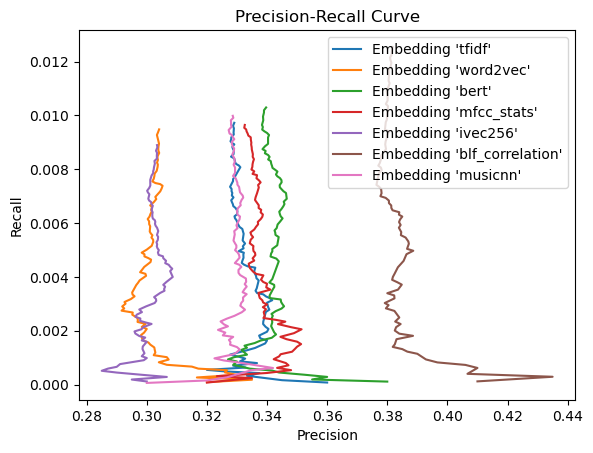

([0.3,
  0.32,
  0.32666666666666666,
  0.335,
  0.342,
  0.33,
  0.3257142857142858,
  0.3225,
  0.32888888888888884,
  0.33,
  0.3309090909090909,
  0.33,
  0.32769230769230767,
  0.3278571428571429,
  0.32733333333333337,
  0.32875,
  0.3252941176470588,
  0.32611111111111113,
  0.32368421052631574,
  0.327,
  0.3257142857142857,
  0.32454545454545447,
  0.3265217391304347,
  0.32916666666666666,
  0.33159999999999995,
  0.3326923076923076,
  0.3311111111111111,
  0.33142857142857146,
  0.3320689655172415,
  0.33199999999999996,
  0.3332258064516129,
  0.331875,
  0.3324242424242424,
  0.33323529411764696,
  0.3325714285714285,
  0.3330555555555555,
  0.3329729729729729,
  0.3310526315789473,
  0.3305128205128205,
  0.33049999999999996,
  0.33146341463414636,
  0.3307142857142857,
  0.32930232558139527,
  0.33022727272727265,
  0.3308888888888889,
  0.33065217391304347,
  0.3302127659574468,
  0.3293750000000001,
  0.3297959183673469,
  0.32980000000000004,
  0.3294117647058824,
  0

In [13]:
# Specify the sample size
sample_size = 100
k_range = range(1, 101)  # This creates a range from 1 to 100 (inclusive)

# List of embeddings
embeddings_list = [tfidf, word2vec,bert,mfcc_stats,ivec256,blf_correlation, musicnn] # Add all your embeddings

calc_avg_recall_precision(embeddings_list, k_range, sample_size)